In [9]:
import colorsys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from math import pi, cos, sin,atan
import math
import os
import pickle
from sklearn.cluster import DBSCAN

from numpy.random import randint
from numpy.random import rand

import json

from paretoset import paretoset
import pandas as pd

import pygad

from bayes_opt import BayesianOptimization

import datetime

import warnings
warnings.filterwarnings('ignore')

## B-spline curve modeling

In [15]:
def bgr2c_myk(org):
    # Calculate the CMYK values for each pixel
    c = 1.0 - org[:,:,2]/255.0 #Red channel
    m = 1.0 - org[:,:,1]/255.0 #Green channel
    y = 1.0 - org[:,:,0]/255.0 #Blue channel 
    k = np.minimum(c, np.minimum(m, y))
    # k = 1 - np.maximum(org[:,:,0], org[:,:,1], org[:,:,2])
    c = (c - k) / (1.0 - k)
    m = (m - k) / (1.0 - k)
    y = (y - k) / (1.0 - k)

    # Scale the CMYK values to the range [0, 255] and convert to uint8
    c = (c * 255.0).astype(np.uint8)
    m = (m * 255.0).astype(np.uint8)
    y = (y * 255.0).astype(np.uint8)
    k = (k * 255.0).astype(np.uint8)

    # Create a new image from the CMYK data and return it
    myk_data = np.dstack((m, y, k))
    
    return c,myk_data

In [86]:
MasterColors = np.zeros((256,256,256)).astype(int)
Cs = np.array([])
MasterNonColors = np.zeros((256,256,256)).astype(int)

In [87]:
#Getting a count of each pixel that is skin

def MSK(s):
    return s.replace('\\ORI\\','\\GT\\')

images = 0
for filename in os.scandir("..\\Data\\sfa\\ORI"):
    if filename.is_file() and filename.path[-4:]==".jpg":
            #print("Image "+str(images)+" -- "+file)
        images+=1
            
        C,img = bgr2c_myk(cv2.imread(filename.path))
        msk = cv2.imread(MSK(filename.path),0)
        
        Cs = np.append( Cs,C[msk.astype(bool)].flatten())
        
        skin = img[msk!=0]
        skin = skin.reshape(-1,3)
    
        for i in range(skin.shape[0]):
            MasterColors[skin[i,0],skin[i,1],skin[i,2]] += 1
print("Done processing ",images," images.")

Done processing  1114  images.


In [85]:
filename

<DirEntry 'img (522).jpg'>

In [91]:
np.quantile( Cs ,[0.99] )

array([15.])

In [88]:
images = 0
for filename in os.scandir("..\\Data\\sfa\\ORI"):
    if filename.is_file() and filename.path[-4:]==".jpg":
            #print("Image "+str(images)+" -- "+file)
        images+=1
            
        _,img = bgr2c_myk(cv2.imread(filename.path))
        msk = cv2.imread(MSK(filename.path),0)
            
        skin = img[msk==0]
        skin = skin.reshape(-1,3)
    
        for i in range(skin.shape[0]):
            MasterNonColors[skin[i,0],skin[i,1],skin[i,2]] += 1
print("Done processing ",images," images.")

Done processing  1114  images.


In [92]:
#Extracting the pixels that are skin
Points = np.argwhere(MasterColors>0)

In [93]:
class Ellipse:
    def __init__(self,clus,H1,H2,S1,S2,T):
        self.cluster = clus
        self.HMoy = H1
        self.SMoy = S1
        self.HEct = H2
        self.SEct = S2
        self.thet = 0 if np.isnan(T) else T
        self.Th = 2
    def __str__(self):
        return "Of cluster:"+str(self.cluster)+" with Th "+str(self.Th)+" At("+str(self.HMoy)+","+str(self.SMoy)+"),with("+str(self.HEct)+","+str(self.SEct)+"), theta "+str(self.thet)
    def is_it_in(self,H,S):
        return (pow((cos(self.thet)*(H-self.HMoy) + sin(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.HEct,2)) + (pow((-sin(self.thet)*(H-self.HMoy) + cos(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.SEct,2)) <= 1
    def are_they_in(self,H,S):
        return (np.power((cos(self.thet)*(H-self.HMoy) + sin(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.HEct,2)) + (np.power((-sin(self.thet)*(H-self.HMoy) + cos(self.thet)*(S-self.SMoy)),2) / pow(self.Th*self.SEct,2)) <= 1
    def F(self):
        print(Points)

In [94]:
class CLUSTER:
    def __init__(self,numero):
        self.id = numero
    def fit(self,points):
        valeurs = np.unique(points[:,2])
        self.nbVal = valeurs.shape[0]
        HuesMoyennes = []
        SatsMoyennes = []
        HuesEcartsTy = []
        SatsEcartsTy = []
        thetas = []
        for i in valeurs:
            Hues = points[(points[:,2]==i)][:,0];Sats = points[(points[:,2]==i)][:,1]
            HM = Hues.mean();HE = Hues.std()
            SM = Sats.mean();SE = Sats.std()
            theta = 0 if HE == SE else 0.5 * atan(2* np.corrcoef(Hues,Sats)[0,1] *HE*SE/(HE**2-SE**2))
                
            HuesMoyennes.append(HM);HuesEcartsTy.append(HE)
            SatsMoyennes.append(SM);SatsEcartsTy.append(SE)
            thetas.append(theta)
        
        self.min = valeurs.min()
        self.max = valeurs.max()
        K = min(3,valeurs.shape[0]-1)
        t, c, k = interpolate.splrep(valeurs, HuesMoyennes, s=0,k = K)
        self.HueMoy = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, SatsMoyennes, s=0,k = K)
        self.SatMoy = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, HuesEcartsTy, s=0,k = K)
        self.HueEct = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, SatsEcartsTy, s=0,k = K)
        self.SatEct = interpolate.BSpline(t, c, k, extrapolate=True)
        t, c, k = interpolate.splrep(valeurs, thetas, s=0,k = K)
        self.Theta = interpolate.BSpline(t, c, k, extrapolate=True)
    def __str__(self):
        return 'ID: '+str(self.id)+' Nb val '+str(self.nbVal)

In [95]:
#Finding which ellipses exist at each intensity level
ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

In [170]:
%matplotlib qt

In [ ]:
# Drawing stuff supposing that Th (Le seuil) is 2

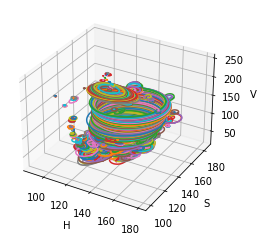

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')

for i in range(256):
    for ELLI in ELLIPSES[i]:
        u=ELLI.HMoy      #x-position of the center
        v=ELLI.SMoy      #y-position of the center
        a=ELLI.Th*ELLI.HEct       #radius on the x-axis
        b=ELLI.Th*ELLI.SEct      #radius on the y-axis
        t_rot=ELLI.thet #rotation angle

        t = np.linspace(0, 2*pi, 100)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
        R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
    #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for j in range(Ell.shape[1]):
            Ell_rot[:,j] = np.dot(R_rot,Ell[:,j])

        ax.plot( u + Ell_rot[0,:] , v + Ell_rot[1,:],np.ones((Ell_rot[0].shape))*i)
plt.show()

# Fonction cout

In [96]:
def EvaluationGlobale():
    P = np.argwhere(MasterColors!=0)
    t = 0;vt = 0
    st = 0;sst = 0
    
    for i in range(256):
        p = P[P[:,2]==i]
        if(p.shape[0]<1):
            continue
        R = np.zeros((p.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(p[:,0],p[:,1]).reshape((-1,1))
        R=(R>0).flatten()
        t += R.sum()
        vt += p.shape[0]
        st += MasterColors[p[:,0],p[:,1],p[:,2]][R].sum()
    sst = MasterColors[P[:,0],P[:,1],P[:,2]].sum()
    print(t,vt,t/vt,st,sst,st/sst)
    P = np.argwhere(MasterNonColors!=0)
    f = 0;vf = 0
    sf = 0;ssf = 0
    
    for i in range(256):
        p = P[P[:,2]==i]
        if(p.shape[0]<1):
            continue
        R = np.zeros((p.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(p[:,0],p[:,1]).reshape((-1,1))
        R = (R>0).flatten()
        f += (R>0).sum()
        vf += p.shape[0]
        sf += MasterNonColors[p[:,0],p[:,1],p[:,2]][R].sum()
    ssf = MasterNonColors[P[:,0],P[:,1],P[:,2]].sum()

    print(f,vf,f/vf,sf,ssf,sf/ssf)
    return (t/vt,f/vf,st/sst,sf/ssf)


In [97]:
def getMask(img):
    I = img.reshape((img.shape[0]*img.shape[1],3))
    msk = np.zeros((img.shape[0],img.shape[1]))
    for i in range(256):
        P = np.argwhere(img[:,:,2]==i)
        
        R = np.zeros((P.shape[0],1))
        for e in ELLIPSES[i]:
            R = R + e.are_they_in(img[P[:,0],P[:,1],0],img[P[:,0],P[:,1],1]).reshape((-1,1))
        R=(R>0).flatten()
        
        msk[P[:,0],P[:,1]] = 1+R-1
    return msk

# Trouver les seuils Th

In [98]:
ResV = {2:{},3:{}}
ResF = {2:{},3:{}}
RES  = {2:{},3:{}}

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
EPS = [2]*18+[3]*20
MIN_Sam = [i for i in range(9,27)]+[i for i in range(15,35)]

for ID in range(len(EPS)):
    clustering = DBSCAN(eps=EPS[ID], min_samples=MIN_Sam[ID]).fit(Points)
    nbCluster = clustering.labels_.max()
    try:
        Clusters = {}
        for C in range(nbCluster+1):
            Clus = CLUSTER(C)
            Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
            Clusters[C] = Clus

        ELLIPSES = {}
        for i in range(256):
            ELLIPSES[i] = []
        ELLIPSESFLAT = []

        for C in range(nbCluster+1):
            Clus = Clusters[C]
            for v in range(Clus.min,Clus.max+1):
                e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
                ELLIPSES[v].append(e)
                ELLIPSESFLAT.append(e)
            
        ResV[EPS[ID]][MIN_Sam[ID]]={}
        ResF[EPS[ID]][MIN_Sam[ID]]={}
        RES[EPS[ID]][MIN_Sam[ID]]={}
            
        for Th in np.arange(1,2.8,0.1): #Pour chaque valeur de V
       
            for e in ELLIPSESFLAT:
                e.Th = Th
            print("Th = ",Th," eps = ",EPS[ID]," MinSamp = ",MIN_Sam[ID])
            V1,F1,V,F = EvaluationGlobale()
            ResV[EPS[ID]][MIN_Sam[ID]][Th] = [V1,V]
            ResF[EPS[ID]][MIN_Sam[ID]][Th] = [F1,F]
            RES[EPS[ID]][MIN_Sam[ID]][Th] = {"Clus":clustering}
            print("-----------------------------------------------")
    except:
        print("Failed for ",EPS[ID],MIN_Sam[ID])

Failed for  2 9
Th =  1.0  eps =  2  MinSamp =  10
24169 293932 0.08222650136766327 1055189 130842242 0.008064589721719993
21487 373195 0.05757579817521671 19287633 319095166 0.060444767126306136
-----------------------------------------------
Th =  1.1  eps =  2  MinSamp =  10
27841 293932 0.09471918675067703 1245987 130842242 0.009522819090794853
24988 373195 0.0669569527994748 21443718 319095166 0.06720163852309816
-----------------------------------------------
Th =  1.2000000000000002  eps =  2  MinSamp =  10
31818 293932 0.10824952710150647 1474774 130842242 0.011271390473422184
28652 373195 0.07677487640509653 24824684 319095166 0.07779711711458519
-----------------------------------------------
Th =  1.3000000000000003  eps =  2  MinSamp =  10
36034 293932 0.12259298068941116 1751316 130842242 0.013384943373257087
32308 373195 0.0865713634962955 27652833 319095166 0.08666014388948781
-----------------------------------------------
Th =  1.4000000000000004  eps =  2  MinSamp =  

39483 293932 0.13432698719431704 2668946 130842242 0.020398198312743678
37501 373195 0.10048634092096626 174608240 319095166 0.5471980105145184
-----------------------------------------------
Th =  2.7000000000000015  eps =  2  MinSamp =  12
40308 293932 0.1371337588285726 2694107 130842242 0.020590498594482965
38541 373195 0.10327308779592438 174793357 319095166 0.5477781415215798
-----------------------------------------------
Th =  1.0  eps =  2  MinSamp =  13
8992 293932 0.030592109739667677 442933 130842242 0.0033852446521055487
7879 373195 0.02111228714211069 11360589 319095166 0.03560251050622309
-----------------------------------------------
Th =  1.1  eps =  2  MinSamp =  13
10440 293932 0.03551841922621559 526495 130842242 0.004023891611395653
9261 373195 0.024815445008641596 13007529 319095166 0.040763792078254174
-----------------------------------------------
Th =  1.2000000000000002  eps =  2  MinSamp =  13
11902 293932 0.04049235877685996 618603 130842242 0.004727853868

13344 373195 0.03575610605715511 163718262 319095166 0.5130703296207251
-----------------------------------------------
Th =  2.5000000000000013  eps =  2  MinSamp =  14
17366 293932 0.0590816923642203 1908323 130842242 0.014584915168298629
13790 373195 0.03695119173622369 164432313 319095166 0.5153080664343251
-----------------------------------------------
Th =  2.6000000000000014  eps =  2  MinSamp =  14
17771 293932 0.060459562075582104 1919744 130842242 0.014672203492202465
14153 373195 0.03792387357815619 164846216 319095166 0.5166051810386874
-----------------------------------------------
Th =  2.7000000000000015  eps =  2  MinSamp =  14
18140 293932 0.061714954479267316 1928158 130842242 0.01473650994149122
14506 373195 0.03886975977706025 165246381 319095166 0.5178592426561548
-----------------------------------------------
Th =  1.0  eps =  2  MinSamp =  15
3262 293932 0.011097804934474641 310393 130842242 0.0023722690413696826
2657 373195 0.007119602352657458 6834454 319095

8443 293932 0.028724330797599444 1424173 130842242 0.010884657571061798
6830 373195 0.01830142418842696 153864110 319095166 0.4821887837686642
-----------------------------------------------
Th =  2.4000000000000012  eps =  2  MinSamp =  16
8695 293932 0.029581671951335684 1446572 130842242 0.01105584846215032
7040 373195 0.018864132692024277 154342393 319095166 0.48368765636518607
-----------------------------------------------
Th =  2.5000000000000013  eps =  2  MinSamp =  16
8942 293932 0.030422002367894614 1467079 130842242 0.011212579191359316
7227 373195 0.019365211216656172 154646042 319095166 0.48463925022292564
-----------------------------------------------
Th =  2.6000000000000014  eps =  2  MinSamp =  16
9261 293932 0.03150728739980676 1497759 130842242 0.01144706004044168
7475 373195 0.020029743163761573 155265613 319095166 0.4865808998184573
-----------------------------------------------
Th =  2.7000000000000015  eps =  2  MinSamp =  16
9543 293932 0.032466692976606835 1

2232 373195 0.005980787523948606 12865057 319095166 0.040317304587434585
-----------------------------------------------
Th =  2.200000000000001  eps =  2  MinSamp =  18
2391 293932 0.00813453451818788 278611 130842242 0.002129365835843748
2276 373195 0.006098688353273758 12956781 319095166 0.04060475488368884
-----------------------------------------------
Th =  2.300000000000001  eps =  2  MinSamp =  18
2442 293932 0.008308044037396404 282936 130842242 0.0021624209099076735
2327 373195 0.0062353461327188196 13221023 319095166 0.04143285266815982
-----------------------------------------------
Th =  2.4000000000000012  eps =  2  MinSamp =  18
2644 293932 0.00899527781935958 311040 130842242 0.0023772139275938116
2529 373195 0.00677661812189338 14687251 319095166 0.046027807892269984
-----------------------------------------------
Th =  2.5000000000000013  eps =  2  MinSamp =  18
2714 293932 0.009233428139841867 333545 130842242 0.002549214954601588
2596 373195 0.006956148930183952 153

424 293932 0.0014425105126355756 112428 130842242 0.0008592637842448466
424 373195 0.0011361352644060076 4749971 319095166 0.014885750415911973
-----------------------------------------------
Th =  2.100000000000001  eps =  2  MinSamp =  20
450 293932 0.0015309663459575685 112839 130842242 0.0008624049716298808
451 373195 0.0012084835005828052 4768979 319095166 0.014945318851994141
-----------------------------------------------
Th =  2.200000000000001  eps =  2  MinSamp =  20
462 293932 0.0015717921151831035 114686 130842242 0.0008765212078833073
463 373195 0.0012406382722169374 4832266 319095166 0.015143651533724581
-----------------------------------------------
Th =  2.300000000000001  eps =  2  MinSamp =  20
467 293932 0.00158880285236041 115059 130842242 0.0008793719691840804
468 373195 0.0012540360937311594 4841776 319095166 0.015173454554933621
-----------------------------------------------
Th =  2.4000000000000012  eps =  2  MinSamp =  20
477 293932 0.0016228243267150226 1154

60 293932 0.0002041288461276758 10228 130842242 7.817047341637573e-05
60 373195 0.00016077385817066145 741140 319095166 0.002322629983056528
-----------------------------------------------
Th =  2.000000000000001  eps =  2  MinSamp =  22
65 293932 0.0002211395833049821 10251 130842242 7.834625762527059e-05
65 373195 0.00017417167968488323 742636 319095166 0.002327318239600032
-----------------------------------------------
Th =  2.100000000000001  eps =  2  MinSamp =  22
69 293932 0.00023474817304682715 10273 130842242 7.851439904247437e-05
69 373195 0.00018488993689626067 743261 319095166 0.0023292769029287018
-----------------------------------------------
Th =  2.200000000000001  eps =  2  MinSamp =  22
70 293932 0.00023815032048228843 10369 130842242 7.924810704481814e-05
70 373195 0.00018756950119910504 745745 319095166 0.002337061414462167
-----------------------------------------------
Th =  2.300000000000001  eps =  2  MinSamp =  22
70 293932 0.00023815032048228843 10369 130842

0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  1.5000000000000004  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  1.6000000000000005  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  1.7000000000000006  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  1.8000000000000007  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  1.9000000000000008  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-----------------------------------------------
Th =  2.000000000000001  eps =  2  MinSamp =  25
0 293932 0.0 0 130842242 0.0
0 373195 0.0 0 319095166 0.0
-------

201117 293932 0.6842296857776629 49513436 130842242 0.37842087725766727
202958 373195 0.5438390117766851 63255708 319095166 0.1982346169418311
-----------------------------------------------
Th =  2.5000000000000013  eps =  3  MinSamp =  15
204759 293932 0.6966203067376128 50459296 130842242 0.38564988820659307
208600 373195 0.558957113573333 69894270 319095166 0.21903894965303236
-----------------------------------------------
Th =  2.6000000000000014  eps =  3  MinSamp =  15
207343 293932 0.7054114557108447 51893198 130842242 0.39660890249801745
213271 373195 0.5714733584319189 201039896 319095166 0.6300311550316623
-----------------------------------------------
Th =  2.7000000000000015  eps =  3  MinSamp =  15
208942 293932 0.7108514894601472 52808089 130842242 0.4036012238310621
217101 373195 0.5817360897118129 202317185 319095166 0.6340340016307235
-----------------------------------------------
Failed for  3 16
Failed for  3 17
Failed for  3 18
Th =  1.0  eps =  3  MinSamp =  19

135540 373195 0.3631881456075242 48976574 319095166 0.15348579113229185
-----------------------------------------------
Th =  2.300000000000001  eps =  3  MinSamp =  20
156658 293932 0.5329736129444905 17880794 130842242 0.13665918381312972
139453 373195 0.3736732807245542 55553845 319095166 0.17409804634896914
-----------------------------------------------
Th =  2.4000000000000012  eps =  3  MinSamp =  20
159338 293932 0.5420913680715268 18315104 130842242 0.13997852467248306
143082 373195 0.38339741957957635 63024931 319095166 0.19751139382663038
-----------------------------------------------
Th =  2.5000000000000013  eps =  3  MinSamp =  20
160970 293932 0.5476436726861995 18843099 130842242 0.14401388047141533
145901 373195 0.3909511113492946 189140869 319095166 0.5927412545008595
-----------------------------------------------
Th =  2.6000000000000014  eps =  3  MinSamp =  20
162252 293932 0.5520052256984609 19043222 130842242 0.14554337887300953
148458 373195 0.3978027572716676

131991 293932 0.44905284215396757 11520588 130842242 0.08804945424276664
112438 373195 0.30128485108321384 42265443 319095166 0.1324540372385334
-----------------------------------------------
Th =  2.200000000000001  eps =  3  MinSamp =  22
135247 293932 0.4601302342038295 11737120 130842242 0.08970436321321978
115708 373195 0.31004702635351494 46727137 319095166 0.14643636751300707
-----------------------------------------------
Th =  2.300000000000001  eps =  3  MinSamp =  22
138071 293932 0.46973789856157205 12012437 130842242 0.09180855369323311
118941 373195 0.31871005774461075 52585262 319095166 0.16479491889262904
-----------------------------------------------
Th =  2.4000000000000012  eps =  3  MinSamp =  22
140517 293932 0.4780595511887103 12652615 130842242 0.09670130079244592
122013 373195 0.3269416792829486 184511590 319095166 0.5782337360760896
-----------------------------------------------
Th =  2.5000000000000013  eps =  3  MinSamp =  22
142002 293932 0.48311174013037

89490 373195 0.23979420946154156 32944289 319095166 0.10324283320543941
-----------------------------------------------
Th =  2.000000000000001  eps =  3  MinSamp =  24
110436 293932 0.37571955418260006 7997281 130842242 0.06112155277803937
92517 373195 0.24790525060625143 36289305 319095166 0.11372564948226135
-----------------------------------------------
Th =  2.100000000000001  eps =  3  MinSamp =  24
113811 293932 0.3872018017772818 8191522 130842242 0.06260609627890662
95632 373195 0.2562520934096116 40180332 319095166 0.12591958851548382
-----------------------------------------------
Th =  2.200000000000001  eps =  3  MinSamp =  24
116824 293932 0.39745247200032663 8387538 130842242 0.06410420573502554
98736 373195 0.2645694610056405 44380598 319095166 0.1390826396912575
-----------------------------------------------
Th =  2.300000000000001  eps =  3  MinSamp =  24
119401 293932 0.4062198059415103 8598649 130842242 0.06571768313172133
101555 373195 0.2721231527753587 49843024

89976 293932 0.3061116176530626 5745586 130842242 0.0439123169411909
75575 373195 0.2025080721874623 29403040 319095166 0.09214504991905768
-----------------------------------------------
Th =  1.9000000000000008  eps =  3  MinSamp =  26
93705 293932 0.31879822543989766 5985949 130842242 0.04574936128043419
78563 373195 0.21051461032436125 32274472 319095166 0.10114371961372802
-----------------------------------------------
Th =  2.000000000000001  eps =  3  MinSamp =  26
96933 293932 0.32978035736156663 6186399 130842242 0.04728135887491136
81322 373195 0.21790752823590884 35612137 319095166 0.11160349887594348
-----------------------------------------------
Th =  2.100000000000001  eps =  3  MinSamp =  26
99792 293932 0.3395070968795504 6353256 130842242 0.04855661216811005
84083 373195 0.22530580527606212 39431209 319095166 0.12357194091746285
-----------------------------------------------
Th =  2.200000000000001  eps =  3  MinSamp =  26
102090 293932 0.34732523168624035 6495423 1

72579 293932 0.246924458718343 4199715 130842242 0.03209754690690794
62243 373195 0.16678412090194134 26791724 319095166 0.0839615476970278
-----------------------------------------------
Th =  1.8000000000000007  eps =  3  MinSamp =  28
76593 293932 0.2605806785242845 4476816 130842242 0.03421537212729815
65410 373195 0.17527030104904942 30297963 319095166 0.09494961449839075
-----------------------------------------------
Th =  1.9000000000000008  eps =  3  MinSamp =  28
79850 293932 0.27166147272158186 4692089 130842242 0.03586065882301222
68076 373195 0.18241401948043248 33017375 319095166 0.10347187459430207
-----------------------------------------------
Th =  2.000000000000001  eps =  3  MinSamp =  28
82600 293932 0.28101737816910033 4844047 130842242 0.037022042162805496
70423 373195 0.18870295689920819 35514889 319095166 0.11129873712972511
-----------------------------------------------
Th =  2.100000000000001  eps =  3  MinSamp =  28
85015 293932 0.28923356422573926 4978015 

55543 293932 0.18896547500782493 3063617 130842242 0.023414586552254278
48409 373195 0.1297150283363925 23087841 319095166 0.07235409200777426
-----------------------------------------------
Th =  1.7000000000000006  eps =  3  MinSamp =  30
59384 293932 0.20203312330743164 3350994 130842242 0.025610949100062043
51409 373195 0.13775372124492558 26374339 319095166 0.08265352098752884
-----------------------------------------------
Th =  1.8000000000000007  eps =  3  MinSamp =  30
62773 293932 0.21356300096620986 3607952 130842242 0.027574825567418814
54089 373195 0.14493495357654845 29110564 319095166 0.09122847069391204
-----------------------------------------------
Th =  1.9000000000000008  eps =  3  MinSamp =  30
65618 293932 0.22324211042009717 3796907 130842242 0.029018969271407014
56412 373195 0.1511595814520559 31513194 319095166 0.0987579799312911
-----------------------------------------------
Th =  2.000000000000001  eps =  3  MinSamp =  30
68084 293932 0.23163180599594463 394

29885 373195 0.08007877919050363 18155891 319095166 0.056898044641641485
-----------------------------------------------
Th =  1.5000000000000004  eps =  3  MinSamp =  32
37549 293932 0.12774723405413496 1980984 130842242 0.01514024805536426
32833 373195 0.08797813475528879 20770464 319095166 0.06509175385000975
-----------------------------------------------
Th =  1.6000000000000005  eps =  3  MinSamp =  32
40663 293932 0.13834152116816134 2236065 130842242 0.017089779002716875
35412 373195 0.09488873109232439 23381931 319095166 0.07327572928509986
-----------------------------------------------
Th =  1.7000000000000006  eps =  3  MinSamp =  32
43913 293932 0.14939850033341046 2498265 130842242 0.019093718984118293
38034 373195 0.1019145486943823 26012182 319095166 0.08151857117133514
-----------------------------------------------
Th =  1.8000000000000007  eps =  3  MinSamp =  32
46711 293932 0.15891770885783107 2719877 130842242 0.02078745333636212
40281 373195 0.10793552968287357 2

24669 293932 0.0839275750853939 1097155 130842242 0.008385327117827895
22622 373195 0.06061710365894506 16283681 319095166 0.05103079812873129
-----------------------------------------------
Th =  1.4000000000000004  eps =  3  MinSamp =  34
27253 293932 0.0927187240586258 1289761 130842242 0.00985737465428023
24880 373195 0.06666755985476762 18611810 319095166 0.05832683156347157
-----------------------------------------------
Th =  1.5000000000000004  eps =  3  MinSamp =  34
29686 293932 0.10099614876910305 1480145 130842242 0.01131243990759498
26880 373195 0.07202668846045633 20868207 319095166 0.06539806685758442
-----------------------------------------------
Th =  1.6000000000000005  eps =  3  MinSamp =  34
32071 293932 0.10911027040267816 1675759 130842242 0.012807476961454085
28821 373195 0.07722772277227723 23417140 319095166 0.07338606940852248
-----------------------------------------------
Th =  1.7000000000000006  eps =  3  MinSamp =  34
34337 293932 0.1168195364914334 1868

In [101]:
with open("ResV.json", "w") as write_file:
    json.dump(ResV, write_file, indent=4)
with open("ResF.json", "w") as write_file:
    json.dump(ResF, write_file, indent=4)
with open('RES.pkl', 'wb') as f:
    pickle.dump(RES, f)

# Loading data

In [16]:
with open("ResF.json", "r") as write_file:
    ResF = json.load(write_file)
with open("ResV.json", "r") as write_file:
    ResV = json.load(write_file)
with open('RES.pkl', 'rb') as f:
    RES = pickle.load(f)

# For global cost function 1 : 

In [102]:
#################################################################################################
# Creating the sets a.k.a the game
#################################################################################################
A = []
B = []
C = []
setV = []
setF = []
for a in ResV.keys():
    for b in ResV[a].keys():
        for c in ResV[a][b].keys():
            setV += [ResV[a][b][c][0]]
            setF += [ResF[a][b][c][0]]
            A += [a];B += [b];C += [c]
            
#################################################################################################
# Trouver l'equilibre
#################################################################################################
JEU = pd.DataFrame({"V": setV, 
                    "F": setF})
mask = paretoset(JEU, sense=["max", "min"])
paretoset_JEU = JEU[mask]
print("Il y a "+str(paretoset_JEU.shape[0])+" optimums de pareto !")
PS = paretoset_JEU.to_numpy()

#### LE MEILLEUR DANS LE SANS QUE la difference entre metric1 et metric2 soit maximale
PS[np.argmax(PS[:,0]-PS[:,1])]
idx = np.array([i for i in range(JEU.shape[0])])[mask][np.argmax(PS[:,0]-PS[:,1])]

bestEPS = A[idx]
bestMinSample = B[idx]
bestTh = C[idx]

print("Le meilleur résultat est ("+str(setV[idx])+", "+str(setF[idx])+") a "+str(idx)+". Pour ("+str(bestEPS)+","+str(bestMinSample)+","+str(bestTh)+")")

#################################################################################################
# Setting our model to the best solution
#################################################################################################
clustering = RES[int(bestEPS)][int(bestMinSample)][float(bestTh)]["Clus"]
nbCluster = clustering.labels_.max()
Clusters = {}
for C in range(nbCluster+1):
    Clus = CLUSTER(C)
    Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
    Clusters[C] = Clus

ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

for C in range(nbCluster+1):
    Clus = Clusters[C]
    for v in range(Clus.min,Clus.max+1):
        e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
        ELLIPSES[v].append(e)
        ELLIPSESFLAT.append(e)

for e in ELLIPSESFLAT:
    e.Th = float(bestTh)
    
#################################################################################################
# Evaluer
#################################################################################################
_=EvaluationGlobale()

Il y a 240 optimums de pareto !
Le meilleur résultat est (0.5513009811793204, 0.3909001996275406) a 318. Pour (3,19,2.200000000000001)
162045 293932 0.5513009811793204 21897538 130842242 0.16735832148152888
145882 373195 0.3909001996275406 49487049 319095166 0.1550855489926162


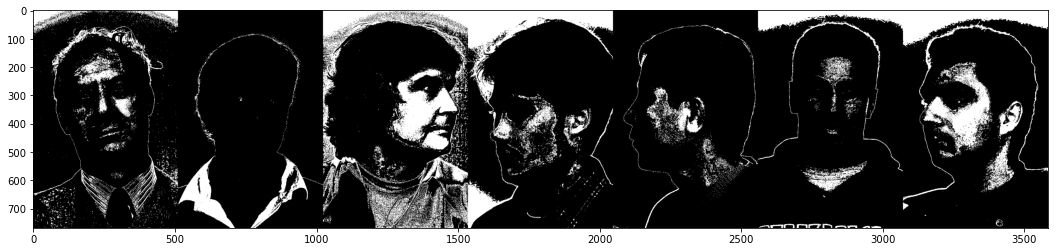

In [105]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (50).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
c,img = bgr2c_myk(IMAGE)
MASK = getMask(img)
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

# For global cost function 2 (the weighted one):

In [106]:
#################################################################################################
# Creating the sets a.k.a the game
#################################################################################################
A = []
B = []
C = []
setV = []
setF = []
for a in ResV.keys():
    for b in ResV[a].keys():
        for c in ResV[a][b].keys():
            setV += [ResV[a][b][c][1]]
            setF += [ResF[a][b][c][1]]
            A += [a];B += [b];C += [c]
            
#################################################################################################
# Trouver l'equilibre
#################################################################################################
JEU = pd.DataFrame({"V": setV, 
                    "F": setF})
mask = paretoset(JEU, sense=["max", "min"])
paretoset_JEU = JEU[mask]
print("Il y a "+str(paretoset_JEU.shape[0])+" optimums de pareto !")
PS = paretoset_JEU.to_numpy()

#### LE MEILLEUR DANS LE SANS QUE la difference entre metric1 et metric2 soit maximale
PS[np.argmax(PS[:,0]-PS[:,1])]
idx = np.array([i for i in range(JEU.shape[0])])[mask][np.argmax(PS[:,0]-PS[:,1])]

bestEPS = A[idx]
bestMinSample = B[idx]
bestTh = C[idx]

print("Le meilleur résultat est ("+str(setV[idx])+", "+str(setF[idx])+") a "+str(idx)+". Pour ("+str(bestEPS)+","+str(bestMinSample)+","+str(bestTh)+")")

#################################################################################################
# Setting our model to the best solution
#################################################################################################
clustering = RES[int(bestEPS)][int(bestMinSample)][float(bestTh)]["Clus"]
nbCluster = clustering.labels_.max()
Clusters = {}
for C in range(nbCluster+1):
    Clus = CLUSTER(C)
    Clus.fit(Points[np.ravel(np.argwhere(clustering.labels_==C))] )
    Clusters[C] = Clus

ELLIPSES = {}
for i in range(256):
    ELLIPSES[i] = []
ELLIPSESFLAT = []

for C in range(nbCluster+1):
    Clus = Clusters[C]
    for v in range(Clus.min,Clus.max+1):
        e = Ellipse(C,Clus.HueMoy(v),Clus.HueEct(v),Clus.SatMoy(v),Clus.SatEct(v),Clus.Theta(v))
        ELLIPSES[v].append(e)
        ELLIPSESFLAT.append(e)

for e in ELLIPSESFLAT:
    e.Th = float(bestTh)
    
#################################################################################################
# Evaluer
#################################################################################################
_=EvaluationGlobale()

Il y a 57 optimums de pareto !
Le meilleur résultat est (0.3261618522250635, 0.08641422665738534) a 296. Pour (3,15,1.8000000000000007)
162440 293932 0.5526448294163275 42675748 130842242 0.3261618522250635
157030 373195 0.42077198247564945 27574362 319095166 0.08641422665738534


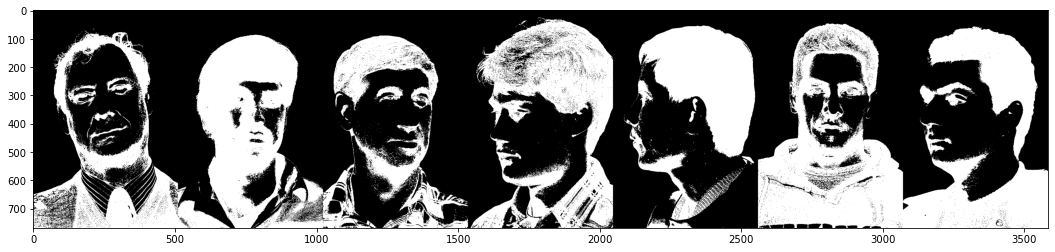

In [107]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
c,img = bgr2c_myk(IMAGE)
MASK = getMask(IMAGE )
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

# This is not even worth trying to make it better

# Algorithme génetique

In [24]:
import pygad

In [33]:
def setWeights(i,vals):
    j = 0
    for e in ELLIPSES[i]:
        e.Th = vals[j]
        j+=1
def getWeights(i):
    res = []
    for e in ELLIPSES[i]:
        res += [e.Th]
    return res

In [34]:
def Evaluer(Ellips,Points,i):
    P = np.argwhere(Points[:,:,i]!=0)    
    R = np.zeros((P.shape[0],1))
    for e in Ellips:
        R = R + e.are_they_in(P[:,0],P[:,1]).reshape((-1,1))
    R=(R>0).flatten()
    return R.sum()/P.shape[0]

# GA m1 - 1.85 m2

In [42]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.9*Evaluer(ELLIPSES[i],MasterNonColors,i)
EvaluationGlobale()

desired_output = 0
num_generations = 80
num_parents_mating = 4
sol_per_pop = 8
init_range_low = 0.8
init_range_high = 4.8
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

for I in range(256):
    function_inputs = getWeights(I)
    num_genes = len(function_inputs)
    if(num_genes<1):
        continue
    def fitness_func(ga_instance, solution, solution_idx):
        setWeights(I,solution)
        return Evaluation(I)

    fitness_function = fitness_func
    
    ga_instance = pygad.GA(num_generations=num_generations,
                                   num_parents_mating=num_parents_mating,
                                   fitness_func=fitness_function,
                                   sol_per_pop=sol_per_pop,
                                   num_genes=num_genes,
                                   init_range_low=init_range_low,
                                   init_range_high=init_range_high,
                                   parent_selection_type=parent_selection_type,
                                   keep_parents=keep_parents,
                                   crossover_type=crossover_type,
                                   mutation_type=mutation_type,
                                   mutation_percent_genes=mutation_percent_genes)

    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    setWeights(I,solution)

EvaluationGlobale()

90434 373379 0.24220430179522684 112318288 131235458 0.8558532100371837
89902 676444 0.13290383239410802 105496380 319095166 0.3306110253014613
50425 373379 0.13505044472238664 97489071 131235458 0.7428561799205212
51490 676444 0.07611864396757159 58110112 319095166 0.18210903263887113


(0.13505044472238664,
 0.07611864396757159,
 0.7428561799205212,
 0.18210903263887113)

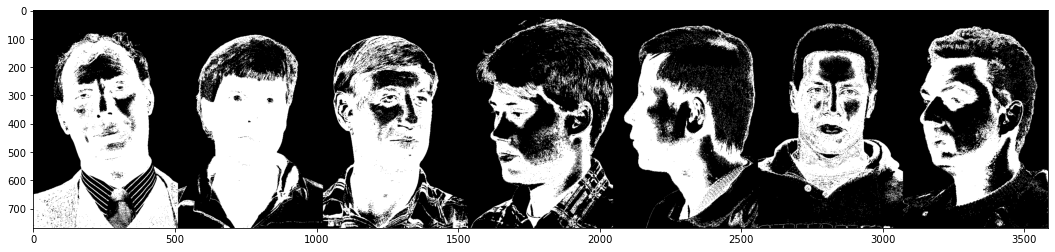

In [43]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YUV),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [44]:
with open('Result GA 1.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

# GA with m1-m2

In [35]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i)-Evaluer(ELLIPSES[i],MasterNonColors,i)
EvaluationGlobale()

desired_output = 0
num_generations = 80
num_parents_mating = 4
sol_per_pop = 8
init_range_low = 0.8
init_range_high = 4.8
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

for I in range(256):
    function_inputs = getWeights(I)
    num_genes = len(function_inputs)
    if(num_genes<1):
        continue
    def fitness_func(ga_instance, solution, solution_idx):
        setWeights(I,solution)
        return Evaluation(I)

    fitness_function = fitness_func
    
    ga_instance = pygad.GA(num_generations=num_generations,
                                   num_parents_mating=num_parents_mating,
                                   fitness_func=fitness_function,
                                   sol_per_pop=sol_per_pop,
                                   num_genes=num_genes,
                                   init_range_low=init_range_low,
                                   init_range_high=init_range_high,
                                   parent_selection_type=parent_selection_type,
                                   keep_parents=keep_parents,
                                   crossover_type=crossover_type,
                                   mutation_type=mutation_type,
                                   mutation_percent_genes=mutation_percent_genes)

    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    setWeights(I,solution)

EvaluationGlobale()

90434 373379 0.24220430179522684 112318288 131235458 0.8558532100371837
89902 676444 0.13290383239410802 105496380 319095166 0.3306110253014613
276992 373379 0.741852112732639 129621719 131235458 0.98770348330708
311218 676444 0.46007947442803837 295849823 319095166 0.9271523185656783


(0.741852112732639, 0.46007947442803837, 0.98770348330708, 0.9271523185656783)

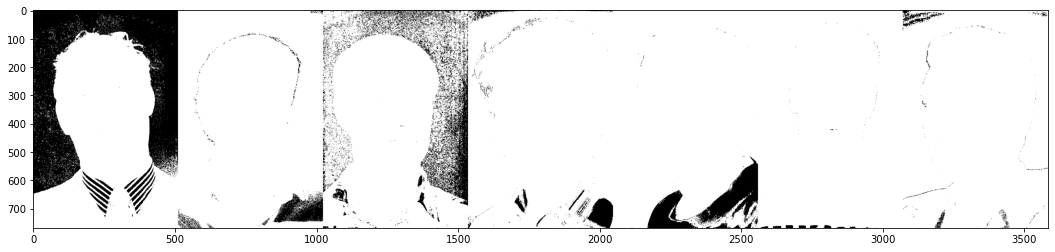

In [37]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YUV),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [25]:
with open('Result GA 2.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

In [34]:
with open('Result GA 2.pkl', 'rb') as f:
    ELLIPSES = pickle.load(f)

# Bayesian optimisation

In [59]:
# BlackBox functions
def lesTh(nb):
    res = "Th0"
    for i in range(1,nb):
        res += ",Th"+str(i)
    return res
for i in range(1,12):
    print("def f"+str(i)+"("+lesTh(i)+"):")
    print("\tsetWeights(I,["+lesTh(i)+"])")
    print("\treturn Evaluation(I)")

def f1(Th0):
	setWeights(I,[Th0])
	return Evaluation(I)
def f2(Th0,Th1):
	setWeights(I,[Th0,Th1])
	return Evaluation(I)
def f3(Th0,Th1,Th2):
	setWeights(I,[Th0,Th1,Th2])
	return Evaluation(I)
def f4(Th0,Th1,Th2,Th3):
	setWeights(I,[Th0,Th1,Th2,Th3])
	return Evaluation(I)
def f5(Th0,Th1,Th2,Th3,Th4):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4])
	return Evaluation(I)
def f6(Th0,Th1,Th2,Th3,Th4,Th5):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5])
	return Evaluation(I)
def f7(Th0,Th1,Th2,Th3,Th4,Th5,Th6):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6])
	return Evaluation(I)
def f8(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7])
	return Evaluation(I)
def f9(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8])
	return Evaluation(I)
def f10(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9])
	return Evaluation(I)
def f11(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9,Th10):
	setWeights(I,[Th0,Th1,T

In [60]:
def f1(Th0):
	setWeights(I,[Th0])
	return Evaluation(I)
def f2(Th0,Th1):
	setWeights(I,[Th0,Th1])
	return Evaluation(I)
def f3(Th0,Th1,Th2):
	setWeights(I,[Th0,Th1,Th2])
	return Evaluation(I)
def f4(Th0,Th1,Th2,Th3):
	setWeights(I,[Th0,Th1,Th2,Th3])
	return Evaluation(I)
def f5(Th0,Th1,Th2,Th3,Th4):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4])
	return Evaluation(I)
def f6(Th0,Th1,Th2,Th3,Th4,Th5):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5])
	return Evaluation(I)
def f7(Th0,Th1,Th2,Th3,Th4,Th5,Th6):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6])
	return Evaluation(I)
def f8(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7])
	return Evaluation(I)
def f9(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8])
	return Evaluation(I)
def f10(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9])
	return Evaluation(I)
def f11(Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9,Th10):
	setWeights(I,[Th0,Th1,Th2,Th3,Th4,Th5,Th6,Th7,Th8,Th9,Th10])
	return Evaluation(I)

In [61]:
def getBounds(nb):
    Bounds = {}
    for i in range(nb):
        Bounds['Th'+str(i)] = (0.1,5)
    return Bounds


def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.7*Evaluer(ELLIPSES[i],MasterNonColors,i)

In [62]:
EvaluationGlobale()

90434 373379 0.24220430179522684 112318288 131235458 0.8558532100371837
89902 676444 0.13290383239410802 105496380 319095166 0.3306110253014613


(0.24220430179522684,
 0.13290383239410802,
 0.8558532100371837,
 0.3306110253014613)

In [63]:
for I in range(256):
    NB = len(ELLIPSES[I])
    if(NB==0):
        continue

    black_box_function = globals()["f"+str(NB)]

    # Bounded region of parameter space
    pbounds = getBounds(NB) #{'x': (2, 4), 'y': (-3, 3)}

    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        random_state=1,
        allow_duplicate_points=True
    )


    optimizer.maximize(
        init_points=20,
        n_iter=100,
    )

    print(optimizer.max)
    setWeights(I, list(optimizer.max['params'].values()))


|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.7      | 2.143     |
| 2         | -0.7      | 3.63      |
| 3         | 0.0       | 0.1006    |
| 4         | -0.525    | 1.581     |
| 5         | -0.175    | 0.8191    |
| 6         | -0.175    | 0.5525    |
| 7         | -0.175    | 1.013     |
| 8         | -0.7      | 1.793     |
| 9         | -0.7      | 2.044     |
| 10        | -0.7      | 2.74      |
| 11        | -0.7      | 2.154     |
| 12        | -0.7      | 3.458     |
| 13        | -0.175    | 1.102     |
| 14        | -0.7      | 4.403     |
| 15        | 0.0       | 0.2342    |
| 16        | -0.7      | 3.385     |
| 17        | -0.7      | 2.145     |
| 18        | -0.7      | 2.838     |
| 19        | -0.175    | 0.7879    |
| 20        | -0.175    | 1.071     |
| 21        | 0.0       | 0.1667    |
| 22        | 0.0       | 0.2048    |
| 23        | -0.7      | 5.0       |
| 24        | 0.0       | 0.1288    |
| 25        

| 22        | -0.7      | 5.0       |
| 23        | 0.0       | 0.3888    |
| 24        | 0.0       | 0.3132    |
| 25        | 0.0       | 0.156     |
| 26        | 0.0       | 0.4589    |
| 27        | 0.0       | 0.4262    |
| 28        | 0.0       | 0.1951    |
| 29        | 0.0       | 0.275     |
| 30        | 0.0       | 0.3509    |
| 31        | 0.0       | 0.1246    |
| 32        | 0.0       | 0.44      |
| 33        | 0.0       | 0.2549    |
| 34        | 0.0       | 0.175     |
| 35        | 0.0       | 0.2147    |
| 36        | 0.0       | 0.1       |
| 37        | 0.0       | 0.294     |
| 38        | 0.0       | 0.3328    |
| 39        | 0.0       | 0.3692    |
| 40        | 0.0       | 0.408     |
| 41        | 0.0       | 0.1259    |
| 42        | 0.0       | 0.4436    |
| 43        | 0.0       | 0.1476    |
| 44        | 0.0       | 0.4688    |
| 45        | 0.0       | 0.2463    |
| 46        | 0.0       | 0.4529    |
| 47        | 0.0       | 0.1873    |
| 48        

| 29        | -0.006061 | 0.2728    |
| 30        | -0.006061 | 0.4211    |
| 31        | -0.006061 | 0.1933    |
| 32        | -0.006061 | 0.3492    |
| 33        | -0.006061 | 0.1244    |
| 34        | -0.006061 | 0.433     |
| 35        | -0.006061 | 0.2138    |
| 36        | -0.006061 | 0.293     |
| 37        | -0.006061 | 0.2535    |
| 38        | -0.006061 | 0.1745    |
| 39        | -0.006061 | 0.3312    |
| 40        | -0.006061 | 0.1       |
| 41        | -0.006061 | 0.3673    |
| 42        | -0.006061 | 0.1342    |
| 43        | -0.006061 | 0.4046    |
| 44        | -0.006061 | 0.4618    |
| 45        | -0.006061 | 0.4431    |
| 46        | -0.006061 | 0.1157    |
| 47        | -0.006061 | 0.2069    |
| 48        | -0.006061 | 0.2829    |
| 49        | -0.006061 | 0.1518    |
| 50        | -0.006061 | 0.2423    |
| 51        | -0.006061 | 0.3737    |
| 52        | -0.006061 | 0.3181    |
| 53        | -0.006061 | 0.1802    |
| 54        | -0.006061 | 0.346     |
| 55        

Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 31        | 0.0       | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 32        | 0.0       | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 33        | 0.0       | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 34        | 0.0       | 0.1       |
| 35        | 0.0       | 0.1001    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 36        | 0.0       | 0.1       |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 37        | 0.0       | 0.1       |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 38        | 0.0       | 0.1       |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 39        | 0.0       | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 40  

Data point [0.1] is not unique. 55 duplicates registered. Continuing ...
| 98        | 0.0       | 0.1       |
Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 99        | 0.0       | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 100       | 0.0       | 0.1       |
| 101       | 0.0       | 0.1001    |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 102       | 0.0       | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 103       | 0.0       | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 104       | 0.0       | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 105       | 0.0       | 0.1       |
| 106       | 0.0       | 0.1005    |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 107       | 0.0       | 0.1       |
Data point [0.1] is not unique. 63 d

| 74        | 0.0       | 0.1082    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 75        | 0.0       | 0.1       |
| 76        | 0.0       | 0.1074    |
| 77        | 0.0       | 0.1135    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 78        | 0.0       | 0.1       |
| 79        | 0.0       | 0.1077    |
| 80        | 0.0       | 0.1081    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 81        | 0.0       | 0.1       |
| 82        | 0.0       | 0.1142    |
| 83        | 0.0       | 0.1073    |
| 84        | 0.0       | 0.1141    |
| 85        | 0.0       | 0.1081    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 86        | 0.0       | 0.1       |
| 87        | 0.0       | 0.1079    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 88        | 0.0       | 0.1       |
| 89        | 0.0       | 0.1142    |
| 90        | 0.0       | 0

| 65        | 0.0       | 0.119     |
| 66        | 0.0       | 0.1661    |
| 67        | 0.0       | 0.2294    |
| 68        | 0.0       | 0.2121    |
| 69        | 0.0       | 0.1275    |
| 70        | 0.0       | 0.1778    |
| 71        | 0.0       | 0.1893    |
| 72        | 0.0       | 0.1552    |
| 73        | 0.0       | 0.2005    |
| 74        | 0.0       | 0.2293    |
| 75        | 0.0       | 0.1135    |
| 76        | 0.0       | 0.1459    |
| 77        | 0.0       | 0.1065    |
| 78        | 0.0       | 0.1358    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 79        | 0.0       | 0.1       |
| 80        | 0.0       | 0.1674    |
| 81        | 0.0       | 0.2293    |
| 82        | 0.0       | 0.2092    |
| 83        | 0.0       | 0.1833    |
| 84        | 0.0       | 0.123     |
| 85        | 0.0       | 0.1947    |
| 86        | 0.0       | 0.1572    |
| 87        | 0.0       | 0.1753    |
| 88        | 0.0       | 0.2033    |
| 89        | 0.

| 67        | -0.005651 | 0.1561    |
| 68        | -0.005651 | 0.1721    |
| 69        | -0.005651 | 0.1331    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 70        | -0.005651 | 0.1       |
| 71        | -0.005651 | 0.2388    |
| 72        | -0.005651 | 0.2111    |
| 73        | -0.005651 | 0.1122    |
| 74        | -0.005651 | 0.1481    |
| 75        | -0.005651 | 0.1908    |
| 76        | -0.005651 | 0.2268    |
| 77        | -0.005651 | 0.1683    |
| 78        | -0.005651 | 0.2491    |
| 79        | -0.005651 | 0.1283    |
| 80        | -0.005651 | 0.2398    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 81        | -0.005651 | 0.1       |
| 82        | -0.005651 | 0.1116    |
| 83        | -0.005651 | 0.204     |
| 84        | -0.005651 | 0.1833    |
| 85        | -0.005651 | 0.1479    |
| 86        | -0.005651 | 0.163     |
| 87        | -0.005651 | 0.1295    |
| 88        | -0.005651 | 0.2403    |
| 89        | -0.005

| 59        | 0.0       | 0.108     |
| 60        | 0.0       | 0.1176    |
| 61        | 0.0       | 0.1084    |
| 62        | 0.0       | 0.1085    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 63        | 0.0       | 0.1       |
| 64        | 0.0       | 0.1172    |
| 65        | 0.0       | 0.108     |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 66        | 0.0       | 0.1       |
| 67        | 0.0       | 0.109     |
| 68        | 0.0       | 0.1172    |
| 69        | 0.0       | 0.1087    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 70        | 0.0       | 0.1       |
| 71        | 0.0       | 0.1088    |
| 72        | 0.0       | 0.1173    |
| 73        | 0.0       | 0.109     |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 74        | 0.0       | 0.1       |
| 75        | 0.0       | 0.109     |
| 76        | 0.0       | 0.1174    |
Data point [0.1] is not 

Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 41        | -0.002796 | 0.1       |
| 42        | -0.002796 | 0.1214    |
| 43        | -0.002796 | 0.1537    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 44        | -0.002796 | 0.1       |
| 45        | -0.002796 | 0.175     |
| 46        | -0.002796 | 0.1527    |
| 47        | -0.002796 | 0.1203    |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 48        | -0.002796 | 0.1       |
| 49        | -0.002796 | 0.1548    |
| 50        | -0.002796 | 0.1753    |
| 51        | -0.002796 | 0.1197    |
| 52        | -0.002796 | 0.1541    |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 53        | -0.002796 | 0.1       |
| 54        | -0.002796 | 0.1191    |
| 55        | -0.002796 | 0.156     |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 56        | -0.002796 | 0.1       |
| 57        | -0.002796 | 0.1755

| 27        | 0.0       | 0.1       |
| 28        | -0.001716 | 0.1925    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 29        | 0.0       | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 30        | 0.0       | 0.1       |
| 31        | 0.0       | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 32        | 0.0       | 0.1       |
| 33        | 0.0       | 0.1003    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 34        | 0.0       | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 35        | 0.0       | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 36        | 0.0       | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 37        | 0.0       | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 38  

| 94        | 0.0       | 0.1003    |
Data point [0.1] is not unique. 51 duplicates registered. Continuing ...
| 95        | 0.0       | 0.1       |
Data point [0.1] is not unique. 52 duplicates registered. Continuing ...
| 96        | 0.0       | 0.1       |
| 97        | 0.0       | 0.1011    |
Data point [0.1] is not unique. 53 duplicates registered. Continuing ...
| 98        | 0.0       | 0.1       |
| 99        | 0.0       | 0.1001    |
Data point [0.1] is not unique. 54 duplicates registered. Continuing ...
| 100       | 0.0       | 0.1       |
Data point [0.1] is not unique. 55 duplicates registered. Continuing ...
| 101       | 0.0       | 0.1       |
Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 102       | 0.0       | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 103       | 0.0       | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 104       | 0.0       | 0.1       

| 76        | -0.4077   | 1.971     |
| 77        | -0.5289   | 2.21      |
| 78        | -0.2782   | 1.63      |
| 79        | -0.6914   | 3.543     |
| 80        | -0.05734  | 0.8463    |
| 81        | -0.009557 | 0.3747    |
| 82        | -0.03504  | 0.632     |
| 83        | -0.08221  | 1.04      |
| 84        | 0.0       | 0.1489    |
| 85        | -0.01593  | 0.4145    |
| 86        | -0.003186 | 0.2183    |
| 87        | -0.006371 | 0.338     |
| 88        | -0.05256  | 0.7637    |
| 89        | -0.004779 | 0.2785    |
| 90        | 0.0       | 0.1       |
| 91        | 0.0       | 0.1494    |
| 92        | 0.0       | 0.1128    |
| 93        | 0.0       | 0.1351    |
| 94        | 0.0       | 0.1553    |
| 95        | 0.0       | 0.1       |
| 96        | 0.0       | 0.1227    |
| 97        | 0.0       | 0.1424    |
| 98        | 0.0       | 0.1097    |
| 99        | 0.0       | 0.1556    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 100       | 0.

| 67        | 0.0       | 0.1243    |
| 68        | 0.0       | 0.1105    |
| 69        | 0.0       | 0.1111    |
| 70        | 0.0       | 0.1245    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 71        | 0.0       | 0.1       |
| 72        | 0.0       | 0.1111    |
| 73        | 0.0       | 0.1241    |
| 74        | 0.0       | 0.1117    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 75        | 0.0       | 0.1       |
| 76        | 0.0       | 0.1112    |
| 77        | 0.0       | 0.1242    |
| 78        | 0.0       | 0.1113    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 79        | 0.0       | 0.1       |
| 80        | 0.0       | 0.1114    |
| 81        | 0.0       | 0.124     |
| 82        | 0.0       | 0.1116    |
| 83        | 0.0       | 0.1001    |
| 84        | 0.0       | 0.1119    |
| 85        | 0.0       | 0.1237    |
Data point [0.1] is not unique. 15 duplicates registered. C

| 47        | 0.0       | 0.1179    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 48        | 0.0       | 0.1       |
| 49        | 0.0       | 0.1164    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 50        | 0.0       | 0.1       |
| 51        | 0.0       | 0.1168    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 52        | 0.0       | 0.1       |
| 53        | 0.0       | 0.1163    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 54        | 0.0       | 0.1       |
| 55        | 0.0       | 0.1157    |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 56        | 0.0       | 0.1       |
| 57        | 0.0       | 0.1156    |
| 58        | 0.0       | 0.1366    |
| 59        | 0.0       | 0.1156    |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 60        | 0.0       | 0.1       |
| 61        | 0.0       | 0.11

| 28        | 0.0       | 0.1       |
| 29        | 0.0       | 0.1184    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 30        | 0.0       | 0.1       |
| 31        | 0.0       | 0.1184    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 32        | 0.0       | 0.1       |
| 33        | 0.0       | 0.1161    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 34        | 0.0       | 0.1       |
| 35        | 0.0       | 0.1156    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 36        | 0.0       | 0.1       |
| 37        | 0.0       | 0.1149    |
| 38        | 0.0       | 0.1298    |
| 39        | 0.0       | 0.1133    |
| 40        | 0.0       | 0.1002    |
| 41        | 0.0       | 0.1128    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 42        | 0.0       | 0.1       |
| 43        | 0.0       | 0.1294    |
| 44        | 0.0       | 0.1137

| 21        | -0.004308 | 0.3837    |
| 22        | 0.0       | 0.1562    |
| 23        | 0.0       | 0.1283    |
| 24        | -0.001077 | 0.1795    |
| 25        | -0.002154 | 0.2977    |
| 26        | 0.0       | 0.1       |
| 27        | 0.0       | 0.1232    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 28        | 0.0       | 0.1       |
| 29        | 0.0       | 0.123     |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 30        | 0.0       | 0.1       |
| 31        | 0.0       | 0.1227    |
| 32        | 0.0       | 0.1       |
| 33        | 0.0       | 0.1221    |
| 34        | 0.0       | 0.121     |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 35        | 0.0       | 0.1       |
| 36        | 0.0       | 0.1207    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 37        | 0.0       | 0.1       |
| 38        | 0.0       | 0.1202    |
Data point [0.1] is not uniq

| 119       | 0.0       | 0.1265    |
| 120       | 0.0       | 0.113     |
{'target': 0.0, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.3806   | 2.143     |
| 2         | -0.6866   | 3.63      |
| 3         | 0.0       | 0.1006    |
| 4         | -0.1209   | 1.581     |
| 5         | -0.01417  | 0.8191    |
| 6         | -0.007209 | 0.5525    |
| 7         | -0.02188  | 1.013     |
| 8         | -0.2013   | 1.793     |
| 9         | -0.3264   | 2.044     |
| 10        | -0.5877   | 2.74      |
| 11        | -0.385    | 2.154     |
| 12        | -0.6777   | 3.458     |
| 13        | -0.03005  | 1.102     |
| 14        | -0.7      | 4.403     |
| 15        | -0.000745 | 0.2342    |
| 16        | -0.6688   | 3.385     |
| 17        | -0.3806   | 2.145     |
| 18        | -0.6018   | 2.838     |
| 19        | -0.01367  | 0.7879    |
| 20        | -0.02881  | 1.071     |
| 21        | -0.002983 | 0.3604

| 97        | 0.0       | 0.1302    |
| 98        | 0.0       | 0.114     |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 99        | 0.0       | 0.1       |
| 100       | 0.0       | 0.1296    |
| 101       | 0.0       | 0.1143    |
| 102       | 0.0       | 0.1       |
| 103       | 0.0       | 0.1304    |
| 104       | 0.0       | 0.1132    |
| 105       | 0.0       | 0.1307    |
| 106       | 0.0       | 0.1138    |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 107       | 0.0       | 0.1       |
| 108       | 0.0       | 0.1303    |
| 109       | 0.0       | 0.1138    |
| 110       | 0.0       | 0.1307    |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 111       | 0.0       | 0.1       |
| 112       | 0.0       | 0.1139    |
| 113       | 0.0       | 0.1306    |
| 114       | 0.0       | 0.1137    |
| 115       | 0.0       | 0.1312    |
Data point [0.1] is not unique. 28 duplicates registered. C

Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 76        | -0.000167 | 0.1       |
| 77        | -0.000167 | 0.11      |
| 78        | -0.000334 | 0.1274    |
| 79        | -0.000167 | 0.109     |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 80        | -0.000167 | 0.1       |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 81        | -0.000167 | 0.1       |
| 82        | -0.000167 | 0.1092    |
| 83        | -0.000167 | 0.1083    |
| 84        | -0.000167 | 0.1089    |
| 85        | -0.000167 | 0.1       |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 86        | -0.000167 | 0.1       |
| 87        | -0.000167 | 0.1094    |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 88        | -0.000167 | 0.1       |
| 89        | -0.000167 | 0.1094    |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 90        | -0.000167 | 0.1 

| 64        | 0.007139  | 0.8678    |
| 65        | 0.007139  | 0.8679    |
| 66        | 0.007139  | 0.868     |
| 67        | 0.007139  | 0.8681    |
| 68        | 0.007139  | 0.8681    |
| 69        | 0.007139  | 0.8682    |
| 70        | 0.007139  | 0.8682    |
| 71        | 0.007139  | 0.8682    |
| 72        | 0.007139  | 0.8683    |
| 73        | 0.007139  | 0.8683    |
| 74        | 0.007139  | 0.8683    |
| 75        | 0.007139  | 0.8685    |
| 76        | 0.007139  | 0.8683    |
| 77        | 0.007139  | 0.8683    |
| 78        | 0.007139  | 0.8683    |
| 79        | 0.007139  | 0.8683    |
| 80        | 0.007139  | 0.8683    |
| 81        | 0.007139  | 0.8684    |
| 82        | 0.007139  | 0.8683    |
| 83        | 0.007139  | 0.8684    |
| 84        | 0.007139  | 0.8683    |
| 85        | 0.007139  | 0.8683    |
| 86        | 0.007139  | 0.8683    |
| 87        | 0.007139  | 0.8683    |
| 88        | 0.007139  | 0.8683    |
| 89        | 0.007139  | 0.8689    |
| 90        

| 73        | 0.00179   | 0.7694    |
| 74        | 0.001709  | 0.729     |
| 75        | 0.00179   | 0.7697    |
| 76        | 0.001763  | 0.7576    |
| 77        | 0.00179   | 0.7699    |
| 78        | 0.00179   | 0.7694    |
| 79        | 0.001763  | 0.7579    |
| 80        | 0.00179   | 0.7691    |
| 81        | 0.00179   | 0.77      |
| 82        | 0.00179   | 0.7584    |
| 83        | 0.00179   | 0.7707    |
| 84        | 0.00179   | 0.7594    |
| 85        | 0.00179   | 0.7702    |
| 86        | 0.00179   | 0.7699    |
| 87        | 0.00179   | 0.7589    |
| 88        | 0.00179   | 0.7704    |
| 89        | 0.00179   | 0.7597    |
| 90        | 0.00179   | 0.7705    |
| 91        | 0.001709  | 0.7275    |
| 92        | 0.00179   | 0.7706    |
| 93        | 0.00179   | 0.7599    |
| 94        | 0.00179   | 0.7706    |
| 95        | 0.00179   | 0.7604    |
| 96        | 0.00179   | 0.7709    |
| 97        | 0.00179   | 0.7702    |
| 98        | 0.00179   | 0.7604    |
| 99        

| 82        | 0.0043    | 0.7138    |
| 83        | 0.0043    | 0.7064    |
| 84        | 0.0043    | 0.7143    |
| 85        | 0.0043    | 0.7063    |
| 86        | 0.0043    | 0.7141    |
| 87        | 0.0043    | 0.7066    |
| 88        | 0.0043    | 0.7144    |
| 89        | 0.0043    | 0.7062    |
| 90        | 0.0043    | 0.7136    |
| 91        | 0.0043    | 0.7069    |
| 92        | 0.0043    | 0.7069    |
| 93        | 0.0043    | 0.7143    |
| 94        | 0.0043    | 0.7071    |
| 95        | 0.0043    | 0.7143    |
| 96        | 0.0043    | 0.7071    |
| 97        | 0.0043    | 0.7138    |
| 98        | 0.0043    | 0.7066    |
| 99        | 0.0043    | 0.7138    |
| 100       | 0.0043    | 0.7072    |
| 101       | 0.0043    | 0.7076    |
| 102       | 0.0043    | 0.714     |
| 103       | 0.0043    | 0.7075    |
| 104       | 0.0043    | 0.7137    |
| 105       | 0.0043    | 0.7074    |
| 106       | 0.0043    | 0.7138    |
| 107       | 0.0043    | 0.7071    |
| 108       

| 85        | -1.862e-0 | 0.1146    |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 86        | -9.312e-0 | 0.1       |
| 87        | -7.45e-05 | 0.2064    |
| 88        | -0.000130 | 0.3032    |
| 89        | -4.656e-0 | 0.1581    |
| 90        | -0.000344 | 0.4897    |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 91        | -9.312e-0 | 0.1       |
| 92        | -6.518e-0 | 0.1841    |
| 93        | -1.862e-0 | 0.1145    |
| 94        | -9.312e-0 | 0.229     |
| 95        | -1.862e-0 | 0.1351    |
| 96        | -0.000102 | 0.2645    |
| 97        | -1.862e-0 | 0.1131    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 98        | -9.312e-0 | 0.1       |
| 99        | -1.862e-0 | 0.136     |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 100       | -9.312e-0 | 0.1       |
| 101       | -3.725e-0 | 0.1563    |
| 102       | -1.862e-0 | 0.1142    |
| 103       | -0.000214 | 0.

| 73        | -0.000181 | 0.1238    |
| 74        | -0.000135 | 0.1088    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 75        | -9.048e-0 | 0.1       |
| 76        | -0.000181 | 0.1527    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 77        | -9.048e-0 | 0.1       |
| 78        | -0.000316 | 0.1977    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 79        | -9.048e-0 | 0.1       |
| 80        | -0.000135 | 0.1087    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 81        | -9.048e-0 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 82        | -9.048e-0 | 0.1       |
| 83        | -0.000135 | 0.1083    |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 84        | -9.048e-0 | 0.1       |
| 85        | -0.000181 | 0.1277    |
Data point [0.1] is not unique. 16 duplicates registered. Continuing

| 40        | -0.000322 | 0.1153    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 41        | -0.000215 | 0.1       |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 42        | -0.000215 | 0.1       |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 43        | -0.000215 | 0.1       |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 44        | -0.000215 | 0.1       |
| 45        | -0.000322 | 0.1138    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 46        | -0.000215 | 0.1       |
| 47        | -0.000537 | 0.1415    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 48        | -0.000215 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 49        | -0.000215 | 0.1       |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 50        | -0.000215 | 0.1       |


Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 104       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 105       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 106       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 107       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 65 duplicates registered. Continuing ...
| 108       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 66 duplicates registered. Continuing ...
| 109       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 67 duplicates registered. Continuing ...
| 110       | -0.000215 | 0.1       |
| 111       | -0.000322 | 0.1073    |
Data point [0.1] is not unique. 68 duplicates registered. Continuing ...
| 112       | -0.000215 | 0.1       |
Data point [0.1] is not unique. 69 duplicates registered. Continuing ...
|

| 85        | -6.366e-0 | 0.1361    |
| 86        | -6.366e-0 | 0.1147    |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 87        | -6.366e-0 | 0.1       |
| 88        | -6.366e-0 | 0.137     |
| 89        | -9.55e-05 | 0.1669    |
| 90        | -6.366e-0 | 0.1148    |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 91        | -6.366e-0 | 0.1       |
| 92        | -6.366e-0 | 0.138     |
| 93        | -6.366e-0 | 0.1502    |
| 94        | -6.366e-0 | 0.1142    |
| 95        | -6.366e-0 | 0.1325    |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 96        | -6.366e-0 | 0.1       |
| 97        | -9.55e-05 | 0.179     |
| 98        | -7.958e-0 | 0.1534    |
| 99        | -6.366e-0 | 0.1137    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 100       | -6.366e-0 | 0.1       |
| 101       | -6.366e-0 | 0.132     |
| 102       | -0.000159 | 0.1986    |
| 103       | -6.366e-0 | 0

| 81        | -4.18e-05 | 0.2094    |
| 82        | -7.979e-0 | 0.3111    |
| 83        | -0.000171 | 0.4908    |
| 84        | -0.000235 | 0.5708    |
| 85        | -8.739e-0 | 0.3362    |
| 86        | -6.459e-0 | 0.2668    |
| 87        | -1.9e-05  | 0.1332    |
| 88        | -5.319e-0 | 0.2368    |
| 89        | -7.599e-0 | 0.1131    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 90        | -7.599e-0 | 0.1       |
| 91        | -2.28e-05 | 0.1572    |
| 92        | -0.000133 | 0.4393    |
| 93        | -2.66e-05 | 0.1811    |
| 94        | -9.499e-0 | 0.3693    |
| 95        | -4.18e-05 | 0.2073    |
| 96        | -1.9e-05  | 0.1335    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 97        | -7.599e-0 | 0.1       |
| 98        | -7.599e-0 | 0.1132    |
| 99        | -2.66e-05 | 0.1684    |
| 100       | -2.28e-05 | 0.1483    |
| 101       | -4.18e-05 | 0.2275    |
| 102       | -3.42e-05 | 0.192     |
| 103       | -5.319

| 55        | -0.000197 | 0.1181    |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 56        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 57        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
| 58        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 28 duplicates registered. Continuing ...
| 59        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 29 duplicates registered. Continuing ...
| 60        | -0.000131 | 0.1       |
| 61        | -0.000197 | 0.1164    |
Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 62        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 63        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 64        | -0.000131 | 0.1       |
Data point [0.1] is not unique. 33 d

| 21        | 0.00136   | 0.4101    |
| 22        | -0.000505 | 0.6394    |
| 23        | 0.00202   | 0.4945    |
| 24        | 0.002292  | 0.5257    |
| 25        | 0.002292  | 0.5248    |
| 26        | 0.002292  | 0.5261    |
| 27        | 0.002176  | 0.5005    |
| 28        | 0.00237   | 0.5397    |
| 29        | 0.0008936 | 0.3266    |
| 30        | 0.002331  | 0.5373    |
| 31        | 0.002292  | 0.5347    |
| 32        | 0.002253  | 0.5161    |
| 33        | 0.00237   | 0.5396    |
| 34        | 0.00237   | 0.5389    |
| 35        | 0.002253  | 0.5189    |
| 36        | 0.00237   | 0.542     |
| 37        | 0.00237   | 0.5415    |
| 38        | 0.00237   | 0.5408    |
| 39        | 0.002292  | 0.5222    |
| 40        | 0.002409  | 0.5431    |
| 41        | 0.002409  | 0.5433    |
| 42        | 0.002409  | 0.5435    |
| 43        | 0.002409  | 0.5437    |
| 44        | 0.002409  | 0.5436    |
| 45        | 0.002292  | 0.5281    |
| 46        | 0.002448  | 0.5459    |
| 47        

| 30        | -0.000680 | 0.3575    |
| 31        | -4.694e-0 | 0.1       |
| 32        | -9.389e-0 | 0.1245    |
| 33        | -0.001009 | 0.434     |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 34        | -4.694e-0 | 0.1       |
| 35        | -0.000234 | 0.1705    |
| 36        | -7.041e-0 | 0.1204    |
| 37        | -0.000258 | 0.2122    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 38        | -4.694e-0 | 0.1       |
| 39        | -0.000140 | 0.1441    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 40        | -4.694e-0 | 0.1       |
| 41        | -7.041e-0 | 0.1166    |
| 42        | -0.000422 | 0.2498    |
| 43        | -4.694e-0 | 0.1       |
| 44        | -7.041e-0 | 0.1163    |
| 45        | -0.000140 | 0.1452    |
| 46        | -0.000234 | 0.183     |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 47        | -4.694e-0 | 0.1       |
| 48        | -0.001385 | 0.

Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 119       | -4.694e-0 | 0.1       |
| 120       | -4.694e-0 | 0.1094    |
{'target': -4.694269262407475e-05, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.4686   | 2.143     |
| 2         | -0.7      | 3.63      |
| 3         | -0.000253 | 0.1006    |
| 4         | -0.2531   | 1.581     |
| 5         | -0.02412  | 0.8191    |
| 6         | -0.006171 | 0.5525    |
| 7         | -0.05249  | 1.013     |
| 8         | -0.3392   | 1.793     |
| 9         | -0.4381   | 2.044     |
| 10        | -0.6353   | 2.74      |
| 11        | -0.4723   | 2.154     |
| 12        | -0.6982   | 3.458     |
| 13        | -0.06463  | 1.102     |
| 14        | -0.7      | 4.403     |
| 15        | -0.001353 | 0.2342    |
| 16        | -0.6908   | 3.385     |
| 17        | -0.4705   | 2.145     |
| 18        | -0.6501   | 2.838     |
| 19        | -0

| 78        | -0.000253 | 0.1128    |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 79        | -0.000253 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 80        | -0.000253 | 0.1       |
| 81        | -0.000253 | 0.1125    |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 82        | -0.000253 | 0.1       |
| 83        | -0.000253 | 0.1126    |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 84        | -0.000253 | 0.1       |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 85        | -0.000253 | 0.1       |
| 86        | -0.000253 | 0.1123    |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 87        | -0.000253 | 0.1       |
| 88        | -0.000253 | 0.1125    |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 89        | -0.000253 | 0.1       |
| 90        | -0.000253 | 0.1119 

Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 48        | -8.924e-0 | 0.1       |
| 49        | -0.000178 | 0.1617    |
| 50        | -0.000111 | 0.1213    |
| 51        | -0.000312 | 0.2061    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 52        | -8.924e-0 | 0.1       |
| 53        | -0.000111 | 0.1209    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 54        | -8.924e-0 | 0.1       |
| 55        | -0.000111 | 0.1197    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 56        | -8.924e-0 | 0.1       |
| 57        | -0.000178 | 0.1546    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 58        | -8.924e-0 | 0.1       |
| 59        | -0.000111 | 0.1188    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 60        | -8.924e-0 | 0.1       |
| 61        | -0.000111 | 0.1182    |
Data point [0.1] is not unique.

| 21        | 0.0005913 | 0.394     |
| 22        | 0.001743  | 0.6518    |
| 23        | 0.00014   | 0.1597    |
| 24        | 0.0009024 | 0.4719    |
| 25        | 0.0004045 | 0.3152    |
| 26        | 0.001525  | 0.6088    |
| 27        | 0.0003035 | 0.6826    |
| 28        | 0.001634  | 0.6294    |
| 29        | 0.001634  | 0.6297    |
| 30        | 0.001058  | 0.516     |
| 31        | 0.001463  | 0.5942    |
| 32        | 0.001696  | 0.6341    |
| 33        | 0.001696  | 0.6332    |
| 34        | 0.001634  | 0.6272    |
| 35        | 0.001712  | 0.6383    |
| 36        | 0.00154   | 0.6152    |
| 37        | 0.001712  | 0.6401    |
| 38        | 0.001712  | 0.6396    |
| 39        | 0.001712  | 0.6388    |
| 40        | 0.001618  | 0.6242    |
| 41        | 0.001712  | 0.641     |
| 42        | 0.001712  | 0.6405    |
| 43        | 0.001618  | 0.6257    |
| 44        | 0.001712  | 0.6418    |
| 45        | 0.001712  | 0.6414    |
| 46        | 0.001712  | 0.6407    |
| 47        

| 31        | -3.203e-0 | 0.1       |
| 32        | -0.000224 | 0.265     |
| 33        | -7.474e-0 | 0.1417    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 34        | -3.203e-0 | 0.1       |
| 35        | -0.000138 | 0.1911    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 36        | -3.203e-0 | 0.1       |
| 37        | -7.474e-0 | 0.1357    |
| 38        | -0.000341 | 0.3393    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 39        | -3.203e-0 | 0.1       |
| 40        | -7.474e-0 | 0.1351    |
| 41        | -3.203e-0 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 42        | -3.203e-0 | 0.1       |
| 43        | -0.000149 | 0.2082    |
| 44        | -7.474e-0 | 0.1342    |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 45        | -3.203e-0 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ..

| 110       | -4.271e-0 | 0.1202    |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 111       | -3.203e-0 | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 112       | -3.203e-0 | 0.1       |
| 113       | -0.000106 | 0.161     |
| 114       | -4.271e-0 | 0.1192    |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 115       | -3.203e-0 | 0.1       |
Data point [0.1] is not unique. 46 duplicates registered. Continuing ...
| 116       | -3.203e-0 | 0.1       |
| 117       | -4.271e-0 | 0.1194    |
Data point [0.1] is not unique. 47 duplicates registered. Continuing ...
| 118       | -3.203e-0 | 0.1       |
| 119       | -4.271e-0 | 0.1187    |
Data point [0.1] is not unique. 48 duplicates registered. Continuing ...
| 120       | -3.203e-0 | 0.1       |
{'target': -3.203280158882698e-05, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------

| 96        | -4.314e-0 | 0.1735    |
| 97        | -3.355e-0 | 0.1456    |
| 98        | -1.438e-0 | 0.1       |
| 99        | -5.752e-0 | 0.2003    |
| 100       | -2.876e-0 | 0.1172    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 101       | -1.438e-0 | 0.1       |
| 102       | -0.000177 | 0.3452    |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 103       | -1.438e-0 | 0.1       |
| 104       | -4.314e-0 | 0.1694    |
| 105       | -2.876e-0 | 0.1169    |
| 106       | -3.355e-0 | 0.1449    |
| 107       | -9.107e-0 | 0.2427    |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 108       | -1.438e-0 | 0.1       |
| 109       | -2.876e-0 | 0.1163    |
| 110       | -5.752e-0 | 0.2017    |
| 111       | -0.000115 | 0.282     |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 112       | -1.438e-0 | 0.1       |
| 113       | -3.355e-0 | 0.1451    |
| 114       | -4.314e-0 

Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 74        | -0.000131 | 0.1       |
| 75        | -0.000131 | 0.1146    |
| 76        | -0.00021  | 0.1391    |
Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 77        | -0.000131 | 0.1       |
| 78        | -0.000131 | 0.1135    |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 79        | -0.000131 | 0.1       |
| 80        | -0.000131 | 0.1133    |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 81        | -0.000131 | 0.1       |
| 82        | -0.000131 | 0.1131    |
| 83        | -0.000131 | 0.113     |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 84        | -0.000131 | 0.1       |
| 85        | -0.000262 | 0.1718    |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 86        | -0.000131 | 0.1       |
| 87        | -0.000131 | 0.113     |
| 88        | -0.000131 | 0.11

| 58        | 0.002689  | 0.5528    |
| 59        | 0.002689  | 0.5529    |
| 60        | 0.002689  | 0.5529    |
| 61        | 0.002689  | 0.5524    |
| 62        | 0.002635  | 0.541     |
| 63        | 0.002689  | 0.5538    |
| 64        | 0.002689  | 0.553     |
| 65        | 0.002689  | 0.5539    |
| 66        | 0.002635  | 0.5423    |
| 67        | 0.002689  | 0.5538    |
| 68        | 0.002716  | 0.5546    |
| 69        | 0.002716  | 0.5546    |
| 70        | 0.002716  | 0.5549    |
| 71        | 0.002716  | 0.5551    |
| 72        | 0.002716  | 0.5554    |
| 73        | 0.002716  | 0.5559    |
| 74        | 0.002716  | 0.5558    |
| 75        | 0.002716  | 0.556     |
| 76        | 0.002743  | 0.5562    |
| 77        | 0.002743  | 0.5567    |
| 78        | 0.00277   | 0.557     |
| 79        | 0.00277   | 0.5576    |
| 80        | 0.00277   | 0.5583    |
| 81        | 0.00277   | 0.5588    |
| 82        | 0.00277   | 0.5593    |
| 83        | 0.00277   | 0.5595    |
| 84        

| 66        | -1.958e-0 | 0.3379    |
| 67        | -5.491e-0 | 0.5779    |
| 68        | -2.387e-0 | 0.1226    |
| 69        | -5.73e-06 | 0.1921    |
| 70        | -3.104e-0 | 0.4265    |
| 71        | -8.117e-0 | 0.2274    |
| 72        | -1.432e-0 | 0.2904    |
| 73        | -2.483e-0 | 0.3831    |
| 74        | -3.247e-0 | 0.4608    |
| 75        | -2.865e-0 | 0.1558    |
| 76        | -4.87e-05 | 0.5492    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 77        | -1.432e-0 | 0.1       |
| 78        | -2.387e-0 | 0.1213    |
| 79        | -1.003e-0 | 0.2548    |
| 80        | -4.202e-0 | 0.4966    |
| 81        | -1.958e-0 | 0.3374    |
| 82        | -4.775e-0 | 0.1878    |
| 83        | -7.639e-0 | 0.2175    |
| 84        | -1.48e-05 | 0.3011    |
| 85        | -2.817e-0 | 0.4179    |
| 86        | -2.865e-0 | 0.153     |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 87        | -1.432e-0 | 0.1       |
| 88        | -2.149

| 70        | 0.002993  | 0.5251    |
| 71        | 0.002993  | 0.5249    |
| 72        | 0.002993  | 0.5252    |
| 73        | 0.001808  | 0.5258    |
| 74        | 0.00287   | 0.5129    |
| 75        | 0.002901  | 0.5135    |
| 76        | 0.002901  | 0.5134    |
| 77        | 0.002901  | 0.5137    |
| 78        | 0.002901  | 0.514     |
| 79        | 0.002901  | 0.5143    |
| 80        | 0.002901  | 0.5145    |
| 81        | 0.002901  | 0.5147    |
| 82        | 0.002901  | 0.515     |
| 83        | 0.002901  | 0.5153    |
| 84        | 0.002901  | 0.5155    |
| 85        | 0.002901  | 0.5157    |
| 86        | 0.002901  | 0.5161    |
| 87        | 0.002901  | 0.5167    |
| 88        | 0.002901  | 0.5164    |
| 89        | 0.002901  | 0.517     |
| 90        | 0.002901  | 0.5172    |
| 91        | 0.002901  | 0.5176    |
| 92        | 0.002901  | 0.5181    |
| 93        | 0.002901  | 0.5184    |
| 94        | 0.002901  | 0.5189    |
| 95        | 0.002901  | 0.5193    |
| 96        

| 79        | 0.008174  | 0.6148    |
| 80        | 0.008174  | 0.6097    |
| 81        | 0.008174  | 0.615     |
| 82        | 0.008174  | 0.6103    |
| 83        | 0.008174  | 0.6154    |
| 84        | 0.008174  | 0.6097    |
| 85        | 0.008174  | 0.615     |
| 86        | 0.008174  | 0.6097    |
| 87        | 0.008174  | 0.615     |
| 88        | 0.008174  | 0.6149    |
| 89        | 0.008174  | 0.6099    |
| 90        | 0.008174  | 0.615     |
| 91        | 0.008174  | 0.6093    |
| 92        | 0.008174  | 0.6149    |
| 93        | 0.008174  | 0.6095    |
| 94        | 0.008174  | 0.6152    |
| 95        | 0.008174  | 0.6102    |
| 96        | 0.008174  | 0.6144    |
| 97        | 0.008174  | 0.6105    |
| 98        | 0.008174  | 0.615     |
| 99        | 0.008174  | 0.6145    |
| 100       | 0.008174  | 0.6101    |
| 101       | 0.008174  | 0.6147    |
| 102       | 0.008174  | 0.6102    |
| 103       | 0.008174  | 0.6149    |
| 104       | 0.008174  | 0.6103    |
| 105       

| 88        | 0.01548   | 0.7925    |
| 89        | 0.01548   | 0.7925    |
| 90        | 0.01548   | 0.7926    |
| 91        | 0.01548   | 0.7927    |
| 92        | 0.01548   | 0.7928    |
| 93        | 0.01548   | 0.7929    |
| 94        | 0.01548   | 0.793     |
| 95        | 0.01548   | 0.7931    |
| 96        | 0.01548   | 0.7932    |
| 97        | 0.01548   | 0.7932    |
| 98        | 0.01548   | 0.7933    |
| 99        | 0.01548   | 0.7933    |
| 100       | 0.01548   | 0.7934    |
| 101       | 0.01548   | 0.7935    |
| 102       | 0.01548   | 0.7935    |
| 103       | 0.01548   | 0.7936    |
| 104       | 0.01548   | 0.7936    |
| 105       | 0.01548   | 0.7937    |
| 106       | 0.01548   | 0.7937    |
| 107       | 0.01548   | 0.7937    |
| 108       | 0.01548   | 0.7938    |
| 109       | 0.01548   | 0.7939    |
| 110       | 0.01548   | 0.7939    |
| 111       | 0.01548   | 0.7939    |
| 112       | 0.01548   | 0.794     |
| 113       | 0.01548   | 0.794     |
| 114       

| 98        | 0.01634   | 0.8226    |
| 99        | 0.01634   | 0.8221    |
| 100       | 0.01634   | 0.8222    |
| 101       | 0.01634   | 0.8223    |
| 102       | 0.01634   | 0.8224    |
| 103       | 0.01622   | 0.8219    |
| 104       | 0.01622   | 0.822     |
| 105       | 0.01634   | 0.8226    |
| 106       | 0.01528   | 0.8227    |
| 107       | 0.01634   | 0.8221    |
| 108       | 0.01634   | 0.8222    |
| 109       | 0.01634   | 0.8223    |
| 110       | 0.01622   | 0.822     |
| 111       | 0.01634   | 0.8224    |
| 112       | 0.01634   | 0.8225    |
| 113       | 0.01528   | 0.8226    |
| 114       | 0.01622   | 0.8212    |
| 115       | 0.01634   | 0.8222    |
| 116       | 0.01634   | 0.8223    |
| 117       | 0.01634   | 0.8225    |
| 118       | 0.01634   | 0.8224    |
| 119       | 0.01634   | 0.8225    |
| 120       | 0.01634   | 0.8225    |
{'target': 0.01634213268419163, 'params': {'Th0': 0.8224815978660632}}
|   iter    |  target   |    Th0    |
-----------------

| 107       | 0.01834   | 0.8336    |
| 108       | 0.01834   | 0.8338    |
| 109       | 0.01834   | 0.8338    |
| 110       | 0.01834   | 0.8335    |
| 111       | 0.01834   | 0.8334    |
| 112       | 0.01834   | 0.8335    |
| 113       | 0.01834   | 0.8334    |
| 114       | 0.01834   | 0.8336    |
| 115       | 0.01834   | 0.8336    |
| 116       | 0.01834   | 0.8334    |
| 117       | 0.01834   | 0.8334    |
| 118       | 0.01834   | 0.8331    |
| 119       | 0.01834   | 0.8334    |
| 120       | 0.01834   | 0.8333    |
{'target': 0.018549803552802946, 'params': {'Th0': 0.837025968497946}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.2869   | 2.143     |
| 2         | -0.6694   | 3.63      |
| 3         | 0.0004861 | 0.1006    |
| 4         | -0.03406  | 1.581     |
| 5         | 0.02989   | 0.8191    |
| 6         | 0.01701   | 0.5525    |
| 7         | 0.03672   | 1.013     |
| 8         | -0.1218   | 1.793     |
| 9         | -0.

| 116       | -0.698    | 4.699     |
| 117       | 0.03738   | 1.008     |
| 118       | 0.03738   | 1.008     |
| 119       | 0.03738   | 1.008     |
| 120       | 0.03738   | 1.008     |
{'target': 0.03754345353368799, 'params': {'Th0': 1.00950126055304}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.2778   | 2.143     |
| 2         | -0.676    | 3.63      |
| 3         | 0.0006703 | 0.1006    |
| 4         | -0.05072  | 1.581     |
| 5         | 0.02522   | 0.8191    |
| 6         | 0.01488   | 0.5525    |
| 7         | 0.02971   | 1.013     |
| 8         | -0.1282   | 1.793     |
| 9         | -0.2403   | 2.044     |
| 10        | -0.5366   | 2.74      |
| 11        | -0.2863   | 2.154     |
| 12        | -0.6693   | 3.458     |
| 13        | 0.02791   | 1.102     |
| 14        | -0.6971   | 4.403     |
| 15        | 0.002681  | 0.2342    |
| 16        | -0.6655   | 3.385     |
| 17        | -0.2778   | 2.145     |
| 18        | -0.55

| 21        | 0.0506    | 1.322     |
| 22        | -0.7      | 5.0       |
| 23        | 0.06221   | 1.214     |
| 24        | 0.06321   | 1.167     |
| 25        | 0.06218   | 1.177     |
| 26        | 0.06223   | 1.149     |
| 27        | 0.06281   | 1.186     |
| 28        | 0.0626    | 1.185     |
| 29        | 0.0626    | 1.18      |
| 30        | 0.06321   | 1.168     |
| 31        | 0.06321   | 1.164     |
| 32        | 0.06349   | 1.161     |
| 33        | 0.06349   | 1.158     |
| 34        | 0.06286   | 1.155     |
| 35        | 0.06349   | 1.158     |
| 36        | 0.06286   | 1.156     |
| 37        | 0.06349   | 1.159     |
| 38        | 0.06349   | 1.158     |
| 39        | 0.06307   | 1.157     |
| 40        | 0.06349   | 1.159     |
| 41        | 0.06349   | 1.158     |
| 42        | 0.06286   | 1.156     |
| 43        | 0.06349   | 1.161     |
| 44        | 0.0637    | 1.162     |
| 45        | 0.06391   | 1.162     |
| 46        | 0.06391   | 1.163     |
| 47        

| 30        | 0.04498   | 1.03      |
| 31        | 0.04409   | 1.032     |
| 32        | 0.04498   | 1.029     |
| 33        | 0.04498   | 1.031     |
| 34        | 0.04498   | 1.031     |
| 35        | 0.04498   | 1.031     |
| 36        | 0.04498   | 1.031     |
| 37        | 0.04498   | 1.031     |
| 38        | 0.04498   | 1.031     |
| 39        | 0.04498   | 1.031     |
| 40        | 0.04498   | 1.031     |
| 41        | 0.04498   | 1.031     |
| 42        | 0.04498   | 1.03      |
| 43        | 0.03996   | 1.168     |
| 44        | 0.04498   | 1.031     |
| 45        | 0.04498   | 1.031     |
| 46        | 0.04498   | 1.03      |
| 47        | 0.04498   | 1.03      |
| 48        | 0.04498   | 1.03      |
| 49        | 0.04498   | 1.03      |
| 50        | 0.04498   | 1.03      |
| 51        | 0.04498   | 1.03      |
| 52        | 0.04498   | 1.03      |
| 53        | 0.04498   | 1.03      |
| 54        | 0.04498   | 1.029     |
| 55        | 0.04498   | 1.029     |
| 56        

| 39        | 0.05064   | 1.133     |
| 40        | 0.04978   | 1.134     |
| 41        | 0.05064   | 1.133     |
| 42        | 0.04978   | 1.134     |
| 43        | 0.05064   | 1.133     |
| 44        | 0.04978   | 1.133     |
| 45        | 0.05064   | 1.133     |
| 46        | 0.04978   | 1.133     |
| 47        | 0.05064   | 1.132     |
| 48        | 0.05064   | 1.133     |
| 49        | 0.04996   | 1.134     |
| 50        | 0.05064   | 1.133     |
| 51        | 0.04996   | 1.134     |
| 52        | 0.05064   | 1.132     |
| 53        | 0.05064   | 1.133     |
| 54        | 0.0491    | 1.135     |
| 55        | 0.03004   | 1.344     |
| 56        | -0.7      | 5.0       |
| 57        | 0.05046   | 1.127     |
| 58        | 0.05046   | 1.126     |
| 59        | 0.05046   | 1.126     |
| 60        | 0.05046   | 1.126     |
| 61        | 0.05046   | 1.125     |
| 62        | 0.05046   | 1.125     |
| 63        | 0.05027   | 1.125     |
| 64        | 0.05027   | 1.125     |
| 65        

| 37        | 0.0361    | 1.1       | 4.717     |
| 38        | 0.03885   | 1.011     | 0.3612    |
| 39        | 0.0325    | 0.7968    | 3.014     |
| 40        | 0.04006   | 1.029     | 0.6538    |
| 41        | 0.03467   | 0.8671    | 2.551     |
| 42        | 0.04022   | 1.038     | 1.031     |
| 43        | 0.03838   | 1.2       | 0.762     |
| 44        | 0.04013   | 1.162     | 0.1       |
| 45        | 0.03703   | 1.147     | 3.585     |
| 46        | 0.04268   | 1.137     | 1.582     |
| 47        | 0.0353    | 1.246     | 1.824     |
| 48        | 0.0374    | 1.201     | 0.3118    |
| 49        | -0.000240 | 0.1       | 2.57      |
| 50        | 0.04002   | 1.041     | 1.636     |
| 51        | 0.03788   | 1.177     | 1.424     |
| 52        | 0.0167    | 1.322     | 4.517     |
| 53        | -0.7      | 5.0       | 0.1       |
| 54        | 0.0007817 | 0.1       | 0.1       |
| 55        | 0.03951   | 0.9536    | 2.056     |
| 56        | 0.03523   | 1.04      | 4.152     |


| 21        | -0.1637   | 1.936     | 0.1       |
| 22        | 0.03537   | 1.13      | 4.998     |
| 23        | -0.01625  | 0.1       | 5.0       |
| 24        | 0.04354   | 0.9898    | 3.057     |
| 25        | 0.03686   | 0.9467    | 3.692     |
| 26        | 0.03825   | 1.322     | 1.167     |
| 27        | 0.001403  | 0.1177    | 0.737     |
| 28        | 0.04907   | 1.097     | 2.403     |
| 29        | 0.04377   | 1.291     | 1.789     |
| 30        | 0.05119   | 1.106     | 1.434     |
| 31        | 0.04038   | 0.8897    | 2.65      |
| 32        | 0.05062   | 1.072     | 0.8933    |
| 33        | 0.04649   | 0.9824    | 0.1       |
| 34        | 0.05196   | 1.14      | 0.4586    |
| 35        | 0.0223    | 0.7923    | 5.0       |
| 36        | 0.0008769 | 0.1       | 0.1       |
| 37        | 0.05049   | 1.093     | 2.11      |
| 38        | 0.05242   | 1.122     | 0.652     |
| 39        | 0.04786   | 1.016     | 0.3702    |
| 40        | 0.04792   | 1.17      | 2.797     |


| 21        | -0.1727   | 1.938     | 0.1       |
| 22        | 0.04149   | 0.9316    | 3.581     |
| 23        | 0.000868  | 0.1       | 5.0       |
| 24        | 0.04489   | 1.223     | 5.0       |
| 25        | 0.04729   | 1.071     | 2.788     |
| 26        | -0.7      | 5.0       | 0.1       |
| 27        | 0.001042  | 0.1177    | 0.737     |
| 28        | 0.03938   | 0.8548    | 5.0       |
| 29        | 0.04108   | 1.324     | 1.178     |
| 30        | 0.04733   | 1.124     | 3.202     |
| 31        | 0.04613   | 1.143     | 2.237     |
| 32        | 0.04561   | 1.151     | 3.946     |
| 33        | 0.04296   | 1.291     | 1.633     |
| 34        | 0.0469    | 1.131     | 4.736     |
| 35        | 0.04756   | 1.098     | 1.362     |
| 36        | 0.04697   | 1.108     | 0.869     |
| 37        | 0.03798   | 0.8271    | 2.869     |
| 38        | 0.04571   | 1.172     | 3.545     |
| 39        | 0.04559   | 0.9782    | 2.439     |
| 40        | 0.000868  | 0.1       | 0.1       |


| 21        | -0.1073   | 1.847     | 0.1       |
| 22        | 0.04096   | 0.937     | 3.646     |
| 23        | -0.01041  | 0.1       | 5.0       |
| 24        | 0.03754   | 1.214     | 5.0       |
| 25        | 0.04264   | 1.04      | 2.867     |
| 26        | 0.03618   | 1.316     | 1.114     |
| 27        | 0.04527   | 0.9594    | 0.1217    |
| 28        | 0.02907   | 0.8548    | 5.0       |
| 29        | 0.047     | 1.099     | 3.271     |
| 30        | 0.0477    | 1.048     | 1.454     |
| 31        | 0.04969   | 1.158     | 0.5683    |
| 32        | 0.0427    | 1.153     | 3.98      |
| 33        | 0.05001   | 1.091     | 0.8788    |
| 34        | 0.03616   | 0.8077    | 1.624     |
| 35        | 0.04555   | 1.043     | 2.326     |
| 36        | 0.04125   | 1.132     | 4.705     |
| 37        | 0.04972   | 1.061     | 0.3621    |
| 38        | 0.04596   | 1.041     | 1.148     |
| 39        | 0.04912   | 1.062     | 0.6562    |
| 40        | 0.04409   | 1.157     | 3.541     |


| 21        | -0.00261  | 0.1       | 2.385     | 0.1542    |
| 22        | -0.02884  | 0.1       | 5.0       | 2.118     |
| 23        | 0.000954  | 0.1       | 0.1       | 1.38      |
| 24        | 0.0003353 | 0.1       | 2.075     | 2.998     |
| 25        | -0.02884  | 0.1       | 5.0       | 5.0       |
| 26        | -0.006374 | 0.2022    | 3.493     | 1.423     |
| 27        | 0.000954  | 0.1       | 0.1       | 0.1       |
| 28        | -0.009177 | 0.1       | 3.516     | 5.0       |
| 29        | 0.04091   | 1.199     | 0.1       | 5.0       |
| 30        | 0.01654   | 0.4719    | 1.343     | 0.9057    |
| 31        | 0.006837  | 0.3073    | 0.1       | 3.205     |
| 32        | -0.02884  | 0.1       | 5.0       | 0.1       |
| 33        | -0.02153  | 0.1       | 4.293     | 3.635     |
| 34        | 0.01595   | 0.6125    | 3.518     | 0.1       |
| 35        | 0.03874   | 0.9369    | 2.55      | 1.049     |
| 36        | 0.000954  | 0.1       | 0.1       | 5.0       |
| 37    

| 102       | 0.04403   | 1.033     | 2.672     | 4.397     |
| 103       | 0.05072   | 1.043     | 1.586     | 3.831     |
| 104       | 0.0444    | 1.157     | 1.292     | 4.191     |
| 105       | 0.04839   | 1.074     | 2.019     | 4.246     |
| 106       | 0.04915   | 1.044     | 2.116     | 3.645     |
| 107       | 0.03529   | 1.125     | 3.458     | 4.044     |
| 108       | 0.04538   | 1.127     | 1.818     | 2.474     |
| 109       | 0.04809   | 1.058     | 0.1       | 2.325     |
| 110       | 0.04885   | 1.021     | 1.2       | 0.1       |
| 111       | 0.04981   | 1.02      | 1.734     | 3.459     |
| 112       | 0.04488   | 1.106     | 2.03      | 1.152     |
| 113       | 0.04091   | 1.202     | 0.1       | 1.736     |
| 114       | 0.04552   | 1.054     | 2.29      | 2.081     |
| 115       | 0.04391   | 1.069     | 2.536     | 3.939     |
| 116       | 0.04833   | 1.035     | 0.4131    | 0.8723    |
| 117       | 0.04722   | 1.026     | 0.433     | 0.3039    |
| 118   

| 60        | 0.02685   | 1.186     | 1.755     | 5.0       |
| 61        | 0.03086   | 0.8608    | 1.347     | 1.677     |
| 62        | 0.02093   | 0.7617    | 2.358     | 2.765     |
| 63        | -0.01056  | 0.7105    | 4.08      | 2.759     |
| 64        | 0.00991   | 0.8181    | 3.515     | 0.9431    |
| 65        | 0.01329   | 0.5541    | 0.9833    | 3.307     |
| 66        | 0.01268   | 0.4893    | 0.1       | 2.206     |
| 67        | 0.02646   | 0.721     | 1.835     | 0.6484    |
| 68        | -0.02256  | 1.499     | 0.6986    | 5.0       |
| 69        | 0.02321   | 0.8025    | 1.664     | 4.992     |
| 70        | 0.02821   | 0.9432    | 1.701     | 4.364     |
| 71        | 0.03263   | 0.9861    | 2.037     | 1.542     |
| 72        | 0.02136   | 0.6541    | 1.599     | 2.454     |
| 73        | -0.01756  | 0.2404    | 3.186     | 2.922     |
| 74        | 0.03305   | 0.9166    | 1.077     | 0.6373    |
| 75        | 0.03792   | 1.16      | 0.118     | 1.232     |
| 76    

| 20        | 0.01551   | 0.819     | 2.988     | 3.529     |
| 21        | -0.007204 | 0.1       | 2.347     | 0.1478    |
| 22        | 0.001828  | 0.1       | 0.1       | 1.44      |
| 23        | -0.04136  | 0.1       | 5.0       | 2.036     |
| 24        | -0.002976 | 0.1       | 2.014     | 3.008     |
| 25        | -0.04376  | 0.1       | 5.0       | 5.0       |
| 26        | 0.0009844 | 0.1       | 0.1       | 0.1       |
| 27        | -0.0216   | 0.1       | 3.461     | 1.408     |
| 28        | -0.0415   | 0.1       | 5.0       | 0.1       |
| 29        | -0.0264   | 0.1       | 3.494     | 5.0       |
| 30        | 0.01041   | 0.369     | 1.308     | 0.992     |
| 31        | 0.0004151 | 0.1029    | 0.1       | 3.157     |
| 32        | 0.03505   | 1.057     | 0.1       | 5.0       |
| 33        | -0.036    | 0.1       | 4.328     | 3.588     |
| 34        | -0.0105   | 0.4659    | 3.612     | 0.1       |
| 35        | 0.02356   | 0.8431    | 2.487     | 1.109     |
| 36    

| 101       | 0.02733   | 0.922     | 2.298     | 4.169     |
| 102       | 0.039     | 1.065     | 0.3415    | 1.179     |
| 103       | 0.03565   | 0.972     | 0.4139    | 0.2764    |
| 104       | 0.03888   | 1.018     | 0.8485    | 1.796     |
| 105       | 0.03785   | 1.122     | 1.073     | 1.508     |
| 106       | 0.03606   | 1.007     | 0.2704    | 3.911     |
| 107       | 0.03831   | 1.023     | 1.014     | 2.155     |
| 108       | 0.03846   | 1.005     | 1.194     | 1.665     |
| 109       | 0.03048   | 0.7778    | 1.318     | 5.0       |
| 110       | 0.03773   | 1.048     | 0.8026    | 4.069     |
| 111       | 0.0362    | 1.006     | 1.827     | 0.5376    |
| 112       | 0.0329    | 1.164     | 1.626     | 1.357     |
| 113       | 0.03716   | 1.052     | 1.176     | 4.262     |
| 114       | 0.0372    | 0.9709    | 0.2428    | 1.4       |
| 115       | 0.03565   | 0.9506    | 1.926     | 0.1       |
| 116       | 0.0289    | 0.8706    | 2.114     | 3.452     |
| 117   

| 59        | -0.006567 | 0.8534    | 4.216     | 4.215     |
| 60        | 0.02593   | 0.8337    | 2.287     | 0.1       |
| 61        | 0.03309   | 0.752     | 1.339     | 1.967     |
| 62        | 0.03103   | 0.9716    | 1.63      | 5.0       |
| 63        | 0.008262  | 0.8324    | 3.453     | 1.046     |
| 64        | 0.03017   | 0.7708    | 1.897     | 0.5402    |
| 65        | 0.01797   | 0.5414    | 0.1       | 2.258     |
| 66        | 0.03154   | 0.7007    | 0.3288    | 1.228     |
| 67        | 0.01959   | 0.8201    | 2.425     | 2.696     |
| 68        | -0.009162 | 0.7516    | 4.139     | 2.768     |
| 69        | 0.03491   | 1.048     | 0.5876    | 4.533     |
| 70        | 0.0358    | 0.9392    | 1.78      | 1.511     |
| 71        | 0.003585  | 0.7268    | 3.151     | 4.505     |
| 72        | 0.0365    | 0.9275    | 1.28      | 4.54      |
| 73        | 0.04017   | 0.8992    | 1.168     | 0.7834    |
| 74        | 0.03624   | 0.7866    | 0.1315    | 0.2239    |
| 75    

| 21        | -0.01216  | 0.1       | 2.311     | 0.1302    |
| 22        | 0.0006895 | 0.1       | 0.1       | 1.478     |
| 23        | -0.06682  | 0.1       | 5.0       | 2.084     |
| 24        | -0.006777 | 0.1       | 2.008     | 3.008     |
| 25        | -0.06682  | 0.1       | 5.0       | 5.0       |
| 26        | 0.0006895 | 0.1       | 0.1       | 0.1       |
| 27        | -0.0303   | 0.1       | 3.401     | 1.418     |
| 28        | -0.03097  | 0.1       | 3.452     | 5.0       |
| 29        | 0.03646   | 1.128     | 0.1       | 5.0       |
| 30        | 0.00736   | 0.3392    | 1.317     | 1.04      |
| 31        | 0.004137  | 0.229     | 0.183     | 3.082     |
| 32        | -0.06682  | 0.1       | 5.0       | 0.1       |
| 33        | -0.04763  | 0.1       | 4.134     | 3.583     |
| 34        | 0.0006895 | 0.1       | 0.1       | 5.0       |
| 35        | -0.01737  | 0.506     | 3.537     | 0.1       |
| 36        | 0.02138   | 0.8574    | 2.438     | 1.092     |
| 37    

| 102       | 0.03571   | 1.109     | 0.23      | 1.421     |
| 103       | 0.036     | 1.116     | 0.1353    | 2.283     |
| 104       | 0.03769   | 1.068     | 1.592     | 2.669     |
| 105       | 0.03113   | 0.8382    | 1.534     | 1.546     |
| 106       | 0.04088   | 1.071     | 0.1       | 3.088     |
| 107       | 0.0386    | 1.075     | 0.4062    | 2.79      |
| 108       | 0.03559   | 1.11      | 0.6657    | 1.723     |
| 109       | 0.03811   | 1.006     | 0.4215    | 1.031     |
| 110       | 0.04012   | 1.039     | 0.7378    | 4.245     |
| 111       | 0.039     | 1.023     | 1.147     | 1.289     |
| 112       | 0.03241   | 1.154     | 1.506     | 5.0       |
| 113       | 0.03469   | 1.155     | 1.136     | 2.188     |
| 114       | 0.03885   | 0.9768    | 0.4081    | 4.357     |
| 115       | 0.03911   | 1.022     | 0.3424    | 0.3946    |
| 116       | 0.03457   | 0.9189    | 1.729     | 2.473     |
| 117       | 0.03821   | 0.9423    | 0.1321    | 3.187     |
| 118   

| 60        | 0.03147   | 0.8096    | 2.212     | 0.1       |
| 61        | -0.03316  | 1.252     | 5.0       | 5.0       |
| 62        | 0.03673   | 0.9618    | 1.629     | 0.791     |
| 63        | 0.01082   | 0.3767    | 1.053     | 3.299     |
| 64        | 0.03694   | 0.7367    | 1.455     | 5.0       |
| 65        | 0.03006   | 0.6468    | 0.1       | 1.172     |
| 66        | 0.03034   | 0.7756    | 2.303     | 2.836     |
| 67        | 0.03864   | 0.906     | 1.441     | 4.527     |
| 68        | 0.01245   | 0.8027    | 3.439     | 1.029     |
| 69        | 0.04052   | 0.9794    | 0.6222    | 4.529     |
| 70        | 0.03697   | 0.8523    | 1.286     | 1.987     |
| 71        | 0.03418   | 0.9048    | 1.783     | 1.422     |
| 72        | 0.02494   | 0.6484    | 2.068     | 0.6991    |
| 73        | 0.03643   | 0.7983    | 0.1       | 5.0       |
| 74        | 0.03588   | 0.7202    | 0.4885    | 1.77      |
| 75        | 0.03743   | 0.8916    | 0.1       | 3.616     |
| 76    

| 21        | -0.03404  | 0.1       | 2.139     | 0.1       | 5.0       |
| 22        | -0.025    | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.002559 | 0.1       | 1.732     | 0.1       | 0.1       |
| 24        | -0.07063  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01717  | 0.1       | 2.515     | 0.1       | 2.686     |
| 26        | -0.08679  | 0.1       | 5.0       | 1.764     | 5.0       |
| 27        | -0.02102  | 0.1       | 2.291     | 3.376     | 0.1       |
| 28        | -0.003381 | 0.1       | 0.1       | 1.862     | 0.1       |
| 29        | -0.01327  | 0.1       | 0.1       | 0.1       | 4.032     |
| 30        | -0.09885  | 0.1       | 5.0       | 5.0       | 5.0       |
| 31        | -0.05059  | 0.3154    | 4.966     | 0.433     | 0.3604    |
| 32        | -0.06969  | 0.1       | 5.0       | 2.886     | 2.224     |
| 33        | -0.05322  | 0.1       | 0.1       | 5.0       | 5.0       |
| 34        | -0.03073  | 0.1       | 

| 89        | 0.03325   | 0.848     | 1.49      | 1.787     | 0.8412    |
| 90        | 0.03349   | 0.8022    | 0.1       | 1.302     | 0.1       |
| 91        | 0.0143    | 0.6737    | 2.051     | 1.02      | 2.318     |
| 92        | 0.0358    | 0.9956    | 0.1       | 1.453     | 1.441     |
| 93        | 0.02397   | 0.9139    | 0.1       | 0.1       | 3.756     |
| 94        | 0.03234   | 0.8149    | 0.4858    | 1.651     | 0.3455    |
| 95        | 0.0347    | 0.8151    | 0.1       | 0.1       | 1.057     |
| 96        | 0.0347    | 1.119     | 0.5274    | 1.324     | 1.34      |
| 97        | 0.02704   | 1.198     | 0.1       | 1.161     | 0.887     |
| 98        | 0.004216  | 1.121     | 2.269     | 5.0       | 0.1       |
| 99        | 0.02616   | 0.787     | 1.633     | 2.84      | 0.1       |
| 100       | 0.02581   | 0.7721    | 0.1       | 2.66      | 0.1       |
| 101       | 0.02858   | 0.8669    | 1.555     | 2.319     | 1.337     |
| 102       | 0.03011   | 0.6915    | 

| 34        | -0.03463  | 0.1266    | 0.9634    | 4.883     | 2.634     |
| 35        | -0.07481  | 0.1       | 2.36      | 5.0       | 5.0       |
| 36        | -0.2469   | 2.029     | 0.1       | 0.1       | 0.1       |
| 37        | -0.003485 | 0.1       | 1.724     | 1.251     | 0.1       |
| 38        | -0.09538  | 0.1       | 5.0       | 0.1       | 3.016     |
| 39        | -0.04465  | 0.1       | 0.1       | 2.057     | 5.0       |
| 40        | -0.02359  | 0.1       | 1.417     | 1.664     | 2.92      |
| 41        | -0.1436   | 1.735     | 0.1       | 5.0       | 0.1       |
| 42        | -0.01485  | 0.1       | 2.095     | 2.143     | 1.329     |
| 43        | -0.07692  | 0.1       | 5.0       | 2.404     | 0.1       |
| 44        | -0.003576 | 0.1       | 0.1       | 0.1       | 1.594     |
| 45        | -0.02277  | 0.1       | 1.815     | 5.0       | 0.1       |
| 46        | -0.04257  | 0.1       | 0.1       | 0.1       | 5.0       |
| 47        | 0.007881  | 0.3668    | 

| 101       | 0.02242   | 0.7731    | 1.676     | 2.533     | 0.8768    |
| 102       | -0.01006  | 0.1395    | 0.1       | 3.935     | 1.508     |
| 103       | 0.01912   | 0.635     | 0.1       | 2.53      | 0.1       |
| 104       | 0.02696   | 0.9501    | 0.4691    | 1.307     | 1.082     |
| 105       | 0.0234    | 0.6995    | 0.1       | 0.6393    | 1.626     |
| 106       | 0.005214  | 0.6491    | 1.279     | 5.0       | 0.8953    |
| 107       | 0.01709   | 1.113     | 0.7624    | 3.411     | 0.1       |
| 108       | 0.01823   | 0.8507    | 1.446     | 4.041     | 0.7514    |
| 109       | 0.02483   | 0.724     | 1.402     | 1.272     | 0.6539    |
| 110       | 0.01834   | 1.107     | 0.8433    | 0.1       | 1.872     |
| 111       | 0.01404   | 0.7035    | 0.3162    | 4.217     | 0.7722    |
| 112       | 0.02651   | 0.7897    | 1.335     | 1.834     | 0.1       |
| 113       | 0.02644   | 0.9516    | 0.6811    | 2.201     | 0.1       |
| 114       | 0.01484   | 0.7045    | 

| 34        | -0.06959  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       |
| 35        | -0.07009  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 36        | -0.06959  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 37        | -0.01212  | 0.1       | 2.305     | 2.988     | 0.1       | 2.83      | 0.1       |
| 38        | -0.0216   | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 39        | -0.07855  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 40        | -0.05951  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 41        | 9.435e-05 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 42        | -0.07906  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 43        | -0.02783  | 0.1       | 0.1       | 1.859     | 3.139     | 0.1       | 3.105     |
| 44        | -0.070

| 85        | -0.003156 | 0.1       | 1.928     | 2.215     | 5.0       | 5.0       | 0.1       |
| 86        | -0.005205 | 0.1       | 0.1       | 2.871     | 2.483     | 5.0       | 0.1       |
| 87        | -0.005506 | 0.1       | 0.1       | 3.272     | 0.1       | 2.791     | 0.1       |
| 88        | -0.07098  | 0.1       | 2.444     | 2.623     | 2.153     | 0.1       | 5.0       |
| 89        | -0.01743  | 0.3512    | 1.557     | 0.1       | 3.219     | 2.516     | 3.05      |
| 90        | 0.001504  | 0.1       | 0.1       | 0.1       | 0.1       | 1.752     | 0.1       |
| 91        | -0.03217  | 0.1       | 2.252     | 5.0       | 0.1       | 0.1       | 1.547     |
| 92        | -0.01468  | 0.1       | 0.1       | 0.1       | 0.1       | 3.109     | 2.451     |
| 93        | -0.02682  | 0.1       | 0.1       | 5.0       | 2.47      | 0.1       | 1.46      |
| 94        | -0.02426  | 0.1       | 1.902     | 5.0       | 2.803     | 4.299     | 0.1       |
| 95        | -0.019

| 17        | -0.7      | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.7      | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.6758   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.04954  | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.000903 | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.4354    |
| 22        | 0.0007941 | 0.1       | 0.1       | 0.1       | 0.1       | 3.921     | 0.1       |
| 23        | -0.04424  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 24        | -0.003847 | 0.1       | 0.1       | 2.445     | 5.0       | 0.1       | 0.1       |
| 25        | -0.1375   | 0.1       | 5.0       | 5.0       | 5.0       | 2.298     | 5.0       |
| 26        | -0.02306  | 0.1       | 2.516     | 0.1       | 5.0       | 2.712     | 1.871     |
| 27        | -0.011

| 68        | -0.09335  | 0.1       | 5.0       | 0.5798    | 2.541     | 4.588     | 2.004     |
| 69        | -0.009547 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 2.565     |
| 70        | -0.02131  | 0.1       | 0.1       | 5.0       | 2.53      | 5.0       | 1.912     |
| 71        | 0.0005682 | 0.1       | 0.1       | 0.1       | 2.239     | 2.16      | 0.1       |
| 72        | -1.594e-0 | 0.1       | 0.1       | 2.246     | 0.1       | 5.0       | 0.1       |
| 73        | -0.03606  | 0.1       | 2.468     | 5.0       | 0.1       | 0.1       | 2.104     |
| 74        | -0.05035  | 0.1       | 2.389     | 0.1       | 2.997     | 1.403     | 4.322     |
| 75        | -0.01445  | 0.1       | 2.235     | 0.1       | 0.1       | 5.0       | 1.087     |
| 76        | -0.03093  | 0.1       | 2.49      | 5.0       | 1.95      | 5.0       | 0.1       |
| 77        | -0.09431  | 0.1       | 5.0       | 5.0       | 1.932     | 0.1       | 0.1       |
| 78        | -0.002

| 119       | -0.004514 | 1.331     | 0.1       | 0.3722    | 5.0       | 1.656     | 3.688     |
| 120       | -0.001262 | 0.1       | 0.1       | 1.0       | 1.408     | 4.068     | 1.299     |
{'target': 0.023077021008547527, 'params': {'Th0': 0.8819297403444918, 'Th1': 1.1644571480566888, 'Th2': 1.917912823931541, 'Th3': 3.609194141534258, 'Th4': 1.4024482689168887, 'Th5': 2.5702118100837548}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |    Th6    |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.2595   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    | 0.5525    | 1.013     |
| 2         | -0.1537   | 1.793     | 2.044     | 2.74      | 2.154     | 3.458     | 1.102     | 4.403     |
| 3         | -0.07826  | 0.2342    | 3.385     | 2.145     | 2.838     | 0.7879    | 1.071     | 4.024     |
| 4         | -0.7      | 4.844     | 1.636     |

| 42        | -0.001874 | 0.1       | 0.1       | 0.1       | 2.726     | 3.09      | 2.953     | 0.1       |
| 43        | -0.07838  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 2.482     | 0.1       |
| 44        | -0.08496  | 0.1       | 5.0       | 0.1       | 2.445     | 5.0       | 3.452     | 0.1       |
| 45        | -0.02558  | 0.1       | 0.1       | 5.0       | 1.147     | 3.014     | 5.0       | 0.1       |
| 46        | -0.05113  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 47        | -0.07541  | 0.1       | 0.1       | 5.0       | 0.1       | 1.622     | 0.1       | 5.0       |
| 48        | -0.008275 | 0.1       | 0.1       | 1.932     | 2.268     | 2.453     | 5.0       | 1.666     |
| 49        | -0.1171   | 0.1       | 5.0       | 0.1       | 5.0       | 2.663     | 0.1       | 4.004     |
| 50        | -0.1485   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 51      

| 88        | 0.0005098 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 89        | -0.004677 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 1.843     |
| 90        | -0.0085   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 91        | -0.02256  | 0.1       | 0.1       | 0.1       | 0.1       | 2.848     | 5.0       | 2.77      |
| 92        | -0.1401   | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 93        | -0.08781  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 94        | -0.007662 | 0.1       | 0.1       | 1.996     | 5.0       | 0.1       | 5.0       | 0.1       |
| 95        | -0.02834  | 0.1       | 2.431     | 1.975     | 1.833     | 5.0       | 2.616     | 0.1       |
| 96        | 0.0004128 | 0.1       | 0.1       | 0.1       | 1.989     | 2.394     | 0.1       | 0.1       |
| 97      

| 21        | -0.06288  | 0.1       | 2.084     | 0.1       | 5.0       |
| 22        | -0.01396  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.002746 | 0.1       | 2.032     | 0.1       | 0.1       |
| 24        | -0.0755   | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.009414 | 0.1       | 2.326     | 3.441     | 0.1       |
| 26        | -0.02782  | 0.1       | 2.469     | 0.1       | 2.626     |
| 27        | -0.1344   | 0.1       | 5.0       | 5.0       | 5.0       |
| 28        | 0.001233  | 0.1       | 0.1       | 1.815     | 0.1       |
| 29        | -0.1196   | 0.1       | 5.0       | 1.47      | 5.0       |
| 30        | -0.06799  | 1.733     | 0.1       | 0.1       | 0.1       |
| 31        | -0.03589  | 0.1       | 0.1       | 0.1       | 3.777     |
| 32        | -0.06062  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.03636  | 0.1       | 0.1       | 5.0       | 2.692     |
| 34        | -0.07497  | 0.1       | 

| 89        | 0.04292   | 0.9482    | 0.1       | 0.1       | 1.254     |
| 90        | 0.0446    | 1.006     | 0.1       | 1.909     | 1.287     |
| 91        | 0.03102   | 0.8308    | 0.1       | 2.707     | 1.763     |
| 92        | 0.03874   | 1.102     | 0.6882    | 0.1       | 1.479     |
| 93        | -0.001322 | 1.124     | 4.043     | 5.0       | 1.02      |
| 94        | 0.03871   | 0.925     | 0.6054    | 3.302     | 1.194     |
| 95        | -0.002382 | 0.5869    | 3.511     | 2.894     | 0.1       |
| 96        | 0.03949   | 1.056     | 1.339     | 3.158     | 0.1       |
| 97        | 0.04089   | 1.074     | 0.7729    | 1.797     | 1.231     |
| 98        | 0.03853   | 1.138     | 0.1       | 0.6973    | 1.449     |
| 99        | 0.03993   | 0.8814    | 1.764     | 1.095     | 0.5082    |
| 100       | 0.04013   | 0.853     | 0.4621    | 0.4671    | 1.288     |
| 101       | 0.01073   | 0.9494    | 2.378     | 0.1       | 2.971     |
| 102       | 0.04439   | 0.989     | 

| 29        | -0.08715  | 0.1       | 0.1       | 2.501     | 5.0       | 5.0       |
| 30        | -0.01103  | 0.1       | 0.1       | 5.0       | 2.852     | 0.1       |
| 31        | -0.155    | 0.1       | 5.0       | 4.703     | 5.0       | 5.0       |
| 32        | -0.1447   | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 33        | -0.01241  | 0.1       | 1.784     | 2.626     | 3.815     | 1.507     |
| 34        | 0.0008356 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 35        | -0.1447   | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 36        | -0.05767  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 37        | -0.03865  | 0.1       | 2.724     | 4.127     | 0.5811    | 2.161     |
| 38        | -8.008e-0 | 0.1       | 0.1       | 2.549     | 1.548     | 0.1       |
| 39        | -0.05061  | 0.1       | 0.1       | 0.1       | 0.1       | 3.657     |
| 40        | -0.02854  | 0.1       | 2.945     | 5.0 

| 87        | 0.03915   | 1.045     | 0.1       | 4.009     | 2.837     | 0.1       |
| 88        | 0.004059  | 1.202     | 0.1       | 5.0       | 0.1       | 2.747     |
| 89        | 0.01496   | 1.364     | 0.1       | 5.0       | 0.1       | 1.24      |
| 90        | 0.03187   | 1.281     | 0.1       | 5.0       | 3.153     | 0.1       |
| 91        | -0.05999  | 0.1818    | 1.313     | 5.0       | 0.1       | 3.562     |
| 92        | 0.02132   | 0.9526    | 2.55      | 5.0       | 1.577     | 1.214     |
| 93        | 0.0308    | 1.116     | 0.1       | 5.0       | 2.626     | 1.193     |
| 94        | 0.01707   | 1.128     | 2.981     | 5.0       | 0.1       | 0.1       |
| 95        | -0.01931  | 0.1       | 3.181     | 0.1       | 4.118     | 0.1       |
| 96        | 0.03805   | 0.968     | 0.827     | 4.508     | 2.572     | 0.4052    |
| 97        | 0.02281   | 0.6554    | 0.1       | 3.943     | 3.556     | 0.8855    |
| 98        | -0.0891   | 0.1       | 1.654     | 0.1 

| 22        | -0.1564   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.01672  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 24        | -0.02162  | 0.1       | 0.1       | 5.0       | 0.1       | 1.725     |
| 25        | -0.07452  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 26        | -0.06976  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 27        | -0.06154  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 28        | 0.001008  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 29        | -0.08821  | 0.1       | 0.1       | 3.088     | 0.1       | 5.0       |
| 30        | -1.954e-0 | 0.1       | 0.1       | 2.407     | 2.741     | 0.1       |
| 31        | -0.09037  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 32        | -0.1033   | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 33        | -0.1571   | 0.1       | 5.0       | 4.47

| 80        | -0.0604   | 0.1       | 2.032     | 1.874     | 0.1       | 3.864     |
| 81        | -0.01196  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 82        | 0.0217    | 1.027     | 2.871     | 5.0       | 1.056     | 0.1       |
| 83        | 0.03393   | 1.176     | 0.1       | 5.0       | 1.449     | 1.064     |
| 84        | 0.03682   | 1.161     | 0.1       | 4.328     | 1.518     | 0.1       |
| 85        | -0.007612 | 1.57      | 0.1       | 5.0       | 1.354     | 0.1       |
| 86        | 0.02807   | 0.7317    | 0.1       | 3.9       | 1.09      | 1.066     |
| 87        | 0.0321    | 0.8103    | 0.1       | 4.096     | 2.849     | 0.653     |
| 88        | -0.006864 | 1.253     | 0.1       | 5.0       | 0.1       | 2.964     |
| 89        | 0.0279    | 0.9237    | 1.244     | 5.0       | 0.8494    | 1.316     |
| 90        | 0.03382   | 0.9147    | 1.19      | 3.839     | 3.725     | 0.1       |
| 91        | 0.02517   | 0.8437    | 1.24      | 5.0 

| 17        | -0.6932   | 4.428     | 3.156     | 3.78      | 1.81      | 1.423     |
| 18        | -0.6949   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | -0.04181  | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | -0.04287  | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | -0.01302  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.1733   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.02827  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 24        | -0.06777  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 25        | -0.02766  | 0.1       | 0.1       | 5.0       | 0.1       | 1.63      |
| 26        | -0.08191  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 27        | -0.06666  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 28        | 0.001114  | 0.1       | 0.1       | 0.1 

| 75        | 0.04418   | 0.8252    | 0.5272    | 0.8359    | 3.045     | 0.7192    |
| 76        | 0.03788   | 0.9922    | 0.1       | 5.0       | 2.996     | 1.103     |
| 77        | 0.0318    | 1.379     | 0.1       | 2.757     | 3.297     | 0.1       |
| 78        | 0.05809   | 1.045     | 0.1       | 0.6328    | 1.325     | 0.1       |
| 79        | 0.03939   | 0.7511    | 0.1       | 1.175     | 1.757     | 1.062     |
| 80        | 0.01301   | 1.497     | 0.1       | 0.1       | 0.1       | 0.1       |
| 81        | 0.04353   | 0.7793    | 0.1       | 1.325     | 0.1       | 0.1       |
| 82        | 0.006352  | 0.6768    | 1.595     | 5.0       | 1.745     | 1.48      |
| 83        | 0.04351   | 0.7846    | 0.1       | 1.595     | 1.259     | 0.1       |
| 84        | 0.04987   | 0.8649    | 0.9865    | 0.7661    | 1.731     | 0.1       |
| 85        | 0.04529   | 1.136     | 1.11      | 5.0       | 2.968     | 0.1       |
| 86        | 0.004828  | 0.6638    | 1.347     | 5.0 

| 21        | -0.09687  | 0.1       | 2.204     | 0.1       | 5.0       |
| 22        | -0.01934  | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | 0.0003347 | 0.1       | 2.194     | 0.1       | 0.1       |
| 24        | -0.0564   | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.00637  | 0.1       | 2.379     | 3.423     | 0.1       |
| 26        | -0.1536   | 0.1       | 5.0       | 5.0       | 5.0       |
| 27        | -0.03132  | 0.1       | 2.568     | 0.1       | 2.552     |
| 28        | 0.001524  | 0.1       | 0.1       | 1.759     | 0.1       |
| 29        | -0.1325   | 0.1       | 5.0       | 1.453     | 5.0       |
| 30        | -0.08434  | 1.897     | 0.1       | 0.1       | 0.1       |
| 31        | -0.02884  | 0.3154    | 4.966     | 0.433     | 0.3604    |
| 32        | -0.1165   | 0.1       | 0.1       | 5.0       | 5.0       |
| 33        | -0.09586  | 0.1       | 0.1       | 0.1       | 5.0       |
| 34        | -0.02044  | 0.1       | 

| 89        | 0.055     | 1.027     | 1.942     | 1.919     | 0.7786    |
| 90        | 0.05631   | 1.172     | 1.585     | 1.735     | 0.1       |
| 91        | 0.04102   | 1.296     | 2.352     | 2.613     | 0.1       |
| 92        | 0.05373   | 0.9847    | 1.792     | 0.1       | 0.1       |
| 93        | 0.03819   | 0.7885    | 2.815     | 0.68      | 0.1308    |
| 94        | 0.04102   | 0.811     | 0.1       | 2.832     | 0.1       |
| 95        | 0.04805   | 0.8923    | 0.1       | 1.852     | 0.6171    |
| 96        | -0.4352   | 2.531     | 5.0       | 5.0       | 5.0       |
| 97        | 0.05513   | 1.083     | 1.888     | 0.8852    | 0.1       |
| 98        | 0.05101   | 1.211     | 1.061     | 0.7923    | 0.8441    |
| 99        | 0.00501   | 0.8939    | 3.387     | 0.1       | 2.678     |
| 100       | 0.05172   | 0.9409    | 1.089     | 0.1       | 0.4462    |
| 101       | 0.04522   | 0.9253    | 0.6393    | 3.224     | 0.7408    |
| 102       | 0.04882   | 1.117     | 

| 33        | -0.07078  | 0.1       | 5.0       | 3.06      | 2.04      |
| 34        | -0.1247   | 0.1       | 0.1       | 5.0       | 5.0       |
| 35        | -0.02837  | 0.1       | 0.1       | 3.783     | 1.834     |
| 36        | -0.08392  | 0.1       | 5.0       | 0.1       | 2.99      |
| 37        | -0.002869 | 0.1       | 1.923     | 1.852     | 1.091     |
| 38        | 4.466e-05 | 1.595     | 0.1       | 3.596     | 0.1       |
| 39        | -0.002641 | 0.1       | 0.1       | 0.1       | 1.007     |
| 40        | -0.04664  | 0.1       | 5.0       | 2.551     | 0.1       |
| 41        | 0.04397   | 1.092     | 1.667     | 5.0       | 0.1       |
| 42        | -0.1065   | 0.1       | 0.1       | 2.112     | 5.0       |
| 43        | 0.02414   | 0.6403    | 0.9677    | 3.658     | 0.2926    |
| 44        | 0.03233   | 1.285     | 3.254     | 4.007     | 0.1       |
| 45        | -0.02791  | 0.1       | 2.926     | 5.0       | 0.1       |
| 46        | -0.02935  | 1.329     | 

| 101       | 0.05262   | 0.9359    | 1.207     | 2.137     | 0.7953    |
| 102       | 0.0612    | 1.106     | 1.662     | 1.086     | 0.1       |
| 103       | 0.06045   | 1.216     | 0.7914    | 0.6163    | 1.027     |
| 104       | 0.05932   | 1.064     | 1.67      | 0.1       | 0.1       |
| 105       | 0.04542   | 0.973     | 2.969     | 0.1074    | 0.1963    |
| 106       | 0.04593   | 0.8178    | 2.127     | 0.8832    | 0.1155    |
| 107       | 0.054     | 1.034     | 1.981     | 0.1       | 0.6052    |
| 108       | 0.05944   | 1.108     | 0.9912    | 0.1       | 0.6035    |
| 109       | 0.05952   | 1.229     | 1.14      | 0.8159    | 0.4171    |
| 110       | 0.059     | 1.283     | 1.747     | 1.88      | 0.1       |
| 111       | 0.05087   | 1.162     | 1.134     | 3.874     | 1.041     |
| 112       | 0.04676   | 0.9616    | 1.738     | 3.298     | 0.8331    |
| 113       | 0.05274   | 0.9647    | 0.1       | 0.6564    | 0.9532    |
| 114       | 0.03596   | 0.9653    | 

| 34        | -0.1509   | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 35        | -0.02396  | 0.1       | 0.932     | 2.623     | 0.1       | 2.229     | 0.1       |
| 36        | -0.04716  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 37        | -0.03406  | 0.1       | 2.818     | 2.039     | 5.0       | 0.1       | 2.606     |
| 38        | -0.05545  | 0.1       | 0.1       | 2.6       | 3.837     | 3.036     | 2.021     |
| 39        | -0.1724   | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 40        | 0.0005263 | 0.1       | 0.1       | 0.1       | 2.264     | 0.1       | 0.1       |
| 41        | -0.000751 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 42        | -0.04716  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 43        | 0.001171  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 44        | -0.152

| 85        | -0.1119   | 0.1       | 5.0       | 0.6495    | 2.406     | 3.829     | 2.188     |
| 86        | -0.02287  | 0.1       | 3.317     | 2.499     | 2.831     | 0.1       | 4.399     |
| 87        | 0.05982   | 1.269     | 0.1       | 0.1       | 2.788     | 0.1       | 1.948     |
| 88        | 0.00147   | 0.1       | 0.1       | 2.406     | 0.1       | 0.1       | 0.1       |
| 89        | -0.02894  | 0.1       | 0.1       | 2.947     | 5.0       | 1.663     | 3.764     |
| 90        | -0.007881 | 0.1       | 2.317     | 5.0       | 0.1       | 0.1       | 1.935     |
| 91        | 0.03312   | 1.234     | 2.703     | 2.472     | 5.0       | 0.1       | 0.1       |
| 92        | -0.1511   | 1.943     | 5.0       | 2.36      | 5.0       | 0.1       | 0.1       |
| 93        | 0.00549   | 0.5294    | 2.251     | 0.1       | 4.01      | 0.1       | 0.1       |
| 94        | 0.03936   | 1.12      | 1.057     | 2.357     | 5.0       | 1.466     | 0.1       |
| 95        | -0.045

| 15        | -0.08229  | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | -0.03704  | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.6989   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.6968   | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.6818   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.09129  | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.06852  | 0.1       | 0.1       | 0.1       | 1.386     | 4.18      | 0.1       |
| 22        | -0.04261  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 4.801     |
| 23        | -0.05687  | 0.1       | 2.185     | 0.1       | 5.0       | 2.801     | 1.335     |
| 24        | -0.001917 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 2.118     |
| 25        | -0.107

| 66        | -0.1042   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 67        | 0.04328   | 0.8424    | 0.3917    | 1.604     | 2.86      | 0.1       | 2.066     |
| 68        | 0.001532  | 0.1       | 0.1       | 2.261     | 0.1       | 0.1       | 0.1       |
| 69        | -0.005059 | 0.1       | 0.1       | 5.0       | 1.879     | 0.1       | 2.218     |
| 70        | -0.01441  | 0.1       | 0.1       | 5.0       | 1.819     | 2.135     | 0.1       |
| 71        | -0.0981   | 0.1       | 5.0       | 0.1       | 5.0       | 2.346     | 2.513     |
| 72        | -0.1136   | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 73        | -0.1058   | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 74        | 0.01428   | 1.238     | 0.1       | 2.123     | 5.0       | 1.284     | 5.0       |
| 75        | 0.04678   | 1.175     | 1.377     | 1.346     | 4.13      | 0.8525    | 3.327     |
| 76        | -0.008

| 117       | 0.06065   | 1.258     | 0.1       | 2.46      | 2.106     | 0.1       | 0.1       |
| 118       | -0.0462   | 1.722     | 1.97      | 5.0       | 5.0       | 0.1       | 0.1       |
| 119       | 0.06426   | 1.144     | 1.29      | 2.932     | 2.085     | 0.1       | 0.1       |
| 120       | 0.05982   | 1.057     | 0.8524    | 1.615     | 2.512     | 0.1       | 0.1       |
{'target': 0.06425718980206963, 'params': {'Th0': 1.1437806270415098, 'Th1': 1.2900086950577698, 'Th2': 2.932378963590084, 'Th3': 2.085002430916014, 'Th4': 0.1, 'Th5': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |
-------------------------------------------------------------------------------------------------
| 1         | -0.2007   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    | 0.5525    |
| 2         | 0.03982   | 1.013     | 1.793     | 2.044     | 2.74      | 2.154     | 3.458     |
| 3         | 3.472e-05 | 1.102     | 4.40

| 45        | -0.03937  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 46        | -0.01925  | 0.1       | 2.349     | 5.0       | 0.1       | 2.005     | 2.645     |
| 47        | -0.03842  | 0.1       | 3.061     | 5.0       | 5.0       | 0.1       | 0.1       |
| 48        | -0.01218  | 0.1       | 1.823     | 0.1       | 2.678     | 0.1       | 3.208     |
| 49        | 0.0006359 | 0.1       | 0.1       | 0.1       | 2.134     | 0.1       | 0.1       |
| 50        | -0.07493  | 0.1       | 0.1       | 0.1       | 5.0       | 3.736     | 5.0       |
| 51        | -0.007723 | 0.1       | 1.937     | 5.0       | 2.241     | 1.318     | 0.1       |
| 52        | -0.03402  | 0.1       | 2.35      | 2.103     | 2.879     | 2.968     | 1.401     |
| 53        | -0.02143  | 0.1       | 1.495     | 2.615     | 2.722     | 0.7922    | 5.0       |
| 54        | -0.07291  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 55        | -0.060

| 96        | 0.04094   | 0.8735    | 0.1       | 0.1       | 2.625     | 2.144     | 0.1       |
| 97        | 0.05181   | 0.9784    | 1.356     | 0.1       | 2.781     | 1.728     | 2.582     |
| 98        | 0.01953   | 0.8927    | 2.819     | 2.495     | 4.077     | 1.88      | 2.969     |
| 99        | 0.03642   | 0.6804    | 0.7482    | 1.202     | 1.817     | 1.074     | 1.418     |
| 100       | -0.04909  | 1.68      | 0.1       | 0.1       | 5.0       | 1.555     | 5.0       |
| 101       | -0.07171  | 0.1       | 5.0       | 0.1       | 1.514     | 0.1       | 5.0       |
| 102       | -0.01216  | 0.1       | 1.865     | 5.0       | 2.495     | 1.584     | 2.547     |
| 103       | -0.02313  | 0.1       | 2.11      | 2.783     | 0.1       | 0.1       | 5.0       |
| 104       | -0.004207 | 0.8039    | 0.1       | 3.019     | 5.0       | 2.992     | 2.892     |
| 105       | 0.01803   | 0.6075    | 0.1       | 1.477     | 1.911     | 0.1       | 4.004     |
| 106       | 0.0556

| 27        | -0.09593  | 0.1       | 0.1       | 2.62      | 5.0       | 5.0       |
| 28        | -0.03598  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 29        | -0.01823  | 0.1       | 2.498     | 2.53      | 0.1       | 5.0       |
| 30        | -0.1319   | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 31        | 0.000999  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 32        | -0.01497  | 0.1       | 2.851     | 4.431     | 0.1       | 2.552     |
| 33        | -0.1381   | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 34        | -0.1255   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 35        | -0.04635  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 36        | -0.02269  | 0.1       | 0.1       | 3.558     | 2.518     | 1.836     |
| 37        | -0.006267 | 0.1       | 0.1       | 0.1       | 0.1       | 4.22      |
| 38        | -0.1317   | 0.1       | 5.0       | 0.1 

| 85        | 0.05918   | 1.202     | 2.363     | 5.0       | 0.1       | 2.176     |
| 86        | 0.06627   | 1.238     | 0.1       | 5.0       | 0.1       | 2.739     |
| 87        | 0.05872   | 1.046     | 0.1       | 3.806     | 0.1       | 3.637     |
| 88        | 0.05478   | 0.903     | 0.9052    | 4.301     | 0.1       | 2.623     |
| 89        | 0.05875   | 1.417     | 0.1       | 5.0       | 0.1       | 0.1       |
| 90        | -0.001083 | 1.667     | 0.1       | 5.0       | 2.072     | 0.1       |
| 91        | 0.03828   | 1.522     | 0.1       | 5.0       | 0.1       | 1.411     |
| 92        | 0.06423   | 1.16      | 1.321     | 5.0       | 0.9707    | 0.1       |
| 93        | 0.05303   | 1.208     | 2.998     | 5.0       | 1.361     | 0.1       |
| 94        | -0.08918  | 0.1       | 0.1       | 0.1       | 5.0       | 2.156     |
| 95        | -0.0106   | 0.1       | 0.1       | 2.915     | 0.1       | 5.0       |
| 96        | 0.05823   | 1.28      | 0.5992    | 5.0 

| 21        | -0.09616  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 22        | -0.009973 | 0.1       | 0.1       | 2.926     | 5.0       | 0.1       |
| 23        | -0.03272  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 24        | -0.00367  | 0.1       | 0.1       | 5.0       | 0.1       | 2.317     |
| 25        | -0.04385  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 26        | -0.04385  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 27        | 0.001123  | 0.1       | 0.1       | 0.1       | 2.184     | 0.1       |
| 28        | -0.06228  | 0.1       | 0.1       | 2.846     | 0.1       | 5.0       |
| 29        | -0.07341  | 0.1       | 0.1       | 2.709     | 5.0       | 5.0       |
| 30        | -0.1073   | 0.1       | 5.0       | 4.649     | 5.0       | 5.0       |
| 31        | -0.03272  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 32        | -0.09616  | 0.1       | 5.0       | 0.1 

| 79        | 0.05494   | 0.8884    | 1.639     | 5.0       | 3.583     | 1.252     |
| 80        | 0.06571   | 1.333     | 2.334     | 5.0       | 2.545     | 0.1       |
| 81        | 0.05447   | 0.9329    | 2.173     | 4.162     | 3.495     | 0.1       |
| 82        | 0.07231   | 1.266     | 0.1       | 5.0       | 1.613     | 0.1       |
| 83        | 0.07615   | 1.18      | 0.1       | 5.0       | 2.255     | 1.622     |
| 84        | 0.07391   | 1.237     | 0.8888    | 5.0       | 2.427     | 0.6266    |
| 85        | 0.01951   | 1.619     | 0.1       | 5.0       | 2.708     | 0.1       |
| 86        | 0.07158   | 1.305     | 0.1       | 5.0       | 0.1       | 0.1       |
| 87        | 0.07552   | 1.16      | 0.1       | 5.0       | 0.8709    | 1.213     |
| 88        | 0.02741   | 1.455     | 0.1       | 5.0       | 0.1       | 3.507     |
| 89        | 0.05572   | 1.02      | 0.1       | 5.0       | 1.655     | 2.828     |
| 90        | 0.07706   | 1.192     | 1.064     | 5.0 

| 14        | -0.6793   | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 15        | -0.0162   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | 0.006593  | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.6965   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.6939   | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.6823   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.05722  | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.07413  | 0.1       | 0.1       | 0.1       | 5.0       | 4.715     | 0.8681    |
| 22        | 0.001286  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 23        | -0.009508 | 0.1       | 0.1       | 0.1       | 0.1       | 2.359     | 0.1       |
| 24        | -0.008

| 65        | -0.08278  | 0.1       | 0.1       | 0.1       | 1.533     | 5.0       | 0.1       |
| 66        | -0.01566  | 0.1       | 2.299     | 5.0       | 2.436     | 0.1       | 0.1       |
| 67        | 0.03983   | 0.8433    | 0.1       | 2.059     | 5.0       | 2.443     | 1.938     |
| 68        | 0.01222   | 1.488     | 5.0       | 1.972     | 5.0       | 0.1       | 0.1       |
| 69        | 0.05443   | 1.082     | 2.447     | 1.348     | 5.0       | 2.193     | 0.1       |
| 70        | -0.003203 | 0.1       | 0.1       | 0.1       | 5.0       | 1.881     | 0.1       |
| 71        | -0.0359   | 0.1       | 1.618     | 2.898     | 3.152     | 3.107     | 2.278     |
| 72        | -0.005404 | 0.1       | 0.1       | 0.1       | 2.039     | 2.003     | 5.0       |
| 73        | -0.1195   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 74        | 0.06592   | 1.22      | 0.1       | 0.1       | 5.0       | 1.484     | 3.121     |
| 75        | -0.024

| 116       | 0.02144   | 0.7968    | 5.0       | 3.682     | 5.0       | 0.1       | 5.0       |
| 117       | 0.03709   | 1.405     | 3.179     | 1.061     | 5.0       | 0.8721    | 0.1       |
| 118       | 0.04242   | 1.409     | 0.1       | 2.395     | 5.0       | 1.932     | 0.1       |
| 119       | 0.06115   | 1.242     | 1.219     | 2.688     | 3.49      | 0.6845    | 0.1       |
| 120       | 0.05941   | 1.03      | 0.6785    | 3.718     | 3.725     | 1.094     | 1.261     |
{'target': 0.06749575944578634, 'params': {'Th0': 1.0991218048442428, 'Th1': 0.1, 'Th2': 0.1, 'Th3': 3.0140423449479066, 'Th4': 0.1, 'Th5': 3.2552657790140502}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |    Th6    |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.1688   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    | 0.5525    | 1.013     |
| 2         | -0.02

| 39        | 0.002109  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 1.267     | 0.1       |
| 40        | -0.1238   | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 41        | -0.1161   | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 4.942     | 0.1       |
| 42        | -0.09125  | 0.1       | 0.1       | 4.355     | 0.1       | 0.1       | 5.0       | 3.188     |
| 43        | -0.03461  | 0.1       | 5.0       | 0.1       | 5.0       | 2.516     | 0.1       | 3.313     |
| 44        | -0.08711  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 3.539     | 5.0       |
| 45        | -0.03591  | 0.1       | 5.0       | 2.792     | 5.0       | 5.0       | 1.796     | 2.041     |
| 46        | -0.03105  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 47        | -0.01013  | 0.1       | 0.1       | 2.672     | 0.1       | 0.1       | 0.1       | 5.0       |
| 48      

| 85        | -0.01528  | 0.1       | 2.873     | 5.0       | 0.1       | 3.144     | 2.253     | 0.1       |
| 86        | -0.1029   | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 87        | 0.01489   | 0.6031    | 4.159     | 2.066     | 1.801     | 5.0       | 1.818     | 2.107     |
| 88        | -0.1184   | 0.1       | 5.0       | 5.0       | 5.0       | 3.778     | 5.0       | 0.1       |
| 89        | -0.01036  | 0.1       | 3.162     | 5.0       | 2.798     | 0.1       | 0.1       | 2.237     |
| 90        | -0.008307 | 0.1       | 1.871     | 2.843     | 5.0       | 0.1       | 1.508     | 0.1       |
| 91        | -0.008722 | 0.1       | 2.258     | 5.0       | 0.1       | 2.143     | 0.1       | 3.815     |
| 92        | 0.03614   | 1.056     | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 93        | -0.02635  | 0.1       | 2.428     | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 94      

| 15        | 0.02086   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | 0.03148   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.6965   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.694    | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.6662   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.03619  | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.07296  | 0.1       | 0.1       | 0.1       | 1.309     | 4.524     | 0.1       |
| 22        | -0.03019  | 0.1       | 2.555     | 0.1       | 5.0       | 2.955     | 1.585     |
| 23        | -0.02669  | 0.1       | 5.0       | 5.0       | 5.0       | 2.247     | 5.0       |
| 24        | 0.001525  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 2.325     |
| 25        | -0.017

| 66        | -0.08991  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 67        | -0.08342  | 0.1       | 3.754     | 1.608     | 2.284     | 5.0       | 0.1       |
| 68        | 0.001025  | 0.1       | 5.0       | 2.731     | 0.1       | 0.1       | 2.446     |
| 69        | -0.08475  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 2.969     |
| 70        | -0.01096  | 0.1       | 1.944     | 2.636     | 0.1       | 0.1       | 5.0       |
| 71        | 0.0003214 | 0.4903    | 5.0       | 0.1       | 3.128     | 2.664     | 0.7152    |
| 72        | -0.00494  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 1.92      |
| 73        | -0.0322   | 0.1       | 3.6       | 0.1       | 0.1       | 2.949     | 3.569     |
| 74        | -0.002731 | 0.1       | 0.1       | 5.0       | 2.213     | 1.902     | 2.012     |
| 75        | 0.06761   | 1.131     | 0.1       | 0.1       | 0.1       | 2.165     | 0.1       |
| 76        | -0.001

| 117       | 0.01667   | 0.6628    | 1.613     | 0.1       | 5.0       | 1.78      | 5.0       |
| 118       | -0.005429 | 0.1       | 2.23      | 3.326     | 5.0       | 0.9531    | 0.1       |
| 119       | 0.05796   | 1.145     | 1.982     | 2.03      | 5.0       | 0.7102    | 5.0       |
| 120       | 0.06814   | 1.063     | 1.065     | 0.7795    | 2.004     | 1.038     | 3.801     |
{'target': 0.07358744531979888, 'params': {'Th0': 1.1421223449852835, 'Th1': 0.1, 'Th2': 0.1, 'Th3': 2.6522370501837815, 'Th4': 0.6063910755422042, 'Th5': 2.947774918815654}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | -0.1372   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    |
| 2         | 0.02574   | 0.5525    | 1.013     | 1.793     | 2.044     | 2.74      |
| 3         | -0.1995   | 2.154     | 3.458     | 1.102     | 4.403     | 0.2342    |
| 4

| 51        | 0.0009111 | 0.1       | 0.1       | 2.432     | 0.1       | 2.638     |
| 52        | -0.02247  | 0.1       | 5.0       | 0.1       | 2.981     | 2.871     |
| 53        | -0.06019  | 0.1       | 0.1       | 5.0       | 3.911     | 5.0       |
| 54        | 0.07147   | 1.37      | 5.0       | 0.1       | 0.1       | 2.878     |
| 55        | -0.007105 | 0.1       | 2.044     | 2.318     | 0.1       | 5.0       |
| 56        | -0.01021  | 0.1       | 5.0       | 3.167     | 2.172     | 0.1       |
| 57        | -0.07274  | 0.1       | 5.0       | 2.141     | 5.0       | 2.946     |
| 58        | -0.006912 | 0.1       | 2.368     | 3.124     | 2.28      | 2.596     |
| 59        | -0.0133   | 0.3054    | 2.895     | 4.861     | 2.146     | 4.956     |
| 60        | 0.07016   | 1.079     | 3.58      | 0.1       | 0.1       | 4.064     |
| 61        | 0.07461   | 1.21      | 4.135     | 1.448     | 0.1       | 3.646     |
| 62        | -0.004555 | 0.1       | 2.165     | 0.1 

| 109       | 0.06212   | 0.9451    | 2.239     | 0.1       | 0.1       | 4.386     |
| 110       | -0.01285  | 0.1       | 0.1       | 5.0       | 0.1       | 2.261     |
| 111       | -0.07743  | 0.1       | 2.42      | 5.0       | 5.0       | 3.757     |
| 112       | 0.05985   | 1.476     | 5.0       | 1.984     | 0.1       | 2.881     |
| 113       | 0.06425   | 0.9652    | 5.0       | 0.1       | 1.051     | 3.342     |
| 114       | 0.0457    | 0.7493    | 4.932     | 0.111     | 1.789     | 1.321     |
| 115       | 0.05903   | 0.8715    | 2.879     | 0.1       | 0.4952    | 3.281     |
| 116       | 0.06953   | 0.9862    | 0.1       | 0.1       | 0.1       | 2.565     |
| 117       | 0.06559   | 0.9865    | 0.1       | 1.472     | 0.1       | 3.939     |
| 118       | 0.07741   | 1.163     | 1.513     | 2.074     | 0.1       | 4.069     |
| 119       | 0.07884   | 1.127     | 1.002     | 0.7016    | 0.1       | 3.368     |
| 120       | 0.04409   | 0.7187    | 0.1       | 0.79

| 44        | -0.02362  | 0.1       | 0.1       | 0.1       | 0.1       | 3.031     |
| 45        | -0.02289  | 0.2409    | 4.931     | 2.465     | 4.946     | 2.718     |
| 46        | 0.03582   | 1.55      | 5.0       | 5.0       | 0.1       | 2.629     |
| 47        | -0.01047  | 0.1       | 5.0       | 0.1       | 3.185     | 2.306     |
| 48        | -0.004193 | 0.1       | 5.0       | 5.0       | 2.469     | 2.077     |
| 49        | -0.001951 | 0.1       | 5.0       | 2.792     | 2.68      | 0.1       |
| 50        | -0.001025 | 0.1       | 1.801     | 3.298     | 2.606     | 1.942     |
| 51        | 0.00145   | 0.1       | 1.696     | 2.557     | 0.1       | 0.1       |
| 52        | -0.002083 | 0.1       | 5.0       | 2.569     | 0.1       | 1.707     |
| 53        | -0.07652  | 0.1       | 0.1       | 5.0       | 1.858     | 5.0       |
| 54        | 0.06434   | 1.087     | 5.0       | 0.1       | 0.1       | 2.558     |
| 55        | -0.001281 | 0.1       | 0.1       | 0.1 

| 102       | 0.01935   | 1.528     | 0.1       | 5.0       | 0.1       | 3.45      |
| 103       | 0.07014   | 1.073     | 3.619     | 5.0       | 0.1       | 2.463     |
| 104       | 0.0852    | 1.267     | 2.243     | 5.0       | 1.06      | 0.842     |
| 105       | 0.08224   | 1.232     | 0.7923    | 5.0       | 1.155     | 1.918     |
| 106       | 0.05932   | 1.221     | 5.0       | 0.1       | 1.363     | 2.986     |
| 107       | 0.08287   | 1.152     | 4.699     | 5.0       | 2.773     | 0.8456    |
| 108       | 0.08036   | 1.041     | 1.782     | 5.0       | 0.7268    | 1.576     |
| 109       | 0.08184   | 1.32      | 0.1       | 5.0       | 1.035     | 0.922     |
| 110       | 0.06464   | 1.485     | 1.445     | 5.0       | 1.582     | 1.083     |
| 111       | 0.08332   | 1.283     | 2.692     | 5.0       | 1.68      | 0.1       |
| 112       | 0.08547   | 1.163     | 1.047     | 5.0       | 1.056     | 0.1       |
| 113       | 0.03432   | 0.8278    | 5.0       | 3.78

| 37        | -0.0895   | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 38        | -0.007192 | 0.1       | 2.395     | 0.1       | 2.653     | 0.1       |
| 39        | -0.007192 | 0.1       | 2.733     | 5.0       | 2.889     | 0.1       |
| 40        | -0.08298  | 0.1       | 5.0       | 2.772     | 2.015     | 4.462     |
| 41        | -0.02371  | 0.1       | 0.1       | 5.0       | 3.094     | 2.348     |
| 42        | 0.001004  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 43        | -0.03417  | 0.1       | 0.1       | 0.1       | 0.1       | 3.026     |
| 44        | -0.05569  | 0.1       | 0.1       | 0.1       | 5.0       | 3.08      |
| 45        | 0.02946   | 1.614     | 5.0       | 5.0       | 0.1       | 2.621     |
| 46        | 0.001004  | 0.1       | 2.268     | 2.097     | 0.1       | 0.1       |
| 47        | -0.03768  | 0.1       | 5.0       | 2.068     | 5.0       | 2.526     |
| 48        | -0.004771 | 0.1       | 5.0       | 3.00

| 95        | 0.07703   | 1.135     | 2.357     | 5.0       | 3.312     | 1.011     |
| 96        | 0.08087   | 1.057     | 1.74      | 5.0       | 2.012     | 1.007     |
| 97        | 0.08151   | 1.08      | 2.873     | 5.0       | 1.804     | 1.761     |
| 98        | 0.07503   | 1.34      | 2.079     | 5.0       | 2.614     | 0.1       |
| 99        | 0.05172   | 1.569     | 0.1       | 5.0       | 2.749     | 0.1       |
| 100       | 0.05689   | 0.813     | 5.0       | 3.063     | 0.1       | 0.1       |
| 101       | 0.07682   | 1.13      | 1.037     | 5.0       | 3.063     | 0.947     |
| 102       | 0.07921   | 1.109     | 3.525     | 5.0       | 2.573     | 1.399     |
| 103       | 0.08292   | 1.128     | 2.822     | 5.0       | 2.12      | 0.886     |
| 104       | 0.08561   | 1.076     | 4.263     | 0.1       | 0.1       | 1.424     |
| 105       | 0.07819   | 0.9976    | 5.0       | 0.1       | 0.9162    | 1.245     |
| 106       | 0.06596   | 0.8795    | 3.649     | 0.1 

| 30        | 0.0009918 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 31        | -0.1191   | 0.1       | 5.0       | 4.368     | 5.0       | 5.0       |
| 32        | -0.08105  | 0.1       | 1.505     | 2.861     | 0.1       | 5.0       |
| 33        | -0.03206  | 0.1       | 2.487     | 2.463     | 5.0       | 1.391     |
| 34        | -0.1097   | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 35        | -0.006589 | 0.1       | 2.12      | 0.1       | 2.578     | 0.1       |
| 36        | -0.01797  | 0.1       | 3.28      | 4.232     | 0.1       | 2.339     |
| 37        | -0.07823  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 38        | -0.007657 | 0.1       | 0.1       | 2.852     | 2.326     | 0.1       |
| 39        | -0.03182  | 0.1       | 0.1       | 0.1       | 0.1       | 3.231     |
| 40        | -0.06758  | 0.1       | 5.0       | 2.785     | 2.012     | 4.297     |
| 41        | -0.02278  | 0.1       | 2.749     | 5.0 

| 88        | 0.005047  | 0.7493    | 3.455     | 1.928     | 0.1       | 3.675     |
| 89        | 0.06414   | 1.063     | 4.935     | 1.327     | 0.9405    | 2.677     |
| 90        | 0.08619   | 1.437     | 5.0       | 0.1       | 0.1       | 0.1       |
| 91        | 0.08445   | 1.062     | 4.177     | 0.1       | 0.1       | 1.066     |
| 92        | 0.08901   | 1.126     | 5.0       | 0.8436    | 0.1       | 1.21      |
| 93        | 0.04667   | 0.874     | 2.117     | 5.0       | 1.394     | 1.806     |
| 94        | 0.0571    | 0.9764    | 0.1       | 5.0       | 2.225     | 0.1       |
| 95        | -0.02223  | 1.866     | 0.1256    | 4.795     | 3.846     | 0.1067    |
| 96        | -0.06525  | 0.3201    | 2.336     | 5.0       | 0.1       | 4.25      |
| 97        | -0.01959  | 0.1       | 0.1       | 5.0       | 2.467     | 0.1       |
| 98        | -0.01068  | 1.863     | 0.1       | 5.0       | 0.5047    | 0.1       |
| 99        | 0.07522   | 1.355     | 1.693     | 5.0 

| 21        | -0.02123  | 0.1       | 0.1       | 0.1       | 1.659     | 5.0       | 0.1       |
| 22        | -0.0182   | 0.1       | 2.856     | 0.1       | 5.0       | 3.426     | 1.094     |
| 23        | 0.0009967 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 24        | -0.1177   | 0.1       | 5.0       | 5.0       | 5.0       | 4.134     | 5.0       |
| 25        | -0.009869 | 0.1       | 0.1       | 2.932     | 4.943     | 0.1       | 0.1       |
| 26        | -0.08346  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 27        | -0.02159  | 0.1       | 5.0       | 0.1       | 0.2988    | 5.0       | 0.1       |
| 28        | -0.06175  | 0.1       | 5.0       | 1.986     | 5.0       | 0.1       | 4.18      |
| 29        | -0.01471  | 0.1       | 2.507     | 0.1       | 1.371     | 2.894     | 2.101     |
| 30        | -0.03522  | 0.1       | 5.0       | 1.53      | 3.504     | 5.0       | 2.336     |
| 31        | -0.017

| 72        | -0.02506  | 0.1       | 2.096     | 5.0       | 5.0       | 1.579     | 1.633     |
| 73        | -0.02921  | 0.1       | 1.801     | 2.589     | 0.1       | 5.0       | 2.05      |
| 74        | -0.006213 | 0.1       | 5.0       | 2.2       | 5.0       | 0.1       | 0.1       |
| 75        | 0.04675   | 1.223     | 5.0       | 1.173     | 5.0       | 5.0       | 0.1       |
| 76        | 0.005453  | 0.3954    | 0.1       | 1.584     | 5.0       | 1.574     | 1.857     |
| 77        | -0.04726  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       |
| 78        | 0.05511   | 1.107     | 5.0       | 1.694     | 2.113     | 4.497     | 0.1       |
| 79        | -0.02208  | 0.1       | 5.0       | 5.0       | 2.276     | 2.525     | 0.1       |
| 80        | -0.0005   | 0.1       | 5.0       | 2.61      | 1.664     | 0.1       | 0.1       |
| 81        | -0.0584   | 0.1       | 1.805     | 5.0       | 5.0       | 5.0       | 2.537     |
| 82        | -0.007

| 21        | -0.03628  | 0.1       | 5.0       | 3.934     | 0.1       | 3.602     | 1.877     | 0.1       |
| 22        | -0.0285   | 0.1       | 0.1       | 1.651     | 0.1       | 5.0       | 5.0       | 0.1       |
| 23        | -0.09725  | 0.1       | 0.1       | 5.0       | 0.1       | 2.266     | 3.876     | 4.585     |
| 24        | -0.03624  | 0.1       | 5.0       | 5.0       | 5.0       | 0.2991    | 5.0       | 0.1       |
| 25        | -0.05369  | 0.1       | 5.0       | 3.54      | 4.161     | 5.0       | 5.0       | 0.1       |
| 26        | -0.003699 | 0.1       | 0.1       | 0.1596    | 4.283     | 0.8895    | 5.0       | 0.1       |
| 27        | -0.007146 | 0.1       | 0.1       | 0.1       | 0.1       | 2.996     | 0.1       | 0.967     |
| 28        | -0.02458  | 0.1       | 5.0       | 0.1       | 5.0       | 2.648     | 0.1       | 0.1       |
| 29        | -0.1334   | 0.1       | 5.0       | 5.0       | 0.1       | 3.8       | 0.1       | 5.0       |
| 30      

| 67        | -0.07547  | 0.1       | 0.8393    | 5.0       | 1.747     | 5.0       | 5.0       | 2.912     |
| 68        | -0.004237 | 0.1       | 2.911     | 0.1       | 3.071     | 0.1       | 0.1       | 0.1       |
| 69        | -0.009546 | 0.1       | 0.1       | 3.794     | 0.1       | 0.1       | 2.742     | 0.1       |
| 70        | -0.02824  | 0.1       | 0.1       | 5.0       | 0.1       | 3.036     | 0.1       | 0.1       |
| 71        | -0.008722 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 72        | -0.1355   | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 73        | -0.01031  | 0.1       | 2.964     | 0.1       | 0.1       | 0.1       | 2.664     | 2.023     |
| 74        | -0.03945  | 0.1       | 2.881     | 0.1       | 0.7269    | 5.0       | 2.428     | 1.878     |
| 75        | -0.0156   | 0.8278    | 5.0       | 0.1       | 3.417     | 5.0       | 0.1       | 3.437     |
| 76      

| 112       | -0.03403  | 0.1       | 2.734     | 5.0       | 0.1       | 2.05      | 5.0       | 2.234     |
| 113       | -0.0263   | 1.852     | 5.0       | 5.0       | 0.1       | 2.527     | 2.63      | 1.712     |
| 114       | -0.007472 | 0.1       | 0.1       | 1.677     | 0.1       | 0.4363    | 2.082     | 2.256     |
| 115       | 0.05761   | 1.366     | 2.484     | 5.0       | 0.1       | 2.252     | 0.1       | 2.217     |
| 116       | 0.03573   | 0.7627    | 3.23      | 3.455     | 1.619     | 2.616     | 0.1       | 1.552     |
| 117       | 0.07646   | 1.106     | 0.1       | 3.755     | 0.1       | 1.623     | 0.1       | 1.724     |
| 118       | -0.1198   | 2.131     | 0.1       | 5.0       | 0.1       | 0.4646    | 0.1       | 0.1       |
| 119       | -0.02699  | 0.1       | 0.732     | 4.538     | 1.35      | 1.66      | 0.1       | 2.201     |
| 120       | 0.05529   | 1.482     | 1.556     | 2.947     | 0.1       | 2.86      | 0.1       | 2.283     |
{'target':

| 34        | -0.03887  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 35        | -0.04025  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 36        | -0.02942  | 0.1       | 2.326     | 5.0       | 0.1       | 0.1       | 0.1       | 0.9597    |
| 37        | 0.0007112 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 2.262     | 0.1       |
| 38        | -0.03492  | 0.1       | 0.1       | 5.0       | 0.1       | 2.214     | 5.0       | 0.1       |
| 39        | -0.1048   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 40        | -0.1191   | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       |
| 41        | -0.0374   | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 3.095     | 0.9088    |
| 42        | -0.04606  | 0.1       | 5.0       | 3.821     | 5.0       | 3.57      | 1.306     | 1.95      |
| 43      

| 80        | 0.001008  | 0.1       | 0.1       | 1.865     | 2.88      | 0.1       | 2.537     | 0.1       |
| 81        | -0.1128   | 0.1       | 5.0       | 2.392     | 0.1       | 5.0       | 5.0       | 5.0       |
| 82        | -0.02876  | 0.1       | 0.1       | 4.409     | 0.1       | 2.946     | 0.1       | 0.1       |
| 83        | -0.003202 | 0.1       | 0.1       | 2.165     | 0.1       | 2.48      | 2.534     | 0.1       |
| 84        | -0.00738  | 0.1       | 2.492     | 3.182     | 2.227     | 1.748     | 0.1       | 0.1       |
| 85        | -0.03394  | 0.1       | 0.1       | 1.786     | 5.0       | 2.705     | 5.0       | 2.587     |
| 86        | 0.02212   | 1.601     | 2.35      | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 87        | -0.04759  | 0.1       | 0.1       | 4.331     | 2.45      | 5.0       | 5.0       | 0.1       |
| 88        | -0.07097  | 1.938     | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 3.129     |
| 89      

| 21        | -0.00195  | 0.1       | 3.126     | 1.876     | 5.0       | 0.7253    | 0.1       | 0.1147    | 0.1456    | 0.1       |
| 22        | -0.00744  | 0.1       | 0.9371    | 0.9045    | 2.602     | 3.166     | 2.297     | 3.162     | 0.1       | 0.1       |
| 23        | -0.05039  | 0.1       | 5.0       | 5.0       | 3.318     | 3.764     | 3.826     | 3.202     | 0.1       | 0.1       |
| 24        | -0.01729  | 0.1       | 5.0       | 0.4238    | 3.577     | 4.036     | 0.1       | 0.6906    | 0.1       | 3.151     |
| 25        | -0.07761  | 0.1       | 0.1       | 4.916     | 1.982     | 5.0       | 3.893     | 5.0       | 4.947     | 5.0       |
| 26        | -0.02553  | 0.1       | 3.835     | 4.681     | 5.0       | 3.931     | 0.5785    | 0.1       | 3.488     | 0.1       |
| 27        | -0.007616 | 0.1       | 5.0       | 1.672     | 1.23      | 2.099     | 1.96      | 0.1       | 0.1       | 0.1       |
| 28        | -0.05687  | 0.1       | 5.0       | 3.748     | 

| 58        | -0.02655  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 59        | -0.03576  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 60        | -0.01279  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 61        | -0.04148  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 62        | -0.02113  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 2.888     | 0.1       |
| 63        | -0.03158  | 0.1       | 0.1       | 0.4824    | 0.1       | 2.315     | 5.0       | 5.0       | 5.0       | 0.1       |
| 64        | -0.02113  | 0.1       | 5.0       | 0.1       | 0.1       | 2.947     | 0.1       | 5.0       | 0.1       | 0.1       |
| 65        | -0.03457  | 0.1       | 3.16      | 1.987     | 

| 95        | -0.04758  | 0.1       | 5.0       | 2.438     | 2.886     | 5.0       | 1.389     | 4.558     | 3.385     | 5.0       |
| 96        | -0.06445  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 97        | -0.004391 | 0.1       | 2.491     | 2.004     | 5.0       | 2.125     | 1.496     | 3.072     | 5.0       | 0.1       |
| 98        | -0.002244 | 0.1       | 2.058     | 0.1       | 1.749     | 2.245     | 0.1       | 0.1       | 0.1       | 1.998     |
| 99        | 0.0008725 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 3.839     | 0.1       |
| 100       | -0.01279  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 101       | -0.03855  | 0.1       | 2.542     | 3.373     | 0.1       | 3.071     | 3.022     | 5.0       | 2.057     | 2.907     |
| 102       | -0.003705 | 0.1       | 0.1       | 3.117     | 

| 21        | -0.06643  | 0.1       | 3.084     | 5.0       | 4.187     | 3.996     | 3.248     | 0.1       | 2.271     | 3.176     | 0.1       |
| 22        | -0.02746  | 0.1       | 5.0       | 4.49      | 1.618     | 0.1       | 1.436     | 1.266     | 0.7604    | 0.1       | 1.339     |
| 23        | -0.08994  | 0.1       | 0.1       | 5.0       | 5.0       | 3.675     | 1.701     | 0.1       | 4.454     | 5.0       | 5.0       |
| 24        | -0.06891  | 0.1       | 5.0       | 4.04      | 2.338     | 2.688     | 5.0       | 5.0       | 4.062     | 0.1       | 0.1       |
| 25        | -0.06217  | 0.1       | 5.0       | 1.273     | 4.594     | 0.1       | 0.1191    | 0.1       | 5.0       | 1.787     | 4.49      |
| 26        | -0.05135  | 0.1       | 0.853     | 5.0       | 5.0       | 0.1       | 4.207     | 1.999     | 0.1       | 2.114     | 2.832     |
| 27        | -0.04944  | 0.1       | 4.854     | 5.0       | 3.827     | 0.1       | 0.1       | 0.1       | 0.1451    | 5.

| 55        | -0.05504  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 4.671     | 5.0       | 3.55      | 0.1       | 3.063     |
| 56        | -0.06441  | 0.1       | 5.0       | 5.0       | 5.0       | 3.605     | 0.1       | 3.516     | 0.1       | 0.1       | 1.737     |
| 57        | -0.06971  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 58        | -0.1214   | 0.1       | 4.79      | 5.0       | 4.657     | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 59        | -0.04984  | 0.1       | 0.1       | 5.0       | 1.342     | 0.1       | 5.0       | 5.0       | 1.777     | 5.0       | 0.1       |
| 60        | -0.04885  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 4.009     | 5.0       | 0.1       | 2.489     |
| 61        | -0.03069  | 0.1       | 5.0       | 2.133     | 3.745     | 2.939     | 5.0       | 4.034     | 0.1       | 0.

| 89        | -0.003984 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 90        | -0.003469 | 0.1       | 2.491     | 0.1       | 1.769     | 2.005     | 0.1       | 3.227     | 0.1       | 0.1       | 1.522     |
| 91        | -0.01182  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 92        | -0.1088   | 0.1       | 3.143     | 5.0       | 3.491     | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 93        | -0.05501  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 94        | -0.03624  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 95        | -0.06972  | 0.1       | 0.1       | 0.1       | 4.448     | 0.1       | 5.0       | 4.865     | 5.0       | 5.

| 21        | -0.05797  | 0.1       | 3.107     | 5.0       | 4.069     | 3.806     | 3.134     | 0.1       | 2.121     | 3.015     | 0.1       |
| 22        | -0.07586  | 0.1       | 0.1       | 5.0       | 5.0       | 3.74      | 1.647     | 0.1       | 4.307     | 5.0       | 5.0       |
| 23        | -0.02838  | 0.1       | 5.0       | 4.369     | 1.838     | 0.1       | 1.378     | 1.126     | 0.9976    | 0.1       | 1.615     |
| 24        | -0.0519   | 0.1       | 5.0       | 0.9638    | 5.0       | 0.1       | 0.2248    | 0.1       | 5.0       | 2.886     | 3.948     |
| 25        | -0.07309  | 0.1       | 5.0       | 3.997     | 2.167     | 2.93      | 5.0       | 5.0       | 3.873     | 0.1       | 0.1       |
| 26        | -0.03023  | 0.1       | 0.2996    | 4.782     | 5.0       | 0.1       | 3.902     | 1.396     | 0.1       | 2.35      | 2.795     |
| 27        | -0.08661  | 0.1       | 0.1       | 3.323     | 5.0       | 5.0       | 5.0       | 0.1       | 4.966     | 0.

| 55        | -0.07369  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 56        | -0.04685  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 2.514     | 3.412     | 4.577     | 0.1       | 2.398     |
| 57        | -0.03255  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 58        | -0.003852 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 59        | -0.1126   | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 2.121     | 0.1       | 5.0       | 0.1       | 5.0       |
| 60        | -0.06332  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 61        | -0.0259   | 0.1       | 5.0       | 0.1       | 3.074     | 0.1       | 5.0       | 0.1       | 3.222     | 0.

| 89        | -0.05222  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 4.066     | 5.0       | 5.0       | 0.1       |
| 90        | -0.06689  | 0.1       | 5.0       | 0.1       | 1.701     | 5.0       | 5.0       | 5.0       | 2.448     | 0.1       | 2.329     |
| 91        | -0.01166  | 0.1       | 2.834     | 2.852     | 2.208     | 0.1       | 0.1       | 0.1       | 2.12      | 2.265     | 2.876     |
| 92        | -0.01041  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       |
| 93        | -0.09479  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.5249    | 0.1       | 5.0       |
| 94        | -0.05467  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 3.676     | 0.1       | 0.1       |
| 95        | -0.007804 | 0.1       | 0.1       | 0.1       | 1.452     | 0.1       | 5.0       | 3.49      | 0.1       | 0.

| 21        | -0.04913  | 0.1       | 3.171     | 5.0       | 4.023     | 3.472     | 3.13      | 0.1       | 2.23      | 2.641     | 0.1       |
| 22        | -0.08378  | 0.1       | 0.1       | 5.0       | 5.0       | 3.742     | 1.637     | 0.1       | 4.426     | 5.0       | 5.0       |
| 23        | -0.0271   | 0.1       | 5.0       | 3.925     | 1.759     | 0.1       | 1.339     | 1.069     | 1.258     | 0.1       | 1.57      |
| 24        | -0.03966  | 0.1       | 5.0       | 0.7408    | 5.0       | 0.1       | 0.5262    | 0.1       | 5.0       | 2.785     | 3.268     |
| 25        | -0.05164  | 0.1       | 5.0       | 3.589     | 2.443     | 2.667     | 5.0       | 5.0       | 3.968     | 0.1       | 0.1       |
| 26        | -0.02062  | 0.1       | 0.1       | 4.196     | 5.0       | 0.1       | 3.867     | 1.559     | 0.7113    | 1.661     | 2.445     |
| 27        | -0.06464  | 0.1       | 4.292     | 5.0       | 4.298     | 0.1       | 0.1       | 0.1       | 0.1       | 5.

| 55        | -0.04496  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 2.208     | 0.1       | 5.0       | 0.1       |
| 56        | -0.03326  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 57        | -0.006305 | 0.1       | 1.193     | 1.197     | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 2.348     | 3.317     |
| 58        | 0.0005124 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 1.884     | 0.1       | 0.1       |
| 59        | -0.05948  | 0.1       | 0.1       | 5.0       | 0.9992    | 0.1       | 0.8476    | 5.0       | 5.0       | 0.1       | 0.1       |
| 60        | -0.05048  | 0.1       | 5.0       | 2.274     | 0.1       | 4.04      | 4.466     | 5.0       | 2.098     | 0.1       | 3.546     |
| 61        | -0.009443 | 0.1       | 5.0       | 2.274     | 5.0       | 0.1       | 5.0       | 2.355     | 0.1       | 0.

| 89        | -0.009274 | 0.1       | 5.0       | 1.795     | 1.602     | 0.1       | 2.96      | 3.335     | 0.8395    | 2.691     | 2.127     |
| 90        | -0.05005  | 0.1       | 2.845     | 5.0       | 3.015     | 0.1       | 1.79      | 0.1       | 3.352     | 5.0       | 2.841     |
| 91        | -0.02637  | 0.1       | 5.0       | 0.1       | 3.47      | 0.1       | 0.1       | 0.1       | 1.837     | 0.1       | 4.134     |
| 92        | -0.05948  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 2.305     | 5.0       | 5.0       | 5.0       | 0.1       |
| 93        | -0.05725  | 0.1       | 5.0       | 5.0       | 2.13      | 3.19      | 2.638     | 3.395     | 1.82      | 0.1       | 2.319     |
| 94        | -0.0105   | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 95        | -0.04     | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.

| 21        | -0.007376 | 0.1       | 0.1       | 0.1       | 2.154     | 0.1       | 3.754     | 0.1       | 1.399     |
| 22        | -0.004026 | 0.1       | 0.9409    | 0.1       | 0.2749    | 1.676     | 0.1       | 4.836     | 0.1       |
| 23        | -0.03866  | 0.1       | 5.0       | 0.6425    | 3.921     | 3.693     | 5.0       | 0.1       | 5.0       |
| 24        | -0.01958  | 0.1       | 1.384     | 0.1       | 5.0       | 0.1       | 0.1       | 0.366     | 0.1       |
| 25        | -0.004659 | 0.1       | 1.921     | 0.1       | 1.323     | 5.0       | 0.1       | 1.043     | 0.1       |
| 26        | -0.02592  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 27        | -0.01577  | 0.1       | 5.0       | 1.955     | 3.226     | 0.1       | 0.1       | 2.202     | 5.0       |
| 28        | -0.04929  | 0.1       | 0.1       | 3.304     | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 29        | -0.01737  

| 62        | -0.0137   | 0.1       | 3.048     | 2.313     | 1.945     | 5.0       | 2.919     | 1.769     | 5.0       |
| 63        | -0.007275 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 3.482     |
| 64        | -0.007174 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 65        | -0.05594  | 0.1       | 2.588     | 4.39      | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 66        | -0.02795  | 0.1       | 0.1       | 0.1       | 3.65      | 5.0       | 5.0       | 0.1       | 0.1       |
| 67        | -0.01712  | 0.1       | 5.0       | 2.766     | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 68        | -0.05182  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 69        | -0.01261  | 0.1       | 2.797     | 2.325     | 2.586     | 5.0       | 0.1       | 5.0       | 2.699     |
| 70        | -0.01139  

| 103       | 0.06644   | 1.618     | 0.1       | 0.1       | 3.088     | 0.1       | 0.1       | 0.1       | 2.25      |
| 104       | -0.08966  | 2.126     | 0.1       | 0.1       | 3.019     | 0.1       | 0.1       | 1.92      | 0.1       |
| 105       | -0.002891 | 0.1       | 0.1       | 0.1       | 0.1       | 3.409     | 2.366     | 0.1       | 0.1       |
| 106       | -0.001742 | 0.1       | 2.225     | 1.518     | 2.77      | 0.1       | 0.1       | 0.1       | 3.056     |
| 107       | -0.01294  | 0.1       | 0.1       | 1.265     | 3.611     | 2.63      | 2.403     | 5.0       | 0.1       |
| 108       | 0.05623   | 0.9345    | 0.1       | 0.1       | 5.0       | 0.1       | 2.197     | 0.1       | 2.543     |
| 109       | -0.04536  | 1.964     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 110       | -0.0495   | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 111       | 0.06571   

| 21        | -0.02685  | 0.1       | 3.21      | 5.0       | 3.405     | 3.219     | 3.07      | 0.1       | 1.969     | 2.1       | 0.1       |
| 22        | -0.05398  | 0.1       | 0.1       | 5.0       | 5.0       | 4.127     | 1.957     | 0.1       | 4.27      | 5.0       | 5.0       |
| 23        | -0.006282 | 0.1       | 5.0       | 3.667     | 1.4       | 0.1       | 1.61      | 1.322     | 1.349     | 0.1       | 1.907     |
| 24        | -0.02664  | 0.1       | 5.0       | 3.41      | 2.327     | 3.388     | 5.0       | 5.0       | 3.771     | 0.1       | 0.1       |
| 25        | -0.01697  | 0.1       | 4.693     | 1.067     | 4.376     | 2.035     | 0.8595    | 0.1       | 5.0       | 2.017     | 2.977     |
| 26        | -0.007667 | 0.1       | 0.1       | 3.634     | 5.0       | 0.1       | 3.904     | 0.6584    | 1.108     | 1.968     | 2.743     |
| 27        | -0.04569  | 0.1       | 0.876     | 5.0       | 0.9413    | 5.0       | 3.036     | 0.1       | 0.3002    | 5.

| 55        | -0.03655  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 56        | -0.06253  | 0.1       | 0.5976    | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 57        | -0.001097 | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 2.129     | 0.1       | 0.1       |
| 58        | -0.007735 | 0.1       | 5.0       | 2.667     | 2.126     | 0.1       | 0.1       | 1.492     | 2.505     | 4.003     | 1.63      |
| 59        | -0.05729  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 60        | -0.001908 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 3.466     | 0.1       | 0.1       | 5.0       |
| 61        | -0.03959  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 2.051     | 5.0       | 5.0       | 5.

| 89        | -0.004593 | 0.1       | 5.0       | 3.188     | 1.382     | 1.897     | 2.593     | 5.0       | 0.8358    | 0.1       | 1.427     |
| 90        | -0.01981  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 91        | -0.02466  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 92        | -0.03778  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 93        | -0.03667  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 2.582     |
| 94        | -0.005455 | 0.1       | 5.0       | 0.1       | 0.1       | 2.993     | 0.1       | 0.1       | 0.9022    | 0.1       | 3.558     |
| 95        | -0.03932  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 2.494     | 0.1       | 0.

| 21        | -0.004838 | 0.1       | 0.2418    | 0.1       | 2.554     | 0.1       | 3.915     | 0.1       | 1.879     |
| 22        | -0.01768  | 0.1       | 5.0       | 0.2483    | 3.5       | 2.929     | 4.188     | 0.1       | 5.0       |
| 23        | -0.004769 | 0.1       | 1.319     | 0.1       | 0.1       | 2.018     | 0.1       | 3.652     | 0.1       |
| 24        | -0.000653 | 0.1       | 2.165     | 0.1       | 5.0       | 0.1       | 0.1       | 0.561     | 0.1       |
| 25        | -0.0321   | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 26        | -0.02126  | 0.1       | 4.129     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 1.913     |
| 27        | -0.01125  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 28        | -0.02197  | 0.1       | 0.6665    | 3.516     | 5.0       | 2.609     | 5.0       | 0.1       | 5.0       |
| 29        | -0.008266 

| 62        | -0.02378  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 63        | -0.03222  | 0.1       | 1.353     | 0.1       | 3.148     | 5.0       | 5.0       | 0.1       | 3.855     |
| 64        | -0.002846 | 0.1       | 0.1       | 1.877     | 3.969     | 1.202     | 1.44      | 2.583     | 0.1       |
| 65        | -0.009385 | 0.1       | 2.132     | 0.1       | 0.1       | 1.319     | 5.0       | 0.1       | 5.0       |
| 66        | -0.0263   | 0.1       | 0.1       | 5.0       | 1.094     | 0.1       | 5.0       | 0.1       | 5.0       |
| 67        | -0.03793  | 0.1       | 5.0       | 2.194     | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 68        | -0.000723 | 0.1       | 3.328     | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 69        | -0.03604  | 0.1       | 4.587     | 0.1       | 0.1       | 5.0       | 5.0       | 2.004     | 1.362     |
| 70        | -0.01467  

| 103       | 0.07266   | 0.8991    | 0.1       | 0.1       | 5.0       | 1.52      | 2.044     | 0.1       | 2.294     |
| 104       | 0.07918   | 0.9678    | 0.1       | 0.1       | 3.192     | 2.611     | 1.931     | 2.173     | 0.1       |
| 105       | -0.005153 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 106       | 0.107     | 1.439     | 0.1       | 0.1       | 2.728     | 1.764     | 5.0       | 0.1       | 5.0       |
| 107       | 0.1078    | 1.272     | 0.1       | 0.1       | 1.566     | 2.346     | 2.817     | 0.1       | 3.741     |
| 108       | 0.09366   | 1.523     | 0.1       | 0.1       | 0.1       | 4.628     | 5.0       | 0.1       | 5.0       |
| 109       | -0.1185   | 2.318     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 110       | 0.02628   | 0.6331    | 0.1       | 1.31      | 1.535     | 2.625     | 5.0       | 0.1       | 3.79      |
| 111       | -0.2242   

| 21        | -0.01392  | 0.1       | 3.047     | 1.225     | 4.548     | 0.6433    | 0.1       | 0.484     | 0.1       | 0.1       |
| 22        | -0.01253  | 0.1       | 5.0       | 1.01      | 2.242     | 3.67      | 0.1       | 1.289     | 0.1       | 3.038     |
| 23        | -0.000240 | 0.1       | 0.9114    | 1.446     | 2.238     | 2.772     | 2.803     | 3.312     | 0.3922    | 0.1       |
| 24        | -0.02952  | 0.1       | 5.0       | 5.0       | 3.572     | 2.668     | 3.837     | 2.501     | 0.276     | 0.1       |
| 25        | -0.03284  | 0.1       | 0.1       | 4.376     | 0.986     | 5.0       | 4.108     | 5.0       | 3.512     | 5.0       |
| 26        | -0.04336  | 0.1       | 2.637     | 4.442     | 5.0       | 4.585     | 1.085     | 0.1       | 2.554     | 0.1       |
| 27        | -0.02278  | 0.1       | 4.419     | 5.0       | 0.1       | 2.599     | 2.912     | 5.0       | 1.194     | 5.0       |
| 28        | -0.01009  | 0.1       | 5.0       | 0.1       | 

| 58        | -0.03112  | 0.1       | 0.1       | 0.1       | 5.0       | 4.391     | 0.1       | 0.1       | 0.1       | 2.333     |
| 59        | -0.001384 | 0.1       | 3.363     | 0.1       | 2.14      | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 60        | -0.02447  | 0.1       | 5.0       | 1.982     | 0.1       | 5.0       | 0.1       | 5.0       | 0.491     | 5.0       |
| 61        | -0.04232  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 62        | -0.005455 | 0.1       | 4.018     | 0.1       | 2.09      | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 63        | 0.002578  | 0.1       | 2.015     | 2.264     | 0.1       | 1.923     | 5.0       | 5.0       | 1.909     | 4.335     |
| 64        | -0.03035  | 0.1       | 0.1       | 0.1       | 5.0       | 3.162     | 5.0       | 5.0       | 5.0       | 0.1       |
| 65        | -0.06177  | 0.1       | 0.1       | 5.0       | 

| 95        | -0.0158   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 96        | -0.01289  | 0.1       | 0.1       | 0.1       | 4.068     | 0.1       | 0.1       | 5.0       | 0.1       | 3.658     |
| 97        | -0.01114  | 0.1       | 5.0       | 3.458     | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 98        | -0.0348   | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 3.009     |
| 99        | -0.04178  | 2.076     | 0.1       | 5.0       | 0.1       | 2.948     | 5.0       | 5.0       | 1.164     | 0.1       |
| 100       | -0.007564 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 101       | 0.003241  | 0.1       | 3.13      | 0.1       | 1.582     | 1.851     | 0.1       | 2.786     | 1.548     | 2.342     |
| 102       | -0.04874  | 0.1       | 5.0       | 5.0       | 

| 11        | -0.682    | 4.428     | 3.156     | 3.78      | 1.81      | 1.423     | 4.49      | 2.198     | 4.828     |
| 12        | -0.49     | 3.351     | 3.146     | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 13        | -0.6859   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     |
| 14        | -0.6872   | 4.552     | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 15        | -0.6927   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 16        | -0.004861 | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      | 2.809     | 4.226     |
| 17        | 0.03519   | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     | 0.1914    | 4.023     | 1.242     |
| 18        | -0.6388   | 4.055     | 2.001     | 4.331     | 3.761     | 2.826     | 0.7686    | 0.3936    | 0.6946    |
| 19        | 0.007613  

| 52        | -0.01285  | 0.1       | 2.58      | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 53        | -0.005389 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 54        | -0.02944  | 0.1       | 5.0       | 3.219     | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 55        | -0.0228   | 0.1       | 0.1       | 3.133     | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 56        | -0.04917  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 57        | -0.03925  | 0.1       | 5.0       | 2.929     | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 58        | -0.000468 | 0.1       | 0.1       | 0.1       | 3.042     | 2.49      | 1.284     | 0.7756    | 0.1       |
| 59        | -0.01081  | 0.1       | 5.0       | 0.1       | 3.713     | 0.1       | 0.1       | 4.473     | 0.1       |
| 60        | -0.03932  

| 93        | -0.03532  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 94        | -0.04542  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 95        | -0.01307  | 0.1       | 2.746     | 2.507     | 2.528     | 5.0       | 0.1       | 2.996     | 3.504     |
| 96        | -0.04542  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 97        | -0.04579  | 2.137     | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 98        | -0.04917  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 99        | -0.01246  | 0.1       | 3.133     | 0.1       | 0.1       | 5.0       | 3.065     | 2.385     | 3.504     |
| 100       | -0.02933  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 101       | -0.03425  

| 12        | 0.03023   | 1.804     | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 13        | 0.1077    | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.6953   | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.01133  | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.4201   | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.6919   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18        | 0.04086   | 0.7089    | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      |
| 19        | -0.2911   | 2.809     | 4.226     | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     |
| 20        | -0.007863 | 0.1914    | 4.023     | 1.242     | 4.055     | 2.001     | 4.331     | 3.761     |
| 21      

| 57        | -0.01247  | 0.1       | 0.1       | 2.815     | 1.519     | 3.409     | 5.0       | 2.896     |
| 58        | -0.04252  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 59        | 0.02535   | 0.5758    | 2.885     | 2.459     | 0.1       | 2.598     | 1.951     | 5.0       |
| 60        | 0.0007027 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 61        | -0.02146  | 1.936     | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 62        | -0.2325   | 2.582     | 2.702     | 5.0       | 0.1       | 5.0       | 1.973     | 5.0       |
| 63        | -0.01286  | 0.1       | 2.11      | 3.695     | 0.1       | 3.124     | 0.1       | 2.76      |
| 64        | -0.03502  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 65        | -0.0362   | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 66      

| 103       | 0.08406   | 1.546     | 5.0       | 2.559     | 2.276     | 5.0       | 0.1       | 5.0       |
| 104       | -0.0156   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 105       | 0.1033    | 1.467     | 5.0       | 1.469     | 2.753     | 5.0       | 1.997     | 1.923     |
| 106       | 0.01856   | 0.7593    | 5.0       | 5.0       | 2.865     | 3.255     | 3.834     | 0.1       |
| 107       | 0.01076   | 1.928     | 3.843     | 0.9062    | 1.052     | 5.0       | 1.217     | 4.116     |
| 108       | -0.01938  | 0.1       | 5.0       | 2.481     | 0.9985    | 4.16      | 0.1       | 5.0       |
| 109       | -0.05042  | 2.084     | 5.0       | 3.908     | 2.425     | 2.317     | 0.1       | 5.0       |
| 110       | 0.09868   | 1.235     | 5.0       | 0.1       | 2.532     | 2.655     | 0.1       | 5.0       |
| 111       | -0.01241  | 0.1       | 0.1       | 0.1       | 0.1       | 1.399     | 5.0       | 5.0       |
| 112     

| 28        | -0.02152  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 29        | -0.01091  | 0.1       | 5.0       | 0.1       | 1.541     | 5.0       | 0.1       |
| 30        | -0.003738 | 0.1       | 3.737     | 0.1       | 5.0       | 0.1       | 0.7491    |
| 31        | -0.002097 | 0.1       | 2.42      | 0.1       | 1.317     | 2.65      | 2.224     |
| 32        | -0.01281  | 0.1       | 0.1       | 3.417     | 5.0       | 5.0       | 5.0       |
| 33        | -0.01487  | 0.1       | 0.1       | 5.0       | 0.1       | 0.9872    | 0.1       |
| 34        | -0.01008  | 0.1       | 5.0       | 1.593     | 3.613     | 4.63      | 3.033     |
| 35        | -0.002959 | 0.1       | 0.1       | 2.493     | 2.97      | 2.647     | 1.722     |
| 36        | -0.001977 | 0.1       | 2.984     | 2.157     | 5.0       | 2.072     | 3.184     |
| 37        | -0.01474  | 0.1       | 0.1       | 5.0       | 2.292     | 1.24      | 5.0       |
| 38        | -0.018

| 79        | -0.00443  | 0.1       | 5.0       | 2.184     | 2.538     | 2.144     | 4.053     |
| 80        | 0.08067   | 1.018     | 5.0       | 1.94      | 5.0       | 5.0       | 0.1       |
| 81        | 0.08292   | 0.9584    | 0.1       | 2.317     | 5.0       | 0.1       | 2.775     |
| 82        | -0.001538 | 0.1       | 0.1       | 2.179     | 0.1       | 2.664     | 5.0       |
| 83        | -0.02614  | 0.1       | 5.0       | 5.0       | 3.013     | 5.0       | 0.1       |
| 84        | 0.1126    | 1.287     | 0.1       | 1.467     | 3.442     | 1.296     | 3.12      |
| 85        | 0.04595   | 0.7185    | 5.0       | 0.1       | 2.215     | 3.297     | 1.736     |
| 86        | -0.0145   | 0.1       | 0.1       | 5.0       | 3.113     | 0.1       | 2.316     |
| 87        | 0.07687   | 1.639     | 5.0       | 0.7071    | 3.321     | 4.757     | 0.1       |
| 88        | -0.00575  | 0.1       | 1.925     | 2.272     | 0.1       | 5.0       | 2.822     |
| 89        | 0.1062

| 15        | -0.6832   | 4.527     | 0.7736    | 0.7825    | 4.056     | 2.049     |
| 16        | 0.06488   | 0.9102    | 4.645     | 1.804     | 3.779     | 3.657     |
| 17        | -0.6749   | 4.428     | 3.156     | 3.78      | 1.81      | 1.423     |
| 18        | -0.6794   | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 19        | 0.03061   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       |
| 20        | 0.09662   | 1.261     | 4.527     | 2.911     | 0.1141    | 3.124     |
| 21        | 0.0008583 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.03069  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 23        | -0.01052  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 24        | -0.03069  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 25        | -0.02362  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 26        | -0.02362  | 0.1       | 0.1       | 5.0 

| 73        | -0.01494  | 1.971     | 5.0       | 0.1       | 0.1       | 0.1       |
| 74        | 0.09248   | 1.126     | 3.023     | 2.552     | 0.1       | 3.554     |
| 75        | 0.09235   | 1.174     | 4.071     | 2.918     | 0.1       | 4.247     |
| 76        | 0.1005    | 1.299     | 5.0       | 0.1       | 1.298     | 1.741     |
| 77        | 0.007567  | 0.5119    | 5.0       | 3.459     | 2.373     | 0.1       |
| 78        | 0.09969   | 1.189     | 3.648     | 1.498     | 0.9598    | 4.214     |
| 79        | 0.08654   | 1.517     | 5.0       | 0.1       | 1.325     | 3.062     |
| 80        | 0.09543   | 1.112     | 2.546     | 1.165     | 0.1       | 4.026     |
| 81        | 0.1002    | 1.382     | 4.1       | 2.397     | 0.7327    | 3.573     |
| 82        | 0.1056    | 1.296     | 3.559     | 1.507     | 0.1       | 5.0       |
| 83        | 0.08995   | 1.207     | 5.0       | 3.257     | 1.25      | 3.087     |
| 84        | 0.074     | 0.9445    | 3.494     | 1.23

| 13        | 0.0546    | 0.7825    | 4.056     | 2.049     | 0.9102    | 4.645     | 1.804     |
| 14        | -0.591    | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 15        | 0.1142    | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | 0.03757   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.682    | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.6774   | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.5234   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | 0.00493   | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.003065 | 0.1       | 0.1       | 0.1       | 1.01      | 4.751     | 0.1       |
| 22        | -0.002431 | 0.1       | 2.606     | 0.1       | 5.0       | 4.081     | 1.683     |
| 23        | 0.0009

| 64        | -0.02681  | 0.1       | 5.0       | 5.0       | 5.0       | 1.544     | 5.0       |
| 65        | 0.0001649 | 0.1       | 0.1       | 0.1       | 3.635     | 1.849     | 0.1       |
| 66        | 0.1163    | 1.234     | 0.1       | 0.7992    | 5.0       | 2.09      | 2.72      |
| 67        | 0.08129   | 1.006     | 5.0       | 0.1       | 2.846     | 3.189     | 0.847     |
| 68        | -0.001931 | 0.1       | 0.1       | 3.379     | 5.0       | 0.1       | 5.0       |
| 69        | 0.121     | 1.291     | 2.083     | 1.113     | 4.461     | 1.979     | 1.545     |
| 70        | -0.00872  | 0.1       | 5.0       | 2.501     | 0.1       | 0.1       | 2.976     |
| 71        | -0.007907 | 1.981     | 3.501     | 0.1       | 5.0       | 5.0       | 0.1       |
| 72        | -0.02307  | 0.1       | 1.822     | 5.0       | 5.0       | 4.122     | 3.222     |
| 73        | -0.03404  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 74        | 0.0605

| 115       | 0.06905   | 1.722     | 2.923     | 2.17      | 5.0       | 1.6       | 2.83      |
| 116       | 0.1204    | 1.357     | 1.155     | 2.36      | 5.0       | 3.222     | 0.1       |
| 117       | 0.09406   | 1.634     | 0.1       | 2.26      | 3.87      | 2.407     | 0.1       |
| 118       | 0.1061    | 1.561     | 0.8824    | 1.549     | 5.0       | 0.6053    | 5.0       |
| 119       | 0.103     | 1.14      | 3.243     | 0.1       | 5.0       | 0.1       | 5.0       |
| 120       | 0.03234   | 0.5529    | 2.376     | 1.311     | 3.48      | 0.1       | 5.0       |
{'target': 0.12232284327762688, 'params': {'Th0': 1.3873358950504857, 'Th1': 2.3663968007423404, 'Th2': 1.7048744011239476, 'Th3': 5.0, 'Th4': 0.1, 'Th5': 3.6608797502067087}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |    Th6    |
-------------------------------------------------------------------------------------------------------------
| 1         | -0

| 38        | -0.00971  | 2.366     | 0.1       | 2.51      | 1.765     | 0.1       | 5.0       | 1.863     |
| 39        | -0.01298  | 2.264     | 0.1       | 2.557     | 2.049     | 2.323     | 2.512     | 5.0       |
| 40        | -0.2454   | 5.0       | 2.663     | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 41        | -0.0133   | 2.527     | 0.1       | 2.117     | 5.0       | 2.522     | 0.1       | 2.079     |
| 42        | -0.007621 | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 43        | 0.02354   | 5.0       | 1.804     | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 44        | -0.4509   | 5.0       | 3.251     | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 45        | -0.01231  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 46        | -0.009594 | 0.8088    | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 2.621     |
| 47      

| 83        | -0.02158  | 3.87      | 0.1       | 2.251     | 5.0       | 5.0       | 2.108     | 2.916     |
| 84        | -0.005734 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 2.693     |
| 85        | -0.04082  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 86        | -0.03341  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 87        | -0.4697   | 5.0       | 3.328     | 4.546     | 5.0       | 5.0       | 0.1       | 0.1       |
| 88        | -0.01028  | 5.0       | 0.1       | 5.0       | 0.1       | 3.139     | 1.693     | 0.1       |
| 89        | -0.007621 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 90        | -0.006858 | 5.0       | 0.3326    | 2.88      | 5.0       | 3.809     | 0.1       | 1.315     |
| 91        | -0.0175   | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 92      

| 13        | -0.6805   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.1229   | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.4009   | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.01515  | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.5177   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18        | -0.003307 | 0.7089    | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      |
| 19        | -0.651    | 2.809     | 4.226     | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     |
| 20        | -0.6182   | 0.1914    | 4.023     | 1.242     | 4.055     | 2.001     | 4.331     | 3.761     |
| 21        | -0.02228  | 5.0       | 0.1       | 5.0       | 0.1       | 1.953     | 0.1       | 5.0       |
| 22      

| 59        | -0.02108  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 2.569     | 5.0       |
| 60        | -0.0108   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 61        | -0.01681  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 62        | -0.006722 | 2.502     | 0.1       | 4.211     | 1.89      | 2.095     | 0.1       | 3.146     |
| 63        | -0.02519  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 3.633     | 5.0       |
| 64        | -0.01074  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 65        | -0.01657  | 5.0       | 0.1       | 3.173     | 2.007     | 5.0       | 0.1       | 0.1       |
| 66        | -0.01534  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 67        | -0.02852  | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 68      

| 104       | -0.1539   | 5.0       | 2.409     | 4.182     | 5.0       | 5.0       | 0.1       | 1.24      |
| 105       | 0.03807   | 5.0       | 0.7204    | 2.281     | 5.0       | 2.961     | 0.1       | 0.1       |
| 106       | -0.01547  | 5.0       | 0.1       | 1.921     | 5.0       | 4.121     | 0.1       | 2.66      |
| 107       | -0.004579 | 2.931     | 0.1       | 2.444     | 3.395     | 0.1       | 0.1       | 0.1       |
| 108       | -0.01244  | 2.67      | 0.1       | 5.0       | 2.698     | 2.688     | 5.0       | 0.1       |
| 109       | 0.002246  | 5.0       | 1.881     | 1.644     | 4.188     | 5.0       | 0.1       | 0.1       |
| 110       | -0.01583  | 0.1       | 0.1       | 3.812     | 5.0       | 5.0       | 0.1       | 0.1       |
| 111       | 0.08915   | 3.528     | 1.232     | 2.368     | 3.329     | 3.149     | 0.1       | 5.0       |
| 112       | -0.08306  | 5.0       | 2.124     | 1.739     | 5.0       | 5.0       | 0.1       | 5.0       |
| 113     

| 21        | -0.01363  | 1.611     | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 2.715     | 5.0       | 3.073     | 5.0       |
| 22        | -0.005267 | 0.9464    | 0.1       | 5.0       | 0.1       | 0.4523    | 3.033     | 0.1       | 0.9181    | 2.983     | 0.2368    |
| 23        | -0.01387  | 1.845     | 0.1       | 5.0       | 5.0       | 0.1       | 2.454     | 5.0       | 0.1       | 5.0       | 5.0       |
| 24        | -0.01403  | 0.1       | 0.1       | 3.6       | 5.0       | 4.843     | 0.1       | 3.899     | 4.244     | 5.0       | 0.1863    |
| 25        | -0.01843  | 0.1       | 0.1       | 5.0       | 2.018     | 0.1679    | 5.0       | 0.1       | 4.69      | 0.1       | 5.0       |
| 26        | -0.01339  | 0.8833    | 0.1       | 0.1       | 5.0       | 0.1       | 0.5584    | 3.704     | 5.0       | 5.0       | 3.583     |
| 27        | -0.01444  | 0.877     | 0.1       | 5.0       | 0.1       | 3.637     | 5.0       | 5.0       | 2.527     | 2.

| 55        | -0.0177   | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 56        | -0.0142   | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 1.265     | 0.1       | 5.0       | 0.1       |
| 57        | -0.01379  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 2.092     |
| 58        | -0.01396  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 59        | -0.004621 | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 60        | -0.01428  | 5.0       | 0.1       | 0.1       | 0.1       | 2.065     | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 61        | -0.02354  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.

| 89        | -0.005024 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 90        | -0.008842 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 91        | -0.01021  | 5.0       | 0.1       | 0.1       | 1.701     | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 92        | -0.008519 | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 93        | -0.01396  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 94        | -0.003242 | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 95        | -0.003242 | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.

| 11        | -0.2488   | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     |
| 12        | 0.03138   | 0.9445    | 0.772     | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 13        | -0.007784 | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      | 2.809     | 4.226     | 0.7084    | 1.468     |
| 14        | -0.6988   | 2.97      | 4.851     | 2.849     | 0.1914    | 4.023     | 1.242     | 4.055     | 2.001     | 4.331     | 3.761     |
| 15        | 0.05272   | 2.826     | 0.7686    | 0.3936    | 0.6946    | 0.3183    | 0.6267    | 1.206     | 3.594     | 2.843     | 0.1615    |
| 16        | -0.6988   | 0.4527    | 4.84      | 2.884     | 1.096     | 1.336     | 3.745     | 1.058     | 2.949     | 4.853     | 4.249     |
| 17        | -0.1847   | 1.275     | 2.519     | 3.138     | 4.162     | 0.8683    | 0.191     | 0.4431    | 2.483     | 3.

| 45        | -0.0448   | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 46        | -0.01938  | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 4.728     | 0.1       | 5.0       | 0.3119    | 5.0       |
| 47        | -0.02769  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 48        | -0.02566  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 49        | -0.01681  | 1.698     | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 1.076     | 2.726     | 5.0       | 5.0       |
| 50        | -0.01714  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 51        | -0.01993  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.

| 79        | -0.01075  | 3.174     | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 2.76      | 5.0       | 0.1       |
| 80        | -0.02508  | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 81        | -0.02262  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 1.752     | 5.0       | 2.26      | 5.0       | 0.1       |
| 82        | -0.01542  | 3.593     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 83        | -0.01632  | 5.0       | 0.1       | 0.1       | 5.0       | 3.433     | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 84        | -0.007091 | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 3.887     | 3.11      | 0.1       |
| 85        | -0.02099  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.

| 113       | -0.03016  | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 114       | -0.01559  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 0.677     | 0.1       |
| 115       | -0.02477  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 116       | -0.02467  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       |
| 117       | -0.02754  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 118       | -0.03793  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 3.742     | 0.1       | 5.0       | 0.1       | 5.0       |
| 119       | -0.01525  | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 1.868     | 5.

| 26        | -0.02927  | 0.1       | 0.1       | 5.0       | 0.1       | 4.958     | 1.565     | 5.0       | 0.1       | 0.1       |
| 27        | -0.0283   | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 28        | -0.02173  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 29        | -0.03852  | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 2.053     | 0.1       | 5.0       |
| 30        | -0.01945  | 0.1       | 0.1       | 2.199     | 5.0       | 0.1       | 5.0       | 5.0       | 0.5771    | 2.075     |
| 31        | -0.02318  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 1.388     |
| 32        | -0.0274   | 1.659     | 0.1       | 5.0       | 1.377     | 1.891     | 0.8854    | 5.0       | 5.0       | 2.582     |
| 33        | -0.03682  | 5.0       | 0.1       | 5.0       | 

| 63        | -0.01758  | 2.439     | 0.1       | 2.222     | 5.0       | 2.173     | 2.964     | 1.834     | 2.288     | 5.0       |
| 64        | -0.03592  | 0.1       | 0.1       | 5.0       | 5.0       | 4.438     | 5.0       | 5.0       | 5.0       | 0.1       |
| 65        | -0.02108  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 66        | -0.03129  | 5.0       | 0.1       | 0.8681    | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 67        | -0.03454  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 68        | -0.01013  | 0.1       | 0.1       | 3.546     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 69        | -0.03811  | 5.0       | 0.1       | 2.657     | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 70        | -0.01539  | 0.1       | 0.1       | 3.064     | 

| 100       | -0.01037  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 101       | -0.006393 | 0.1       | 0.1       | 0.1       | 0.1       | 3.408     | 5.0       | 0.1       | 5.0       | 0.1       |
| 102       | -0.02603  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 103       | -0.01345  | 0.1       | 0.1       | 1.941     | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 104       | -0.02423  | 1.798     | 0.1       | 3.381     | 5.0       | 1.934     | 2.163     | 5.0       | 5.0       | 0.1       |
| 105       | -0.009731 | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 106       | -0.07701  | 1.723     | 2.071     | 5.0       | 5.0       | 1.547     | 5.0       | 5.0       | 5.0       | 2.206     |
| 107       | -0.02635  | 0.1       | 0.1       | 5.0       | 

| 21        | -0.03146  | 0.3003    | 0.1       | 5.0       | 5.0       | 1.051     | 1.262     | 5.0       | 1.003     | 5.0       |
| 22        | -0.02718  | 5.0       | 0.1       | 5.0       | 2.6       | 0.1822    | 5.0       | 5.0       | 0.1       | 2.468     |
| 23        | -0.0342   | 2.117     | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 3.34      | 2.357     | 4.846     |
| 24        | -0.02573  | 2.587     | 0.1       | 5.0       | 5.0       | 0.1       | 0.7405    | 0.1       | 5.0       | 3.746     |
| 25        | -0.0235   | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 1.987     | 5.0       | 0.1       | 0.1       |
| 26        | -0.03135  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 3.682     | 0.1       | 5.0       |
| 27        | -0.02854  | 5.0       | 0.1       | 5.0       | 3.342     | 5.0       | 0.1       | 0.2318    | 0.1       | 5.0       |
| 28        | -0.02556  | 0.1       | 0.1       | 5.0       | 

| 58        | -0.01684  | 2.822     | 0.1       | 2.326     | 5.0       | 1.538     | 0.1       | 3.889     | 5.0       | 5.0       |
| 59        | -0.01226  | 0.1       | 0.1       | 2.493     | 5.0       | 5.0       | 0.1       | 3.348     | 5.0       | 0.1       |
| 60        | -0.02358  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 61        | -0.01422  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 62        | -0.02552  | 2.131     | 0.1       | 3.695     | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 63        | -0.02038  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 64        | -0.007415 | 5.0       | 0.1       | 2.323     | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.7179    |
| 65        | -0.0296   | 0.1       | 0.1       | 5.0       | 

| 95        | -0.02569  | 0.1       | 0.1       | 5.0       | 0.1       | 2.062     | 0.1       | 0.1       | 5.0       | 5.0       |
| 96        | -0.00108  | 0.1       | 0.1       | 0.1       | 0.1       | 2.012     | 0.1       | 0.1       | 5.0       | 0.1       |
| 97        | -0.01448  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 98        | -0.02213  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 99        | -0.02229  | 5.0       | 0.1       | 5.0       | 5.0       | 3.14      | 0.1       | 0.1       | 5.0       | 0.1       |
| 100       | -0.01647  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 101       | -0.01606  | 0.1       | 0.1       | 3.782     | 0.1       | 4.86      | 5.0       | 5.0       | 3.764     | 0.1       |
| 102       | -0.02641  | 5.0       | 0.1       | 5.0       | 

| 14        | -0.556    | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 15        | -0.6798   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | -0.6968   | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.3398   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.01629  | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.7      | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.5862   | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.0138   | 2.326     | 0.1       | 1.517     | 4.315     | 0.1       | 5.0       |
| 22        | -0.01688  | 3.272     | 0.1       | 5.0       | 3.398     | 0.888     | 0.1       |
| 23        | -0.02505  | 0.1       | 0.1       | 5.0       | 2.365     | 2.394     | 5.0       |
| 24        | -0.009

| 65        | -0.006404 | 2.679     | 0.1       | 2.583     | 0.1       | 5.0       | 0.1       |
| 66        | -0.01029  | 2.262     | 0.1       | 2.602     | 0.1       | 0.1       | 5.0       |
| 67        | -0.01433  | 5.0       | 0.1       | 3.24      | 3.082     | 0.1       | 5.0       |
| 68        | -0.008269 | 5.0       | 0.1       | 3.097     | 2.216     | 3.131     | 0.1       |
| 69        | 6.071e-05 | 2.55      | 0.1       | 0.1       | 0.1       | 0.1       | 2.549     |
| 70        | -0.00339  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 1.882     |
| 71        | -0.01194  | 5.0       | 0.1       | 0.1       | 5.0       | 2.898     | 2.193     |
| 72        | -0.02058  | 0.1       | 0.1       | 5.0       | 2.418     | 5.0       | 0.1       |
| 73        | -0.007314 | 0.1       | 0.3639    | 2.911     | 5.0       | 2.345     | 4.687     |
| 74        | -0.003109 | 1.784     | 0.1       | 3.114     | 0.1       | 0.1       | 0.1       |
| 75        | -0.007

| 116       | -0.01775  | 5.0       | 1.878     | 1.731     | 5.0       | 0.1       | 5.0       |
| 117       | 0.02656   | 1.894     | 0.7795    | 5.0       | 5.0       | 2.964     | 3.97      |
| 118       | 0.09022   | 3.804     | 1.303     | 3.599     | 3.335     | 2.025     | 5.0       |
| 119       | -0.005254 | 2.075     | 0.1       | 0.1       | 2.604     | 5.0       | 0.1       |
| 120       | 0.08213   | 2.881     | 1.111     | 3.518     | 2.893     | 1.036     | 4.191     |
{'target': 0.0904661197165727, 'params': {'Th0': 1.8379478519834955, 'Th1': 1.298518702197178, 'Th2': 3.6752831433991764, 'Th3': 1.7801408284286844, 'Th4': 1.9633007907138675, 'Th5': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |
-------------------------------------------------------------------------------------------------
| 1         | -0.08543  | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    | 0.5525    |
| 2         | 0.07578   | 1

| 44        | -0.005285 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 45        | -0.01933  | 1.898     | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 46        | -0.07082  | 2.095     | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 47        | -0.02049  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 48        | -0.01353  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 49        | -0.01659  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 50        | -0.008385 | 0.1       | 0.1       | 0.1       | 5.0       | 3.824     | 5.0       |
| 51        | -0.01979  | 0.1       | 5.0       | 5.0       | 5.0       | 1.986     | 3.308     |
| 52        | -0.01039  | 0.1       | 0.1       | 5.0       | 3.575     | 0.1       | 0.1       |
| 53        | -0.01558  | 0.1       | 2.777     | 5.0       | 0.1       | 2.796     | 2.653     |
| 54        | 0.0009

| 95        | 0.01836   | 0.4715    | 3.189     | 0.1       | 3.435     | 1.517     | 0.1       |
| 96        | 0.1009    | 1.233     | 1.59      | 0.1       | 3.538     | 2.878     | 1.455     |
| 97        | -0.01334  | 0.1       | 2.848     | 5.0       | 2.56      | 1.793     | 0.1       |
| 98        | 0.08522   | 1.147     | 5.0       | 2.283     | 5.0       | 1.955     | 3.157     |
| 99        | -0.004317 | 0.1       | 1.052     | 2.807     | 3.636     | 0.8207    | 3.652     |
| 100       | 0.08082   | 1.558     | 0.1       | 2.257     | 5.0       | 2.172     | 2.14      |
| 101       | 0.08433   | 1.096     | 1.44      | 2.401     | 5.0       | 3.233     | 3.181     |
| 102       | -0.008924 | 0.1       | 5.0       | 2.776     | 0.1       | 0.1       | 2.282     |
| 103       | -0.01153  | 0.1       | 2.092     | 5.0       | 0.1       | 0.1       | 1.972     |
| 104       | 0.08457   | 1.533     | 0.1       | 2.139     | 2.054     | 0.1       | 0.1       |
| 105       | 0.1002

| 21        | -0.007693 | 0.1       | 5.0       | 3.736     | 0.1       | 5.0       | 2.557     | 0.1       |
| 22        | -0.01027  | 0.1       | 0.1       | 5.0       | 0.1       | 2.822     | 2.808     | 5.0       |
| 23        | -0.01099  | 0.1       | 0.9776    | 0.1526    | 1.937     | 5.0       | 5.0       | 0.1       |
| 24        | -0.00935  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 25        | -0.00975  | 0.1       | 5.0       | 5.0       | 0.1       | 3.581     | 0.1       | 5.0       |
| 26        | -0.01275  | 0.1       | 5.0       | 3.814     | 5.0       | 5.0       | 5.0       | 0.1       |
| 27        | 0.0009793 | 0.1       | 5.0       | 0.1       | 5.0       | 2.556     | 0.1       | 0.1       |
| 28        | -0.001033 | 0.1       | 0.1       | 0.1       | 0.1       | 3.907     | 0.1       | 2.055     |
| 29        | -0.005591 | 0.1       | 0.1       | 1.04      | 5.0       | 0.1       | 5.0       | 0.1       |
| 30      

| 67        | -0.01099  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 68        | -0.008209 | 0.1       | 0.1       | 0.1       | 5.0       | 3.82      | 5.0       | 2.397     |
| 69        | -0.01116  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 70        | -0.1319   | 2.216     | 3.034     | 5.0       | 0.1       | 5.0       | 1.764     | 5.0       |
| 71        | -0.005901 | 0.1       | 2.652     | 0.1       | 0.1       | 2.787     | 2.142     | 5.0       |
| 72        | -0.00423  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 73        | -0.002883 | 0.1       | 0.1       | 5.0       | 0.1       | 3.021     | 0.1       | 0.1       |
| 74        | -0.004347 | 0.1       | 2.898     | 0.1       | 0.1       | 5.0       | 2.74      | 1.752     |
| 75        | -0.009377 | 0.1       | 0.1       | 5.0       | 2.453     | 2.533     | 5.0       | 3.226     |
| 76      

| 112       | -0.006745 | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 3.747     | 0.1       |
| 113       | -0.00198  | 0.1       | 0.1       | 3.07      | 0.1       | 0.1       | 2.226     | 0.1       |
| 114       | 0.06051   | 0.8699    | 1.134     | 1.351     | 0.1       | 3.548     | 0.1       | 5.0       |
| 115       | -0.0128   | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 116       | 0.08851   | 1.173     | 5.0       | 2.878     | 5.0       | 3.167     | 1.716     | 0.1       |
| 117       | 0.08636   | 1.15      | 5.0       | 3.599     | 3.716     | 3.768     | 2.793     | 0.1       |
| 118       | 0.06743   | 0.9635    | 5.0       | 5.0       | 5.0       | 5.0       | 2.727     | 1.844     |
| 119       | -0.009337 | 0.1       | 1.344     | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 120       | -0.06283  | 2.004     | 1.167     | 1.203     | 0.1       | 5.0       | 0.1       | 3.681     |
{'target':

| 34        | -0.01004  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 35        | -0.02741  | 0.1       | 5.0       | 4.387     | 5.0       | 5.0       | 1.095     | 1.194     |
| 36        | -0.02026  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 37        | -0.02915  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 38        | -0.009391 | 0.1       | 0.1       | 3.603     | 0.1       | 0.1       | 0.1       | 2.968     |
| 39        | -0.027    | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       |
| 40        | 0.001083  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 1.55      | 0.1       |
| 41        | -0.02954  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 42        | -0.01933  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 43      

| 80        | -0.01057  | 0.1       | 0.1       | 2.499     | 2.512     | 0.1       | 5.0       | 2.111     |
| 81        | -0.03364  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 82        | -0.01483  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 1.061     | 0.1       |
| 83        | 0.04317   | 0.8       | 5.0       | 2.472     | 2.214     | 3.401     | 0.1       | 0.1       |
| 84        | -0.01841  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 85        | -0.01453  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 86        | -0.03271  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 87        | -0.006966 | 0.1097    | 5.0       | 0.1       | 2.494     | 3.087     | 1.538     | 2.521     |
| 88        | -0.0225   | 0.1       | 2.495     | 5.0       | 0.1       | 2.792     | 5.0       | 2.13      |
| 89      

| 9         | -0.3555   | 2.913     | 0.819     | 2.988     | 3.529     | 0.6014    | 2.129     | 3.503     |
| 10        | -0.128    | 2.129     | 0.3448    | 2.726     | 3.353     | 2.623     | 4.729     | 2.974     |
| 11        | -0.6846   | 4.527     | 0.7736    | 0.7825    | 4.056     | 2.049     | 0.9102    | 4.645     |
| 12        | -0.04806  | 1.804     | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 13        | 0.06226   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.696    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.009736 | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.4257   | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.692    | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18      

| 55        | -0.003699 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 56        | -0.01991  | 0.1       | 0.1       | 5.0       | 3.066     | 0.1       | 0.1       | 0.1       |
| 57        | -0.004729 | 0.1       | 0.1       | 0.1       | 2.869     | 2.262     | 2.921     | 2.761     |
| 58        | -0.02705  | 0.1       | 3.323     | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 59        | -0.01536  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 3.22      | 0.1       |
| 60        | -0.02838  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 61        | -0.04009  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 62        | -0.01456  | 0.1       | 0.1       | 2.894     | 2.173     | 2.068     | 5.0       | 2.133     |
| 63        | -0.003022 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 64      

| 100       | -0.02015  | 0.1       | 0.1       | 2.591     | 5.0       | 2.778     | 5.0       | 5.0       |
| 101       | -0.02148  | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 102       | 0.0689    | 1.222     | 5.0       | 1.357     | 5.0       | 5.0       | 2.128     | 0.1       |
| 103       | -0.007669 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 104       | -0.01217  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 105       | 0.0712    | 1.181     | 5.0       | 1.31      | 3.101     | 5.0       | 2.16      | 1.818     |
| 106       | 0.006888  | 0.449     | 0.1       | 1.895     | 0.1       | 3.402     | 5.0       | 3.189     |
| 107       | -0.2015   | 2.403     | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 108       | 0.02011   | 0.627     | 0.1       | 2.381     | 0.1       | 5.0       | 2.976     | 5.0       |
| 109     

| 22        | -0.003991 | 0.1       | 0.1       | 5.0       | 0.1       | 2.908     | 2.939     | 5.0       |
| 23        | -0.004132 | 0.1       | 0.1       | 0.34      | 0.1       | 5.0       | 5.0       | 0.1       |
| 24        | -0.02857  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 25        | -0.02857  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 26        | -0.01377  | 0.1       | 5.0       | 5.0       | 0.1       | 3.623     | 0.1       | 5.0       |
| 27        | 0.001979  | 0.1       | 0.1       | 0.1       | 0.1       | 3.681     | 0.1       | 2.111     |
| 28        | -0.02399  | 0.1       | 5.0       | 2.755     | 5.0       | 2.163     | 0.1       | 0.1       |
| 29        | -0.01807  | 0.1       | 0.1       | 5.0       | 5.0       | 2.705     | 5.0       | 0.1       |
| 30        | -0.01401  | 0.1       | 0.1       | 0.1       | 4.352     | 0.1       | 5.0       | 0.1       |
| 31      

| 68        | -0.01102  | 0.1       | 2.179     | 5.0       | 2.299     | 3.008     | 5.0       | 4.234     |
| 69        | -0.007624 | 0.1       | 3.122     | 0.1       | 0.1       | 3.202     | 2.435     | 3.633     |
| 70        | -0.01745  | 0.1       | 2.472     | 0.1       | 5.0       | 2.982     | 2.523     | 0.1       |
| 71        | -0.005793 | 0.1       | 2.956     | 5.0       | 0.1       | 3.063     | 2.069     | 2.893     |
| 72        | -0.09342  | 2.062     | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 73        | -0.03229  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 74        | -0.01005  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 75        | -0.01435  | 0.1       | 0.1       | 2.679     | 5.0       | 1.686     | 3.526     | 2.325     |
| 76        | -0.009366 | 0.1       | 2.853     | 2.34      | 0.1       | 5.0       | 5.0       | 3.097     |
| 77      

| 113       | -0.006411 | 0.1       | 1.508     | 0.1       | 0.1       | 0.1       | 3.342     | 5.0       |
| 114       | 0.01952   | 0.4625    | 1.369     | 2.151     | 1.523     | 5.0       | 0.1       | 2.972     |
| 115       | -0.0172   | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 116       | 0.03782   | 0.6875    | 2.634     | 5.0       | 1.641     | 5.0       | 2.758     | 5.0       |
| 117       | 0.09084   | 1.413     | 1.365     | 0.1       | 0.1       | 5.0       | 2.284     | 3.383     |
| 118       | -0.000953 | 0.1       | 0.1       | 5.0       | 0.1       | 2.325     | 2.483     | 0.1       |
| 119       | 0.04264   | 0.7073    | 0.1       | 2.675     | 1.42      | 5.0       | 2.356     | 5.0       |
| 120       | 0.0707    | 1.131     | 5.0       | 2.571     | 3.072     | 2.743     | 2.273     | 0.1       |
{'target': 0.09562465161156009, 'params': {'Th0': 1.2595474693939692, 'Th1': 2.5352554898852957, 'Th2': 0.1, 'Th3': 0.1,

| 36        | -0.01561  | 5.0       | 0.1       | 2.84      | 5.0       | 0.1       | 0.1       | 5.0       |
| 37        | -0.0364   | 2.548     | 0.1       | 0.5568    | 5.0       | 5.0       | 0.1       | 5.0       |
| 38        | -0.008003 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 39        | -0.000780 | 0.1       | 0.1       | 0.1       | 3.184     | 0.1       | 5.0       | 0.1       |
| 40        | -0.01296  | 2.809     | 0.1       | 3.137     | 2.79      | 2.476     | 2.462     | 5.0       |
| 41        | -0.00649  | 0.1       | 0.1       | 4.615     | 5.0       | 0.1       | 5.0       | 2.802     |
| 42        | -0.002342 | 1.324     | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 2.386     |
| 43        | 0.0007696 | 2.339     | 0.1       | 1.922     | 2.657     | 0.1       | 5.0       | 2.49      |
| 44        | -0.007065 | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 45      

| 82        | -0.01336  | 5.0       | 0.1       | 3.549     | 3.479     | 2.136     | 2.717     | 0.1       |
| 83        | -0.006391 | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 2.774     |
| 84        | -0.008102 | 2.048     | 0.1       | 2.978     | 0.1       | 2.269     | 1.558     | 3.249     |
| 85        | -0.005703 | 0.1       | 0.1       | 5.0       | 2.675     | 0.1       | 5.0       | 5.0       |
| 86        | -0.002523 | 1.86      | 0.1       | 1.973     | 0.1       | 2.075     | 5.0       | 0.1       |
| 87        | -0.008708 | 5.0       | 0.1       | 2.647     | 3.294     | 0.1       | 2.752     | 3.301     |
| 88        | -0.003553 | 1.895     | 0.1       | 5.0       | 3.236     | 0.1       | 2.596     | 2.573     |
| 89        | -0.01944  | 5.0       | 0.1       | 0.1       | 0.1       | 3.078     | 5.0       | 5.0       |
| 90        | -0.03479  | 5.0       | 0.1       | 2.337     | 3.094     | 5.0       | 0.1       | 0.1       |
| 91      

| 12        | -0.5788   | 1.804     | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 13        | -0.6789   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.155    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.4014   | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.0259   | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.5104   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18        | 0.002297  | 0.7089    | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      |
| 19        | -0.6551   | 2.809     | 4.226     | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     |
| 20        | -0.6287   | 0.1914    | 4.023     | 1.242     | 4.055     | 2.001     | 4.331     | 3.761     |
| 21      

| 58        | -0.01984  | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 59        | -0.01348  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 3.689     | 3.135     |
| 60        | -0.02276  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 61        | -0.01533  | 3.038     | 0.1       | 2.926     | 5.0       | 2.176     | 2.509     | 0.1       |
| 62        | -0.01427  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 1.516     | 2.853     |
| 63        | -0.008717 | 5.0       | 0.1       | 1.543     | 0.1       | 0.1       | 0.1       | 5.0       |
| 64        | -0.005277 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 2.797     |
| 65        | -0.02593  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       |
| 66        | -0.01798  | 2.298     | 0.1       | 1.848     | 2.682     | 5.0       | 0.1       | 4.064     |
| 67      

| 103       | -0.03413  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 104       | -0.02659  | 5.0       | 0.1       | 2.386     | 3.144     | 5.0       | 0.1       | 0.1       |
| 105       | -0.01654  | 2.586     | 0.1       | 0.1       | 0.1       | 5.0       | 2.684     | 3.135     |
| 106       | 0.0435    | 5.0       | 0.9042    | 3.73      | 5.0       | 3.217     | 0.1       | 1.607     |
| 107       | -0.0148   | 5.0       | 0.1       | 1.65      | 5.0       | 0.1       | 0.1       | 0.1       |
| 108       | 0.05987   | 5.0       | 1.523     | 0.9142    | 5.0       | 2.467     | 0.1       | 3.195     |
| 109       | -0.007647 | 0.1       | 0.1       | 3.571     | 1.944     | 2.975     | 0.1       | 5.0       |
| 110       | -0.01348  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 111       | -0.02473  | 2.148     | 0.1       | 3.525     | 5.0       | 5.0       | 2.452     | 3.943     |
| 112     

| 33        | -0.02385  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 34        | -0.01441  | 5.0       | 0.1       | 1.289     | 2.021     | 1.26      |
| 35        | -0.02557  | 5.0       | 0.1       | 0.1       | 5.0       | 4.614     |
| 36        | -0.000587 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 37        | -0.001918 | 1.955     | 0.1       | 1.883     | 0.1       | 3.025     |
| 38        | -0.01613  | 5.0       | 0.1       | 5.0       | 2.055     | 5.0       |
| 39        | -0.01451  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 40        | -0.003083 | 0.1       | 0.1       | 2.759     | 3.052     | 2.318     |
| 41        | -0.01388  | 3.389     | 0.1       | 2.266     | 5.0       | 1.712     |
| 42        | -0.0253   | 5.0       | 0.1       | 5.0       | 5.0       | 3.238     |
| 43        | -0.000853 | 2.041     | 0.1       | 5.0       | 0.1       | 0.1       |
| 44        | 0.001137  | 0.1       | 0.1       | 0.1 

| 91        | 0.05748   | 1.411     | 0.9158    | 1.517     | 3.466     | 5.0       |
| 92        | 0.0554    | 5.0       | 1.029     | 5.0       | 0.1       | 5.0       |
| 93        | 0.04179   | 1.749     | 0.7239    | 1.3       | 1.528     | 5.0       |
| 94        | 0.05904   | 0.9947    | 0.9983    | 5.0       | 5.0       | 1.783     |
| 95        | 0.06019   | 1.168     | 1.02      | 5.0       | 5.0       | 5.0       |
| 96        | -0.01597  | 5.0       | 0.1       | 5.0       | 0.1       | 3.974     |
| 97        | 0.05803   | 3.551     | 1.028     | 3.525     | 3.705     | 5.0       |
| 98        | -0.1065   | 5.0       | 2.064     | 0.1       | 0.1       | 5.0       |
| 99        | 0.06256   | 5.0       | 1.462     | 5.0       | 3.28      | 5.0       |
| 100       | 0.08944   | 0.1       | 1.351     | 5.0       | 0.1       | 0.1       |
| 101       | -0.02155  | 1.697     | 1.851     | 5.0       | 0.1       | 0.1       |
| 102       | 0.07197   | 0.1       | 1.035     | 5.0 

| 23        | -0.007566 | 0.1       | 0.1       | 5.0       | 2.525     | 3.022     | 5.0       |
| 24        | -0.005057 | 0.1       | 0.1       | 2.683     | 3.029     | 3.128     | 1.232     |
| 25        | -0.04149  | 5.0       | 0.1       | 5.0       | 5.0       | 3.523     | 5.0       |
| 26        | -0.01858  | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 27        | -0.03719  | 5.0       | 0.1       | 0.1       | 5.0       | 3.944     | 0.1       |
| 28        | -0.03719  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 29        | -0.0179   | 2.954     | 0.1       | 2.84      | 3.667     | 1.972     | 2.669     |
| 30        | -0.003746 | 0.1       | 0.1       | 0.1       | 1.025     | 1.831     | 5.0       |
| 31        | -0.02288  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 32        | -0.01858  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 33        | -0.022

| 74        | -0.01286  | 3.141     | 0.1       | 0.1       | 3.168     | 0.1       | 2.265     |
| 75        | -0.02001  | 1.7       | 0.1       | 0.1       | 5.0       | 2.452     | 1.793     |
| 76        | -0.006053 | 1.854     | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 77        | -0.02459  | 5.0       | 0.1       | 2.91      | 2.143     | 1.971     | 5.0       |
| 78        | 0.001307  | 0.1       | 0.1       | 1.484     | 0.1       | 1.776     | 2.173     |
| 79        | -0.008082 | 2.491     | 0.1       | 2.437     | 0.1       | 0.1       | 5.0       |
| 80        | -0.006172 | 1.826     | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 81        | -0.02108  | 5.0       | 0.1       | 0.1       | 2.21      | 2.342     | 0.1       |
| 82        | -0.003385 | 2.313     | 0.1       | 0.1       | 0.1       | 2.417     | 0.1       |
| 83        | -0.00689  | 0.1       | 0.1       | 0.1       | 2.381     | 5.0       | 5.0       |
| 84        | -0.007

| 14        | -0.5595   | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 15        | -0.6826   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     |
| 16        | -0.696    | 0.6623    | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     |
| 17        | -0.3633   | 4.527     | 2.911     | 0.1141    | 3.124     | 1.701     | 2.683     |
| 18        | -0.05151  | 4.441     | 1.851     | 4.552     | 3.154     | 0.1775    | 4.654     |
| 19        | -0.6996   | 3.485     | 4.987     | 0.9445    | 0.772     | 4.67      | 3.514     |
| 20        | -0.5954   | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     | 0.7089    |
| 21        | -0.01564  | 2.267     | 0.1       | 1.428     | 4.48      | 0.1       | 5.0       |
| 22        | -0.01276  | 3.405     | 0.1       | 5.0       | 3.533     | 0.7654    | 0.1       |
| 23        | -0.01156  | 0.1       | 0.1       | 5.0       | 2.494     | 2.763     | 5.0       |
| 24        | -0.007

| 65        | -0.01214  | 5.0       | 0.1       | 2.438     | 2.305     | 5.0       | 0.1       |
| 66        | -0.009895 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 67        | 0.001017  | 1.162     | 0.1       | 0.1       | 0.1       | 2.895     | 2.034     |
| 68        | -0.01074  | 1.889     | 0.1       | 5.0       | 0.1       | 2.849     | 5.0       |
| 69        | -0.02244  | 1.753     | 0.1       | 5.0       | 5.0       | 2.066     | 5.0       |
| 70        | -0.006581 | 1.691     | 0.1       | 2.207     | 0.1       | 0.1       | 5.0       |
| 71        | -0.00433  | 2.365     | 0.1       | 5.0       | 0.1       | 0.1       | 2.282     |
| 72        | -0.003182 | 3.109     | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 73        | -0.007494 | 0.1       | 0.1       | 2.595     | 0.1       | 3.065     | 5.0       |
| 74        | -0.007984 | 2.591     | 0.1       | 0.1       | 4.099     | 2.501     | 0.1       |
| 75        | 0.0167

| 116       | 0.04622   | 0.959     | 0.8347    | 1.871     | 2.645     | 1.617     | 5.0       |
| 117       | 0.05435   | 1.135     | 0.958     | 3.943     | 3.521     | 2.447     | 3.893     |
| 118       | 0.03847   | 1.924     | 0.7783    | 0.1       | 5.0       | 0.1       | 1.562     |
| 119       | -0.008736 | 0.1       | 0.1       | 0.1       | 2.533     | 5.0       | 5.0       |
| 120       | -0.000225 | 0.1       | 0.1       | 2.179     | 1.126     | 5.0       | 2.577     |
{'target': 0.07029235780267085, 'params': {'Th0': 0.6735796308090201, 'Th1': 1.20800070011913, 'Th2': 2.746116927642571, 'Th3': 4.2485626106688, 'Th4': 1.2936726019845792, 'Th5': 4.0738551822548335}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |    Th6    |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.5733   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    | 0.55

| 39        | -0.01638  | 5.0       | 0.1       | 2.762     | 5.0       | 0.1       | 0.1       | 5.0       |
| 40        | -0.01932  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 41        | -0.000768 | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 42        | -0.02061  | 0.1       | 0.1       | 2.211     | 5.0       | 0.1       | 5.0       | 5.0       |
| 43        | -0.005553 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 44        | -0.006807 | 2.233     | 0.1       | 2.079     | 2.619     | 0.1       | 5.0       | 2.079     |
| 45        | -0.02421  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       |
| 46        | -0.01326  | 3.184     | 0.1       | 2.519     | 5.0       | 2.275     | 1.663     | 1.808     |
| 47        | -0.004064 | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 48      

| 85        | -0.02579  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 86        | -0.01479  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 3.983     |
| 87        | -0.01047  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       |
| 88        | -0.002341 | 0.1       | 0.1       | 2.905     | 0.1       | 2.62      | 2.829     | 5.0       |
| 89        | -0.004098 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 90        | -0.01447  | 5.0       | 0.1       | 2.608     | 5.0       | 5.0       | 0.1       | 2.694     |
| 91        | -0.002842 | 2.358     | 0.1       | 5.0       | 0.1       | 2.497     | 1.652     | 1.82      |
| 92        | -0.006924 | 2.775     | 0.1       | 2.967     | 3.685     | 0.1       | 0.1       | 2.774     |
| 93        | -0.01444  | 5.0       | 0.1       | 2.623     | 5.0       | 2.646     | 0.1       | 0.1       |
| 94      

| 11        | -0.6886   | 4.527     | 0.7736    | 0.7825    | 4.056     | 2.049     | 0.9102    | 4.645     |
| 12        | -0.02932  | 1.804     | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 13        | 0.06933   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.6955   | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.001601 | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.4196   | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.6923   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18        | 0.03267   | 0.7089    | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      |
| 19        | -0.337    | 2.809     | 4.226     | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     |
| 20      

| 56        | -0.005254 | 0.1       | 5.0       | 0.1       | 1.98      | 5.0       | 2.12      | 0.1       |
| 57        | -0.3118   | 2.715     | 5.0       | 2.587     | 0.1       | 5.0       | 0.1       | 5.0       |
| 58        | -0.005641 | 0.1       | 0.1       | 5.0       | 3.722     | 2.643     | 0.1       | 5.0       |
| 59        | -0.01097  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       |
| 60        | -0.000928 | 0.1       | 0.1       | 1.729     | 3.167     | 2.669     | 2.501     | 2.141     |
| 61        | -0.005375 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 62        | -0.004769 | 0.1       | 5.0       | 2.09      | 2.517     | 3.075     | 0.1       | 1.905     |
| 63        | 0.0007631 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 64        | -0.007126 | 0.1       | 0.1       | 1.092     | 0.1       | 0.1       | 5.0       | 0.1       |
| 65      

| 101       | -0.002067 | 0.1       | 2.269     | 0.1       | 0.1       | 0.1       | 2.888     | 2.701     |
| 102       | 0.02071   | 1.61      | 3.42      | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       |
| 103       | 0.02851   | 1.635     | 5.0       | 0.1       | 3.011     | 5.0       | 0.1       | 0.1       |
| 104       | 0.0007143 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 105       | -0.01637  | 0.1       | 3.635     | 5.0       | 0.1       | 5.0       | 5.0       | 2.271     |
| 106       | -0.00572  | 0.1       | 0.1       | 5.0       | 2.072     | 0.1       | 1.503     | 5.0       |
| 107       | 0.006125  | 0.4288    | 3.053     | 2.737     | 5.0       | 4.624     | 3.527     | 0.1       |
| 108       | -0.01288  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 109       | -0.01023  | 0.1       | 2.957     | 5.0       | 0.1       | 0.1       | 3.12      | 0.1       |
| 110     

| 23        | -0.001842 | 0.1       | 0.1       | 0.3975    | 0.1       | 5.0       | 5.0       | 0.1       |
| 24        | -0.01672  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 25        | -0.01931  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 26        | -0.01199  | 0.1       | 5.0       | 5.0       | 0.1       | 3.548     | 0.1       | 5.0       |
| 27        | -0.003753 | 0.1       | 0.1       | 0.1       | 0.1       | 3.692     | 0.1       | 2.159     |
| 28        | -0.01672  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 29        | -0.0171   | 0.1       | 5.0       | 0.1       | 5.0       | 2.745     | 0.1       | 0.1       |
| 30        | -0.005557 | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 2.764     |
| 31        | -0.000799 | 0.1       | 3.432     | 1.898     | 2.195     | 2.447     | 3.382     | 0.1       |
| 32      

| 69        | -0.5279   | 3.388     | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 70        | -0.000441 | 0.1       | 0.1       | 5.0       | 0.1       | 3.07      | 0.1       | 0.1       |
| 71        | -0.01073  | 0.1       | 1.855     | 5.0       | 2.043     | 2.251     | 0.1       | 5.0       |
| 72        | -0.01258  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 73        | 0.0007457 | 0.1       | 0.1       | 3.093     | 0.1       | 0.1       | 0.1       | 0.1       |
| 74        | -0.002946 | 0.1       | 5.0       | 5.0       | 0.1       | 2.528     | 3.346     | 2.537     |
| 75        | -0.005725 | 0.1       | 5.0       | 0.1       | 2.35      | 3.015     | 1.702     | 2.433     |
| 76        | -0.01672  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 77        | -0.002201 | 0.1       | 2.465     | 0.1       | 2.01      | 5.0       | 0.1       | 0.1       |
| 78      

| 114       | -0.03005  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 115       | -0.02746  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 116       | 0.0007457 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 117       | -0.02082  | 0.1       | 0.1       | 2.37      | 5.0       | 2.428     | 5.0       | 2.742     |
| 118       | 0.01028   | 0.4728    | 5.0       | 0.1       | 2.454     | 5.0       | 2.918     | 1.84      |
| 119       | 0.05521   | 1.026     | 5.0       | 1.716     | 3.143     | 3.971     | 1.394     | 0.1       |
| 120       | 0.01413   | 1.538     | 5.0       | 1.183     | 5.0       | 5.0       | 2.397     | 0.1       |
{'target': 0.06562083794892676, 'params': {'Th0': 1.2063625734775383, 'Th1': 5.0, 'Th2': 0.1, 'Th3': 3.023910452208691, 'Th4': 5.0, 'Th5': 1.9948271238457647, 'Th6': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2  

| 37        | -0.02608  | 1.924     | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 38        | -0.01861  | 5.0       | 0.1       | 2.844     | 5.0       | 0.1       | 0.1       | 5.0       |
| 39        | -0.01023  | 2.225     | 0.1       | 2.86      | 2.135     | 0.1       | 5.0       | 2.015     |
| 40        | -0.0131   | 0.1       | 0.1       | 5.0       | 5.0       | 1.921     | 0.1       | 2.783     |
| 41        | -0.02244  | 5.0       | 0.1       | 5.0       | 5.0       | 2.696     | 5.0       | 0.1       |
| 42        | 0.001258  | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 1.792     |
| 43        | -0.00171  | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 44        | -0.01301  | 3.486     | 0.1       | 2.412     | 5.0       | 2.552     | 0.1       | 2.137     |
| 45        | -0.000330 | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 46      

| 83        | -0.000840 | 2.264     | 0.1       | 5.0       | 2.55      | 1.485     | 0.1       | 0.1       |
| 84        | -0.01327  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 85        | -0.000330 | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 86        | -0.007315 | 4.043     | 0.1       | 1.698     | 3.333     | 0.1       | 1.731     | 3.01      |
| 87        | -0.01538  | 2.252     | 0.1       | 4.328     | 5.0       | 0.1       | 2.939     | 2.325     |
| 88        | -0.01752  | 2.404     | 0.1       | 3.321     | 2.941     | 0.1       | 5.0       | 5.0       |
| 89        | -0.008275 | 2.974     | 0.1       | 2.542     | 0.1       | 2.783     | 5.0       | 0.1       |
| 90        | -0.01283  | 0.1       | 0.1       | 2.325     | 2.909     | 2.63      | 5.0       | 0.1       |
| 91        | -0.005777 | 2.737     | 0.1       | 0.1       | 0.1       | 5.0       | 2.729     | 3.513     |
| 92      

| 11        | 0.01447   | 4.527     | 0.7736    | 0.7825    | 4.056     | 2.049     | 0.9102    | 4.645     |
| 12        | -0.6054   | 1.804     | 3.779     | 3.657     | 4.428     | 3.156     | 3.78      | 1.81      |
| 13        | -0.6897   | 1.423     | 4.49      | 2.198     | 4.828     | 3.351     | 3.146     | 0.6623    |
| 14        | -0.2093   | 4.752     | 2.305     | 2.934     | 2.1       | 1.261     | 4.527     | 2.911     |
| 15        | -0.4307   | 0.1141    | 3.124     | 1.701     | 2.683     | 4.441     | 1.851     | 4.552     |
| 16        | -0.02825  | 3.154     | 0.1775    | 4.654     | 3.485     | 4.987     | 0.9445    | 0.772     |
| 17        | -0.5363   | 4.67      | 3.514     | 0.4234    | 3.802     | 3.794     | 4.623     | 3.586     |
| 18        | -0.004675 | 0.7089    | 0.1974    | 0.2284    | 0.2387    | 1.306     | 4.314     | 2.74      |
| 19        | -0.6789   | 2.809     | 4.226     | 0.7084    | 1.468     | 2.97      | 4.851     | 2.849     |
| 20      

| 57        | -0.0107   | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 58        | -0.01189  | 1.783     | 0.1       | 2.369     | 0.1       | 5.0       | 0.1       | 2.829     |
| 59        | -0.0516   | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 2.675     |
| 60        | -0.03891  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 0.1       |
| 61        | -0.03252  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 62        | -0.05325  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       |
| 63        | -0.01052  | 0.1       | 0.1       | 0.1       | 2.056     | 0.1       | 5.0       | 5.0       |
| 64        | -0.02504  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 65        | -0.0289   | 0.1       | 0.1       | 5.0       | 1.586     | 0.1       | 3.642     | 5.0       |
| 66      

| 103       | 0.0006453 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 104       | -0.003855 | 0.1       | 0.1       | 2.347     | 0.1       | 2.581     | 0.1       | 0.1       |
| 105       | -0.01401  | 1.873     | 0.1       | 0.1       | 0.1       | 2.295     | 5.0       | 5.0       |
| 106       | -0.01828  | 2.771     | 0.1       | 2.251     | 5.0       | 5.0       | 2.324     | 0.1       |
| 107       | -0.02581  | 2.409     | 0.1       | 3.553     | 3.288     | 0.1       | 5.0       | 5.0       |
| 108       | -0.03354  | 5.0       | 0.1       | 0.1       | 5.0       | 1.492     | 0.1       | 5.0       |
| 109       | -0.02549  | 2.724     | 0.1       | 2.859     | 5.0       | 5.0       | 0.1       | 5.0       |
| 110       | -0.02605  | 5.0       | 0.1       | 2.075     | 3.479     | 0.1       | 1.651     | 0.1       |
| 111       | -0.06437  | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 112     

| 28        | -0.02729  | 5.0       | 0.1       | 0.1       | 3.059     | 5.0       | 0.1       |
| 29        | -0.01023  | 3.141     | 0.1       | 2.615     | 3.813     | 1.967     | 2.582     |
| 30        | -0.00957  | 0.1       | 0.1       | 0.1       | 2.982     | 3.664     | 5.0       |
| 31        | -0.03478  | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 32        | -0.005179 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 33        | -0.01757  | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 34        | -0.01933  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 35        | -0.03033  | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 36        | -0.003693 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 2.604     |
| 37        | -0.0418   | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 38        | -0.010

| 79        | -0.01137  | 2.589     | 0.1       | 2.422     | 0.1       | 0.1       | 5.0       |
| 80        | -0.01181  | 0.1       | 0.1       | 5.0       | 2.409     | 2.301     | 0.1       |
| 81        | -0.0139   | 1.988     | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 82        | -0.02812  | 5.0       | 0.1       | 1.883     | 0.1       | 5.0       | 2.299     |
| 83        | -0.001954 | 0.1       | 0.1       | 0.1       | 3.613     | 2.407     | 2.037     |
| 84        | -0.01241  | 0.1       | 0.1       | 2.527     | 2.997     | 5.0       | 3.45      |
| 85        | -0.01355  | 2.29      | 0.1       | 0.1       | 2.749     | 5.0       | 2.393     |
| 86        | 0.03456   | 0.1       | 0.7934    | 3.247     | 3.782     | 1.49      | 3.596     |
| 87        | -0.002303 | 0.1       | 0.1       | 2.072     | 0.1       | 2.469     | 0.1       |
| 88        | -0.03077  | 5.0       | 0.1       | 5.0       | 2.577     | 0.1       | 2.748     |
| 89        | -0.021

| 19        | -0.6561   | 0.7825    | 4.056     | 2.049     | 0.9102    |
| 20        | -0.05921  | 4.645     | 1.804     | 3.779     | 3.657     |
| 21        | -0.01332  | 2.063     | 0.1       | 4.083     | 0.5571    |
| 22        | -0.04752  | 5.0       | 0.1       | 5.0       | 5.0       |
| 23        | -0.009466 | 0.1       | 0.1       | 1.909     | 5.0       |
| 24        | -0.01763  | 3.641     | 0.1       | 0.1       | 5.0       |
| 25        | -0.004229 | 0.1       | 0.1       | 3.147     | 0.1       |
| 26        | -0.009147 | 3.439     | 0.1       | 0.1       | 0.1       |
| 27        | -0.02675  | 0.964     | 0.1       | 5.0       | 5.0       |
| 28        | -0.006626 | 2.623     | 0.1       | 1.846     | 1.678     |
| 29        | -0.02876  | 2.977     | 0.1       | 5.0       | 3.164     |
| 30        | 0.0005171 | 0.1       | 0.1       | 0.1       | 0.1       |
| 31        | -0.007216 | 0.9674    | 0.1       | 0.1       | 5.0       |
| 32        | -0.01512  | 2.558     | 

| 87        | 0.05084   | 2.58      | 1.354     | 3.127     | 5.0       |
| 88        | 0.03732   | 2.874     | 1.086     | 1.741     | 5.0       |
| 89        | 0.0316    | 2.458     | 0.8658    | 0.114     | 4.983     |
| 90        | -0.08985  | 0.1       | 1.956     | 0.1       | 5.0       |
| 91        | 0.05412   | 0.1149    | 1.241     | 2.624     | 4.872     |
| 92        | 0.03124   | 3.621     | 1.083     | 2.684     | 4.992     |
| 93        | -0.000594 | 3.405     | 0.5002    | 1.471     | 3.76      |
| 94        | 0.03544   | 1.444     | 0.8698    | 2.089     | 3.255     |
| 95        | -0.01422  | 3.35      | 0.1       | 3.396     | 0.1       |
| 96        | 0.03126   | 2.609     | 0.9738    | 4.229     | 1.807     |
| 97        | -0.005733 | 1.523     | 0.5275    | 5.0       | 2.161     |
| 98        | 0.0406    | 0.8317    | 0.9424    | 0.1       | 5.0       |
| 99        | 0.02938   | 2.193     | 1.045     | 5.0       | 0.1       |
| 100       | 0.05231   | 2.433     | 

| 32        | -0.01766  | 2.497     | 0.1       | 2.476     | 5.0       |
| 33        | -0.008769 | 0.1       | 0.1       | 4.079     | 2.805     |
| 34        | -0.0234   | 5.0       | 0.1       | 2.897     | 3.371     |
| 35        | -0.000861 | 1.658     | 0.1       | 2.036     | 0.1       |
| 36        | -0.01589  | 5.0       | 0.1       | 0.1       | 2.376     |
| 37        | -0.00399  | 0.1       | 0.1       | 0.1       | 2.937     |
| 38        | -0.006677 | 2.721     | 0.1       | 0.1       | 2.898     |
| 39        | 0.01257   | 1.331     | 0.534     | 3.15      | 1.698     |
| 40        | -0.01535  | 5.0       | 0.1       | 2.376     | 0.1       |
| 41        | -0.02071  | 5.0       | 0.1       | 5.0       | 0.1       |
| 42        | 0.03802   | 0.1217    | 0.8559    | 1.388     | 0.1358    |
| 43        | -0.01196  | 3.197     | 1.611     | 5.0       | 5.0       |
| 44        | -0.01432  | 5.0       | 0.1       | 0.1       | 0.1       |
| 45        | -0.001669 | 0.1       | 

| 100       | 0.04947   | 1.368     | 1.049     | 0.8375    | 0.1       |
| 101       | 0.0423    | 2.491     | 1.259     | 3.152     | 5.0       |
| 102       | 0.03832   | 1.771     | 0.9784    | 5.0       | 0.1       |
| 103       | 0.02198   | 2.015     | 0.7169    | 5.0       | 1.142     |
| 104       | -0.04379  | 0.5166    | 1.796     | 0.2826    | 0.215     |
| 105       | -0.01504  | 5.0       | 0.1       | 1.596     | 1.619     |
| 106       | 0.02562   | 3.102     | 0.9881    | 1.842     | 5.0       |
| 107       | 0.04335   | 1.223     | 1.229     | 0.1       | 5.0       |
| 108       | 0.02632   | 3.748     | 1.121     | 3.074     | 5.0       |
| 109       | 0.03563   | 1.397     | 0.8841    | 1.93      | 2.648     |
| 110       | 0.04242   | 0.1       | 0.9167    | 0.1       | 0.1       |
| 111       | 0.036     | 3.465     | 0.9148    | 0.1364    | 1.387     |
| 112       | -0.009036 | 3.868     | 0.1       | 0.1       | 1.499     |
| 113       | 0.04055   | 3.46      | 

| 38        | -0.005287 | 0.1       | 0.1       | 2.791     | 3.564     | 2.567     |
| 39        | -0.02906  | 5.0       | 0.1       | 5.0       | 0.1       | 5.0       |
| 40        | -0.03241  | 5.0       | 0.1       | 2.491     | 2.516     | 5.0       |
| 41        | -0.009263 | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 42        | -0.0077   | 2.382     | 0.1       | 3.424     | 0.1       | 0.1       |
| 43        | -0.000103 | 0.1       | 0.1       | 0.1       | 1.464     | 2.148     |
| 44        | -0.008125 | 2.421     | 0.1       | 1.527     | 0.1       | 5.0       |
| 45        | -0.03873  | 5.0       | 0.1       | 2.404     | 5.0       | 2.443     |
| 46        | -0.03035  | 5.0       | 0.1       | 0.1       | 2.12      | 0.1       |
| 47        | -0.009263 | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 48        | -0.03198  | 5.0       | 0.1       | 5.0       | 2.356     | 2.726     |
| 49        | -0.003809 | 1.855     | 0.1       | 1.65

| 96        | -0.02262  | 3.747     | 0.1       | 0.1       | 3.403     | 1.205     |
| 97        | -0.001888 | 1.311     | 0.1       | 1.125     | 1.24      | 0.1       |
| 98        | -0.03873  | 5.0       | 0.1       | 0.1       | 5.0       | 2.253     |
| 99        | 0.006525  | 1.055     | 0.4047    | 1.101     | 0.1       | 1.732     |
| 100       | -0.0239   | 3.684     | 0.1       | 5.0       | 3.797     | 1.654     |
| 101       | -0.01616  | 2.219     | 0.1       | 1.39      | 5.0       | 0.1       |
| 102       | -0.001089 | 1.175     | 0.1       | 3.462     | 0.1       | 5.0       |
| 103       | 0.03216   | 0.1       | 0.8201    | 2.05      | 1.473     | 3.185     |
| 104       | -0.01076  | 1.177     | 0.1       | 3.492     | 5.0       | 1.315     |
| 105       | 0.001838  | 5.0       | 0.8555    | 0.1       | 2.894     | 5.0       |
| 106       | -0.03603  | 5.0       | 0.1       | 1.51      | 3.836     | 1.083     |
| 107       | -0.01224  | 3.094     | 0.1       | 2.72

| 36        | -0.02736  | 5.0       | 0.1       | 2.963     | 3.516     |
| 37        | -0.000555 | 0.1       | 0.1       | 0.1       | 3.011     |
| 38        | -0.006896 | 2.591     | 0.1       | 0.1       | 3.029     |
| 39        | -0.009042 | 3.215     | 1.608     | 5.0       | 5.0       |
| 40        | -0.0234   | 5.0       | 0.1       | 0.1       | 0.1       |
| 41        | -0.002729 | 1.355     | 0.1       | 2.838     | 2.814     |
| 42        | -0.0264   | 5.0       | 0.1       | 3.026     | 0.1       |
| 43        | -0.004853 | 1.698     | 0.1       | 0.1       | 5.0       |
| 44        | 0.05513   | 0.1       | 1.144     | 1.618     | 0.1       |
| 45        | 0.03584   | 0.1       | 0.824     | 2.609     | 1.218     |
| 46        | 0.0006029 | 0.1337    | 0.3182    | 4.963     | 0.3108    |
| 47        | 0.05116   | 0.1       | 1.428     | 0.1       | 0.1       |
| 48        | 0.04276   | 1.207     | 0.8949    | 0.1       | 0.1       |
| 49        | -0.02874  | 5.0       | 

| 104       | 0.04587   | 2.187     | 1.125     | 3.864     | 0.9363    |
| 105       | -0.01429  | 0.1467    | 1.686     | 0.1573    | 1.944     |
| 106       | 0.02844   | 0.3929    | 0.734     | 2.049     | 3.325     |
| 107       | 0.03691   | 0.5085    | 0.841     | 0.5248    | 3.19      |
| 108       | 0.002966  | 1.97      | 0.336     | 0.1       | 1.378     |
| 109       | 0.05144   | 1.893     | 1.21      | 0.1       | 5.0       |
| 110       | 0.04363   | 0.1       | 1.029     | 2.241     | 5.0       |
| 111       | 0.04224   | 1.43      | 1.006     | 4.305     | 0.8431    |
| 112       | 0.05384   | 0.1       | 1.159     | 2.53      | 0.5093    |
| 113       | 0.05146   | 0.1       | 1.18      | 4.248     | 0.1       |
| 114       | 0.05503   | 1.774     | 1.31      | 2.851     | 0.1       |
| 115       | 0.03709   | 3.482     | 1.392     | 3.522     | 5.0       |
| 116       | 0.03888   | 0.1       | 0.8778    | 3.133     | 2.601     |
| 117       | 0.04268   | 1.39      | 

| 49        | 0.02616   | 0.1       | 0.9991    | 5.0       | 5.0       |
| 50        | -0.009748 | 0.1       | 0.1       | 5.0       | 5.0       |
| 51        | 0.03198   | 1.594     | 1.045     | 5.0       | 3.749     |
| 52        | 0.02723   | 1.193     | 1.008     | 3.795     | 5.0       |
| 53        | 0.0348    | 1.068     | 0.9428    | 0.1       | 0.1       |
| 54        | -0.04027  | 5.0       | 0.1       | 0.1       | 5.0       |
| 55        | 0.0367    | 0.6637    | 0.9939    | 3.53      | 0.1       |
| 56        | 0.02163   | 1.891     | 0.726     | 3.842     | 2.161     |
| 57        | 0.04411   | 0.1       | 1.375     | 0.1       | 0.1       |
| 58        | 0.02613   | 1.148     | 0.7567    | 2.831     | 0.9113    |
| 59        | 0.01844   | 2.687     | 0.7164    | 2.939     | 0.1       |
| 60        | -0.008107 | 3.053     | 0.1       | 5.0       | 0.1       |
| 61        | -0.01462  | 3.736     | 0.1       | 3.553     | 1.736     |
| 62        | 0.01291   | 2.907     | 

| 117       | 0.01131   | 3.662     | 0.9174    | 3.284     | 5.0       |
| 118       | 0.03712   | 0.1       | 1.003     | 3.421     | 0.1       |
| 119       | 0.03103   | 0.9664    | 0.8606    | 4.398     | 0.1       |
| 120       | -0.007314 | 2.96      | 0.1       | 2.108     | 0.1       |
{'target': 0.047652001977261604, 'params': {'Th0': 0.5312073170653162, 'Th1': 1.2322441800010069, 'Th2': 0.7839980487340351, 'Th3': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | -0.596    | 2.143     | 3.63      | 0.1006    |
| 2         | 0.03288   | 1.581     | 0.8191    | 0.5525    |
| 3         | -0.05156  | 1.013     | 1.793     | 2.044     |
| 4         | -0.1766   | 2.74      | 2.154     | 3.458     |
| 5         | -0.6961   | 1.102     | 4.403     | 0.2342    |
| 6         | -0.1836   | 3.385     | 2.145     | 2.838     |
| 7         | 0.03867   | 0.7879    | 1.071     | 4.024     |
| 8     

| 73        | 0.04909   | 0.6419    | 1.256     | 0.6301    |
| 74        | 0.004745  | 5.0       | 1.122     | 2.346     |
| 75        | 0.0418    | 0.5677    | 1.144     | 3.333     |
| 76        | 0.03486   | 2.122     | 0.9154    | 0.1369    |
| 77        | 0.04735   | 2.108     | 1.265     | 0.6948    |
| 78        | 0.04009   | 2.439     | 1.158     | 1.147     |
| 79        | 0.04526   | 0.1       | 1.162     | 1.312     |
| 80        | 0.04961   | 0.405     | 1.249     | 1.891     |
| 81        | 0.04261   | 1.373     | 1.425     | 0.1       |
| 82        | 0.0329    | 0.1       | 0.9702    | 5.0       |
| 83        | 0.04413   | 0.6704    | 1.142     | 0.9652    |
| 84        | -0.02094  | 5.0       | 0.6554    | 3.613     |
| 85        | 0.005559  | 3.071     | 1.539     | 5.0       |
| 86        | 0.05046   | 0.4991    | 1.288     | 1.536     |
| 87        | 0.0308    | 0.5739    | 0.888     | 5.0       |
| 88        | 0.04779   | 1.716     | 1.246     | 0.6666    |
| 89    

| 27        | -0.03933  | 5.0       | 0.1       | 3.14      | 5.0       |
| 28        | -0.005874 | 0.1       | 0.1       | 5.0       | 5.0       |
| 29        | -0.01213  | 2.81      | 0.1       | 1.382     | 2.302     |
| 30        | 0.0003448 | 0.1       | 0.1       | 0.1       | 0.1       |
| 31        | -0.003571 | 0.9922    | 0.1       | 3.651     | 3.136     |
| 32        | -0.000508 | 1.198     | 0.1       | 0.1       | 5.0       |
| 33        | -0.04365  | 5.0       | 0.1       | 5.0       | 2.773     |
| 34        | -0.002179 | 1.695     | 0.1       | 1.734     | 0.1       |
| 35        | 0.0003448 | 0.1       | 0.1       | 0.1       | 3.194     |
| 36        | -0.03743  | 5.0       | 0.1       | 0.1       | 2.37      |
| 37        | -0.005887 | 2.054     | 0.1       | 2.657     | 5.0       |
| 38        | -0.03807  | 5.0       | 0.1       | 2.049     | 0.1       |
| 39        | -0.03889  | 5.0       | 0.1       | 2.828     | 2.846     |
| 40        | -0.03743  | 5.0       | 

| 95        | -0.001201 | 1.466     | 0.4176    | 5.0       | 1.788     |
| 96        | 0.0221    | 1.808     | 0.9633    | 5.0       | 3.647     |
| 97        | 0.009741  | 2.303     | 0.7379    | 5.0       | 5.0       |
| 98        | -0.02442  | 4.128     | 0.1       | 1.395     | 1.169     |
| 99        | 0.03859   | 1.165     | 1.4       | 3.707     | 5.0       |
| 100       | 0.02644   | 2.179     | 1.108     | 3.365     | 0.1       |
| 101       | 0.01565   | 0.6805    | 0.6169    | 0.1186    | 2.484     |
| 102       | -0.002086 | 1.631     | 0.1       | 0.1       | 0.1       |
| 103       | 0.03064   | 1.616     | 1.069     | 2.756     | 0.1       |
| 104       | 0.02811   | 1.18      | 0.9697    | 2.733     | 5.0       |
| 105       | 0.04176   | 0.1179    | 1.28      | 2.822     | 0.5347    |
| 106       | -0.004245 | 3.493     | 0.597     | 2.872     | 5.0       |
| 107       | 0.03396   | 2.041     | 1.249     | 3.887     | 5.0       |
| 108       | 0.007406  | 2.351     | 

| 39        | -0.009509 | 1.33      | 0.1       | 0.1       | 5.0       |
| 40        | -0.04308  | 5.0       | 0.1       | 0.1       | 0.1       |
| 41        | -0.01176  | 2.392     | 0.1       | 0.1       | 3.046     |
| 42        | -0.04533  | 5.0       | 0.1       | 2.738     | 2.812     |
| 43        | 0.0004509 | 0.1       | 0.1       | 5.0       | 0.1       |
| 44        | 0.0003978 | 0.1       | 0.1       | 5.0       | 2.132     |
| 45        | 0.02276   | 0.8168    | 0.6881    | 2.853     | 1.308     |
| 46        | -0.02966  | 3.772     | 0.1       | 5.0       | 0.1       |
| 47        | 0.0442    | 0.1       | 1.204     | 1.461     | 0.1       |
| 48        | -0.005177 | 1.205     | 0.1       | 1.352     | 3.613     |
| 49        | 0.04398   | 0.1       | 1.223     | 3.34      | 0.1       |
| 50        | 0.03633   | 0.1       | 1.064     | 0.1       | 1.486     |
| 51        | -0.02162  | 3.211     | 0.1       | 3.015     | 0.1       |
| 52        | 0.03419   | 0.8459    | 

| 107       | 0.0226    | 0.1       | 0.7741    | 3.348     | 4.056     |
| 108       | 0.04282   | 0.1       | 1.181     | 2.718     | 0.6297    |
| 109       | 0.02907   | 1.785     | 0.9881    | 4.0       | 1.025     |
| 110       | -0.003172 | 1.604     | 0.1       | 0.1       | 0.1       |
| 111       | -0.04308  | 5.0       | 0.1       | 5.0       | 0.1       |
| 112       | -0.03072  | 4.106     | 0.1       | 1.28      | 1.188     |
| 113       | 0.03511   | 0.1       | 1.086     | 5.0       | 0.1       |
| 114       | 0.02751   | 1.698     | 0.8722    | 2.616     | 0.4925    |
| 115       | 0.0419    | 0.7466    | 1.183     | 0.1       | 2.224     |
| 116       | 0.02965   | 0.733     | 1.025     | 0.9202    | 3.038     |
| 117       | 0.0356    | 0.8488    | 1.051     | 4.623     | 0.1       |
| 118       | 0.02588   | 1.197     | 1.428     | 4.139     | 5.0       |
| 119       | 0.02829   | 0.1       | 1.062     | 1.191     | 5.0       |
| 120       | 0.0222    | 1.775     | 

| 52        | -0.01178  | 3.315     | 0.1       | 3.129     | 0.1       |
| 53        | 0.02909   | 1.062     | 0.8716    | 0.1       | 0.1       |
| 54        | -0.03394  | 5.0       | 0.1       | 0.1       | 5.0       |
| 55        | 0.02954   | 0.8941    | 0.9341    | 3.607     | 0.1       |
| 56        | 0.03272   | 0.1       | 1.095     | 0.1       | 1.164     |
| 57        | 0.01885   | 3.41      | 1.127     | 4.056     | 5.0       |
| 58        | 0.01658   | 3.415     | 1.16      | 5.0       | 4.051     |
| 59        | 0.03417   | 0.1       | 1.354     | 0.1       | 0.1       |
| 60        | 0.01301   | 1.315     | 0.6545    | 5.0       | 3.882     |
| 61        | 0.003028  | 1.395     | 0.3012    | 0.1       | 1.67      |
| 62        | 0.03204   | 0.1       | 0.9932    | 0.1       | 4.26      |
| 63        | -0.004586 | 1.851     | 0.1       | 5.0       | 0.1       |
| 64        | -0.01774  | 3.767     | 0.1       | 1.748     | 4.051     |
| 65        | -0.01271  | 3.25      | 

| 120       | 0.02672   | 1.754     | 0.9555    | 3.885     | 0.9673    |
{'target': 0.03643607947601579, 'params': {'Th0': 0.1, 'Th1': 1.2915376235717457, 'Th2': 3.109951047303775, 'Th3': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | -0.0131   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    |
| 2         | -0.07668  | 0.5525    | 1.013     | 1.793     | 2.044     | 2.74      |
| 3         | 0.01614   | 2.154     | 3.458     | 1.102     | 4.403     | 0.2342    |
| 4         | -0.4253   | 3.385     | 2.145     | 2.838     | 0.7879    | 1.071     |
| 5         | -0.05272  | 4.024     | 4.844     | 1.636     | 3.492     | 4.394     |
| 6         | 0.001572  | 4.484     | 0.5167    | 0.2914    | 0.9322    | 4.403     |
| 7         | -0.7      | 0.5819    | 2.163     | 4.794     | 2.713     | 3.49      |
| 8         | -0.6929   | 1.646

| 56        | -0.007534 | 2.557     | 0.1       | 0.1       | 5.0       | 1.046     |
| 57        | -0.01586  | 0.1       | 2.892     | 0.1       | 5.0       | 1.704     |
| 58        | -0.004427 | 5.0       | 2.292     | 0.1       | 2.439     | 0.1       |
| 59        | -0.2478   | 5.0       | 0.1       | 2.277     | 5.0       | 0.1       |
| 60        | -0.003539 | 5.0       | 2.267     | 0.1       | 0.1       | 5.0       |
| 61        | -0.005115 | 2.511     | 2.059     | 0.1       | 2.287     | 5.0       |
| 62        | 0.0002998 | 2.42      | 0.1       | 0.1       | 0.1       | 0.1       |
| 63        | -0.01335  | 5.0       | 2.558     | 0.1       | 4.722     | 2.14      |
| 64        | -0.01941  | 5.0       | 3.971     | 0.1       | 2.634     | 5.0       |
| 65        | -0.003367 | 2.572     | 5.0       | 0.727     | 0.1       | 0.1       |
| 66        | -0.009997 | 2.879     | 2.536     | 0.1       | 3.759     | 1.6       |
| 67        | -0.01623  | 5.0       | 5.0       | 0.51

| 114       | 0.01543   | 0.1       | 3.226     | 0.8638    | 1.464     | 3.759     |
| 115       | 0.02525   | 3.956     | 0.1       | 0.9353    | 2.669     | 3.423     |
| 116       | 5.577e-05 | 1.361     | 0.1       | 0.1       | 1.452     | 0.9771    |
| 117       | 0.01064   | 1.387     | 1.646     | 0.6738    | 3.472     | 5.0       |
| 118       | 0.01383   | 1.212     | 1.254     | 0.6532    | 1.741     | 4.044     |
| 119       | 0.03231   | 5.0       | 0.1       | 1.363     | 3.189     | 5.0       |
| 120       | 0.004803  | 3.809     | 2.499     | 0.6454    | 3.828     | 4.956     |
{'target': 0.0332469458143958, 'params': {'Th0': 3.974220187961878, 'Th1': 0.1, 'Th2': 1.315532461430094, 'Th3': 3.1200271056046516, 'Th4': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |    Th5    |
-------------------------------------------------------------------------------------------------
| 1         | -0.01653  | 2.143     | 3.63      | 0.1006

| 43        | -0.009072 | 5.0       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 44        | -0.004962 | 5.0       | 0.1       | 0.1       | 2.734     | 2.677     | 0.1       |
| 45        | -0.009072 | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 46        | 0.0003242 | 0.1       | 0.1       | 0.1       | 2.102     | 2.681     | 2.477     |
| 47        | -0.03186  | 2.559     | 5.0       | 0.1       | 1.703     | 2.908     | 5.0       |
| 48        | -0.03666  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 49        | -0.009024 | 0.8809    | 1.61      | 0.1       | 5.0       | 5.0       | 3.314     |
| 50        | -0.006705 | 2.762     | 2.071     | 0.1       | 1.602     | 0.1       | 5.0       |
| 51        | -0.03037  | 2.5       | 5.0       | 0.1       | 0.1       | 5.0       | 2.16      |
| 52        | -0.03557  | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       | 0.1       |
| 53        | -0.035

| 94        | -0.01253  | 1.858     | 2.652     | 0.1       | 5.0       | 5.0       | 0.1       |
| 95        | -0.002788 | 5.0       | 0.1       | 0.1       | 0.1       | 5.0       | 2.935     |
| 96        | -0.006452 | 2.469     | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 97        | -0.001851 | 0.1       | 0.1       | 0.1       | 2.499     | 1.425     | 5.0       |
| 98        | 0.0003242 | 1.783     | 0.1       | 0.1       | 1.927     | 5.0       | 0.1       |
| 99        | -0.03058  | 3.45      | 5.0       | 0.1       | 2.205     | 5.0       | 2.267     |
| 100       | -0.03666  | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       |
| 101       | -0.004278 | 2.204     | 0.1       | 0.1       | 5.0       | 0.1       | 2.32      |
| 102       | -0.01293  | 5.0       | 2.23      | 0.1       | 5.0       | 2.563     | 0.1       |
| 103       | -0.01031  | 2.4       | 2.193     | 0.1       | 5.0       | 0.1       | 0.1       |
| 104       | -0.004

| 25        | -0.03091  | 0.1       | 5.0       | 0.1       | 1.475     | 5.0       |
| 26        | -0.03004  | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 27        | -0.005621 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 28        | 0.0003629 | 0.1       | 0.1       | 0.1       | 0.1       | 1.108     |
| 29        | -0.01869  | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       |
| 30        | -0.02747  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 31        | -0.02334  | 5.0       | 2.603     | 0.1       | 5.0       | 5.0       |
| 32        | -0.03615  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 33        | -0.0334   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       |
| 34        | -0.002778 | 0.1       | 0.1       | 0.1       | 2.906     | 3.125     |
| 35        | -0.01275  | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 36        | -0.03207  | 5.0       | 5.0       | 0.1 

| 83        | -0.01904  | 5.0       | 2.315     | 0.1       | 2.532     | 5.0       |
| 84        | -0.0147   | 5.0       | 2.574     | 0.1       | 0.1       | 0.1       |
| 85        | -0.00544  | 0.1       | 0.1       | 0.1       | 5.0       | 2.513     |
| 86        | -0.01522  | 3.481     | 3.411     | 0.1       | 0.1       | 2.759     |
| 87        | -0.03091  | 2.952     | 5.0       | 0.1       | 1.515     | 5.0       |
| 88        | -0.01342  | 5.0       | 0.1       | 0.1       | 0.1       | 2.541     |
| 89        | 0.0007071 | 3.655     | 3.79      | 0.8417    | 2.897     | 0.1       |
| 90        | -0.02613  | 2.202     | 4.204     | 0.1       | 5.0       | 0.1       |
| 91        | 0.01277   | 3.018     | 0.1       | 1.432     | 2.275     | 5.0       |
| 92        | 0.01665   | 1.531     | 1.301     | 0.8935    | 3.088     | 5.0       |
| 93        | -0.000297 | 0.1       | 0.1       | 0.1       | 0.1       | 3.016     |
| 94        | -0.005128 | 0.9771    | 3.374     | 0.41

| 21        | -0.001263 | 3.578     | 0.1       | 0.1       | 0.1       |
| 22        | 0.0002491 | 0.1       | 0.1       | 0.1       | 0.1       |
| 23        | -0.04066  | 5.0       | 5.0       | 0.1       | 5.0       |
| 24        | -0.02732  | 0.1       | 5.0       | 0.1       | 0.1       |
| 25        | -0.01588  | 5.0       | 0.1       | 0.1       | 5.0       |
| 26        | -0.005314 | 5.0       | 1.769     | 0.1       | 2.292     |
| 27        | -0.001734 | 0.1       | 2.047     | 0.1       | 1.568     |
| 28        | 0.0007118 | 2.072     | 0.1       | 0.1       | 1.547     |
| 29        | -0.01174  | 0.1       | 0.1       | 0.1       | 5.0       |
| 30        | -0.02029  | 5.0       | 2.411     | 0.1       | 5.0       |
| 31        | -0.006083 | 5.0       | 2.28      | 0.1       | 0.1       |
| 32        | -0.03931  | 0.1       | 5.0       | 0.1       | 5.0       |
| 33        | -0.000257 | 0.1       | 0.1       | 0.1       | 2.528     |
| 34        | -0.0288   | 5.0       | 

| 89        | 0.01362   | 0.1       | 0.1       | 0.7674    | 3.238     |
| 90        | 0.00493   | 3.442     | 0.1       | 0.4904    | 1.563     |
| 91        | 0.01465   | 1.007     | 0.9826    | 0.7319    | 2.644     |
| 92        | 0.01153   | 2.418     | 0.1       | 0.8492    | 4.213     |
| 93        | 0.004657  | 5.0       | 1.313     | 0.9363    | 5.0       |
| 94        | 0.005131  | 5.0       | 2.301     | 0.8094    | 3.919     |
| 95        | -0.01003  | 5.0       | 5.0       | 1.447     | 0.1       |
| 96        | 0.004941  | 5.0       | 0.1       | 1.132     | 5.0       |
| 97        | 0.008682  | 2.214     | 0.1       | 0.9811    | 5.0       |
| 98        | 0.002261  | 2.617     | 3.515     | 0.7576    | 2.685     |
| 99        | -0.006178 | 0.1       | 3.223     | 0.4799    | 3.525     |
| 100       | 0.02219   | 1.797     | 0.1       | 0.8983    | 1.586     |
| 101       | -0.007245 | 5.0       | 3.343     | 0.7915    | 4.634     |
| 102       | 0.01724   | 2.643     | 

| 34        | -0.03193  | 5.0       | 5.0       | 0.1       | 2.333     |
| 35        | -0.004683 | 2.039     | 1.777     | 0.1       | 0.1       |
| 36        | -0.02009  | 1.353     | 2.442     | 0.1342    | 4.973     |
| 37        | -0.01439  | 2.695     | 0.1       | 0.1       | 5.0       |
| 38        | -0.02914  | 2.376     | 5.0       | 0.1       | 0.1       |
| 39        | -0.006174 | 3.193     | 1.842     | 0.1       | 1.635     |
| 40        | -0.004068 | 5.0       | 0.1       | 0.1       | 1.482     |
| 41        | -0.01474  | 2.285     | 5.0       | 1.092     | 5.0       |
| 42        | -0.205    | 5.0       | 5.0       | 2.033     | 5.0       |
| 43        | -0.02188  | 4.995     | 3.579     | 0.2612    | 3.265     |
| 44        | -0.06054  | 0.1       | 0.1       | 1.69      | 5.0       |
| 45        | -0.007556 | 4.139     | 0.1       | 0.1       | 3.325     |
| 46        | -0.04261  | 2.203     | 5.0       | 0.1       | 5.0       |
| 47        | -0.003832 | 5.0       | 

| 102       | 0.0002607 | 1.496     | 0.8757    | 0.675     | 5.0       |
| 103       | 0.006766  | 2.835     | 3.763     | 0.8626    | 0.7129    |
| 104       | 0.01812   | 2.904     | 0.1       | 0.7678    | 0.1       |
| 105       | 0.02127   | 0.761     | 0.7256    | 1.016     | 3.17      |
| 106       | 0.009531  | 1.147     | 0.719     | 0.6422    | 2.448     |
| 107       | 0.009376  | 5.0       | 2.383     | 0.7687    | 0.9388    |
| 108       | 0.01365   | 2.036     | 0.1       | 0.8746    | 3.782     |
| 109       | 0.01415   | 0.1       | 0.1       | 1.465     | 1.755     |
| 110       | -0.008854 | 1.541     | 5.0       | 0.7825    | 0.9032    |
| 111       | 0.02064   | 0.1       | 0.6544    | 0.8133    | 0.8442    |
| 112       | 0.02822   | 0.6208    | 0.1       | 1.078     | 0.6753    |
| 113       | 0.000545  | 2.207     | 1.569     | 0.6612    | 4.031     |
| 114       | 0.02322   | 5.0       | 0.1       | 1.018     | 1.43      |
| 115       | 0.01873   | 5.0       | 

| 47        | -0.01139  | 0.1       | 2.913     | 0.1       | 0.1       |
| 48        | -0.01357  | 3.352     | 3.076     | 0.1       | 0.1       |
| 49        | 0.02994   | 0.1       | 0.1       | 0.9598    | 1.322     |
| 50        | 0.02192   | 0.2832    | 0.1638    | 1.224     | 2.833     |
| 51        | -0.002467 | 3.474     | 0.1       | 0.1       | 3.206     |
| 52        | -0.02418  | 5.0       | 3.502     | 0.1       | 4.265     |
| 53        | -0.04646  | 2.29      | 5.0       | 0.1       | 5.0       |
| 54        | 0.02257   | 1.24      | 0.1       | 0.8351    | 2.503     |
| 55        | 0.008405  | 3.963     | 2.741     | 0.7902    | 3.327     |
| 56        | 0.004842  | 1.147     | 1.071     | 0.666     | 5.0       |
| 57        | -0.009956 | 3.119     | 5.0       | 0.9324    | 1.642     |
| 58        | -0.0396   | 0.1       | 5.0       | 0.1       | 2.352     |
| 59        | 0.01054   | 1.049     | 0.1       | 0.5725    | 0.819     |
| 60        | 0.003226  | 4.019     | 

| 115       | 0.00402   | 1.387     | 2.009     | 0.604     | 3.522     |
| 116       | -0.03808  | 5.0       | 5.0       | 0.1       | 0.1       |
| 117       | 0.0228    | 5.0       | 0.9217    | 0.9073    | 3.657     |
| 118       | 0.02686   | 1.088     | 0.1104    | 1.078     | 1.908     |
| 119       | -0.004265 | 1.447     | 3.489     | 0.8273    | 5.0       |
| 120       | 0.02031   | 3.177     | 0.1       | 0.7662    | 0.548     |
{'target': 0.029942729329175355, 'params': {'Th0': 0.1, 'Th1': 0.1, 'Th2': 0.9597592867448987, 'Th3': 1.322427683391324}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-------------------------------------------------------------------------
| 1         | -0.5834   | 2.143     | 3.63      | 0.1006    | 1.581     |
| 2         | 0.008012  | 0.8191    | 0.5525    | 1.013     | 1.793     |
| 3         | -0.374    | 2.044     | 2.74      | 2.154     | 3.458     |
| 4         | -0.6955   | 1.102     | 4.403     | 0.2342    | 3.

| 60        | 0.005679  | 1.49      | 0.5819    | 5.0       | 2.362     |
| 61        | 0.03644   | 0.1       | 1.244     | 3.328     | 0.1       |
| 62        | 0.01494   | 1.877     | 0.7909    | 4.085     | 3.637     |
| 63        | -0.008012 | 2.0       | 0.1       | 1.186     | 3.851     |
| 64        | -0.02905  | 4.42      | 0.1       | 1.561     | 1.317     |
| 65        | 0.0408    | 0.1       | 1.394     | 0.1       | 0.1       |
| 66        | 0.02892   | 0.1       | 1.081     | 0.1       | 1.391     |
| 67        | 0.003559  | 1.396     | 0.4796    | 0.1469    | 0.3827    |
| 68        | 0.02476   | 3.078     | 1.315     | 5.0       | 3.47      |
| 69        | 0.03044   | 0.1       | 1.236     | 1.002     | 5.0       |
| 70        | 0.02164   | 0.1       | 0.8392    | 1.675     | 3.532     |
| 71        | 0.0104    | 1.266     | 0.7489    | 1.635     | 4.962     |
| 72        | 0.03001   | 0.1       | 1.264     | 2.732     | 5.0       |
| 73        | 0.02682   | 1.184     | 

| 21        | -0.03311  | 5.0       | 0.1       | 0.1       |
| 22        | -0.03791  | 5.0       | 0.1       | 5.0       |
| 23        | -7.013e-0 | 0.1       | 0.1       | 1.845     |
| 24        | -0.03433  | 5.0       | 0.1       | 2.415     |
| 25        | -0.007722 | 1.678     | 0.1       | 5.0       |
| 26        | -0.01231  | 3.046     | 0.1       | 0.1       |
| 27        | 0.0002778 | 0.1       | 0.1       | 0.1       |
| 28        | -0.0556   | 5.0       | 1.743     | 5.0       |
| 29        | -0.002748 | 0.1       | 0.1       | 3.712     |
| 30        | 0.009547  | 1.237     | 0.6777    | 2.291     |
| 31        | 0.03518   | 0.1       | 1.178     | 0.8785    |
| 32        | -0.007291 | 3.409     | 0.7473    | 5.0       |
| 33        | 0.03042   | 0.1       | 1.077     | 2.615     |
| 34        | -0.01921  | 4.152     | 0.603     | 3.751     |
| 35        | -0.000329 | 4.868     | 1.154     | 1.075     |
| 36        | -0.01924  | 3.872     | 0.2345    | 1.307     |
| 37    

| 102       | 0.006006  | 3.159     | 1.568     | 4.986     |
| 103       | 0.01531   | 3.92      | 1.361     | 4.461     |
| 104       | 0.02515   | 2.514     | 1.293     | 4.478     |
| 105       | 0.01535   | 3.316     | 1.19      | 4.407     |
| 106       | -0.05803  | 5.0       | 1.759     | 1.754     |
| 107       | -0.000279 | 0.8489    | 0.1433    | 1.358     |
| 108       | 0.001416  | 4.324     | 1.068     | 5.0       |
| 109       | 0.004201  | 4.303     | 1.036     | 1.829     |
| 110       | 0.02899   | 0.6097    | 1.167     | 4.609     |
| 111       | 0.03996   | 0.116     | 1.395     | 2.258     |
| 112       | 0.01936   | 0.1103    | 1.602     | 2.59      |
| 113       | 0.03455   | 0.1517    | 1.221     | 1.985     |
| 114       | 0.009521  | 4.227     | 1.521     | 0.2099    |
| 115       | 0.03563   | 1.494     | 1.238     | 0.8861    |
| 116       | 0.03167   | 0.9589    | 1.152     | 0.493     |
| 117       | -0.000904 | 1.11      | 0.1       | 0.1       |
| 118   

| 60        | 0.03775   | 1.633     | 1.355     | 0.1       |
| 61        | 0.03606   | 1.986     | 1.371     | 0.8578    |
| 62        | 0.007201  | 0.1285    | 0.5573    | 2.395     |
| 63        | 0.03373   | 0.9782    | 1.167     | 0.1       |
| 64        | 0.02706   | 4.18      | 1.381     | 0.913     |
| 65        | 0.04103   | 1.467     | 1.381     | 0.6051    |
| 66        | 0.03383   | 0.5427    | 1.288     | 1.179     |
| 67        | 0.02657   | 1.922     | 1.057     | 2.809     |
| 68        | 0.03397   | 1.747     | 1.191     | 1.637     |
| 69        | 0.01948   | 4.265     | 1.192     | 1.64      |
| 70        | 0.03779   | 0.1       | 1.329     | 2.085     |
| 71        | 0.01207   | 2.932     | 0.9028    | 3.75      |
| 72        | 0.03243   | 1.612     | 1.226     | 1.079     |
| 73        | 0.02705   | 2.32      | 1.15      | 2.178     |
| 74        | 0.02377   | 2.826     | 1.508     | 0.6529    |
| 75        | 0.0381    | 1.046     | 1.329     | 0.5889    |
| 76    

| 22        | -0.01096  | 5.0       | 0.1       | 5.0       |
| 23        | 0.0002546 | 0.1       | 0.1       | 1.831     |
| 24        | -0.01096  | 5.0       | 0.1       | 2.453     |
| 25        | -0.00142  | 1.789     | 0.1       | 5.0       |
| 26        | -0.006316 | 3.119     | 0.1       | 0.1       |
| 27        | -0.01704  | 5.0       | 1.739     | 5.0       |
| 28        | 0.0002546 | 0.1       | 0.1       | 0.1       |
| 29        | 0.0002546 | 0.1       | 0.1       | 5.0       |
| 30        | 0.02252   | 5.0       | 1.15      | 1.342     |
| 31        | 0.01216   | 3.605     | 0.8312    | 5.0       |
| 32        | 0.005637  | 0.1147    | 0.4845    | 3.231     |
| 33        | 0.03399   | 0.1       | 1.138     | 1.024     |
| 34        | 0.007337  | 5.0       | 0.8067    | 3.945     |
| 35        | -0.006737 | 4.059     | 0.2917    | 1.33      |
| 36        | 0.01613   | 1.183     | 0.7822    | 2.204     |
| 37        | 0.0258    | 3.899     | 1.126     | 0.1       |
| 38    

| 102       | 0.03629   | 1.688     | 1.385     | 5.0       |
| 103       | 0.02641   | 3.474     | 1.32      | 4.596     |
| 104       | 0.03931   | 0.1       | 1.411     | 2.908     |
| 105       | 0.0309    | 4.383     | 1.377     | 0.1       |
| 106       | 0.02748   | 4.64      | 1.394     | 1.869     |
| 107       | 0.03349   | 0.4084    | 1.281     | 2.612     |
| 108       | 0.03583   | 0.4833    | 1.328     | 1.214     |
| 109       | 0.0371    | 1.24      | 1.54      | 0.4518    |
| 110       | 0.0249    | 4.485     | 1.137     | 4.587     |
| 111       | 0.03665   | 0.1       | 1.337     | 1.719     |
| 112       | 0.04054   | 0.1       | 1.508     | 1.246     |
| 113       | 0.01771   | 4.592     | 0.9515    | 0.1       |
| 114       | 0.02927   | 2.626     | 1.3       | 1.782     |
| 115       | 0.03231   | 2.129     | 1.137     | 0.1       |
| 116       | 0.03325   | 0.5628    | 1.251     | 3.54      |
| 117       | 0.02432   | 0.1       | 0.903     | 3.903     |
| 118   

| 50        | 0.04681   | 0.1       | 1.278     | 1.952     | 0.1       |
| 51        | -0.000617 | 1.475     | 0.1       | 1.464     | 3.74      |
| 52        | -0.003611 | 3.646     | 0.1       | 3.403     | 0.1       |
| 53        | 0.0002081 | 5.0       | 0.1       | 0.1       | 0.1       |
| 54        | 0.04585   | 2.247     | 1.435     | 3.992     | 5.0       |
| 55        | -0.00551  | 0.7646    | 0.5617    | 5.0       | 3.4       |
| 56        | 0.04881   | 0.1       | 1.338     | 3.3       | 0.1       |
| 57        | 0.01779   | 0.1       | 0.839     | 3.184     | 5.0       |
| 58        | -0.01209  | 0.1       | 0.1234    | 5.0       | 0.1       |
| 59        | 0.05635   | 0.1       | 1.462     | 0.1       | 0.1       |
| 60        | 0.03926   | 0.1       | 1.16      | 0.1       | 1.293     |
| 61        | -0.000617 | 3.724     | 0.1257    | 1.186     | 4.061     |
| 62        | 0.02441   | 1.95      | 1.063     | 5.0       | 5.0       |
| 63        | -0.2759   | 2.092     | 

| 118       | 0.02906   | 2.561     | 1.057     | 3.994     | 1.058     |
| 119       | 0.05517   | 1.136     | 1.478     | 1.424     | 0.1       |
| 120       | 0.00703   | 0.1       | 0.7675    | 4.206     | 1.215     |
{'target': 0.05696801769518833, 'params': {'Th0': 0.1, 'Th1': 1.563377770028717, 'Th2': 1.1870048101973263, 'Th3': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | -0.1544   | 2.143     | 3.63      | 0.1006    |
| 2         | 0.0193    | 1.581     | 0.8191    | 0.5525    |
| 3         | 0.024     | 1.013     | 1.793     | 2.044     |
| 4         | -0.3232   | 2.74      | 2.154     | 3.458     |
| 5         | 0.01727   | 1.102     | 4.403     | 0.2342    |
| 6         | -0.4509   | 3.385     | 2.145     | 2.838     |
| 7         | 0.01099   | 0.7879    | 1.071     | 4.024     |
| 8         | -0.6986   | 4.844     | 1.636     | 3.492     |
| 9         | -0.6672   | 4.394     |

| 75        | 0.01649   | 0.8737    | 0.1       | 3.022     |
| 76        | 0.02297   | 1.257     | 2.625     | 0.8436    |
| 77        | -0.01374  | 0.1       | 5.0       | 3.193     |
| 78        | 0.007866  | 0.6933    | 0.5991    | 5.0       |
| 79        | -0.004217 | 0.6749    | 4.592     | 4.984     |
| 80        | 0.02572   | 1.116     | 2.776     | 4.274     |
| 81        | -0.00736  | 0.118     | 3.788     | 2.606     |
| 82        | 0.03128   | 1.424     | 2.282     | 1.809     |
| 83        | 0.0235    | 1.196     | 2.768     | 2.44      |
| 84        | 0.006905  | 0.9321    | 5.0       | 0.1       |
| 85        | 0.02096   | 1.091     | 3.537     | 1.981     |
| 86        | 0.00505   | 0.6589    | 2.106     | 3.973     |
| 87        | -0.05923  | 1.843     | 5.0       | 5.0       |
| 88        | -0.006095 | 0.1       | 3.316     | 0.1       |
| 89        | 0.03026   | 1.337     | 1.132     | 0.2892    |
| 90        | 0.02555   | 1.158     | 1.934     | 0.1174    |
| 91    

| 33        | -0.008487 | 0.1       | 4.285     | 3.561     |
| 34        | -0.000344 | 0.1       | 1.353     | 1.45      |
| 35        | 0.01927   | 0.9729    | 0.1       | 1.831     |
| 36        | 0.006981  | 0.9543    | 4.458     | 1.287     |
| 37        | 0.0001346 | 0.1       | 0.1       | 5.0       |
| 38        | -0.1471   | 2.173     | 0.113     | 0.129     |
| 39        | -0.000374 | 0.1       | 1.013     | 0.1       |
| 40        | 0.02854   | 1.269     | 4.188     | 5.0       |
| 41        | -0.01266  | 0.1       | 5.0       | 0.1       |
| 42        | 0.01405   | 0.9169    | 0.6959    | 0.7813    |
| 43        | 0.01261   | 1.058     | 5.0       | 4.13      |
| 44        | 0.002482  | 0.4986    | 0.7718    | 2.498     |
| 45        | -0.002125 | 0.1       | 2.629     | 2.438     |
| 46        | 0.03628   | 1.487     | 5.0       | 5.0       |
| 47        | 0.03139   | 1.191     | 1.125     | 4.952     |
| 48        | 0.0359    | 1.6       | 1.348     | 0.1       |
| 49    

| 114       | 0.04464   | 1.546     | 1.232     | 3.518     |
| 115       | 0.04506   | 1.436     | 1.809     | 3.155     |
| 116       | 0.03758   | 1.592     | 1.037     | 5.0       |
| 117       | 0.03768   | 1.394     | 3.259     | 0.7166    |
| 118       | 0.04306   | 1.41      | 1.422     | 2.463     |
| 119       | -0.001676 | 0.1       | 1.806     | 4.224     |
| 120       | 0.04909   | 1.509     | 0.7197    | 1.6       |
{'target': 0.04955077046629519, 'params': {'Th0': 1.510099159073109, 'Th1': 0.7371400033795606, 'Th2': 0.19489809356445567}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-------------------------------------------------------------------------
| 1         | -0.1202   | 2.143     | 3.63      | 0.1006    | 1.581     |
| 2         | 0.0119    | 0.8191    | 0.5525    | 1.013     | 1.793     |
| 3         | -0.08238  | 2.044     | 2.74      | 2.154     | 3.458     |
| 4         | 0.02976   | 1.102     | 4.403     | 0.2342    | 3.385    

| 60        | 0.03855   | 1.63      | 0.2127    | 4.456     | 0.409     |
| 61        | 0.01444   | 0.9485    | 0.1       | 3.605     | 1.124     |
| 62        | 0.02459   | 1.168     | 1.424     | 5.0       | 0.1       |
| 63        | 0.00158   | 0.1       | 0.1       | 0.1       | 2.076     |
| 64        | -0.01156  | 1.815     | 0.1       | 3.083     | 0.1       |
| 65        | 0.01019   | 0.773     | 0.9935    | 0.1       | 3.335     |
| 66        | 0.002128  | 1.788     | 1.411     | 0.1       | 5.0       |
| 67        | 0.000166  | 0.1203    | 3.355     | 0.1536    | 1.492     |
| 68        | 0.03306   | 1.214     | 0.1       | 2.443     | 5.0       |
| 69        | 0.0348    | 1.661     | 0.1       | 5.0       | 5.0       |
| 70        | 0.04708   | 1.383     | 1.843     | 4.434     | 4.938     |
| 71        | 0.02547   | 1.119     | 3.408     | 5.0       | 3.761     |
| 72        | 0.04129   | 1.332     | 0.1       | 5.0       | 3.355     |
| 73        | 0.02555   | 1.096     | 

| 21        | -0.00119  | 0.1       | 1.887     | 0.1       | 5.0       |
| 22        | -0.005847 | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.003064 | 0.1       | 2.564     | 0.1       | 2.422     |
| 24        | -0.01875  | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01457  | 0.1       | 5.0       | 2.173     | 5.0       |
| 26        | 6.884e-05 | 0.1       | 0.1       | 0.1       | 0.1       |
| 27        | 0.0001492 | 0.1       | 0.1       | 0.1       | 5.0       |
| 28        | -0.008186 | 0.1       | 2.395     | 3.637     | 0.1       |
| 29        | -0.01823  | 0.1       | 5.0       | 5.0       | 5.0       |
| 30        | -0.005335 | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.002213 | 0.1       | 0.1       | 2.571     | 0.1       |
| 32        | -0.01283  | 0.1       | 5.0       | 0.1       | 0.1       |
| 33        | -0.01275  | 0.1       | 5.0       | 0.1       | 5.0       |
| 34        | -0.1543   | 2.236     | 

| 89        | 0.04012   | 1.579     | 0.1       | 5.0       | 5.0       |
| 90        | 0.02192   | 1.035     | 0.1       | 3.845     | 5.0       |
| 91        | 0.02273   | 1.025     | 1.555     | 2.089     | 5.0       |
| 92        | 0.03329   | 1.443     | 3.254     | 4.928     | 0.3398    |
| 93        | 0.03166   | 1.561     | 5.0       | 5.0       | 0.1       |
| 94        | 0.01388   | 1.108     | 4.188     | 4.108     | 0.1       |
| 95        | 0.01441   | 1.113     | 4.076     | 5.0       | 0.9039    |
| 96        | 0.01305   | 0.9381    | 2.114     | 4.104     | 4.077     |
| 97        | 0.00639   | 0.7068    | 0.1       | 1.967     | 2.655     |
| 98        | 0.03423   | 1.296     | 2.127     | 5.0       | 2.933     |
| 99        | 0.02065   | 1.187     | 3.484     | 3.518     | 1.904     |
| 100       | 0.0307    | 1.285     | 2.404     | 5.0       | 0.1       |
| 101       | 0.01396   | 0.9717    | 0.7618    | 5.0       | 4.366     |
| 102       | -0.000793 | 0.1       | 

| 29        | -0.003606 | 0.1       | 0.1       | 2.921     | 5.0       | 5.0       |
| 30        | -0.01679  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 31        | -0.01679  | 0.1       | 5.0       | 4.934     | 5.0       | 5.0       |
| 32        | -0.006754 | 0.1       | 2.594     | 2.488     | 5.0       | 2.145     |
| 33        | -0.003067 | 0.1       | 2.537     | 2.757     | 0.1       | 5.0       |
| 34        | -0.01679  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 35        | -0.003067 | 0.1       | 2.746     | 5.0       | 0.1       | 2.582     |
| 36        | -0.01311  | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 37        | -0.001134 | 0.1       | 0.1       | 2.2       | 2.635     | 0.1       |
| 38        | -0.003606 | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 39        | -0.003363 | 0.1       | 2.402     | 0.1       | 2.701     | 0.1       |
| 40        | -0.01311  | 0.1       | 5.0       | 0.1 

| 87        | 0.0437    | 1.261     | 0.8813    | 3.726     | 0.1       | 5.0       |
| 88        | 0.04282   | 1.278     | 2.89      | 3.699     | 0.1       | 5.0       |
| 89        | -0.003674 | 0.1       | 2.46      | 5.0       | 4.086     | 5.0       |
| 90        | -0.0148   | 0.1       | 5.0       | 0.1       | 2.51      | 0.1       |
| 91        | -0.02794  | 1.894     | 0.1       | 5.0       | 0.1       | 5.0       |
| 92        | -0.003606 | 0.1       | 0.1       | 5.0       | 5.0       | 2.575     |
| 93        | 0.03817   | 1.213     | 1.721     | 5.0       | 0.1       | 1.552     |
| 94        | 0.02448   | 1.191     | 5.0       | 3.912     | 0.1       | 3.818     |
| 95        | 8.146e-05 | 0.1       | 0.1       | 0.1       | 0.1       | 2.473     |
| 96        | 0.01407   | 0.9584    | 3.837     | 3.952     | 0.1       | 1.057     |
| 97        | 8.146e-05 | 0.1       | 0.1       | 2.382     | 0.1       | 5.0       |
| 98        | -0.003067 | 0.1       | 2.653     | 0.1 

| 27        | 0.05455   | 1.431     | 0.1       | 0.1       | 5.0       |
| 28        | -0.01146  | 0.1       | 2.396     | 3.525     | 0.1       |
| 29        | -0.03457  | 0.1       | 5.0       | 5.0       | 3.637     |
| 30        | -0.02487  | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.01335  | 0.1       | 5.0       | 0.1       | 0.1       |
| 32        | -0.006825 | 0.1       | 0.1       | 1.884     | 5.0       |
| 33        | -0.01932  | 0.1       | 5.0       | 0.1       | 5.0       |
| 34        | -0.002243 | 0.1       | 0.1       | 2.522     | 0.1       |
| 35        | -0.004559 | 0.1       | 0.1       | 0.1       | 3.742     |
| 36        | -0.1611   | 2.285     | 0.1       | 0.1       | 0.1       |
| 37        | -0.02761  | 0.1       | 2.795     | 5.0       | 5.0       |
| 38        | -0.0156   | 0.1       | 5.0       | 2.147     | 2.598     |
| 39        | -0.0198   | 0.1       | 0.1       | 5.0       | 2.486     |
| 40        | -0.001785 | 0.1       | 

| 95        | 0.01182   | 1.074     | 5.0       | 1.497     | 3.642     |
| 96        | 0.01592   | 1.18      | 2.938     | 4.022     | 4.115     |
| 97        | 0.02624   | 1.035     | 0.5427    | 2.532     | 0.1       |
| 98        | 0.02774   | 1.104     | 2.742     | 2.24      | 0.1       |
| 99        | -0.01281  | 0.6042    | 0.1818    | 4.505     | 1.018     |
| 100       | 0.02684   | 1.319     | 0.1       | 5.0       | 3.363     |
| 101       | 0.02597   | 1.173     | 2.811     | 3.124     | 1.062     |
| 102       | 0.01443   | 1.053     | 4.992     | 2.658     | 1.239     |
| 103       | 0.0201    | 1.29      | 3.806     | 4.999     | 0.9731    |
| 104       | 0.02085   | 1.699     | 5.0       | 3.052     | 5.0       |
| 105       | 0.0206    | 0.973     | 2.969     | 0.1074    | 0.1963    |
| 106       | -0.02449  | 0.5808    | 3.662     | 5.0       | 2.397     |
| 107       | 0.001999  | 1.01      | 5.0       | 4.145     | 0.6745    |
| 108       | 0.01139   | 0.9148    | 

| 47        | -0.1953   | 2.412     | 0.1       | 5.0       |
| 48        | 0.007576  | 0.9073    | 0.9044    | 5.0       |
| 49        | 0.01699   | 1.749     | 2.476     | 5.0       |
| 50        | 0.02333   | 1.063     | 0.6102    | 0.5689    |
| 51        | -0.006594 | 0.1       | 2.148     | 1.924     |
| 52        | 0.05796   | 1.589     | 1.79      | 0.181     |
| 53        | 0.02924   | 1.71      | 1.267     | 0.1       |
| 54        | 0.05256   | 1.414     | 1.877     | 0.9517    |
| 55        | 0.01859   | 1.039     | 2.315     | 0.1622    |
| 56        | 0.05877   | 1.468     | 1.752     | 4.587     |
| 57        | -0.000931 | 0.1381    | 0.101     | 1.759     |
| 58        | 0.06124   | 1.568     | 0.8957    | 1.582     |
| 59        | 0.005842  | 1.035     | 3.333     | 4.511     |
| 60        | -0.01156  | 1.087     | 4.936     | 4.971     |
| 61        | -0.1764   | 2.273     | 4.129     | 5.0       |
| 62        | -0.01415  | 0.1       | 3.138     | 2.817     |
| 63    

| 21        | 1.23e-06  | 0.1       | 0.1       | 0.8577    |
| 22        | -0.007929 | 0.1       | 2.624     | 0.3395    |
| 23        | -0.03312  | 0.1       | 5.0       | 2.302     |
| 24        | -0.03452  | 0.1       | 5.0       | 5.0       |
| 25        | -0.01353  | 0.1       | 3.388     | 1.805     |
| 26        | 0.0009353 | 0.1       | 0.1       | 2.814     |
| 27        | 0.01131   | 0.843     | 1.396     | 0.479     |
| 28        | 0.04037   | 1.289     | 0.1362    | 0.6997    |
| 29        | -0.001862 | 0.1       | 1.817     | 3.363     |
| 30        | -0.01726  | 0.1       | 3.508     | 5.0       |
| 31        | 0.03707   | 1.171     | 0.1       | 5.0       |
| 32        | -0.000464 | 0.1       | 0.1       | 5.0       |
| 33        | 0.007133  | 0.9232    | 3.307     | 0.9321    |
| 34        | 0.0009364 | 0.1       | 1.137     | 1.799     |
| 35        | -0.02286  | 0.1       | 4.171     | 3.63      |
| 36        | -0.03406  | 0.1       | 5.0       | 0.7619    |
| 37    

| 102       | 0.03805   | 1.34      | 2.037     | 0.5321    |
| 103       | 0.01838   | 1.101     | 3.351     | 0.1       |
| 104       | -0.03218  | 0.2916    | 4.967     | 0.1189    |
| 105       | 0.03754   | 1.18      | 0.6368    | 3.392     |
| 106       | 0.05024   | 1.492     | 1.631     | 2.893     |
| 107       | 0.04789   | 1.45      | 1.65      | 3.676     |
| 108       | -0.00233  | 0.1       | 1.791     | 1.131     |
| 109       | 0.0353    | 1.478     | 3.54      | 1.062     |
| 110       | 0.04179   | 1.364     | 0.6877    | 4.604     |
| 111       | -0.002796 | 0.1035    | 1.588     | 4.999     |
| 112       | 0.001129  | 1.124     | 5.0       | 1.517     |
| 113       | 0.03575   | 1.42      | 2.829     | 0.5359    |
| 114       | 0.0479    | 1.479     | 1.97      | 2.389     |
| 115       | 0.0446    | 1.399     | 0.527     | 0.4601    |
| 116       | 0.04835   | 1.436     | 1.046     | 1.001     |
| 117       | 0.03895   | 1.227     | 0.1       | 1.258     |
| 118   

| 60        | 0.04389   | 1.347     | 2.359     | 4.444     |
| 61        | 0.03202   | 1.108     | 2.185     | 3.014     |
| 62        | 0.001891  | 0.1089    | 0.1435    | 1.629     |
| 63        | 0.0361    | 1.226     | 2.339     | 4.942     |
| 64        | 0.02628   | 1.595     | 5.0       | 0.1       |
| 65        | -0.001199 | 0.7096    | 2.545     | 1.507     |
| 66        | 0.04829   | 1.617     | 1.607     | 1.3       |
| 67        | 0.03571   | 1.656     | 2.191     | 1.857     |
| 68        | 0.05796   | 1.549     | 0.1       | 1.406     |
| 69        | 0.05428   | 1.575     | 0.8166    | 1.578     |
| 70        | -0.002327 | 0.1       | 1.212     | 0.1       |
| 71        | -0.01072  | 0.1       | 3.409     | 2.858     |
| 72        | 0.04812   | 1.36      | 1.133     | 0.1       |
| 73        | 0.0602    | 1.509     | 0.4547    | 1.157     |
| 74        | -0.01922  | 0.8024    | 5.0       | 2.975     |
| 75        | 0.002839  | 0.1118    | 0.1273    | 3.933     |
| 76    

| 21        | -7.379e-0 | 0.1       | 0.1       | 0.8012    |
| 22        | -7.379e-0 | 0.1       | 2.852     | 0.5212    |
| 23        | 0.001728  | 0.1       | 5.0       | 2.251     |
| 24        | 0.001143  | 0.1       | 5.0       | 5.0       |
| 25        | 0.001269  | 0.1       | 3.399     | 2.066     |
| 26        | 0.001717  | 0.1       | 0.1       | 2.767     |
| 27        | 0.0007585 | 0.1       | 1.862     | 3.431     |
| 28        | 0.001773  | 0.7421    | 1.437     | 0.3434    |
| 29        | 0.001143  | 0.1       | 3.593     | 5.0       |
| 30        | 0.0005568 | 0.6412    | 4.126     | 1.105     |
| 31        | 0.001675  | 0.1       | 5.0       | 3.662     |
| 32        | 0.03158   | 1.124     | 0.1       | 5.0       |
| 33        | 0.03267   | 1.246     | 0.1       | 0.8211    |
| 34        | 0.001143  | 0.1       | 0.1       | 5.0       |
| 35        | 0.001269  | 0.1       | 1.33      | 1.735     |
| 36        | 0.02288   | 0.9988    | 2.781     | 1.115     |
| 37    

| 102       | 0.03382   | 1.34      | 2.037     | 0.5321    |
| 103       | 0.02964   | 1.169     | 3.959     | 0.7439    |
| 104       | 0.02966   | 1.591     | 4.541     | 0.3365    |
| 105       | 0.03522   | 1.399     | 4.68      | 4.608     |
| 106       | 0.03171   | 1.215     | 4.22      | 1.862     |
| 107       | 0.02622   | 1.607     | 4.257     | 3.271     |
| 108       | -0.006736 | 1.729     | 1.647     | 0.7107    |
| 109       | 0.03713   | 1.455     | 0.6431    | 1.272     |
| 110       | 0.03834   | 1.444     | 0.7116    | 2.082     |
| 111       | 0.03282   | 1.526     | 2.939     | 1.414     |
| 112       | 0.03306   | 1.419     | 2.682     | 3.436     |
| 113       | 0.0331    | 1.249     | 2.258     | 1.208     |
| 114       | 0.03617   | 1.307     | 4.857     | 3.679     |
| 115       | -6.325e-0 | 0.1       | 3.976     | 0.1       |
| 116       | 0.03487   | 1.394     | 3.48      | 2.055     |
| 117       | 0.03339   | 1.335     | 3.531     | 3.942     |
| 118   

| 61        | -0.00104  | 0.1       | 3.774     | 0.1       |
| 62        | 0.03928   | 1.221     | 2.804     | 1.707     |
| 63        | 0.05271   | 1.353     | 2.008     | 1.139     |
| 64        | 0.03399   | 1.162     | 2.676     | 5.0       |
| 65        | 0.005073  | 0.7328    | 2.308     | 1.265     |
| 66        | 0.04962   | 1.648     | 1.319     | 1.403     |
| 67        | 0.00177   | 0.1       | 0.1       | 1.812     |
| 68        | 0.04878   | 1.641     | 5.0       | 0.1       |
| 69        | 0.05867   | 1.604     | 0.1       | 1.649     |
| 70        | -8.885e-0 | 0.1       | 1.17      | 0.1       |
| 71        | 0.03668   | 1.177     | 0.1       | 2.524     |
| 72        | 0.04273   | 1.669     | 4.885     | 0.6346    |
| 73        | 0.05633   | 1.389     | 3.019     | 4.432     |
| 74        | 0.05182   | 1.347     | 1.772     | 4.312     |
| 75        | 0.05816   | 1.418     | 1.109     | 4.634     |
| 76        | 0.02841   | 1.069     | 4.974     | 2.386     |
| 77    

| 21        | 0.0004146 | 0.1       | 0.1       | 0.6219    |
| 22        | -0.002968 | 0.1       | 2.699     | 0.3662    |
| 23        | -0.01252  | 0.1       | 5.0       | 2.257     |
| 24        | -0.007473 | 0.1       | 5.0       | 5.0       |
| 25        | -0.006739 | 0.3821    | 3.561     | 1.619     |
| 26        | 0.00224   | 0.1       | 0.1       | 2.699     |
| 27        | 0.001195  | 0.1       | 1.874     | 3.39      |
| 28        | 0.005564  | 0.8027    | 1.472     | 0.1       |
| 29        | 0.0403    | 1.29      | 0.1       | 0.6393    |
| 30        | -0.000816 | 0.1       | 3.551     | 5.0       |
| 31        | 0.03588   | 1.174     | 0.1       | 5.0       |
| 32        | 0.006363  | 0.1       | 0.1       | 5.0       |
| 33        | -0.00923  | 0.1       | 4.615     | 3.734     |
| 34        | 0.02303   | 1.041     | 3.081     | 0.7535    |
| 35        | 0.001776  | 0.1       | 1.212     | 1.561     |
| 36        | -0.01342  | 0.1       | 5.0       | 0.7301    |
| 37    

| 102       | 0.04873   | 1.481     | 3.425     | 4.13      |
| 103       | 0.05245   | 1.454     | 2.417     | 2.262     |
| 104       | 0.03309   | 1.172     | 1.195     | 2.255     |
| 105       | 0.0446    | 1.349     | 0.979     | 3.281     |
| 106       | -5.879e-0 | 0.1       | 0.882     | 0.1       |
| 107       | 0.00221   | 0.1       | 0.8851    | 3.329     |
| 108       | 0.05586   | 1.483     | 1.224     | 4.307     |
| 109       | 0.04357   | 1.358     | 0.6186    | 4.519     |
| 110       | 0.05369   | 1.539     | 1.525     | 3.771     |
| 111       | 0.0317    | 1.229     | 3.185     | 2.904     |
| 112       | 0.01945   | 1.159     | 5.0       | 1.448     |
| 113       | 0.03862   | 1.394     | 4.52      | 4.529     |
| 114       | 0.05127   | 1.471     | 2.859     | 3.665     |
| 115       | 0.01528   | 1.093     | 4.997     | 0.646     |
| 116       | 0.0353    | 1.626     | 2.412     | 4.62      |
| 117       | 0.04523   | 1.578     | 1.515     | 3.014     |
| 118   

| 60        | -0.002717 | 0.8418    | 3.268     | 5.0       |
| 61        | -0.1255   | 2.064     | 3.662     | 5.0       |
| 62        | 0.03733   | 1.476     | 2.041     | 5.0       |
| 63        | 0.029     | 1.272     | 2.317     | 4.424     |
| 64        | 0.01713   | 1.454     | 5.0       | 0.1       |
| 65        | 0.0003314 | 0.774     | 0.1573    | 4.867     |
| 66        | -0.01044  | 0.8958    | 5.0       | 2.731     |
| 67        | 0.02268   | 1.014     | 0.1       | 2.806     |
| 68        | -0.000201 | 0.1       | 1.272     | 5.0       |
| 69        | -0.01566  | 0.8252    | 4.722     | 5.0       |
| 70        | -0.002275 | 0.1       | 2.303     | 1.347     |
| 71        | 0.02428   | 1.065     | 2.269     | 0.6078    |
| 72        | 0.0247    | 1.072     | 1.609     | 5.0       |
| 73        | 0.03319   | 1.389     | 2.619     | 2.069     |
| 74        | 0.02355   | 1.266     | 3.452     | 1.681     |
| 75        | 0.02488   | 1.2       | 2.041     | 3.071     |
| 76    

| 22        | 0.01501   | 1.03      | 3.507     |
| 23        | -0.02639  | 0.1272    | 4.964     |
| 24        | -0.6995   | 5.0       | 0.1       |
| 25        | 0.02737   | 1.485     | 5.0       |
| 26        | 0.03913   | 1.623     | 1.196     |
| 27        | 0.03125   | 1.251     | 2.908     |
| 28        | -0.000181 | 0.1       | 0.6684    |
| 29        | -0.00967  | 0.9725    | 4.993     |
| 30        | 0.05286   | 1.452     | 0.7883    |
| 31        | 0.04433   | 1.31      | 0.1371    |
| 32        | -0.000181 | 0.1       | 0.1       |
| 33        | 0.04379   | 1.327     | 1.147     |
| 34        | 0.0509    | 1.426     | 0.4589    |
| 35        | 0.04052   | 1.391     | 3.273     |
| 36        | 0.04405   | 1.321     | 0.6118    |
| 37        | 0.03447   | 1.652     | 0.7584    |
| 38        | -0.004375 | 0.1       | 2.592     |
| 39        | -0.109    | 1.999     | 5.0       |
| 40        | 0.05328   | 1.502     | 1.885     |
| 41        | 0.04096   | 1.303     | 2.251     |


| 22        | 0.01961   | 1.036     | 3.519     |
| 23        | -0.02134  | 0.1272    | 4.964     |
| 24        | -0.7      | 5.0       | 0.1       |
| 25        | 0.03362   | 1.502     | 5.0       |
| 26        | 0.04225   | 1.637     | 1.182     |
| 27        | 0.003619  | 1.01      | 5.0       |
| 28        | 0.02973   | 1.266     | 2.928     |
| 29        | 0.03201   | 1.186     | 0.1       |
| 30        | 0.05446   | 1.454     | 0.7198    |
| 31        | 0.04108   | 1.331     | 1.119     |
| 32        | -9.766e-0 | 0.1       | 0.1       |
| 33        | 0.03965   | 1.402     | 3.803     |
| 34        | 0.04304   | 1.4       | 3.353     |
| 35        | 0.0329    | 1.668     | 0.8212    |
| 36        | 0.05047   | 1.566     | 1.767     |
| 37        | -0.000130 | 0.1       | 0.808     |
| 38        | 0.04992   | 1.398     | 0.4361    |
| 39        | 0.03737   | 1.321     | 2.184     |
| 40        | -0.00501  | 0.1       | 2.593     |
| 41        | 0.05505   | 1.47      | 1.551     |


| 21        | -0.000132 | 0.1       | 0.1       | 0.7397    |
| 22        | -0.004224 | 0.1       | 2.708     | 0.387     |
| 23        | -0.02585  | 0.1       | 5.0       | 2.253     |
| 24        | -0.02585  | 0.1       | 5.0       | 5.0       |
| 25        | -0.01315  | 0.3979    | 3.538     | 1.617     |
| 26        | -0.000132 | 0.1       | 0.1       | 2.742     |
| 27        | -0.001779 | 0.1       | 1.86      | 3.368     |
| 28        | 0.00326   | 0.7962    | 1.48      | 0.1326    |
| 29        | 0.02947   | 1.053     | 0.1471    | 1.094     |
| 30        | -0.01047  | 0.1       | 3.53      | 5.0       |
| 31        | 0.0316    | 1.111     | 0.1       | 5.0       |
| 32        | -0.000132 | 0.1       | 0.1       | 5.0       |
| 33        | 0.02458   | 1.063     | 2.979     | 0.7668    |
| 34        | -0.000690 | 0.1       | 1.24      | 1.582     |
| 35        | 0.04101   | 1.232     | 0.1       | 0.1       |
| 36        | -0.01676  | 0.1       | 4.359     | 3.716     |
| 37    

| 102       | 0.04076   | 1.562     | 3.162     | 2.909     |
| 103       | 0.03954   | 1.612     | 2.372     | 2.378     |
| 104       | 0.04512   | 1.562     | 2.434     | 3.135     |
| 105       | 0.01235   | 0.9364    | 3.06      | 0.1       |
| 106       | 0.02838   | 1.617     | 3.466     | 5.0       |
| 107       | -0.002284 | 0.1       | 2.035     | 0.1       |
| 108       | 0.04843   | 1.42      | 2.061     | 3.86      |
| 109       | 0.02923   | 1.077     | 0.1077    | 2.736     |
| 110       | 0.04716   | 1.56      | 1.776     | 2.263     |
| 111       | 0.0483    | 1.381     | 0.1       | 1.92      |
| 112       | 0.05024   | 1.484     | 0.5583    | 1.577     |
| 113       | 0.05088   | 1.527     | 0.5932    | 2.179     |
| 114       | 0.04638   | 1.356     | 0.8445    | 3.392     |
| 115       | 0.04762   | 1.562     | 1.356     | 3.045     |
| 116       | -0.004224 | 0.1       | 2.592     | 5.0       |
| 117       | 0.05003   | 1.428     | 0.8808    | 2.682     |
| 118   

| 60        | 0.02427   | 1.128     | 2.967     | 2.141     |
| 61        | 0.0462    | 1.391     | 2.078     | 1.159     |
| 62        | -0.006797 | 0.9325    | 5.0       | 2.967     |
| 63        | -0.000814 | 0.758     | 2.273     | 1.361     |
| 64        | 0.04827   | 1.568     | 1.438     | 1.389     |
| 65        | 0.03222   | 1.667     | 2.125     | 1.755     |
| 66        | 0.03871   | 1.37      | 3.798     | 1.341     |
| 67        | 0.04699   | 1.551     | 1.517     | 0.7835    |
| 68        | 0.02966   | 1.281     | 1.707     | 5.0       |
| 69        | 0.03102   | 1.6       | 5.0       | 0.1       |
| 70        | 0.03336   | 1.562     | 4.758     | 0.7043    |
| 71        | 0.05833   | 1.467     | 0.1       | 1.331     |
| 72        | 0.04931   | 1.568     | 0.5336    | 1.266     |
| 73        | 0.04715   | 1.514     | 2.892     | 1.282     |
| 74        | 0.04785   | 1.375     | 1.095     | 0.1       |
| 75        | 0.05248   | 1.43      | 0.1       | 2.016     |
| 76    

| 21        | -0.002371 | 0.1       | 2.183     | 0.1046    |
| 22        | -0.001185 | 0.1       | 0.1       | 1.054     |
| 23        | -0.02325  | 0.1       | 5.0       | 2.205     |
| 24        | -0.04502  | 0.1       | 5.0       | 5.0       |
| 25        | -0.008413 | 0.1       | 3.395     | 1.502     |
| 26        | 0.004323  | 0.7511    | 0.1       | 0.1       |
| 27        | -0.009212 | 0.1       | 0.1       | 2.868     |
| 28        | 0.02972   | 1.11      | 1.843     | 0.431     |
| 29        | -0.01186  | 0.1       | 1.812     | 3.212     |
| 30        | 0.004916  | 0.9474    | 4.094     | 1.339     |
| 31        | 0.008971  | 1.24      | 0.1       | 5.0       |
| 32        | -0.02719  | 0.1       | 4.08      | 3.737     |
| 33        | -0.002252 | 0.1       | 1.391     | 1.337     |
| 34        | -0.001957 | 0.7548    | 3.359     | 0.2646    |
| 35        | 0.02693   | 1.049     | 0.1       | 1.581     |
| 36        | -0.07603  | 2.014     | 0.1       | 0.1       |
| 37    

| 103       | 0.03677   | 1.369     | 1.198     | 3.051     |
| 104       | 0.03969   | 1.468     | 1.417     | 4.416     |
| 105       | 0.05422   | 1.465     | 1.89      | 1.672     |
| 106       | -0.07009  | 1.906     | 1.609     | 5.0       |
| 107       | 0.009332  | 1.11      | 1.518     | 4.605     |
| 108       | 0.03972   | 1.447     | 0.7034    | 4.3       |
| 109       | -0.6985   | 5.0       | 0.1       | 0.1       |
| 110       | 0.03985   | 1.503     | 1.343     | 3.769     |
| 111       | 0.05481   | 1.454     | 2.238     | 0.4492    |
| 112       | 0.0354    | 1.319     | 3.593     | 0.5458    |
| 113       | 0.01999   | 1.373     | 5.0       | 3.147     |
| 114       | 0.0548    | 1.53      | 0.2679    | 1.038     |
| 115       | 0.0397    | 1.386     | 0.7408    | 3.62      |
| 116       | 0.05497   | 1.409     | 0.5794    | 0.9825    |
| 117       | -0.005821 | 0.1       | 3.013     | 0.1       |
| 118       | 0.04758   | 1.372     | 0.8902    | 0.1       |
| 119   

| 62        | -0.01851  | 0.9423    | 5.0       | 4.685     |
| 63        | -0.1333   | 2.127     | 4.297     | 5.0       |
| 64        | 0.01464   | 1.204     | 4.976     | 2.547     |
| 65        | -0.02023  | 0.5558    | 4.812     | 2.953     |
| 66        | 0.02645   | 1.177     | 2.506     | 0.1       |
| 67        | 0.05015   | 1.467     | 2.842     | 0.8225    |
| 68        | 0.04305   | 1.399     | 3.652     | 1.164     |
| 69        | 0.01699   | 1.08      | 5.0       | 0.1       |
| 70        | 0.01581   | 1.336     | 1.664     | 4.969     |
| 71        | -0.01625  | 0.1382    | 0.1053    | 3.831     |
| 72        | 0.04752   | 1.423     | 1.16      | 0.4067    |
| 73        | 0.05282   | 1.499     | 2.256     | 0.5605    |
| 74        | 0.02844   | 1.216     | 2.475     | 0.7251    |
| 75        | -0.02114  | 1.845     | 2.335     | 1.054     |
| 76        | -0.01196  | 0.2149    | 4.998     | 1.23      |
| 77        | -0.005889 | 0.1395    | 3.802     | 0.1419    |
| 78    

| 21        | -0.000252 | 0.1       | 2.201     | 0.1       |
| 22        | -0.006058 | 0.1       | 5.0       | 2.214     |
| 23        | -0.001373 | 0.1       | 0.1       | 1.017     |
| 24        | -0.03399  | 0.1       | 5.0       | 5.0       |
| 25        | -0.002947 | 0.1       | 3.428     | 1.517     |
| 26        | -0.01004  | 0.1       | 0.1       | 2.85      |
| 27        | 0.03131   | 1.092     | 1.868     | 0.465     |
| 28        | 0.02527   | 0.9714    | 0.1       | 0.1       |
| 29        | -0.01308  | 0.1       | 1.823     | 3.164     |
| 30        | 0.02191   | 0.9539    | 4.196     | 1.35      |
| 31        | -0.01559  | 0.1       | 4.236     | 3.662     |
| 32        | 0.004803  | 0.7806    | 3.413     | 0.3196    |
| 33        | -0.001862 | 0.1       | 1.381     | 1.226     |
| 34        | 0.001308  | 1.196     | 0.1212    | 4.986     |
| 35        | -0.005123 | 0.6328    | 0.9814    | 0.1       |
| 36        | -0.1164   | 2.187     | 0.1       | 0.1       |
| 37    

| 102       | 0.05778   | 1.505     | 0.2415    | 1.299     |
| 103       | 0.04886   | 1.37      | 4.217     | 2.129     |
| 104       | 0.04536   | 1.568     | 5.0       | 2.39      |
| 105       | 0.05702   | 1.497     | 1.759     | 1.905     |
| 106       | 0.04987   | 1.603     | 2.636     | 0.6334    |
| 107       | 0.0382    | 1.282     | 1.088     | 1.804     |
| 108       | 0.05354   | 1.428     | 4.958     | 1.864     |
| 109       | 0.02209   | 1.736     | 1.93      | 1.733     |
| 110       | 0.0436    | 1.306     | 1.595     | 1.058     |
| 111       | 0.03908   | 1.255     | 2.202     | 1.475     |
| 112       | -0.000252 | 0.1       | 4.135     | 0.1       |
| 113       | 0.05436   | 1.523     | 2.794     | 1.886     |
| 114       | 0.02628   | 1.346     | 2.581     | 4.217     |
| 115       | 0.05794   | 1.511     | 3.016     | 1.107     |
| 116       | 0.05043   | 1.429     | 2.287     | 2.186     |
| 117       | 0.04589   | 1.336     | 3.369     | 1.605     |
| 118   

| 74        | -0.01546  | 0.5205    | 4.742     |
| 75        | -0.004077 | 0.509     | 0.7481    |
| 76        | -0.006034 | 0.6705    | 3.161     |
| 77        | 0.0546    | 1.502     | 1.622     |
| 78        | 0.04897   | 1.389     | 1.704     |
| 79        | -0.02423  | 1.832     | 4.372     |
| 80        | -0.3838   | 3.225     | 0.1       |
| 81        | 0.02004   | 1.009     | 2.199     |
| 82        | -0.004947 | 0.1068    | 2.987     |
| 83        | 0.04708   | 1.405     | 3.223     |
| 84        | 0.04533   | 1.439     | 4.38      |
| 85        | 0.05408   | 1.537     | 2.622     |
| 86        | 0.04919   | 1.576     | 0.4193    |
| 87        | 0.05383   | 1.482     | 1.736     |
| 88        | -0.1443   | 2.275     | 1.868     |
| 89        | -0.006715 | 0.4658    | 2.679     |
| 90        | 0.008987  | 0.8078    | 0.1127    |
| 91        | 0.00929   | 1.757     | 1.915     |
| 92        | -0.1442   | 2.276     | 1.038     |
| 93        | 0.05488   | 1.478     | 2.05      |


| 51        | 0.0425    | 1.338     | 1.844     |
| 52        | 0.03528   | 1.601     | 2.114     |
| 53        | 0.03515   | 1.358     | 4.769     |
| 54        | 0.04748   | 1.381     | 2.536     |
| 55        | 0.0425    | 1.505     | 4.192     |
| 56        | 0.02975   | 1.169     | 2.495     |
| 57        | 0.04773   | 1.533     | 3.017     |
| 58        | 0.05295   | 1.432     | 0.2474    |
| 59        | 0.05385   | 1.425     | 1.021     |
| 60        | 0.05545   | 1.471     | 0.5564    |
| 61        | 0.0503    | 1.486     | 2.771     |
| 62        | 0.05512   | 1.451     | 1.671     |
| 63        | 0.05504   | 1.474     | 1.361     |
| 64        | 0.05577   | 1.45      | 1.172     |
| 65        | 0.05475   | 1.472     | 1.551     |
| 66        | 0.05594   | 1.484     | 0.6344    |
| 67        | 0.05553   | 1.468     | 1.252     |
| 68        | 0.05536   | 1.464     | 0.6271    |
| 69        | 0.05295   | 1.427     | 0.4101    |
| 70        | 0.05602   | 1.482     | 0.6958    |


| 23        | -0.000299 | 0.1       | 5.0       | 2.307     |
| 24        | -0.000299 | 0.1       | 5.0       | 5.0       |
| 25        | -0.000299 | 0.1       | 3.464     | 1.733     |
| 26        | -0.000299 | 0.1       | 0.1       | 2.726     |
| 27        | 0.007496  | 0.8882    | 1.504     | 0.2988    |
| 28        | -0.000299 | 0.1       | 1.863     | 3.37      |
| 29        | 0.03991   | 1.321     | 0.1       | 0.6276    |
| 30        | -0.000299 | 0.1       | 3.59      | 5.0       |
| 31        | 0.005573  | 0.864     | 4.117     | 1.22      |
| 32        | 0.03574   | 1.251     | 0.1       | 5.0       |
| 33        | -0.000299 | 0.1       | 4.582     | 3.668     |
| 34        | -0.000299 | 0.1       | 0.1       | 5.0       |
| 35        | -0.000299 | 0.1       | 1.354     | 1.615     |
| 36        | 0.02089   | 1.006     | 3.051     | 0.7421    |
| 37        | 0.04373   | 1.334     | 5.0       | 5.0       |
| 38        | 0.04622   | 1.372     | 3.751     | 5.0       |
| 39    

| 104       | 0.04019   | 1.31      | 1.023     | 0.1       |
| 105       | 0.03282   | 1.224     | 2.455     | 0.1       |
| 106       | 0.04297   | 1.595     | 3.163     | 2.01      |
| 107       | 0.04712   | 1.56      | 4.36      | 3.879     |
| 108       | 0.03592   | 1.256     | 4.487     | 2.142     |
| 109       | 0.02527   | 1.108     | 4.976     | 0.1756    |
| 110       | 0.05101   | 1.444     | 0.7116    | 2.082     |
| 111       | 0.03874   | 1.277     | 2.036     | 0.8297    |
| 112       | 0.05247   | 1.453     | 5.0       | 2.294     |
| 113       | 0.04654   | 1.582     | 3.102     | 0.9169    |
| 114       | 0.0552    | 1.512     | 4.729     | 2.639     |
| 115       | 0.03992   | 1.631     | 5.0       | 2.867     |
| 116       | 0.03875   | 1.3       | 3.805     | 0.841     |
| 117       | -0.000299 | 0.1       | 5.0       | 1.258     |
| 118       | 0.0452    | 1.358     | 3.102     | 1.402     |
| 119       | 0.04652   | 1.571     | 4.541     | 0.4946    |
| 120   

| 62        | 0.0009746 | 0.1089    | 0.1435    | 1.629     |
| 63        | -0.001732 | 0.5933    | 1.071     | 2.701     |
| 64        | 0.05012   | 1.542     | 5.0       | 0.1       |
| 65        | 0.04144   | 1.278     | 1.544     | 1.201     |
| 66        | 0.02162   | 0.9561    | 0.5441    | 0.9036    |
| 67        | 0.0426    | 1.279     | 2.063     | 4.357     |
| 68        | 0.03892   | 1.303     | 3.479     | 1.2       |
| 69        | 0.02317   | 0.9837    | 5.0       | 0.1       |
| 70        | 0.04708   | 1.383     | 1.148     | 0.1       |
| 71        | 0.04022   | 1.302     | 2.876     | 4.419     |
| 72        | 0.03589   | 1.233     | 0.6551    | 4.67      |
| 73        | 0.003765  | 0.7306    | 5.0       | 3.283     |
| 74        | 0.03893   | 1.63      | 5.0       | 4.385     |
| 75        | 0.03865   | 1.635     | 5.0       | 3.313     |
| 76        | 0.03387   | 1.168     | 3.402     | 2.228     |
| 77        | 0.04889   | 1.46      | 2.02      | 0.6975    |
| 78    

| 21        | 5.044e-05 | 0.1       | 0.1       | 0.6205    |
| 22        | 0.001761  | 0.1       | 2.697     | 0.3725    |
| 23        | 0.004572  | 0.1       | 5.0       | 2.34      |
| 24        | 0.007221  | 0.1       | 5.0       | 5.0       |
| 25        | 0.003471  | 0.1       | 3.511     | 1.804     |
| 26        | 0.002699  | 0.1       | 0.1       | 2.72      |
| 27        | 0.006561  | 0.1       | 3.571     | 5.0       |
| 28        | -0.005719 | 0.7861    | 1.449     | 0.1       |
| 29        | 0.003968  | 0.1       | 1.876     | 3.416     |
| 30        | 0.02527   | 1.286     | 0.1       | 0.5306    |
| 31        | 0.003806  | 0.8924    | 3.464     | 0.9774    |
| 32        | 0.02925   | 1.221     | 0.1       | 5.0       |
| 33        | 0.005069  | 0.1       | 4.374     | 3.667     |
| 34        | 0.001319  | 0.1       | 1.309     | 1.557     |
| 35        | 0.03874   | 1.351     | 5.0       | 5.0       |
| 36        | 0.004907  | 0.1       | 0.1       | 5.0       |
| 37    

| 102       | 0.02723   | 1.632     | 3.351     | 3.255     |
| 103       | 0.02071   | 1.14      | 3.552     | 2.543     |
| 104       | 0.0474    | 1.477     | 4.276     | 2.252     |
| 105       | 0.02374   | 1.643     | 5.0       | 2.737     |
| 106       | 0.02895   | 1.245     | 5.0       | 2.032     |
| 107       | 0.04579   | 1.434     | 2.729     | 2.945     |
| 108       | 0.03456   | 1.589     | 4.42      | 2.814     |
| 109       | 0.02627   | 1.285     | 4.066     | 1.794     |
| 110       | 0.005293  | 0.1       | 1.514     | 5.0       |
| 111       | 0.03909   | 1.385     | 0.1       | 1.411     |
| 112       | 0.00275   | 0.1392    | 0.7768    | 3.562     |
| 113       | 0.04033   | 1.551     | 3.743     | 2.364     |
| 114       | 0.04766   | 1.494     | 1.024     | 1.588     |
| 115       | 0.04779   | 1.479     | 0.7971    | 2.243     |
| 116       | 0.02391   | 1.64      | 0.4942    | 1.785     |
| 117       | 0.0284    | 1.241     | 1.105     | 2.192     |
| 118   

| 59        | 0.001885  | 0.1       | 0.1       | 1.975     |
| 60        | 0.008458  | 0.953     | 3.933     | 0.6286    |
| 61        | 0.01906   | 1.369     | 5.0       | 0.5883    |
| 62        | -0.006169 | 0.5692    | 5.0       | 4.319     |
| 63        | 0.01123   | 1.244     | 2.321     | 1.385     |
| 64        | 0.002162  | 0.1       | 2.441     | 1.194     |
| 65        | 0.02031   | 1.514     | 1.457     | 0.1       |
| 66        | 0.004269  | 0.1016    | 4.937     | 3.174     |
| 67        | -0.006113 | 0.5743    | 4.361     | 2.678     |
| 68        | 0.0164    | 1.347     | 3.788     | 1.182     |
| 69        | -0.003125 | 0.5447    | 4.357     | 5.0       |
| 70        | -0.1689   | 2.2       | 4.909     | 4.998     |
| 71        | 0.01906   | 1.357     | 1.237     | 1.376     |
| 72        | 0.02223   | 1.423     | 4.431     | 0.6847    |
| 73        | 0.005986  | 0.1       | 2.805     | 5.0       |
| 74        | 0.00691   | 0.9673    | 5.0       | 1.102     |
| 75    

| 27        | 0.03323   | 1.431     |
| 28        | 0.03323   | 1.43      |
| 29        | 0.03323   | 1.43      |
| 30        | 0.03323   | 1.43      |
| 31        | 0.03323   | 1.43      |
| 32        | 0.03323   | 1.43      |
| 33        | 0.03323   | 1.43      |
| 34        | 0.03323   | 1.43      |
| 35        | 0.03323   | 1.43      |
| 36        | 0.03323   | 1.43      |
| 37        | 0.03323   | 1.43      |
| 38        | 0.03323   | 1.43      |
| 39        | 0.03323   | 1.43      |
| 40        | 0.03323   | 1.43      |
| 41        | 0.03323   | 1.43      |
| 42        | 0.03323   | 1.43      |
| 43        | 0.03323   | 1.43      |
| 44        | 0.03323   | 1.43      |
| 45        | 0.03323   | 1.43      |
| 46        | 0.03323   | 1.43      |
| 47        | 0.03323   | 1.43      |
| 48        | 0.03323   | 1.43      |
| 49        | 0.03323   | 1.43      |
| 50        | 0.03323   | 1.43      |
| 51        | 0.03218   | 1.433     |
| 52        | -0.7      | 5.0       |
| 53        

| 37        | 0.0228    | 1.476     |
| 38        | 0.02331   | 1.475     |
| 39        | 0.02331   | 1.475     |
| 40        | 0.0228    | 1.476     |
| 41        | 0.02331   | 1.475     |
| 42        | 0.02331   | 1.475     |
| 43        | 0.02331   | 1.475     |
| 44        | 0.02331   | 1.475     |
| 45        | 0.02331   | 1.475     |
| 46        | -0.0056   | 0.3868    |
| 47        | 0.0228    | 1.476     |
| 48        | 0.02331   | 1.475     |
| 49        | 0.02331   | 1.475     |
| 50        | 0.02331   | 1.475     |
| 51        | 0.02331   | 1.475     |
| 52        | 0.02331   | 1.475     |
| 53        | 0.02331   | 1.475     |
| 54        | 0.02331   | 1.475     |
| 55        | 0.02331   | 1.475     |
| 56        | 0.02331   | 1.475     |
| 57        | 0.0228    | 1.476     |
| 58        | 0.02331   | 1.475     |
| 59        | 0.02331   | 1.475     |
| 60        | 0.02331   | 1.475     |
| 61        | 0.02331   | 1.475     |
| 62        | 0.02331   | 1.475     |
| 63        

| 46        | 0.01577   | 1.449     |
| 47        | 0.01577   | 1.449     |
| 48        | 0.01577   | 1.449     |
| 49        | 0.01533   | 1.448     |
| 50        | 0.01577   | 1.449     |
| 51        | 0.01577   | 1.449     |
| 52        | 0.01577   | 1.449     |
| 53        | 0.01533   | 1.448     |
| 54        | 0.01577   | 1.449     |
| 55        | 0.01577   | 1.449     |
| 56        | 0.01577   | 1.449     |
| 57        | -0.7      | 5.0       |
| 58        | 0.01546   | 1.448     |
| 59        | 0.01533   | 1.448     |
| 60        | 0.01646   | 1.452     |
| 61        | 0.01563   | 1.455     |
| 62        | 0.01569   | 1.454     |
| 63        | 0.01563   | 1.455     |
| 64        | 0.01563   | 1.454     |
| 65        | 0.01569   | 1.454     |
| 66        | 0.01563   | 1.455     |
| 67        | 0.01569   | 1.454     |
| 68        | 0.01563   | 1.455     |
| 69        | 0.01563   | 1.455     |
| 70        | 0.01569   | 1.454     |
| 71        | 0.01563   | 1.455     |
| 72        

| 56        | 0.01485   | 1.404     |
| 57        | 0.01491   | 1.404     |
| 58        | 0.01491   | 1.404     |
| 59        | 0.01491   | 1.404     |
| 60        | 0.01491   | 1.404     |
| 61        | 0.01491   | 1.404     |
| 62        | 0.01491   | 1.404     |
| 63        | 0.01491   | 1.404     |
| 64        | 0.01491   | 1.404     |
| 65        | 0.01453   | 1.403     |
| 66        | 0.01497   | 1.404     |
| 67        | 0.01542   | 1.404     |
| 68        | 0.01485   | 1.404     |
| 69        | 0.01542   | 1.404     |
| 70        | 0.01485   | 1.405     |
| 71        | 0.01485   | 1.404     |
| 72        | 0.01485   | 1.404     |
| 73        | 0.01485   | 1.404     |
| 74        | 0.01491   | 1.404     |
| 75        | 0.01485   | 1.404     |
| 76        | 0.01491   | 1.404     |
| 77        | 0.01491   | 1.404     |
| 78        | 0.01491   | 1.404     |
| 79        | 0.01491   | 1.404     |
| 80        | 0.01491   | 1.404     |
| 81        | 0.01491   | 1.404     |
| 82        

| 67        | -0.001551 | 0.1556    |
| 68        | 0.007246  | 1.39      |
| 69        | -0.01101  | 0.9187    |
| 70        | 0.00798   | 1.388     |
| 71        | 0.00798   | 1.388     |
| 72        | -0.004505 | 1.505     |
| 73        | -0.005028 | 0.3085    |
| 74        | 0.008054  | 1.385     |
| 75        | 0.008566  | 1.385     |
| 76        | -0.2322   | 2.323     |
| 77        | -0.3063   | 2.598     |
| 78        | -0.01398  | 0.7183    |
| 79        | -0.6518   | 4.198     |
| 80        | 0.008128  | 1.384     |
| 81        | 0.008128  | 1.384     |
| 82        | 0.008201  | 1.384     |
| 83        | 0.008201  | 1.383     |
| 84        | 0.007763  | 1.383     |
| 85        | 0.008201  | 1.383     |
| 86        | -0.008623 | 1.166     |
| 87        | 0.007763  | 1.383     |
| 88        | 0.007763  | 1.383     |
| 89        | 0.008201  | 1.383     |
| 90        | -0.009716 | 0.6042    |
| 91        | 0.007837  | 1.383     |
| 92        | 0.007763  | 1.383     |
| 93        

| 77        | 0.01141   | 1.411     |
| 78        | -0.01215  | 0.6597    |
| 79        | 0.01134   | 1.412     |
| 80        | -0.1215   | 1.91      |
| 81        | 0.01134   | 1.412     |
| 82        | 0.01127   | 1.413     |
| 83        | -0.05213  | 1.685     |
| 84        | -0.0159   | 0.9185    |
| 85        | -0.01011  | 0.4712    |
| 86        | -0.005554 | 0.3132    |
| 87        | 0.0118    | 1.415     |
| 88        | -0.004425 | 1.183     |
| 89        | 0.0004456 | 1.523     |
| 90        | -0.01353  | 0.7168    |
| 91        | 0.006233  | 1.306     |
| 92        | -0.01198  | 0.6041    |
| 93        | -0.004059 | 0.2731    |
| 94        | -0.01407  | 0.9648    |
| 95        | 0.003521  | 1.492     |
| 96        | 0.01254   | 1.418     |
| 97        | -0.002136 | 0.1935    |
| 98        | -0.007043 | 1.146     |
| 99        | 0.006688  | 1.334     |
| 100       | -0.009442 | 0.4315    |
| 101       | -0.01634  | 0.8698    |
| 102       | -0.000854 | 0.125     |
| 103       

| 87        | 0.01035   | 1.429     |
| 88        | 0.01028   | 1.429     |
| 89        | 0.01028   | 1.429     |
| 90        | 0.01035   | 1.429     |
| 91        | 0.01035   | 1.429     |
| 92        | 0.01035   | 1.429     |
| 93        | 0.01035   | 1.429     |
| 94        | 0.01028   | 1.429     |
| 95        | 0.01035   | 1.429     |
| 96        | 0.01042   | 1.428     |
| 97        | 0.01028   | 1.429     |
| 98        | 0.01035   | 1.429     |
| 99        | -0.2905   | 2.444     |
| 100       | 0.01035   | 1.429     |
| 101       | 0.01035   | 1.429     |
| 102       | 0.01028   | 1.429     |
| 103       | 0.01035   | 1.429     |
| 104       | 0.01028   | 1.429     |
| 105       | 0.01028   | 1.429     |
| 106       | -0.03791  | 1.683     |
| 107       | 0.01042   | 1.428     |
| 108       | 0.01035   | 1.429     |
| 109       | -0.4217   | 3.095     |
| 110       | 0.01056   | 1.428     |
| 111       | 0.01035   | 1.429     |
| 112       | 0.01035   | 1.429     |
| 113       

Data point [0.1] is not unique. 30 duplicates registered. Continuing ...
| 61        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 31 duplicates registered. Continuing ...
| 62        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 63        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 64        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 65        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 66        | -0.000647 | 0.1       |
| 67        | -0.000728 | 0.1091    |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 68        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 69        | -0.000647 | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
|

| 21        | -0.000604 | 0.1       | 2.448     | 0.2692    |
| 22        | -0.000604 | 0.1       | 4.851     | 2.009     |
| 23        | -0.000604 | 0.1       | 0.1       | 0.8037    |
| 24        | -0.000604 | 0.1       | 5.0       | 5.0       |
| 25        | -0.000604 | 0.1       | 3.29      | 1.737     |
| 26        | -0.000604 | 0.1       | 0.1       | 2.815     |
| 27        | -0.000604 | 0.1       | 1.84      | 3.411     |
| 28        | -0.000604 | 0.1       | 3.603     | 5.0       |
| 29        | -0.000604 | 0.1       | 5.0       | 3.654     |
| 30        | -0.01209  | 0.4967    | 3.837     | 0.7756    |
| 31        | -0.000604 | 0.1       | 1.079     | 0.1       |
| 32        | -0.01518  | 0.8881    | 0.1       | 5.0       |
| 33        | -0.000604 | 0.1       | 1.438     | 1.456     |
| 34        | -0.01464  | 0.8902    | 0.1       | 0.1       |
| 35        | -0.000604 | 0.1       | 3.765     | 3.175     |
| 36        | -0.01564  | 0.876     | 2.107     | 0.636     |
| 37    

| 102       | -0.000604 | 0.1       | 2.907     | 1.179     |
| 103       | -0.001123 | 0.1344    | 1.46      | 3.954     |
| 104       | -0.01539  | 0.8665    | 2.461     | 2.372     |
| 105       | -0.01062  | 0.4806    | 3.694     | 3.588     |
| 106       | -0.000604 | 0.1       | 4.494     | 4.654     |
| 107       | -0.000604 | 0.1       | 5.0       | 0.1       |
| 108       | -0.000604 | 0.1       | 1.378     | 4.684     |
| 109       | -0.004217 | 0.2769    | 0.5555    | 2.803     |
| 110       | -0.000604 | 0.1       | 1.311     | 3.172     |
| 111       | -0.000604 | 0.1       | 2.468     | 0.7919    |
| 112       | -0.009323 | 0.4611    | 5.0       | 2.345     |
| 113       | -0.000604 | 0.1       | 4.38      | 2.003     |
| 114       | -0.000604 | 0.1       | 3.768     | 4.49      |
| 115       | -0.000604 | 0.1       | 4.623     | 4.08      |
| 116       | -0.000604 | 0.1       | 3.008     | 2.493     |
| 117       | -0.000604 | 0.1       | 5.0       | 1.56      |
| 118   

| 60        | -0.02074  | 0.5518    | 1.583     | 2.798     |
| 61        | -0.006776 | 0.1       | 2.963     | 2.953     |
| 62        | -0.002652 | 0.1419    | 1.872     | 1.909     |
| 63        | -0.006338 | 0.1       | 4.19      | 2.535     |
| 64        | -0.008358 | 0.1       | 1.842     | 4.204     |
| 65        | -0.000973 | 0.1034    | 0.5499    | 1.494     |
| 66        | -0.03017  | 0.9703    | 4.165     | 0.8836    |
| 67        | -0.03728  | 0.6954    | 4.986     | 4.072     |
| 68        | -0.02063  | 0.5152    | 2.667     | 2.257     |
| 69        | -0.02445  | 0.5837    | 0.1       | 3.456     |
| 70        | -0.004052 | 0.1223    | 2.97      | 0.9614    |
| 71        | -0.001239 | 0.1       | 1.709     | 0.6883    |
| 72        | -0.01363  | 0.1       | 2.645     | 5.0       |
| 73        | -0.004668 | 0.1009    | 3.739     | 1.85      |
| 74        | -0.02536  | 0.5031    | 4.351     | 3.251     |
| 75        | -0.001239 | 0.1       | 0.539     | 2.174     |
| 76    

| 21        | -0.002002 | 0.1       | 2.431     | 0.2812    |
| 22        | -0.000772 | 0.1       | 0.1       | 0.907     |
| 23        | -0.00542  | 0.1       | 4.871     | 2.003     |
| 24        | -0.01846  | 0.1       | 5.0       | 5.0       |
| 25        | -0.002961 | 0.1       | 3.305     | 1.711     |
| 26        | -0.004734 | 0.1       | 0.1       | 2.813     |
| 27        | -0.007723 | 0.1       | 1.812     | 3.35      |
| 28        | -0.01723  | 0.1       | 3.58      | 5.0       |
| 29        | -0.002747 | 0.1963    | 0.9619    | 0.1       |
| 30        | -0.003318 | 0.1       | 4.13      | 0.643     |
| 31        | -0.01283  | 0.1       | 5.0       | 3.609     |
| 32        | -0.02475  | 0.7845    | 3.114     | 0.9052    |
| 33        | -0.000944 | 0.1       | 1.239     | 1.582     |
| 34        | -0.02266  | 0.9082    | 0.1       | 0.1       |
| 35        | -0.008952 | 0.1       | 3.792     | 3.132     |
| 36        | -0.0146   | 0.1       | 0.1       | 5.0       |
| 37    

| 102       | -0.00472  | 0.1       | 5.0       | 1.525     |
| 103       | -0.00349  | 0.1       | 2.767     | 2.302     |
| 104       | -0.000772 | 0.1       | 0.3872    | 1.07      |
| 105       | -0.000686 | 0.1       | 0.6662    | 0.1       |
| 106       | -0.000944 | 0.114     | 1.031     | 1.102     |
| 107       | -0.01476  | 0.1       | 5.0       | 4.33      |
| 108       | -0.009138 | 0.1       | 1.347     | 3.84      |
| 109       | -0.000944 | 0.1       | 1.746     | 0.4056    |
| 110       | -0.004019 | 0.1       | 1.783     | 2.673     |
| 111       | -0.005349 | 0.104     | 0.5589    | 2.864     |
| 112       | -0.006307 | 0.1       | 4.225     | 2.609     |
| 113       | -0.002088 | 0.1       | 0.1       | 2.282     |
| 114       | -0.000772 | 0.1066    | 0.3842    | 0.6506    |
| 115       | -0.003576 | 0.1       | 3.79      | 1.749     |
| 116       | -0.002088 | 0.1       | 0.4815    | 2.315     |
| 117       | -0.000600 | 0.1       | 0.3212    | 0.1       |
| 118   

| 59        | -0.01094  | 0.1       | 1.985     | 4.231     |
| 60        | -0.001751 | 0.1       | 1.576     | 0.6859    |
| 61        | -0.04781  | 0.7621    | 4.57      | 5.0       |
| 62        | -0.01747  | 0.4243    | 1.489     | 2.554     |
| 63        | -0.0143   | 0.1       | 2.683     | 5.0       |
| 64        | -0.002154 | 0.1233    | 0.6171    | 1.751     |
| 65        | -0.02257  | 0.5168    | 2.733     | 2.176     |
| 66        | -0.004969 | 0.1       | 3.97      | 1.471     |
| 67        | -0.003481 | 0.1       | 3.248     | 0.7285    |
| 68        | -0.002797 | 0.1       | 1.811     | 1.879     |
| 69        | -0.001952 | 0.1       | 0.4041    | 2.337     |
| 70        | -0.007785 | 0.1       | 2.474     | 3.377     |
| 71        | -0.006357 | 0.1       | 5.0       | 0.1       |
| 72        | -0.03053  | 0.6524    | 3.906     | 0.4019    |
| 73        | -0.006458 | 0.1       | 5.0       | 1.208     |
| 74        | -0.009374 | 0.1       | 4.47      | 3.092     |
| 75    

| 21        | -0.000767 | 0.1       | 2.073     | 0.1       | 5.0       |
| 22        | -0.000767 | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.000767 | 0.1       | 2.678     | 0.1       | 2.549     |
| 24        | -0.000767 | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.000767 | 0.1       | 5.0       | 2.04      | 5.0       |
| 26        | -0.000767 | 0.1       | 2.479     | 3.761     | 0.1       |
| 27        | -0.000767 | 0.1       | 5.0       | 5.0       | 5.0       |
| 28        | -0.000767 | 0.1       | 5.0       | 4.08      | 2.436     |
| 29        | -0.000767 | 0.1       | 0.1       | 0.1       | 0.1       |
| 30        | -0.000767 | 0.1       | 5.0       | 0.1       | 0.1       |
| 31        | -0.000767 | 0.1       | 0.1       | 5.0       | 5.0       |
| 32        | -0.000767 | 0.1       | 0.1       | 0.1       | 5.0       |
| 33        | -0.000767 | 0.1       | 5.0       | 0.1       | 3.754     |
| 34        | -0.000767 | 0.1       | 

| 89        | -0.000767 | 0.1       | 0.1       | 3.811     | 1.969     |
| 90        | -0.01926  | 0.5999    | 0.1       | 0.1       | 3.939     |
| 91        | -0.001876 | 0.1685    | 3.112     | 2.478     | 0.1293    |
| 92        | -0.02729  | 0.8169    | 1.588     | 0.1       | 5.0       |
| 93        | -0.000767 | 0.1       | 5.0       | 3.95      | 0.1       |
| 94        | -0.000767 | 0.1       | 3.395     | 5.0       | 0.1       |
| 95        | -0.000767 | 0.1       | 5.0       | 1.113     | 0.8643    |
| 96        | -0.000767 | 0.1       | 1.168     | 5.0       | 5.0       |
| 97        | -0.000767 | 0.1       | 1.191     | 2.511     | 1.149     |
| 98        | -0.000767 | 0.1       | 0.1       | 3.929     | 0.1       |
| 99        | -0.005712 | 0.29      | 4.376     | 0.1       | 2.869     |
| 100       | -0.004177 | 0.2539    | 4.857     | 0.9361    | 4.261     |
| 101       | -0.000767 | 0.1       | 2.493     | 1.97      | 3.71      |
| 102       | -0.000767 | 0.1       | 

| 50        | -0.000884 | 0.1011    | 0.4896    |
| 51        | -0.000983 | 0.1       | 1.015     |
| 52        | -0.000884 | 0.1009    | 0.272     |
| 53        | -0.000983 | 0.1       | 0.6141    |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 54        | -0.000884 | 0.1       | 0.1       |
| 55        | -0.000983 | 0.1       | 0.9583    |
| 56        | -0.000884 | 0.1       | 0.1777    |
| 57        | -0.000884 | 0.1       | 0.4051    |
Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 58        | -0.000884 | 0.1       | 0.1       |
| 59        | -0.00118  | 0.1       | 1.694     |
| 60        | -0.000884 | 0.1001    | 0.4068    |
| 61        | -0.000983 | 0.1       | 1.296     |
| 62        | -0.001573 | 0.1445    | 0.1       |
| 63        | -0.002364 | 0.1       | 2.327     |
| 64        | -0.001278 | 0.1       | 2.134     |
| 65        | -0.000983 | 0.1       | 1.155     |
| 66        | -0.000983 | 0.1       | 0.8216    

| 22        | -0.000970 | 0.1       | 0.7229    |
| 23        | -0.000793 | 0.1061    | 0.104     |
| 24        | -0.006279 | 0.1       | 2.484     |
| 25        | -0.09965  | 1.577     | 0.1       |
| 26        | -0.000970 | 0.1029    | 1.094     |
| 27        | -0.000793 | 0.1       | 0.3536    |
| 28        | -0.004027 | 0.1       | 2.022     |
| 29        | -0.03804  | 0.7196    | 3.449     |
| 30        | -0.01799  | 0.1053    | 4.422     |
| 31        | -0.01069  | 0.1       | 3.014     |
| 32        | -0.002228 | 0.1       | 1.313     |
| 33        | -0.000970 | 0.1       | 0.9149    |
| 34        | -0.003792 | 0.2278    | 1.01      |
| 35        | -0.000881 | 0.1022    | 0.5419    |
| 36        | -0.000793 | 0.1       | 0.2059    |
| 37        | -0.000793 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 38        | -0.000793 | 0.1       | 0.1       |
| 39        | -0.000970 | 0.1       | 1.004     |
| 40        | -0.000793 

| 104       | -0.000793 | 0.1       | 0.3437    |
| 105       | -0.000793 | 0.1       | 0.4092    |
Data point [0.1 0.1] is not unique. 19 duplicates registered. Continuing ...
| 106       | -0.000793 | 0.1       | 0.1       |
| 107       | -0.000793 | 0.1       | 0.232     |
| 108       | -0.000793 | 0.1       | 0.1587    |
| 109       | -0.000793 | 0.1       | 0.3114    |
Data point [0.1 0.1] is not unique. 20 duplicates registered. Continuing ...
| 110       | -0.000793 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 21 duplicates registered. Continuing ...
| 111       | -0.000793 | 0.1       | 0.1       |
| 112       | -0.000793 | 0.1       | 0.2527    |
| 113       | -0.000793 | 0.1       | 0.412     |
Data point [0.1 0.1] is not unique. 22 duplicates registered. Continuing ...
| 114       | -0.000793 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 23 duplicates registered. Continuing ...
| 115       | -0.000793 | 0.1       | 0.1       |
| 116       | -

| 50        | -0.003925 | 0.1       | 1.308     | 3.543     | 5.0       |
| 51        | -0.01851  | 0.1       | 1.982     | 5.0       | 3.11      |
| 52        | -0.01183  | 0.1       | 4.013     | 3.762     | 1.118     |
| 53        | -0.01237  | 0.1       | 0.7886    | 3.893     | 1.149     |
| 54        | -0.000731 | 0.1       | 1.44      | 0.1       | 0.1       |
| 55        | 0.003935  | 0.1       | 3.475     | 0.1       | 3.858     |
| 56        | 7.519e-05 | 0.1       | 5.0       | 0.1       | 1.901     |
| 57        | -0.000731 | 0.1       | 3.554     | 0.1       | 0.1       |
| 58        | -0.000282 | 0.1       | 0.1       | 0.1       | 1.42      |
| 59        | 0.006173  | 0.1       | 1.11      | 1.169     | 5.0       |
| 60        | 0.003486  | 0.1       | 1.282     | 0.1       | 3.798     |
| 61        | 0.0005163 | 0.1       | 5.0       | 1.451     | 2.694     |
| 62        | 0.006265  | 0.1       | 3.779     | 1.103     | 5.0       |
| 63        | -0.02201  | 0.1       | 

| 118       | -0.007473 | 0.4524    | 0.1       | 0.1       | 5.0       |
| 119       | 0.002937  | 0.1       | 5.0       | 1.795     | 3.777     |
| 120       | 0.004651  | 0.1       | 3.689     | 0.5645    | 4.551     |
{'target': 0.006539303032173549, 'params': {'Th0': 0.1, 'Th1': 2.2271956552954677, 'Th2': 0.1, 'Th3': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |
-------------------------------------------------------------------------
| 1         | -0.3106   | 2.143     | 3.63      | 0.1006    | 1.581     |
| 2         | -0.04349  | 0.8191    | 0.5525    | 1.013     | 1.793     |
| 3         | -0.2839   | 2.044     | 2.74      | 2.154     | 3.458     |
| 4         | -0.07026  | 1.102     | 4.403     | 0.2342    | 3.385     |
| 5         | -0.3102   | 2.145     | 2.838     | 0.7879    | 1.071     |
| 6         | -0.6771   | 4.024     | 4.844     | 1.636     | 3.492     |
| 7         | -0.7      | 4.394     | 4.484     | 0.5167    | 0.2914    |
| 8 

| 63        | -0.01893  | 0.1       | 2.789     | 5.0       | 0.1       |
| 64        | 0.004378  | 0.1       | 0.8707    | 1.045     | 5.0       |
| 65        | 0.0006225 | 0.1       | 3.752     | 1.098     | 5.0       |
| 66        | -0.009992 | 0.1       | 5.0       | 3.109     | 3.991     |
| 67        | -0.000422 | 0.1       | 1.321     | 0.1       | 0.1       |
| 68        | -0.001875 | 0.1       | 1.375     | 2.58      | 2.827     |
| 69        | -0.007449 | 0.1       | 0.1       | 3.478     | 0.1       |
| 70        | 0.001432  | 0.1       | 0.966     | 0.8993    | 2.517     |
| 71        | -0.003281 | 0.1       | 1.194     | 2.483     | 0.1       |
| 72        | -0.004697 | 0.1       | 0.1       | 3.566     | 4.159     |
| 73        | -0.002129 | 0.1065    | 3.98      | 0.4074    | 2.536     |
| 74        | 0.002426  | 0.1       | 0.1       | 0.8532    | 4.196     |
| 75        | -0.000977 | 0.1       | 3.546     | 2.233     | 1.93      |
| 76        | 0.004378  | 0.1       | 

| 21        | -0.02746  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       |
| 22        | -0.01931  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 23        | -0.000714 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 24        | -0.01885  | 0.1       | 0.1       | 5.0       | 0.1       | 0.9267    |
| 25        | -0.02847  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 26        | -0.02847  | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 27        | -0.000714 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 28        | -0.02746  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 29        | -0.008866 | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 30        | -0.008866 | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 31        | -0.006598 | 0.1       | 0.1       | 3.121     | 0.1       | 5.0       |
| 32        | -0.00442  | 0.1       | 0.1       | 2.60

| 79        | -0.01931  | 0.1       | 0.1       | 5.0       | 2.009     | 0.1       |
| 80        | -0.002519 | 0.1       | 3.235     | 0.1       | 3.382     | 1.692     |
| 81        | 0.0002932 | 0.1       | 0.1       | 0.1       | 2.726     | 5.0       |
| 82        | -0.005054 | 0.1       | 4.217     | 0.1       | 3.037     | 5.0       |
| 83        | -0.01069  | 0.1       | 1.228     | 3.698     | 1.246     | 1.146     |
| 84        | -0.000714 | 0.1       | 0.1       | 0.1       | 2.632     | 0.1       |
| 85        | 0.0006506 | 0.1       | 0.1       | 0.1       | 0.1       | 2.54      |
| 86        | -0.009955 | 0.1       | 0.8157    | 3.959     | 3.386     | 5.0       |
| 87        | -0.01513  | 0.1       | 0.1       | 4.342     | 5.0       | 2.535     |
| 88        | -0.01803  | 0.1       | 0.1       | 5.0       | 0.1       | 3.736     |
| 89        | 0.0006506 | 0.1       | 0.1       | 0.1       | 5.0       | 2.641     |
| 90        | -0.005428 | 0.1       | 0.1       | 2.71

| 21        | -0.006906 | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 22        | -0.000488 | 0.1       | 5.0       | 5.0       | 1.939     | 5.0       |
| 23        | -0.006906 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       |
| 24        | -0.006906 | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 25        | 0.005508  | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       |
| 26        | -0.006458 | 0.1       | 5.0       | 5.0       | 0.1       | 0.9142    |
| 27        | -0.000909 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 28        | 0.005508  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 29        | -0.000488 | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 30        | -0.000909 | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       |
| 31        | 0.003355  | 0.1       | 0.1       | 2.991     | 5.0       | 5.0       |
| 32        | 0.005508  | 0.1       | 0.1       | 0.1 

| 79        | 0.002257  | 0.1       | 3.858     | 3.855     | 3.806     | 5.0       |
| 80        | -0.000909 | 0.1       | 5.0       | 0.1       | 2.76      | 0.1       |
| 81        | 0.005508  | 0.1       | 3.555     | 0.1       | 3.719     | 5.0       |
| 82        | 0.001967  | 0.1       | 3.978     | 1.569     | 0.1       | 3.962     |
| 83        | -0.000909 | 0.1       | 2.556     | 0.1       | 5.0       | 0.1       |
| 84        | 0.001128  | 0.1       | 1.712     | 0.1       | 1.656     | 3.383     |
| 85        | 0.000175  | 0.1       | 4.288     | 2.011     | 3.389     | 2.977     |
| 86        | 0.005002  | 0.1       | 1.371     | 1.999     | 0.1       | 5.0       |
| 87        | -0.006906 | 0.1       | 5.0       | 5.0       | 2.229     | 0.1       |
| 88        | 0.005002  | 0.1       | 5.0       | 2.169     | 5.0       | 5.0       |
| 89        | 0.005508  | 0.1       | 1.819     | 0.1       | 5.0       | 5.0       |
| 90        | 0.002806  | 0.1       | 1.398     | 3.41

| 21        | 0.002753  | 0.1       | 2.135     | 0.1       | 5.0       |
| 22        | -0.000874 | 0.1       | 0.1       | 5.0       | 0.1       |
| 23        | -0.002501 | 0.1       | 2.586     | 0.1       | 2.462     |
| 24        | -0.0181   | 0.1       | 5.0       | 5.0       | 0.1       |
| 25        | -0.01176  | 0.1       | 5.0       | 1.652     | 5.0       |
| 26        | -0.000874 | 0.1       | 0.1       | 0.1       | 0.1       |
| 27        | -0.003687 | 0.1       | 2.42      | 3.672     | 0.1       |
| 28        | -0.0181   | 0.1       | 5.0       | 0.1       | 0.1       |
| 29        | -0.01544  | 0.1       | 5.0       | 5.0       | 3.385     |
| 30        | -0.0158   | 0.1       | 5.0       | 2.578     | 2.149     |
| 31        | 0.005468  | 0.1       | 0.1       | 5.0       | 5.0       |
| 32        | 0.005468  | 0.1       | 0.1       | 0.1       | 5.0       |
| 33        | 0.001541  | 0.1       | 2.844     | 5.0       | 5.0       |
| 34        | 0.000965  | 0.1       | 

| 89        | 0.003168  | 0.1       | 0.1       | 2.956     | 4.184     |
| 90        | -0.01626  | 0.1       | 5.0       | 4.321     | 1.546     |
| 91        | 0.001425  | 0.1       | 0.1       | 1.85      | 2.183     |
| 92        | 0.001133  | 0.1       | 1.275     | 0.1       | 2.851     |
| 93        | 0.003964  | 0.1       | 1.713     | 5.0       | 5.0       |
| 94        | 0.0006734 | 0.1       | 1.225     | 2.892     | 2.211     |
| 95        | 0.005468  | 0.1       | 0.1       | 2.358     | 5.0       |
| 96        | 0.001885  | 0.1       | 0.1       | 0.9167    | 3.046     |
| 97        | 0.00331   | 0.1       | 2.029     | 2.802     | 5.0       |
| 98        | -0.006473 | 0.1       | 3.14      | 0.1       | 0.1       |
| 99        | -0.000564 | 0.1       | 2.409     | 5.0       | 4.071     |
| 100       | 0.000965  | 0.1       | 0.1       | 0.1       | 1.655     |
| 101       | -0.003616 | 0.1       | 2.996     | 5.0       | 2.649     |
| 102       | 0.002416  | 0.1       | 

| 41        | 0.002612  | 0.1       | 0.1       | 4.211     |
| 42        | -0.007025 | 0.1       | 3.232     | 3.053     |
| 43        | 0.001428  | 0.1       | 0.1       | 2.262     |
| 44        | -0.0293   | 0.5119    | 3.039     | 1.26      |
| 45        | 0.000101  | 0.1       | 1.662     | 4.216     |
| 46        | -0.001589 | 0.1       | 2.526     | 5.0       |
| 47        | -0.001061 | 0.1       | 0.7453    | 0.1       |
| 48        | 0.004353  | 0.1       | 0.6849    | 5.0       |
| 49        | -0.003039 | 0.1       | 2.396     | 2.462     |
| 50        | -0.01639  | 0.4506    | 0.1       | 0.5893    |
| 51        | -0.02402  | 0.6056    | 0.1387    | 4.995     |
| 52        | -0.01145  | 0.1       | 3.395     | 0.1       |
| 53        | 0.0003168 | 0.1       | 0.8132    | 1.54      |
| 54        | -0.000528 | 0.1       | 1.618     | 2.156     |
| 55        | -0.01434  | 0.1       | 4.177     | 2.619     |
| 56        | 0.001598  | 0.1134    | 0.5488    | 2.88      |
| 57    

| 119       | 0.004256  | 0.1001    | 0.795     | 4.903     |
Data point [0.1 0.1 5. ] is not unique. 4 duplicates registered. Continuing ...
| 120       | 0.004449  | 0.1       | 0.1       | 5.0       |
{'target': 0.004449035812672177, 'params': {'Th0': 0.10000000000000003, 'Th1': 0.1, 'Th2': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | -0.3717   | 2.143     | 3.63      | 0.1006    | 1.581     | 0.8191    |
| 2         | -0.0229   | 0.5525    | 1.013     | 1.793     | 2.044     | 2.74      |
| 3         | -0.3738   | 2.154     | 3.458     | 1.102     | 4.403     | 0.2342    |
| 4         | -0.599    | 3.385     | 2.145     | 2.838     | 0.7879    | 1.071     |
| 5         | -0.6786   | 4.024     | 4.844     | 1.636     | 3.492     | 4.394     |
| 6         | -0.7      | 4.484     | 0.5167    | 0.2914    | 0.9322    | 4.403     |
| 7        

| 55        | -0.00737  | 0.1       | 2.184     | 2.482     | 0.1       | 0.1       |
| 56        | -0.000776 | 0.1       | 0.1       | 2.278     | 5.0       | 0.1       |
| 57        | -0.000564 | 0.1       | 1.893     | 5.0       | 5.0       | 5.0       |
| 58        | -0.005586 | 0.1       | 1.976     | 0.1       | 1.987     | 0.1       |
| 59        | -0.03638  | 0.1       | 5.0       | 0.1       | 2.812     | 2.95      |
| 60        | -0.000564 | 0.1       | 1.926     | 5.0       | 1.663     | 5.0       |
| 61        | -0.003473 | 0.1       | 2.145     | 1.195     | 0.1       | 5.0       |
| 62        | -0.004675 | 0.1       | 2.283     | 0.1       | 5.0       | 3.873     |
| 63        | 0.001453  | 0.1       | 0.1       | 1.884     | 4.211     | 3.165     |
| 64        | 0.001453  | 0.1       | 0.1       | 5.0       | 1.016     | 3.041     |
| 65        | -0.006245 | 0.1       | 2.043     | 5.0       | 0.6398    | 0.1       |
| 66        | 0.0001922 | 0.1       | 1.625     | 0.1 

| 113       | -0.004598 | 0.1       | 2.41      | 0.1       | 0.1       | 5.0       |
| 114       | 0.003121  | 0.1       | 0.1       | 1.131     | 1.061     | 5.0       |
| 115       | 0.002384  | 0.1       | 0.1       | 1.175     | 5.0       | 4.086     |
| 116       | -0.009251 | 0.1       | 2.591     | 3.426     | 1.351     | 1.34      |
| 117       | 0.0001347 | 0.1       | 1.129     | 5.0       | 0.1       | 1.802     |
| 118       | 0.0008515 | 0.1       | 1.516     | 3.759     | 0.1       | 5.0       |
| 119       | 0.002927  | 0.1       | 0.7237    | 3.678     | 1.9       | 5.0       |
| 120       | -0.000776 | 0.1       | 0.1       | 1.521     | 0.1       | 0.1       |
{'target': 0.003120746219421846, 'params': {'Th0': 0.1, 'Th1': 0.1, 'Th2': 2.919205075025188, 'Th3': 5.0, 'Th4': 5.0}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |    Th3    |    Th4    |
-------------------------------------------------------------------------------------
| 1         | -0.3993

| 48        | 0.001142  | 0.1       | 0.1       | 0.1       | 5.0       | 2.238     |
| 49        | -0.01241  | 0.1       | 2.259     | 2.928     | 0.1       | 0.1       |
| 50        | -0.004316 | 0.1       | 1.907     | 2.149     | 3.344     | 1.786     |
| 51        | -0.001996 | 0.1       | 1.903     | 0.1       | 0.1       | 3.408     |
| 52        | -0.007078 | 0.1       | 2.587     | 1.756     | 5.0       | 5.0       |
| 53        | -0.007726 | 0.1       | 2.035     | 5.0       | 5.0       | 5.0       |
| 54        | -0.009983 | 0.1       | 1.806     | 5.0       | 0.1       | 2.558     |
| 55        | -0.03726  | 0.1       | 5.0       | 2.336     | 5.0       | 2.81      |
| 56        | -0.009633 | 0.1       | 1.259     | 5.0       | 2.39      | 0.1       |
| 57        | -0.005912 | 0.1       | 0.1       | 5.0       | 5.0       | 3.003     |
| 58        | -0.006728 | 0.1       | 1.942     | 3.146     | 1.56      | 2.692     |
| 59        | -0.03411  | 0.1       | 5.0       | 0.1 

| 106       | -0.007947 | 0.1       | 1.921     | 3.397     | 2.498     | 1.11      |
| 107       | 0.004604  | 0.1       | 0.1       | 0.1       | 1.443     | 5.0       |
| 108       | -0.000984 | 0.1       | 1.086     | 1.71      | 5.0       | 2.221     |
| 109       | -0.004706 | 0.1       | 1.789     | 0.1       | 5.0       | 0.1       |
| 110       | -0.003927 | 0.1       | 1.505     | 3.998     | 0.1       | 5.0       |
| 111       | -0.007688 | 0.1       | 0.1       | 5.0       | 2.966     | 0.1       |
| 112       | -0.005341 | 0.1       | 0.983     | 5.0       | 2.881     | 3.673     |
| 113       | -0.004615 | 0.1       | 1.658     | 0.1       | 3.294     | 0.1       |
| 114       | -0.001827 | 0.1       | 1.378     | 0.1       | 5.0       | 1.41      |
| 115       | 0.002737  | 0.1       | 0.1       | 1.244     | 5.0       | 4.087     |
| 116       | -0.007947 | 0.1       | 1.97      | 2.511     | 5.0       | 0.1       |
| 117       | -0.002462 | 0.1       | 0.5945    | 4.00

| 32        | 0.002515  | 0.1       | 0.1       | 1.728     | 0.1       | 0.1       | 5.0       | 0.1       |
| 33        | -0.0303   | 0.1       | 5.0       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 34        | -0.01883  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 5.0       |
| 35        | -0.03217  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 36        | -0.009488 | 0.1       | 0.1       | 0.1       | 0.1       | 3.676     | 0.1       | 0.1       |
| 37        | -0.000624 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       | 0.1       |
| 38        | -0.001755 | 0.1       | 0.1       | 2.93      | 0.1       | 2.923     | 2.658     | 3.064     |
| 39        | -0.02205  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 0.1       | 0.1       |
| 40        | -0.03531  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 41      

| 78        | -0.000980 | 0.1       | 0.1       | 2.564     | 2.208     | 0.1       | 0.1       | 0.1       |
| 79        | -0.0193   | 0.1       | 5.0       | 0.1       | 5.0       | 0.1       | 3.652     | 0.1       |
| 80        | -0.001666 | 0.1       | 0.1       | 5.0       | 0.1       | 2.93      | 0.1       | 5.0       |
| 81        | 0.003106  | 0.1       | 0.1       | 0.1       | 2.228     | 0.1       | 2.236     | 5.0       |
| 82        | -0.00229  | 0.1       | 2.452     | 5.0       | 0.1       | 2.708     | 2.461     | 5.0       |
| 83        | -0.03237  | 0.1       | 5.0       | 2.155     | 2.926     | 5.0       | 2.467     | 0.1       |
| 84        | -0.01444  | 0.1       | 2.168     | 0.1       | 0.1       | 5.0       | 1.427     | 2.417     |
| 85        | 0.001534  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 5.0       |
| 86        | -0.001253 | 0.1       | 2.562     | 2.456     | 5.0       | 0.1       | 5.0       | 5.0       |
| 87      

| 21        | -0.01953  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 22        | -0.009121 | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 23        | -0.05204  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 24        | -0.02019  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 25        | -0.008638 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 26        | -0.01983  | 0.1       | 2.443     | 1.716     | 5.0       | 0.1       | 2.266     |
| 27        | -0.03864  | 0.1       | 5.0       | 5.0       | 0.1       | 1.996     | 5.0       |
| 28        | -0.006343 | 0.1       | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 29        | -0.01084  | 0.1       | 0.1       | 0.1       | 3.581     | 4.237     | 3.655     |
| 30        | -0.005812 | 0.1       | 0.1       | 2.519     | 2.735     | 2.519     | 0.8485    |
| 31        | -0.043

| 72        | -0.0116   | 0.1       | 2.316     | 2.418     | 0.1       | 5.0       | 5.0       |
| 73        | -0.01204  | 0.1       | 0.1       | 5.0       | 2.155     | 5.0       | 2.238     |
| 74        | -0.01016  | 0.1       | 1.869     | 2.91      | 2.836     | 3.092     | 2.095     |
| 75        | -0.000716 | 0.1       | 0.1       | 1.552     | 0.1       | 0.1       | 0.1       |
| 76        | -0.000482 | 0.1       | 0.1       | 2.855     | 0.1       | 0.1       | 2.536     |
| 77        | -0.01587  | 0.1       | 0.1       | 2.516     | 5.0       | 0.1       | 0.1       |
| 78        | 0.001689  | 0.1       | 0.1       | 0.1       | 0.1       | 1.873     | 2.456     |
| 79        | -0.005364 | 0.1       | 0.1       | 0.1       | 2.888     | 2.99      | 0.1       |
| 80        | -0.03766  | 0.1       | 5.0       | 1.987     | 0.1       | 2.837     | 3.119     |
| 81        | -0.005135 | 0.1       | 1.305     | 5.0       | 1.948     | 2.554     | 5.0       |
| 82        | -0.014

| 21        | -0.01706  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       |
| 22        | -0.01475  | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       | 5.0       |
| 23        | -0.07426  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       | 5.0       |
| 24        | -0.000537 | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       | 0.1       |
| 25        | -0.04688  | 0.1       | 0.1       | 5.0       | 5.0       | 0.1       | 0.1       |
| 26        | -0.02617  | 0.1       | 2.668     | 1.457     | 5.0       | 0.1       | 2.399     |
| 27        | -0.05773  | 0.1       | 5.0       | 5.0       | 0.1       | 2.368     | 5.0       |
| 28        | -0.006922 | 0.1       | 0.1       | 0.1       | 3.051     | 5.0       | 3.765     |
| 29        | -0.06004  | 0.1       | 5.0       | 5.0       | 0.1       | 5.0       | 0.1       |
| 30        | 0.001776  | 0.1       | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 31        | -0.006

| 72        | -0.00425  | 0.1       | 2.334     | 0.1       | 0.1       | 2.48      | 5.0       |
| 73        | -0.02393  | 0.1       | 2.244     | 3.914     | 1.867     | 1.826     | 0.1       |
| 74        | -0.01571  | 0.1       | 0.1       | 0.1       | 5.0       | 1.848     | 2.446     |
| 75        | -0.014    | 0.1       | 2.493     | 2.829     | 0.1       | 5.0       | 0.1       |
| 76        | -0.00662  | 0.1       | 0.1       | 2.32      | 2.231     | 0.1       | 0.1       |
| 77        | -0.002964 | 0.1       | 0.1       | 0.1       | 2.226     | 3.038     | 0.1       |
| 78        | -0.03328  | 0.1       | 1.889     | 5.0       | 1.614     | 5.0       | 2.438     |
| 79        | -0.02252  | 0.1       | 1.137     | 2.313     | 5.0       | 2.138     | 0.1       |
| 80        | -0.01475  | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 81        | -0.07426  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       | 5.0       |
| 82        | -0.003

| 21        | -0.02073  | 0.1       | 0.1       | 5.0       | 0.1       |
| 22        | -0.003683 | 0.1       | 2.411     | 0.1       | 2.898     |
| 23        | -0.04569  | 0.1       | 5.0       | 5.0       | 0.1       |
| 24        | -0.000672 | 0.1       | 0.1       | 0.1       | 0.1       |
| 25        | -0.02563  | 0.1       | 5.0       | 0.1       | 0.1       |
| 26        | -0.02563  | 0.1       | 5.0       | 0.1       | 5.0       |
| 27        | -0.000672 | 0.1       | 0.1       | 0.1       | 5.0       |
| 28        | -0.005063 | 0.1       | 0.1       | 2.59      | 1.17      |
| 29        | -0.01543  | 0.1       | 2.605     | 3.596     | 0.1       |
| 30        | -0.04569  | 0.1       | 5.0       | 5.0       | 5.0       |
| 31        | -0.02946  | 0.1       | 5.0       | 2.5       | 2.542     |
| 32        | -0.02073  | 0.1       | 0.1       | 5.0       | 5.0       |
| 33        | -0.000672 | 0.1       | 0.1       | 0.1       | 2.623     |
| 34        | -0.004524 | 0.1       | 

| 89        | -0.002076 | 0.1       | 1.833     | 0.9022    | 5.0       |
| 90        | -0.002472 | 0.1       | 2.289     | 0.1       | 4.086     |
| 91        | -0.001824 | 0.1       | 1.405     | 0.828     | 1.528     |
| 92        | -0.01267  | 0.1       | 3.331     | 2.053     | 1.829     |
| 93        | -0.000840 | 0.1       | 0.1       | 0.7874    | 5.0       |
| 94        | -0.003792 | 0.1       | 2.197     | 1.876     | 2.872     |
| 95        | -0.000840 | 0.1       | 0.1       | 0.7644    | 0.1       |
| 96        | -0.000924 | 0.1       | 0.1       | 1.069     | 4.156     |
| 97        | -0.01039  | 0.1312    | 3.188     | 0.1565    | 1.601     |
| 98        | -0.002076 | 0.1       | 1.733     | 0.7932    | 3.149     |
| 99        | -0.01465  | 0.1       | 3.649     | 0.1       | 2.597     |
| 100       | -0.000672 | 0.1       | 0.1       | 0.1       | 0.7071    |
| 101       | -0.003851 | 0.1       | 0.1       | 2.174     | 2.214     |
| 102       | -0.000840 | 0.1       | 

| 41        | -0.000907 | 0.1007    | 0.3143    | 0.6945    |
| 42        | -0.00197  | 0.1       | 2.277     | 0.5727    |
| 43        | -0.000907 | 0.101     | 0.8785    | 3.762     |
| 44        | -0.000907 | 0.1       | 0.7589    | 0.1       |
| 45        | -0.001403 | 0.1       | 1.747     | 4.228     |
| 46        | -0.02127  | 0.1       | 5.0       | 3.732     |
| 47        | -0.005456 | 0.1       | 2.908     | 3.191     |
| 48        | -0.000825 | 0.1       | 0.1       | 2.551     |
| 49        | -0.001238 | 0.1354    | 0.1189    | 4.085     |
| 50        | -0.00197  | 0.1       | 2.136     | 1.408     |
| 51        | -0.001238 | 0.1       | 1.574     | 2.215     |
| 52        | -0.000907 | 0.1       | 0.747     | 5.0       |
| 53        | -0.001155 | 0.1       | 1.419     | 0.6338    |
| 54        | -0.004321 | 0.1       | 2.574     | 5.0       |
| 55        | -0.000907 | 0.1       | 0.6541    | 1.804     |
| 56        | -0.01373  | 0.1       | 4.225     | 4.483     |
| 57    

| 22        | -0.000660 | 0.1       | 0.6124    |
| 23        | -0.000578 | 0.1       | 0.1       |
| 24        | -0.004112 | 0.1       | 2.507     |
| 25        | -0.000908 | 0.1       | 1.106     |
| 26        | -0.01898  | 0.1       | 4.458     |
| 27        | -0.00288  | 0.1       | 2.054     |
| 28        | -0.000660 | 0.1       | 0.319     |
| 29        | -0.005447 | 0.2419    | 1.337     |
| 30        | -0.001074 | 0.1128    | 0.8819    |
| 31        | -0.01129  | 0.3036    | 2.748     |
| 32        | -0.001566 | 0.1       | 1.338     |
| 33        | -0.002395 | 0.1738    | 0.1       |
| 34        | -0.000660 | 0.1       | 0.466     |
| 35        | -0.00256  | 0.1774    | 0.6566    |
| 36        | -0.000660 | 0.1       | 0.2092    |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 37        | -0.000578 | 0.1       | 0.1       |
| 38        | -0.000660 | 0.1       | 0.2128    |
| 39        | -0.000660 | 0.1       | 0.7428    |
| 40        | -0.000660 

Data point [0.1 0.1] is not unique. 24 duplicates registered. Continuing ...
| 99        | -0.000578 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 25 duplicates registered. Continuing ...
| 100       | -0.000578 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 26 duplicates registered. Continuing ...
| 101       | -0.000578 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 27 duplicates registered. Continuing ...
| 102       | -0.000578 | 0.1       | 0.1       |
| 103       | -0.000578 | 0.1003    | 0.1364    |
Data point [0.1 0.1] is not unique. 28 duplicates registered. Continuing ...
| 104       | -0.000578 | 0.1       | 0.1       |
| 105       | -0.000660 | 0.1       | 0.4174    |
Data point [0.1 0.1] is not unique. 29 duplicates registered. Continuing ...
| 106       | -0.000578 | 0.1       | 0.1       |
| 107       | -0.000578 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 30 duplicates registered. Continuing ...
| 108      

| 57        | -0.000801 | 0.1       | 0.2954    |
| 58        | -0.000946 | 0.1005    | 1.007     |
| 59        | -0.000946 | 0.1       | 0.5842    |
| 60        | -0.000946 | 0.1       | 1.204     |
| 61        | -0.000801 | 0.1       | 0.1841    |
Data point [0.1 0.1] is not unique. 6 duplicates registered. Continuing ...
| 62        | -0.000801 | 0.1       | 0.1       |
| 63        | -0.000874 | 0.1008    | 0.4362    |
| 64        | -0.000801 | 0.1       | 0.1       |
| 65        | -0.000801 | 0.1       | 0.2931    |
| 66        | -0.000946 | 0.1       | 0.7807    |
| 67        | -0.000801 | 0.1004    | 0.2197    |
Data point [0.1 0.1] is not unique. 7 duplicates registered. Continuing ...
| 68        | -0.000801 | 0.1       | 0.1       |
| 69        | -0.000946 | 0.1       | 1.079     |
| 70        | -0.000801 | 0.1003    | 0.2366    |
| 71        | -0.000801 | 0.1       | 0.3323    |
Data point [0.1 0.1] is not unique. 8 duplicates registered. Continuing ...
| 72        | -0.00080

| 22        | -0.000700 | 0.1106    | 0.6048    |
| 23        | -0.002528 | 0.1       | 2.513     |
| 24        | -0.000592 | 0.1       | 0.1       |
| 25        | -0.008266 | 0.2202    | 4.492     |
| 26        | -0.02176  | 0.4994    | 5.0       |
| 27        | -0.01667  | 0.479     | 3.896     |
| 28        | -0.001381 | 0.1       | 2.034     |
| 29        | -0.003483 | 0.2375    | 1.092     |
| 30        | -0.006823 | 0.3518    | 1.696     |
| 31        | -0.003675 | 0.1       | 3.021     |
| 32        | -0.007735 | 0.3257    | 2.751     |
| 33        | -0.000592 | 0.1       | 0.3213    |
| 34        | -0.00431  | 0.297     | 0.626     |
| 35        | -0.005491 | 0.2724    | 2.214     |
| 36        | -0.001274 | 0.1063    | 0.9637    |
| 37        | -0.001274 | 0.1       | 1.283     |
| 38        | -0.003071 | 0.2455    | 0.1       |
| 39        | -0.004822 | 0.1       | 3.467     |
| 40        | -0.001812 | 0.1353    | 1.855     |
| 41        | -0.000646 | 0.1046    | 0.8083    |


Data point [0.1 0.1] is not unique. 12 duplicates registered. Continuing ...
| 111       | -0.000592 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 13 duplicates registered. Continuing ...
| 112       | -0.000592 | 0.1       | 0.1       |
| 113       | -0.000592 | 0.1       | 0.8008    |
| 114       | -0.000592 | 0.1       | 0.6256    |
| 115       | -0.000592 | 0.1       | 0.5702    |
| 116       | -0.000592 | 0.1       | 0.5886    |
| 117       | -0.000646 | 0.1025    | 0.6474    |
| 118       | -0.000592 | 0.1       | 0.4782    |
| 119       | -0.000592 | 0.1       | 0.3714    |
Data point [0.1 0.1] is not unique. 14 duplicates registered. Continuing ...
| 120       | -0.000592 | 0.1       | 0.1       |
{'target': -0.0005926282823416045, 'params': {'Th0': 0.1, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
-------------------------------------------------------------
| 1         | -0.4495   | 2.143     | 3.63      | 0.1006    |
| 2         

| 69        | -0.003266 | 0.1       | 4.408     | 0.1       |
| 70        | -0.003266 | 0.1       | 3.392     | 3.553     |
| 71        | -0.003266 | 0.1       | 5.0       | 0.5945    |
| 72        | -0.0134   | 0.4698    | 3.363     | 5.0       |
| 73        | -0.000735 | 0.1       | 0.4724    | 3.877     |
| 74        | -0.003266 | 0.1       | 5.0       | 3.276     |
| 75        | -0.000735 | 0.1       | 0.5118    | 3.118     |
| 76        | -0.003266 | 0.1047    | 3.208     | 1.95      |
| 77        | -0.005207 | 0.3227    | 1.28      | 4.97      |
| 78        | -0.002001 | 0.1       | 1.963     | 0.1       |
| 79        | -0.003266 | 0.1       | 4.404     | 5.0       |
| 80        | -0.003642 | 0.2174    | 2.002     | 3.62      |
| 81        | -0.000735 | 0.1       | 0.3992    | 2.225     |
| 82        | -0.003266 | 0.1       | 4.352     | 1.361     |
| 83        | -0.000735 | 0.1       | 0.8445    | 0.5243    |
| 84        | -0.002001 | 0.1       | 1.847     | 1.726     |
| 85    

| 33        | -0.000607 | 0.1       | 0.331     |
| 34        | -0.000668 | 0.1       | 1.129     |
| 35        | -0.01244  | 0.3537    | 4.669     |
| 36        | -0.004967 | 0.1004    | 4.111     |
| 37        | -0.004925 | 0.2471    | 2.323     |
| 38        | -0.003523 | 0.254     | 0.1       |
| 39        | -0.00413  | 0.2704    | 0.5677    |
| 40        | -0.003808 | 0.1       | 3.476     |
| 41        | -0.000668 | 0.1       | 0.8882    |
| 42        | -0.000728 | 0.1015    | 1.333     |
| 43        | -0.000850 | 0.1       | 1.811     |
| 44        | -0.002131 | 0.1072    | 2.695     |
| 45        | -0.000607 | 0.1       | 0.2048    |
| 46        | -0.00143  | 0.1       | 2.204     |
| 47        | -0.000668 | 0.1018    | 0.5086    |
| 48        | -0.000668 | 0.1       | 0.7558    |
| 49        | -0.000668 | 0.1       | 1.007     |
| 50        | -0.000850 | 0.1       | 1.692     |
| 51        | -0.000668 | 0.1       | 1.225     |
| 52        | -0.000607 | 0.1       | 0.4122    |


| 21        | -0.00964  | 0.1       | 5.0       |
| 22        | -0.000811 | 0.1       | 0.5986    |
| 23        | -0.000811 | 0.1       | 0.1       |
| 24        | -0.003608 | 0.1       | 2.527     |
| 25        | -0.007212 | 0.1       | 4.491     |
| 26        | -0.02351  | 0.4599    | 5.0       |
| 27        | -0.00273  | 0.1948    | 1.117     |
| 28        | -0.003462 | 0.1371    | 2.046     |
| 29        | -0.009144 | 0.3338    | 1.623     |
| 30        | -0.0137   | 0.3255    | 4.185     |
| 31        | -0.004785 | 0.1       | 3.097     |
| 32        | -0.000811 | 0.1021    | 0.3691    |
| 33        | -0.005531 | 0.2721    | 0.6626    |
| 34        | -0.006035 | 0.1       | 3.49      |
| 35        | -0.008916 | 0.2678    | 2.726     |
| 36        | -0.001107 | 0.1063    | 0.9637    |
| 37        | -0.001547 | 0.1       | 1.295     |
| 38        | -0.01134  | 0.2432    | 4.715     |
| 39        | -0.00332  | 0.2217    | 0.1051    |
| 40        | -0.000811 | 0.1003    | 0.268     |


| 108       | -0.000885 | 0.1009    | 0.9124    |
| 109       | -0.000811 | 0.1       | 0.5255    |
| 110       | -0.000885 | 0.1       | 0.8441    |
| 111       | -0.000811 | 0.1       | 0.2456    |
Data point [0.1 0.1] is not unique. 14 duplicates registered. Continuing ...
| 112       | -0.000811 | 0.1       | 0.1       |
| 113       | -0.000959 | 0.1       | 1.047     |
| 114       | -0.000885 | 0.1       | 0.8714    |
| 115       | -0.000811 | 0.1       | 0.5169    |
| 116       | -0.000811 | 0.1       | 0.3703    |
Data point [0.1 0.1] is not unique. 15 duplicates registered. Continuing ...
| 117       | -0.000811 | 0.1       | 0.1       |
| 118       | -0.000811 | 0.1       | 0.6318    |
| 119       | -0.000811 | 0.1       | 0.5808    |
| 120       | -0.000811 | 0.1       | 0.1       |
{'target': -0.0008114795378925902, 'params': {'Th0': 0.1, 'Th1': 0.5986207406356543}}
|   iter    |  target   |    Th0    |    Th1    |    Th2    |
------------------------------------------------

| 67        | -0.003203 | 0.1       | 3.307     | 0.7142    |
| 68        | -0.004483 | 0.3004    | 1.237     | 3.025     |
| 69        | -0.000972 | 0.1113    | 2.324     | 4.734     |
| 70        | -0.003203 | 0.1       | 3.27      | 2.281     |
| 71        | -0.000540 | 0.1       | 0.1       | 0.5698    |
| 72        | -0.00855  | 0.3403    | 3.06      | 4.438     |
| 73        | -0.003511 | 0.2644    | 0.1       | 4.557     |
| 74        | -0.004958 | 0.1       | 4.317     | 2.724     |
| 75        | -0.004051 | 0.2713    | 2.256     | 3.653     |
| 76        | -0.002863 | 0.2409    | 0.4609    | 3.797     |
| 77        | -0.000540 | 0.1       | 0.559     | 2.973     |
| 78        | -0.003203 | 0.1       | 2.797     | 1.592     |
| 79        | -0.004958 | 0.1       | 4.113     | 1.349     |
| 80        | -0.000648 | 0.1       | 1.097     | 5.0       |
| 81        | -0.007183 | 0.3763    | 1.306     | 5.0       |
| 82        | -0.006127 | 0.1       | 5.0       | 0.6257    |
| 83    

| 26        | -0.003135 | 0.1       | 2.255     | 0.1       |
| 27        | -0.000409 | 0.1       | 0.1       | 0.1       |
| 28        | -0.003135 | 0.1       | 0.1       | 2.311     |
| 29        | -0.01061  | 0.1       | 3.729     | 4.349     |
| 30        | -0.002784 | 0.1       | 1.258     | 1.264     |
| 31        | -0.006973 | 0.1791    | 3.683     | 0.1153    |
| 32        | -0.07292  | 0.9159    | 0.1083    | 4.99      |
| 33        | -0.004322 | 0.1       | 0.1       | 3.719     |
| 34        | -0.01185  | 0.1       | 5.0       | 3.908     |
| 35        | -0.008235 | 0.1       | 3.605     | 2.986     |
| 36        | -0.008536 | 0.1       | 5.0       | 0.1       |
| 37        | -0.001597 | 0.1       | 1.069     | 0.1       |
| 38        | -0.006162 | 0.1       | 0.1       | 5.0       |
| 39        | -0.06542  | 0.8559    | 4.241     | 5.0       |
| 40        | -0.004556 | 0.1       | 2.27      | 1.927     |
| 41        | -0.008887 | 0.1       | 2.93      | 5.0       |
| 42    

| 107       | -0.003252 | 0.1       | 1.849     | 2.047     |
| 108       | -0.001597 | 0.1       | 1.136     | 0.9166    |
| 109       | -0.000409 | 0.1       | 0.1       | 0.7512    |
| 110       | -0.005509 | 0.1       | 0.4025    | 4.702     |
| 111       | -0.001831 | 0.1       | 0.8634    | 1.426     |
| 112       | -0.006931 | 0.1       | 2.212     | 4.542     |
| 113       | -0.000409 | 0.1       | 0.8504    | 0.6153    |
| 114       | -0.004322 | 0.1       | 0.3999    | 3.516     |
| 115       | -0.000409 | 0.1       | 0.5776    | 0.3036    |
| 116       | -0.000409 | 0.1       | 0.6345    | 0.8207    |
| 117       | -0.000409 | 0.1       | 0.2766    | 0.1       |
| 118       | -0.004322 | 0.1       | 3.091     | 1.088     |
| 119       | -0.001831 | 0.1       | 1.94      | 0.9352    |
| 120       | -0.000409 | 0.1       | 0.1       | 0.2661    |
{'target': -0.0004097095809009687, 'params': {'Th0': 0.1, 'Th1': 0.1, 'Th2': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |

| 65        | -0.000463 | 0.1       | 2.013     | 1.355     |
| 66        | -0.00113  | 0.1       | 1.447     | 2.046     |
| 67        | -0.000385 | 0.1       | 5.0       | 0.6716    |
| 68        | -0.01549  | 0.3915    | 0.911     | 5.0       |
| 69        | -0.008336 | 0.493     | 5.0       | 0.1       |
| 70        | -0.001168 | 0.1       | 3.578     | 2.236     |
| 71        | -0.003564 | 0.1       | 0.1       | 2.979     |
| 72        | -0.01088  | 0.426     | 2.394     | 3.469     |
| 73        | -0.002385 | 0.1       | 4.414     | 2.794     |
| 74        | -0.008625 | 0.1       | 4.536     | 4.457     |
| 75        | -0.001168 | 0.1       | 2.888     | 2.231     |
| 76        | -0.01434  | 0.415     | 3.096     | 4.325     |
| 77        | -0.000463 | 0.1       | 4.592     | 1.565     |
| 78        | -0.000308 | 0.1       | 1.607     | 0.1       |
| 79        | -0.008625 | 0.1       | 0.1       | 4.392     |
| 80        | -0.004642 | 0.3335    | 2.683     | 1.946     |
| 81    

| 23        | -0.002788 | 0.1       | 5.0       | 5.0       |
| 24        | -0.002788 | 0.1       | 5.0       | 1.033     |
| 25        | -0.001607 | 0.1       | 2.384     | 0.1       |
| 26        | -0.000341 | 0.1       | 0.1       | 1.225     |
| 27        | -0.001607 | 0.1       | 3.59      | 5.0       |
| 28        | -0.002788 | 0.1       | 5.0       | 3.383     |
| 29        | -0.003471 | 0.1625    | 4.239     | 0.1557    |
| 30        | -0.000427 | 0.1       | 1.487     | 1.23      |
| 31        | -0.000341 | 0.1       | 0.1       | 0.1       |
| 32        | -0.000341 | 0.1       | 0.1       | 3.126     |
| 33        | -0.000341 | 0.1       | 0.1       | 5.0       |
| 34        | -0.001607 | 0.1       | 3.658     | 3.534     |
| 35        | -0.004283 | 0.216     | 4.948     | 0.1408    |
| 36        | -0.066    | 0.9576    | 4.701     | 4.973     |
| 37        | -0.000427 | 0.1       | 1.141     | 0.1       |
| 38        | -0.000726 | 0.143     | 0.9334    | 2.18      |
| 39    

| 104       | -0.000341 | 0.1       | 0.9914    | 1.129     |
| 105       | -0.001607 | 0.1       | 2.741     | 0.4186    |
| 106       | -0.000341 | 0.1       | 0.5033    | 2.053     |
| 107       | -0.002761 | 0.1929    | 2.092     | 5.0       |
| 108       | -0.00283  | 0.1048    | 4.052     | 3.872     |
| 109       | -0.001581 | 0.1915    | 1.518     | 4.483     |
| 110       | -0.001607 | 0.1       | 2.133     | 3.613     |
| 111       | -0.001607 | 0.1       | 3.229     | 1.181     |
| 112       | -0.001607 | 0.1       | 3.955     | 4.701     |
| 113       | -0.000341 | 0.1       | 0.1       | 1.705     |
| 114       | -0.00283  | 0.1016    | 4.54      | 0.245     |
| 115       | -0.000341 | 0.1       | 0.4648    | 3.181     |
| 116       | -0.002788 | 0.1       | 4.457     | 1.007     |
| 117       | -0.000427 | 0.1       | 1.758     | 1.651     |
| 118       | -0.000427 | 0.1       | 1.224     | 5.0       |
| 119       | -0.000427 | 0.1       | 1.364     | 3.236     |
| 120   

| 62        | -0.02676  | 0.5635    | 1.017     | 5.0       |
| 63        | -0.003378 | 0.1       | 3.415     | 2.37      |
| 64        | -0.002138 | 0.1       | 5.0       | 1.702     |
| 65        | -0.01657  | 0.1       | 5.0       | 4.273     |
| 66        | -0.000277 | 0.1       | 2.113     | 1.321     |
| 67        | -0.000222 | 0.1       | 3.13      | 0.1       |
| 68        | -0.01254  | 0.4054    | 3.934     | 3.409     |
| 69        | -0.000222 | 0.1       | 0.4856    | 0.1       |
| 70        | -0.000222 | 0.1       | 0.1       | 0.1       |
| 71        | -0.000250 | 0.1071    | 0.1375    | 0.4692    |
| 72        | -0.01894  | 0.1       | 2.741     | 5.0       |
| 73        | -0.009332 | 0.3934    | 0.4646    | 2.841     |
| 74        | -0.002138 | 0.1       | 2.809     | 1.531     |
| 75        | -0.01012  | 0.2449    | 2.732     | 3.44      |
| 76        | -0.01587  | 0.3871    | 3.458     | 4.026     |
| 77        | -0.000277 | 0.1       | 3.978     | 1.233     |
| 78    

| 21        | -0.004513 | 0.1       | 3.237     | 1.656     |
| 22        | -0.007647 | 0.1       | 1.807     | 3.106     |
| 23        | -0.02497  | 0.1       | 5.0       | 5.0       |
| 24        | -0.006722 | 0.1       | 5.0       | 0.9837    |
| 25        | -0.001766 | 0.1       | 2.55      | 0.1       |
| 26        | -0.000578 | 0.1       | 0.1       | 1.226     |
| 27        | -0.004817 | 0.1       | 4.236     | 0.1       |
| 28        | -0.01494  | 0.1       | 5.0       | 3.282     |
| 29        | -0.000454 | 0.1       | 0.811     | 0.1       |
| 30        | -0.02112  | 0.1       | 3.635     | 4.548     |
| 31        | -0.000702 | 0.1       | 1.559     | 1.36      |
| 32        | -0.007481 | 0.1       | 0.1       | 3.034     |
| 33        | -0.01875  | 0.1       | 0.1       | 5.0       |
| 34        | -0.00664  | 0.1       | 5.0       | 0.1       |
| 35        | -0.01062  | 0.1       | 3.672     | 2.978     |
| 36        | -0.000413 | 0.1       | 0.1       | 0.1       |
| 37    

| 102       | -0.000660 | 0.1024    | 1.211     | 1.389     |
| 103       | -0.00142  | 0.1       | 1.035     | 1.868     |
| 104       | -0.000495 | 0.1       | 0.1       | 0.8943    |
| 105       | -0.001172 | 0.1       | 2.13      | 0.1       |
| 106       | -0.000454 | 0.1       | 1.024     | 0.3042    |
| 107       | -0.005189 | 0.1       | 1.87      | 2.52      |
| 108       | -0.001213 | 0.1       | 2.074     | 0.7458    |
| 109       | -0.000536 | 0.1       | 0.864     | 0.8741    |
| 110       | -0.000619 | 0.1       | 1.563     | 1.016     |
| 111       | -0.004141 | 0.1       | 3.734     | 0.1       |
| 112       | -0.002137 | 0.1006    | 2.014     | 1.778     |
| 113       | -0.001255 | 0.1       | 0.3413    | 1.478     |
| 114       | -0.000413 | 0.1066    | 0.3842    | 0.6506    |
| 115       | -0.005065 | 0.1003    | 3.767     | 1.543     |
| 116       | -0.000495 | 0.1       | 0.6033    | 0.712     |
| 117       | -0.001611 | 0.1989    | 0.1       | 0.2678    |
| 118   

| 43        | -0.002799 | 0.1       | 2.584     | 0.1       | 0.1       | 5.0       |
| 44        | -0.000236 | 0.1       | 0.1       | 2.057     | 0.1       | 2.512     |
| 45        | -0.016    | 0.1       | 1.461     | 5.0       | 3.443     | 5.0       |
| 46        | -0.008216 | 0.1       | 5.0       | 2.727     | 0.1       | 1.714     |
| 47        | -0.03179  | 0.1       | 1.617     | 5.0       | 5.0       | 2.803     |
| 48        | -0.005597 | 0.1       | 1.543     | 5.0       | 2.215     | 0.9793    |
| 49        | -0.03964  | 0.1       | 5.0       | 2.592     | 5.0       | 2.548     |
| 50        | -0.000372 | 0.1       | 1.784     | 2.392     | 0.1       | 0.1       |
| 51        | -0.009785 | 0.1       | 1.419     | 0.1       | 2.424     | 5.0       |
| 52        | -0.01776  | 0.1       | 5.0       | 2.087     | 2.566     | 3.308     |
| 53        | -0.000304 | 0.1       | 1.573     | 0.1       | 0.1       | 2.459     |
| 54        | -0.01351  | 0.1       | 0.1       | 3.38

| 101       | -0.008216 | 0.1       | 5.0       | 0.1       | 0.1       | 0.1       |
| 102       | -0.01358  | 0.1       | 3.008     | 5.0       | 2.685     | 2.223     |
| 103       | -0.006388 | 0.1       | 3.978     | 0.1       | 0.1       | 1.728     |
| 104       | -0.000236 | 0.1       | 0.1       | 0.1       | 0.1       | 2.799     |
| 105       | -0.01351  | 0.1       | 0.1       | 1.395     | 3.298     | 1.421     |
| 106       | -0.008216 | 0.1       | 5.0       | 1.626     | 0.1       | 2.894     |
| 107       | -0.008916 | 0.1       | 5.0       | 3.708     | 0.9824    | 3.21      |
| 108       | -0.00992  | 0.1       | 1.639     | 1.823     | 2.56      | 3.092     |
| 109       | -0.01171  | 0.1       | 5.0       | 1.998     | 2.107     | 1.386     |
| 110       | -0.003205 | 0.1       | 2.026     | 2.242     | 1.79      | 0.1       |
| 111       | -0.000236 | 0.1       | 0.1       | 3.892     | 0.1       | 1.426     |
| 112       | -0.003103 | 0.1       | 0.1       | 0.1 

| 36        | -0.05197  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 37        | -0.02158  | 0.1       | 5.0       | 0.1       | 0.1       | 4.186     |
| 38        | -0.02414  | 0.1       | 2.901     | 5.0       | 2.39      | 0.1       |
| 39        | -0.0259   | 0.1       | 5.0       | 0.1       | 3.345     | 2.879     |
| 40        | -0.05631  | 0.1       | 5.0       | 5.0       | 5.0       | 5.0       |
| 41        | -0.01872  | 0.1       | 0.1       | 2.298     | 2.159     | 5.0       |
| 42        | -0.007561 | 0.1       | 2.218     | 2.939     | 0.1       | 0.1       |
| 43        | -0.02887  | 0.1       | 0.1       | 1.987     | 5.0       | 1.961     |
| 44        | -0.03634  | 0.1       | 0.1       | 5.0       | 3.068     | 5.0       |
| 45        | -0.04413  | 0.1       | 1.482     | 5.0       | 5.0       | 3.066     |
| 46        | -0.003351 | 0.1       | 0.1       | 1.728     | 0.1       | 2.491     |
| 47        | -0.03923  | 0.1       | 5.0       | 2.32

| 94        | -0.0118   | 0.1       | 5.0       | 2.497     | 0.1       | 0.1       |
| 95        | -0.0297   | 0.1       | 1.168     | 5.0       | 2.652     | 3.571     |
| 96        | -0.02161  | 0.1       | 1.179     | 1.176     | 3.809     | 3.27      |
| 97        | -0.04656  | 0.1       | 0.1       | 5.0       | 5.0       | 5.0       |
| 98        | -0.006532 | 0.1       | 0.1       | 3.587     | 0.1       | 1.564     |
| 99        | -0.006996 | 0.1       | 3.447     | 1.543     | 0.1       | 1.49      |
| 100       | -0.02471  | 0.1       | 4.071     | 1.522     | 3.583     | 2.228     |
| 101       | -0.009443 | 0.1       | 3.598     | 0.1       | 0.1       | 2.909     |
| 102       | -0.01326  | 0.1       | 0.7059    | 3.283     | 1.243     | 3.558     |
| 103       | -0.03492  | 0.1       | 2.596     | 0.1       | 5.0       | 5.0       |
| 104       | -0.006651 | 0.1       | 1.909     | 2.133     | 1.81      | 2.39      |
| 105       | -0.0149   | 0.1       | 0.1       | 0.96

| 29        | -0.0159   | 0.1       | 0.1       | 0.1       | 3.714     | 0.1       |
| 30        | -0.0301   | 0.1       | 0.1       | 0.1       | 5.0       | 5.0       |
| 31        | -0.01112  | 0.1       | 0.1       | 0.1       | 0.1       | 5.0       |
| 32        | -0.01107  | 0.1       | 0.1       | 0.1       | 2.222     | 2.776     |
| 33        | -0.02483  | 0.1       | 3.35      | 3.039     | 2.826     | 3.207     |
| 34        | -0.04118  | 0.1       | 5.0       | 0.1       | 5.0       | 5.0       |
| 35        | -0.02086  | 0.1       | 5.0       | 0.1       | 0.1       | 4.097     |
| 36        | -0.05371  | 0.1       | 5.0       | 5.0       | 5.0       | 0.1       |
| 37        | -0.02844  | 0.1       | 2.865     | 5.0       | 2.48      | 0.1       |
| 38        | -0.007303 | 0.1       | 0.1       | 2.437     | 1.876     | 0.1       |
| 39        | -0.02777  | 0.1       | 5.0       | 0.1       | 3.389     | 2.854     |
| 40        | -0.05923  | 0.1       | 5.0       | 5.0 

| 87        | -0.0229   | 0.1       | 4.086     | 1.614     | 3.634     | 2.394     |
| 88        | -0.01608  | 0.1       | 0.1       | 0.1       | 2.613     | 5.0       |
| 89        | -0.01119  | 0.1       | 1.731     | 0.1       | 2.918     | 2.487     |
| 90        | -0.003509 | 0.1       | 0.1       | 0.1       | 1.861     | 0.1       |
| 91        | -0.002789 | 0.1       | 2.26      | 0.1       | 0.1       | 0.1       |
| 92        | -0.01347  | 0.1       | 3.91      | 1.167     | 0.1       | 3.42      |
| 93        | -0.02281  | 0.1       | 0.1       | 5.0       | 0.1       | 2.472     |
| 94        | -0.01206  | 0.1       | 5.0       | 0.1       | 0.1       | 1.44      |
| 95        | -0.02236  | 0.1       | 1.922     | 2.02      | 3.07      | 5.0       |
| 96        | -0.0376   | 0.1       | 5.0       | 5.0       | 2.348     | 0.1       |
| 97        | -0.004788 | 0.1       | 3.4       | 0.1       | 0.1       | 1.784     |
| 98        | -0.02525  | 0.1       | 1.055     | 1.01

| 27        | -0.02301  | 0.1       | 0.1       | 5.0       | 5.0       |
| 28        | -0.005311 | 0.1       | 0.1       | 2.007     | 3.244     |
| 29        | -0.02427  | 0.1       | 5.0       | 5.0       | 5.0       |
| 30        | -0.02305  | 0.1       | 2.517     | 5.0       | 5.0       |
| 31        | -0.009476 | 0.1       | 5.0       | 0.1       | 5.0       |
| 32        | -0.009511 | 0.1       | 2.979     | 3.27      | 0.1       |
| 33        | -0.02004  | 0.1       | 5.0       | 5.0       | 2.429     |
| 34        | -0.002786 | 0.1       | 5.0       | 0.1       | 2.431     |
| 35        | -0.01938  | 0.1       | 0.7614    | 5.0       | 2.913     |
| 36        | -0.002146 | 0.1       | 0.1       | 1.804     | 1.017     |
| 37        | -0.008248 | 0.1       | 2.591     | 0.1       | 5.0       |
| 38        | -0.004031 | 0.1       | 5.0       | 2.1       | 0.1       |
| 39        | -0.001524 | 0.1       | 0.1       | 0.1       | 2.301     |
| 40        | -0.01204  | 0.1       | 

| 95        | -0.000191 | 0.1       | 0.9864    | 0.1       | 0.1       |
| 96        | -0.0181   | 0.1       | 2.136     | 5.0       | 0.6594    |
| 97        | -0.01077  | 0.1       | 5.0       | 1.443     | 5.0       |
| 98        | -0.004014 | 0.1       | 2.577     | 0.1       | 3.723     |
| 99        | -0.01086  | 0.1       | 2.667     | 2.983     | 4.216     |
| 100       | -0.002111 | 0.1       | 5.0       | 1.023     | 0.1       |
| 101       | -0.02305  | 0.1       | 1.233     | 5.0       | 5.0       |
| 102       | -0.003827 | 0.2131    | 4.98      | 0.9607    | 2.485     |
| 103       | -0.001506 | 0.1       | 5.0       | 0.1       | 1.161     |
| 104       | -0.006519 | 0.3668    | 4.215     | 2.323     | 1.752     |
| 105       | -0.008458 | 0.1       | 5.0       | 2.484     | 3.982     |
| 106       | -0.001489 | 0.118     | 3.246     | 0.4215    | 0.6446    |
| 107       | -0.01027  | 0.1       | 1.624     | 3.244     | 2.777     |
| 108       | -0.003443 | 0.1       | 

| 48        | -0.01063  | 0.6028    | 2.242     | 3.015     |
| 49        | -0.002067 | 0.1       | 0.1       | 1.847     |
| 50        | -0.008187 | 0.1       | 0.8718    | 3.378     |
| 51        | -0.02002  | 0.6871    | 3.342     | 5.0       |
| 52        | -0.000190 | 0.1       | 3.088     | 0.1       |
| 53        | -0.008081 | 0.6683    | 4.921     | 0.1822    |
| 54        | -0.01186  | 0.1       | 4.195     | 5.0       |
| 55        | -0.01214  | 0.3917    | 1.74      | 3.884     |
| 56        | -0.01728  | 0.5652    | 1.129     | 5.0       |
| 57        | -0.004428 | 0.3531    | 1.708     | 2.312     |
| 58        | -0.000190 | 0.1       | 1.434     | 0.5473    |
| 59        | -0.007763 | 0.5479    | 3.121     | 2.193     |
| 60        | -0.004553 | 0.236     | 2.899     | 2.987     |
| 61        | -0.01082  | 0.4275    | 4.157     | 3.27      |
| 62        | -0.01033  | 0.2714    | 3.487     | 3.711     |
| 63        | -0.002692 | 0.1       | 3.889     | 2.096     |
| 64    

| 22        | 2.372e-05 | 0.1593    |
| 23        | -0.000825 | 0.6574    |
| 24        | 9.037e-05 | 0.3182    |
| 25        | 0.000192  | 0.4657    |
| 26        | 0.0001672 | 0.4316    |
| 27        | 0.000113  | 0.3594    |
| 28        | 1.017e-05 | 0.1       |
| 29        | 6.778e-05 | 0.2753    |
| 30        | 0.0002101 | 0.4818    |
| 31        | 2.598e-05 | 0.1686    |
| 32        | 0.0001661 | 0.4266    |
| 33        | 0.0002101 | 0.4837    |
| 34        | 4.519e-05 | 0.2212    |
| 35        | 0.0001084 | 0.3526    |
| 36        | 0.000174  | 0.4392    |
| 37        | 7.682e-05 | 0.294     |
| 38        | 0.0002237 | 0.4901    |
| 39        | 1.694e-05 | 0.1387    |
| 40        | 0.0001401 | 0.4036    |
| 41        | 0.0001853 | 0.4586    |
| 42        | 0.0002271 | 0.4973    |
| 43        | 1.017e-05 | 0.1       |
| 44        | 0.000183  | 0.4557    |
| 45        | 0.0001017 | 0.3329    |
| 46        | 0.0002282 | 0.4992    |
| 47        | 0.0001875 | 0.4601    |
| 48        

| 24        | -6.813e-0 | 0.1       | 0.7053    |
| 25        | -6.813e-0 | 0.1       | 2.543     |
| 26        | -6.521e-0 | 0.306     | 4.535     |
| 27        | -6.813e-0 | 0.1       | 0.1       |
| 28        | -0.000273 | 0.604     | 3.799     |
| 29        | -0.000202 | 0.5219    | 1.652     |
| 30        | -0.7      | 5.0       | 0.1       |
| 31        | -6.813e-0 | 0.1       | 2.057     |
| 32        | -0.000183 | 0.4965    | 0.7409    |
| 33        | -0.000168 | 0.4739    | 2.84      |
| 34        | -0.000113 | 0.3961    | 4.978     |
| 35        | -0.000188 | 0.5025    | 4.184     |
| 36        | -0.000318 | 0.6541    | 4.689     |
| 37        | -9.733e-0 | 0.1239    | 0.3824    |
| 38        | -8.37e-05 | 0.3456    | 2.411     |
| 39        | -6.813e-0 | 0.1       | 4.256     |
| 40        | -6.813e-0 | 0.1       | 2.992     |
| 41        | -6.813e-0 | 0.1       | 1.157     |
| 42        | -0.000225 | 0.5442    | 3.317     |
| 43        | -6.813e-0 | 0.1023    | 4.63      |


| 1         | -0.5627   | 2.143     | 3.63      |
| 2         | -2.074e-0 | 0.1006    | 1.581     |
| 3         | -0.01072  | 0.8191    | 0.5525    |
| 4         | -0.04953  | 1.013     | 1.793     |
| 5         | -0.5392   | 2.044     | 2.74      |
| 6         | -0.564    | 2.154     | 3.458     |
| 7         | -0.07507  | 1.102     | 4.403     |
| 8         | -0.000136 | 0.2342    | 3.385     |
| 9         | -0.5639   | 2.145     | 2.838     |
| 10        | -0.006306 | 0.7879    | 1.071     |
| 11        | -0.6957   | 4.024     | 4.844     |
| 12        | -0.3521   | 1.636     | 3.492     |
| 13        | -0.6969   | 4.394     | 4.484     |
| 14        | -0.001233 | 0.5167    | 0.2914    |
| 15        | -0.02649  | 0.9322    | 4.403     |
| 16        | -0.001399 | 0.5819    | 2.163     |
| 17        | -0.6988   | 4.794     | 2.713     |
| 18        | -0.6815   | 3.49      | 1.646     |
| 19        | -0.6815   | 3.464     | 4.19      |
| 20        | -8.295e-0 | 0.1896    | 3.776     |


| 101       | -2.074e-0 | 0.1       | 2.195     |
| 102       | -0.000201 | 0.3039    | 4.343     |
| 103       | -8.591e-0 | 0.1947    | 2.499     |
| 104       | -0.001112 | 0.4714    | 2.072     |
| 105       | -0.000325 | 0.3866    | 1.782     |
| 106       | -0.000317 | 0.38      | 0.2619    |
| 107       | -2.074e-0 | 0.1027    | 2.679     |
| 108       | -0.001189 | 0.5027    | 2.313     |
| 109       | -5.332e-0 | 0.1606    | 1.054     |
| 110       | -0.000145 | 0.2406    | 2.259     |
| 111       | -8.295e-0 | 0.1871    | 1.319     |
| 112       | -2.37e-05 | 0.108     | 4.13      |
| 113       | -8.887e-0 | 0.2007    | 2.903     |
| 114       | -0.000118 | 0.2201    | 0.456     |
| 115       | -0.000337 | 0.3936    | 1.003     |
| 116       | -2.074e-0 | 0.1       | 2.409     |
| 117       | -2.074e-0 | 0.1023    | 1.701     |
| 118       | -0.000124 | 0.2218    | 3.916     |
| 119       | -2.074e-0 | 0.1       | 4.475     |
| 120       | -2.074e-0 | 0.103     | 3.097     |


| 79        | 0.001242  | 0.6586    | 4.089     |
| 80        | 0.001516  | 0.6844    | 1.618     |
| 81        | 0.001413  | 0.5786    | 2.68      |
| 82        | -0.000355 | 0.2092    | 1.748     |
| 83        | 4.824e-05 | 0.1       | 0.9438    |
| 84        | -0.000452 | 0.1736    | 2.778     |
| 85        | 0.001276  | 0.5616    | 0.9221    |
| 86        | 0.001381  | 0.5736    | 0.1805    |
| 87        | 0.001437  | 0.5813    | 2.015     |
| 88        | 0.001074  | 0.6237    | 1.513     |
| 89        | 0.0003921 | 0.4234    | 2.165     |
| 90        | 0.00109   | 0.6261    | 2.924     |
| 91        | 0.0009994 | 0.7019    | 3.247     |
| 92        | 0.0008504 | 0.4987    | 4.703     |
| 93        | -0.000275 | 0.239     | 0.2479    |
| 94        | 0.001325  | 0.5663    | 3.683     |
| 95        | 0.001484  | 0.6809    | 2.329     |
| 96        | 0.001582  | 0.6067    | 3.193     |
| 97        | 0.0001045 | 0.1342    | 4.522     |
| 98        | 0.001461  | 0.5853    | 3.492     |


| 56        | -0.005674 | 0.4605    | 3.601     |
| 57        | -0.000825 | 0.7268    | 0.3076    |
| 58        | -0.000640 | 0.2213    | 1.344     |
| 59        | -0.005595 | 0.1041    | 3.564     |
| 60        | -0.000841 | 0.7503    | 0.7838    |
| 61        | -0.000112 | 0.5318    | 0.1       |
| 62        | -2.175e-0 | 0.2275    | 0.2387    |
| 63        | -0.004418 | 0.4209    | 3.09      |
| 64        | -0.002621 | 0.5854    | 2.524     |
| 65        | -0.000759 | 0.5921    | 1.365     |
| 66        | -0.000624 | 0.1       | 0.9238    |
| 67        | -3.643e-0 | 0.31      | 0.7537    |
| 68        | -0.001267 | 0.2409    | 1.709     |
| 69        | -3.263e-0 | 0.1       | 0.5487    |
| 70        | -7.015e-0 | 0.4267    | 0.4996    |
| 71        | -0.002563 | 0.4454    | 2.637     |
| 72        | -3.589e-0 | 0.3006    | 0.3694    |
| 73        | -0.000787 | 0.6471    | 1.198     |
| 74        | -0.000624 | 0.1       | 1.357     |
| 75        | -0.002071 | 0.7301    | 1.657     |


| 32        | -0.003133 | 0.5783    | 2.813     |
| 33        | -0.002354 | 0.1255    | 2.056     |
| 34        | 6.456e-05 | 0.1101    | 0.4127    |
| 35        | -0.01199  | 0.573     | 4.119     |
| 36        | -0.000545 | 0.1       | 1.167     |
| 37        | -0.003312 | 0.3831    | 2.492     |
| 38        | -0.006653 | 0.6094    | 3.246     |
| 39        | -0.02041  | 0.4565    | 5.0       |
| 40        | -0.006175 | 0.1       | 2.946     |
| 41        | 0.0006523 | 0.5072    | 1.225     |
| 42        | 0.0002816 | 0.7975    | 1.424     |
| 43        | 0.002597  | 0.6575    | 0.1       |
| 44        | 0.001087  | 0.3911    | 0.1       |
| 45        | -0.01706  | 0.6944    | 4.65      |
| 46        | -0.01434  | 0.1       | 4.255     |
| 47        | -0.005228 | 0.3713    | 2.964     |
| 48        | 0.002535  | 0.7133    | 0.7854    |
| 49        | 0.0005655 | 0.7001    | 1.852     |
| 50        | -0.001321 | 0.3997    | 1.935     |
| 51        | 0.001674  | 0.6336    | 0.4906    |


| 22        | -0.4549   | 1.913     | 0.1024    |
| 23        | -0.002939 | 0.8202    | 5.0       |
| 24        | 1.647e-05 | 0.1       | 0.7145    |
| 25        | -0.6994   | 5.0       | 0.1       |
| 26        | 1.647e-05 | 0.1       | 2.545     |
| 27        | 0.001014  | 0.6663    | 3.711     |
| 28        | 0.000214  | 0.302     | 4.531     |
| 29        | 1.647e-05 | 0.1       | 0.1       |
| 30        | 0.0006883 | 0.5488    | 1.642     |
| 31        | 0.0007245 | 0.5601    | 2.864     |
| 32        | 0.0004577 | 0.4579    | 5.0       |
| 33        | 0.000573  | 0.5053    | 0.7212    |
| 34        | 1.647e-05 | 0.1       | 2.045     |
| 35        | 0.0006454 | 0.5307    | 4.132     |
| 36        | 0.001001  | 0.6603    | 4.686     |
| 37        | 1.647e-05 | 0.1       | 0.3772    |
| 38        | 1.647e-05 | 0.1       | 4.246     |
| 39        | 0.000764  | 0.5806    | 3.304     |
| 40        | 0.0003095 | 0.372     | 2.486     |
| 41        | 1.647e-05 | 0.1       | 2.983     |


| 1         | -0.5359   | 2.143     | 3.63      |
| 2         | -0.001301 | 0.1006    | 1.581     |
| 3         | -0.002066 | 0.8191    | 0.5525    |
| 4         | -0.02507  | 1.013     | 1.793     |
| 5         | -0.5071   | 2.044     | 2.74      |
| 6         | -0.5379   | 2.154     | 3.458     |
| 7         | -0.049    | 1.102     | 4.403     |
| 8         | -0.003961 | 0.2342    | 3.385     |
| 9         | -0.5366   | 2.145     | 2.838     |
| 10        | -0.00196  | 0.7879    | 1.071     |
| 11        | -0.6961   | 4.024     | 4.844     |
| 12        | -0.2901   | 1.636     | 3.492     |
| 13        | -0.6981   | 4.394     | 4.484     |
| 14        | -0.000567 | 0.5167    | 0.2914    |
| 15        | -0.01778  | 0.9322    | 4.403     |
| 16        | -0.002006 | 0.5819    | 2.163     |
| 17        | -0.6981   | 4.794     | 2.713     |
| 18        | -0.684    | 3.49      | 1.646     |
| 19        | -0.6834   | 3.464     | 4.19      |
| 20        | -0.003923 | 0.1896    | 3.776     |


| 102       | -6.412e-0 | 0.1698    | 0.4802    |
| 103       | -6.412e-0 | 0.1792    | 0.7146    |
| 104       | -0.001007 | 0.689     | 0.6502    |
| 105       | -0.000291 | 0.376     | 0.7288    |
| 106       | -0.000480 | 0.4766    | 0.5056    |
| 107       | -1.603e-0 | 0.1       | 1.24      |
| 108       | -1.603e-0 | 0.1024    | 0.362     |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 109       | -1.603e-0 | 0.1       | 0.1       |
| 110       | -1.603e-0 | 0.1       | 0.585     |
| 111       | -1.603e-0 | 0.1       | 0.1844    |
| 112       | -1.603e-0 | 0.1007    | 1.157     |
| 113       | -1.603e-0 | 0.1       | 0.7821    |
| 114       | -7.373e-0 | 0.1882    | 1.193     |
| 115       | -0.000147 | 0.2674    | 0.3265    |
| 116       | -1.603e-0 | 0.1007    | 0.4516    |
| 117       | -1.603e-0 | 0.1012    | 0.9827    |
| 118       | -9.938e-0 | 0.214     | 0.1657    |
| 119       | -0.000128 | 0.2523    | 0.6631    |
| 120       | -0.000153 

| 79        | 0.001681  | 0.3015    | 0.1007    |
| 80        | 0.007578  | 0.7526    | 0.8479    |
| 81        | 0.007018  | 0.7328    | 0.6515    |
| 82        | 0.00713   | 0.7177    | 0.4677    |
| 83        | 0.007259  | 0.7685    | 1.189     |
| 84        | 0.007401  | 0.7457    | 0.1488    |
| 85        | 0.00713   | 0.7175    | 0.9208    |
| 86        | 0.007785  | 0.761     | 0.1       |
| 87        | 0.007318  | 0.7717    | 0.8433    |
| 88        | 0.007755  | 0.7601    | 0.1       |
| 89        | 0.007348  | 0.7729    | 0.1       |
| 90        | 0.007661  | 0.7311    | 0.7722    |
| 91        | 0.007248  | 0.7201    | 0.7988    |
| 92        | 0.007283  | 0.7424    | 0.2296    |
| 93        | 0.007696  | 0.7568    | 0.8792    |
| 94        | 0.007726  | 0.7578    | 0.1168    |
| 95        | 0.007755  | 0.7601    | 1.137     |
| 96        | 0.007401  | 0.7471    | 1.142     |
| 97        | 0.007313  | 0.7441    | 0.1       |
| 98        | -0.001272 | 0.7988    | 3.06      |


| 56        | 0.002786  | 0.5991    | 0.9832    |
| 57        | 0.002262  | 0.7878    | 3.079     |
| 58        | 0.003507  | 0.6984    | 1.298     |
| 59        | 0.001865  | 0.762     | 2.814     |
| 60        | 0.00364   | 0.7534    | 0.2874    |
| 61        | 0.00411   | 0.7356    | 1.681     |
| 62        | 0.004238  | 0.7403    | 2.203     |
| 63        | -0.00379  | 0.1       | 3.508     |
| 64        | 0.004072  | 0.6869    | 2.309     |
| 65        | 0.0005687 | 0.7232    | 3.28      |
| 66        | 0.0004067 | 0.7971    | 3.927     |
| 67        | 0.0002287 | 0.3066    | 1.459     |
| 68        | 0.001382  | 0.683     | 3.0       |
| 69        | 0.0008195 | 0.1       | 1.839     |
| 70        | 0.004263  | 0.7       | 2.045     |
| 71        | 0.002887  | 0.6593    | 0.226     |
| 72        | 0.0001017 | 0.2879    | 0.5205    |
| 73        | 0.004228  | 0.7871    | 2.486     |
| 74        | 0.003475  | 0.6923    | 1.509     |
| 75        | 0.003555  | 0.703     | 1.127     |


| 33        | -0.008486 | 0.6092    | 4.018     |
| 34        | -0.001726 | 0.1       | 2.0       |
| 35        | -0.01621  | 0.5089    | 5.0       |
| 36        | -0.02216  | 1.095     | 1.204     |
| 37        | 9.55e-05  | 0.1       | 0.3762    |
| 38        | -0.000479 | 0.1       | 1.164     |
| 39        | 0.004802  | 0.8194    | 1.491     |
| 40        | 0.00542   | 0.7499    | 0.1211    |
| 41        | 0.002481  | 0.5109    | 1.225     |
| 42        | 0.003419  | 0.5398    | 0.104     |
| 43        | -0.006287 | 0.1       | 2.927     |
| 44        | 0.003506  | 0.7142    | 1.855     |
| 45        | -0.002804 | 0.3758    | 2.611     |
| 46        | -0.006145 | 0.5472    | 3.17      |
| 47        | 0.004962  | 0.7264    | 0.3336    |
| 48        | 0.001145  | 0.7623    | 2.404     |
| 49        | 0.004864  | 0.7549    | 0.7913    |
| 50        | -0.01031  | 0.7302    | 4.675     |
| 51        | -0.01336  | 0.1       | 4.228     |
| 52        | 0.003928  | 0.7091    | 1.331     |


| 22        | -0.4384   | 1.913     | 0.1024    |
| 23        | -0.000737 | 0.1       | 0.7042    |
| 24        | -0.02882  | 0.8475    | 5.0       |
| 25        | -0.003505 | 0.1       | 2.53      |
| 26        | -0.6986   | 5.0       | 0.1       |
| 27        | -5.821e-0 | 0.1       | 0.1       |
| 28        | -0.0125   | 0.673     | 3.683     |
| 29        | -0.004298 | 0.5597    | 1.645     |
| 30        | -0.01511  | 0.1       | 4.458     |
| 31        | -0.007562 | 0.5324    | 2.841     |
| 32        | -0.001877 | 0.4871    | 0.6978    |
| 33        | -0.003497 | 0.1255    | 2.056     |
| 34        | -0.01881  | 0.4473    | 4.703     |
| 35        | -0.000737 | 0.1062    | 0.3924    |
| 36        | -0.000746 | 0.1       | 1.149     |
| 37        | -0.01414  | 0.4778    | 4.126     |
| 38        | -0.006223 | 0.1       | 2.961     |
| 39        | -0.003971 | 0.3397    | 2.459     |
| 40        | -0.000507 | 0.3345    | 0.1       |
| 41        | -0.001528 | 0.4065    | 1.186     |


| 114       | -8.315e-0 | 0.1363    | 0.1311    |
| 115       | -6.652e-0 | 0.1097    | 0.242     |
| 116       | -5.821e-0 | 0.1018    | 0.1551    |
| 117       | -8.315e-0 | 0.1392    | 0.1159    |
| 118       | -5.821e-0 | 0.1       | 0.2775    |
| 119       | -5.821e-0 | 0.1025    | 0.2773    |
| 120       | -9.979e-0 | 0.1446    | 0.1       |
{'target': -5.8208466783620134e-05, 'params': {'Th0': 0.1, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.5077   | 2.143     | 3.63      |
| 2         | -2.837e-0 | 0.1006    | 1.581     |
| 3         | -0.003603 | 0.8191    | 0.5525    |
| 4         | -0.01997  | 1.013     | 1.793     |
| 5         | -0.4757   | 2.044     | 2.74      |
| 6         | -0.5118   | 2.154     | 3.458     |
| 7         | -0.03049  | 1.102     | 4.403     |
| 8         | -0.000113 | 0.2342    | 3.385     |
| 9         | -0.5077   | 2.145     | 2.838     |
| 10        | -0.00213  | 0.

| 93        | -2.837e-0 | 0.1016    | 3.948     |
| 94        | -9.321e-0 | 0.2198    | 0.7899    |
| 95        | -0.000125 | 0.2424    | 4.439     |
| 96        | -0.000133 | 0.2566    | 3.595     |
| 97        | -0.000449 | 0.4375    | 2.146     |
| 98        | -3.647e-0 | 0.1155    | 4.655     |
| 99        | -0.000117 | 0.2382    | 3.134     |
| 100       | -8.105e-0 | 0.2041    | 2.468     |
| 101       | -0.000113 | 0.2336    | 4.831     |
| 102       | -2.431e-0 | 0.1001    | 0.5107    |
| 103       | -2.431e-0 | 0.1       | 0.2536    |
| 104       | -0.000324 | 0.3761    | 3.842     |
| 105       | -0.000490 | 0.4498    | 1.476     |
| 106       | -0.000701 | 0.5564    | 1.948     |
| 107       | -7.294e-0 | 0.1942    | 0.1       |
| 108       | -0.000239 | 0.3277    | 0.4341    |
| 109       | -0.000125 | 0.2466    | 1.86      |
| 110       | -8.51e-05 | 0.2055    | 1.269     |
| 111       | -8.915e-0 | 0.2111    | 1.584     |
| 112       | -2.431e-0 | 0.1       | 0.8564    |


| 93        | 0.0019    | 0.7372    |
| 94        | 0.001869  | 0.7284    |
| 95        | 0.0019    | 0.7371    |
| 96        | 0.001875  | 0.7288    |
| 97        | 0.0019    | 0.7372    |
| 98        | 0.001869  | 0.7284    |
| 99        | 0.0019    | 0.7371    |
| 100       | 0.001875  | 0.7291    |
| 101       | 0.001875  | 0.7293    |
| 102       | 0.0019    | 0.7373    |
| 103       | 0.001888  | 0.7296    |
| 104       | 0.0019    | 0.7371    |
| 105       | 0.001875  | 0.7293    |
| 106       | 0.0019    | 0.7372    |
| 107       | 0.001888  | 0.7295    |
| 108       | 0.0019    | 0.7367    |
| 109       | 0.001875  | 0.7291    |
| 110       | 0.0019    | 0.7366    |
| 111       | 0.001888  | 0.7296    |
| 112       | 0.001888  | 0.7297    |
| 113       | 0.0019    | 0.7369    |
| 114       | 0.001888  | 0.7296    |
| 115       | 0.001888  | 0.73      |
| 116       | 0.0019    | 0.7366    |
| 117       | 0.001888  | 0.7299    |
| 118       | 0.0019    | 0.7367    |
| 119       

| 102       | 0.001072  | 0.6559    |
| 103       | 0.001072  | 0.656     |
| 104       | 0.001062  | 0.6558    |
| 105       | 0.001072  | 0.6563    |
| 106       | 0.001072  | 0.6559    |
| 107       | 0.001072  | 0.657     |
| 108       | 0.001072  | 0.6566    |
| 109       | 0.001072  | 0.6569    |
| 110       | 0.001072  | 0.6567    |
| 111       | 0.001072  | 0.6569    |
| 112       | 0.001072  | 0.6571    |
| 113       | 0.001072  | 0.6569    |
| 114       | 0.001072  | 0.657     |
| 115       | 0.001072  | 0.6581    |
| 116       | 0.001072  | 0.6568    |
| 117       | 0.001083  | 0.6593    |
| 118       | 0.001072  | 0.6563    |
| 119       | 0.001083  | 0.6597    |
| 120       | 0.001062  | 0.6558    |
{'target': 0.0011137451256543474, 'params': {'Th0': 0.6628394129959614}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.492    | 2.143     | 3.63      |
| 2         | -5.155e-0 | 0.1006    | 1.581     |
| 3  

| 84        | -0.000195 | 0.2072    | 0.2246    |
| 85        | -6.186e-0 | 0.1139    | 3.411     |
| 86        | -0.000288 | 0.2427    | 5.0       |
| 87        | -0.000175 | 0.1771    | 2.14      |
| 88        | -0.001    | 0.4289    | 3.917     |
| 89        | -5.155e-0 | 0.1       | 0.2559    |
| 90        | -0.000226 | 0.2178    | 3.201     |
| 91        | -0.000195 | 0.2098    | 2.878     |
| 92        | -0.000309 | 0.2474    | 3.598     |
| 93        | -0.000247 | 0.2185    | 4.739     |
| 94        | -0.000175 | 0.1777    | 2.616     |
| 95        | -0.000165 | 0.1751    | 1.918     |
| 96        | -6.186e-0 | 0.1107    | 4.63      |
| 97        | -0.001268 | 0.4844    | 0.1       |
| 98        | -0.001227 | 0.4738    | 1.0       |
| 99        | -5.155e-0 | 0.1009    | 3.739     |
| 100       | -5.155e-0 | 0.1004    | 4.907     |
| 101       | -0.000134 | 0.157     | 1.084     |
| 102       | -0.000154 | 0.1691    | 0.1154    |
| 103       | -5.155e-0 | 0.1       | 3.131     |


| 62        | -0.001507 | 0.1087    | 2.211     |
| 63        | -0.000983 | 0.2627    | 0.7921    |
| 64        | -0.00301  | 0.5987    | 1.396     |
| 65        | -0.000781 | 0.1       | 1.382     |
| 66        | -5.656e-0 | 0.1313    | 0.5386    |
| 67        | -0.002737 | 0.6839    | 0.6711    |
| 68        | -0.000854 | 0.1876    | 0.1037    |
| 69        | -4.04e-05 | 0.1       | 0.8408    |
| 70        | -4.04e-05 | 0.1       | 0.5882    |
| 71        | -4.04e-05 | 0.1145    | 1.024     |
| 72        | -4.04e-05 | 0.1063    | 0.3352    |
| 73        | -4.04e-05 | 0.1014    | 0.4611    |
| 74        | -0.001653 | 0.2264    | 1.175     |
| 75        | -4.04e-05 | 0.1       | 0.2369    |
| 76        | -4.04e-05 | 0.1       | 0.1626    |
| 77        | -4.04e-05 | 0.1       | 0.1       |
| 78        | -4.04e-05 | 0.1017    | 0.9433    |
| 79        | -4.04e-05 | 0.1       | 1.04      |
| 80        | -4.04e-05 | 0.1083    | 0.6137    |
| 81        | -4.04e-05 | 0.1002    | 0.5177    |


| 37        | -0.0213   | 0.5132    | 4.028     |
| 38        | -0.02907  | 0.4599    | 4.82      |
| 39        | -0.009312 | 0.3314    | 2.615     |
| 40        | -0.002319 | 0.3043    | 0.1       |
| 41        | -0.003892 | 0.4094    | 1.183     |
| 42        | -0.000841 | 0.1       | 0.961     |
| 43        | -0.00907  | 0.7809    | 1.463     |
| 44        | -0.002299 | 0.2965    | 0.3799    |
| 45        | -7.708e-0 | 0.1       | 0.2359    |
| 46        | -0.003539 | 0.2373    | 1.426     |
| 47        | -0.001606 | 0.101     | 1.415     |
| 48        | -0.00639  | 0.3418    | 1.892     |
| 49        | -0.002164 | 0.2618    | 0.888     |
| 50        | -0.000115 | 0.1169    | 0.5472    |
| 51        | -0.00862  | 0.6963    | 1.863     |
| 52        | -7.708e-0 | 0.1017    | 0.5618    |
| 53        | -0.001053 | 0.1817    | 0.1457    |
| 54        | -0.002389 | 0.1       | 1.762     |
| 55        | -0.001034 | 0.1723    | 0.6263    |
| 56        | -7.708e-0 | 0.1       | 0.3411    |


| 21        | -0.002904 | 0.1       | 3.374     | 1.205     |
| 22        | 4.806e-06 | 0.1       | 0.1       | 1.753     |
| 23        | 1.282e-05 | 0.1       | 1.861     | 3.118     |
| 24        | -0.006549 | 0.1       | 5.0       | 5.0       |
| 25        | -0.006549 | 0.1       | 5.0       | 2.306     |
| 26        | 8.009e-06 | 0.1       | 1.297     | 0.1       |
| 27        | -0.006549 | 0.1       | 5.0       | 0.1       |
| 28        | -0.003634 | 0.1       | 3.57      | 5.0       |
| 29        | 1.121e-05 | 0.1216    | 0.2239    | 0.2958    |
| 30        | -0.005092 | 0.1       | 4.277     | 3.651     |
| 31        | -0.01017  | 0.9625    | 0.1       | 5.0       |
| 32        | 9.611e-06 | 0.1       | 1.473     | 1.47      |
| 33        | 4.806e-06 | 0.1       | 0.1       | 3.434     |
| 34        | -0.003634 | 0.1       | 3.637     | 0.1       |
| 35        | -0.007214 | 0.2882    | 4.554     | 1.038     |
| 36        | -0.002904 | 0.1       | 3.293     | 2.631     |
| 37    

| 103       | -0.000547 | 0.4594    | 1.472     | 2.515     |
| 104       | -0.000560 | 0.4505    | 0.3303    | 1.877     |
| 105       | -0.000717 | 0.1       | 2.493     | 2.574     |
| 106       | 6.408e-06 | 0.1       | 1.09      | 5.0       |
| 107       | -0.005638 | 0.4753    | 3.771     | 4.051     |
| 108       | -0.000582 | 0.4085    | 1.298     | 0.3849    |
| 109       | -0.005577 | 0.5396    | 3.982     | 0.1       |
| 110       | -0.000645 | 0.3211    | 0.5161    | 3.943     |
| 111       | -0.007137 | 0.4146    | 4.507     | 3.923     |
| 112       | -0.000539 | 0.468     | 1.546     | 5.0       |
| 113       | -0.000579 | 0.4151    | 1.309     | 1.166     |
| 114       | -0.005622 | 0.4955    | 3.86      | 1.312     |
| 115       | -0.000712 | 0.1556    | 0.5303    | 1.539     |
| 116       | -0.001341 | 0.3486    | 2.939     | 1.464     |
| 117       | -0.001077 | 0.6517    | 2.262     | 2.385     |
| 118       | -0.001444 | 0.1       | 3.121     | 0.5745    |
| 119   

| 75        | -0.000140 | 0.1023    | 0.3685    |
| 76        | -0.000112 | 0.1       | 0.2913    |
Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 77        | -0.000112 | 0.1       | 0.1       |
| 78        | -0.000140 | 0.1022    | 0.1456    |
| 79        | -0.000140 | 0.1052    | 0.4778    |
| 80        | -0.000140 | 0.1       | 0.7746    |
| 81        | -0.000112 | 0.1002    | 0.5177    |
| 82        | -0.000140 | 0.1       | 0.6995    |
Data point [0.1 0.1] is not unique. 3 duplicates registered. Continuing ...
| 83        | -0.000112 | 0.1       | 0.1       |
| 84        | -0.000112 | 0.1       | 0.4293    |
| 85        | -0.000224 | 0.1271    | 0.4726    |
| 86        | -0.000112 | 0.1       | 0.3076    |
| 87        | -0.000112 | 0.1001    | 0.1484    |
| 88        | -0.000140 | 0.1055    | 0.2049    |
| 89        | -0.000140 | 0.1022    | 0.6015    |
| 90        | -0.000112 | 0.1       | 0.5397    |
| 91        | -0.000140 | 0.1       | 0.7062    

| 49        | -0.000399 | 0.1       | 2.286     |
| 50        | -0.001016 | 0.222     | 1.436     |
| 51        | -0.000181 | 0.1021    | 0.2468    |
| 52        | -0.000253 | 0.1       | 1.376     |
| 53        | -0.001052 | 0.2344    | 0.9049    |
| 54        | -0.001669 | 0.2653    | 2.185     |
| 55        | -0.001925 | 0.1064    | 2.737     |
| 56        | -0.006388 | 0.4543    | 3.143     |
| 57        | -0.000181 | 0.1       | 0.5545    |
| 58        | -0.002688 | 0.1       | 3.158     |
| 59        | -0.001088 | 0.2058    | 1.707     |
| 60        | -0.000761 | 0.1935    | 1.097     |
| 61        | -0.000616 | 0.1829    | 0.6228    |
| 62        | -0.000652 | 0.1834    | 0.1757    |
| 63        | -0.000181 | 0.1042    | 0.823     |
| 64        | -0.000544 | 0.1698    | 1.271     |
| 65        | -0.000399 | 0.1087    | 2.388     |
| 66        | -0.000253 | 0.1       | 1.05      |
| 67        | -0.000399 | 0.1032    | 2.148     |
| 68        | -0.000181 | 0.1016    | 0.4826    |


| 21        | -7.736e-0 | 0.1       | 3.378     | 1.199     |
| 22        | -7.736e-0 | 0.1       | 0.1       | 1.776     |
| 23        | -7.736e-0 | 0.1       | 1.866     | 3.122     |
| 24        | -7.736e-0 | 0.1       | 5.0       | 5.0       |
| 25        | -7.736e-0 | 0.1       | 5.0       | 2.461     |
| 26        | -7.736e-0 | 0.1       | 1.31      | 0.1       |
| 27        | -7.736e-0 | 0.1       | 5.0       | 0.4475    |
| 28        | -7.736e-0 | 0.1       | 3.772     | 4.272     |
| 29        | -0.000135 | 0.1216    | 0.2239    | 0.2958    |
| 30        | -7.736e-0 | 0.1       | 3.676     | 0.1       |
| 31        | -0.01832  | 0.9612    | 0.1       | 5.0       |
| 32        | -7.736e-0 | 0.1       | 1.461     | 1.465     |
| 33        | -7.736e-0 | 0.1       | 0.1       | 3.447     |
| 34        | -7.736e-0 | 0.1       | 3.616     | 2.722     |
| 35        | -7.736e-0 | 0.1       | 5.0       | 3.784     |
| 36        | -0.0894   | 1.313     | 4.961     | 4.947     |
| 37    

| 102       | -0.004395 | 0.5444    | 2.034     | 1.531     |
| 103       | -0.004897 | 0.586     | 3.78      | 3.909     |
| 104       | -7.736e-0 | 0.1       | 5.0       | 3.085     |
| 105       | -7.736e-0 | 0.1       | 0.6999    | 0.1       |
| 106       | -7.736e-0 | 0.1       | 1.254     | 3.837     |
| 107       | -7.736e-0 | 0.1       | 2.365     | 0.6524    |
| 108       | -0.002923 | 0.4753    | 3.681     | 1.344     |
| 109       | -7.736e-0 | 0.1       | 5.0       | 1.017     |
| 110       | -0.001083 | 0.329     | 4.083     | 2.704     |
| 111       | -0.000638 | 0.2502    | 1.89      | 0.1       |
| 112       | -7.736e-0 | 0.1       | 0.8924    | 5.0       |
| 113       | -9.67e-05 | 0.1102    | 3.78      | 0.6935    |
| 114       | -7.736e-0 | 0.1       | 2.43      | 2.356     |
| 115       | -0.000889 | 0.2933    | 0.4106    | 2.915     |
| 116       | -7.736e-0 | 0.1       | 4.006     | 1.608     |
| 117       | -7.736e-0 | 0.1       | 1.367     | 2.677     |
| 118   

| 74        | -0.000166 | 0.1       | 0.5196    |
| 75        | -0.000276 | 0.1515    | 0.1       |
| 76        | -0.000138 | 0.1       | 0.168     |
| 77        | -0.000166 | 0.1       | 0.3588    |
| 78        | -0.000276 | 0.1483    | 0.6802    |
| 79        | -0.000193 | 0.1       | 0.9881    |
Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 80        | -0.000138 | 0.1       | 0.1       |
| 81        | -0.000166 | 0.1       | 0.4468    |
| 82        | -0.000304 | 0.1429    | 0.8585    |
| 83        | -0.000193 | 0.1       | 0.9028    |
| 84        | -0.000166 | 0.1       | 0.7603    |
| 85        | -0.000414 | 0.1632    | 1.04      |
| 86        | -0.000166 | 0.1       | 0.5974    |
| 87        | -0.000138 | 0.1001    | 0.1484    |
| 88        | -0.000166 | 0.1       | 0.7488    |
| 89        | -0.000138 | 0.1       | 0.2764    |
Data point [0.1 0.1] is not unique. 3 duplicates registered. Continuing ...
| 90        | -0.000138 | 0.1       | 0.1       

| 46        | -0.001542 | 0.2767    | 1.705     |
| 47        | -0.000651 | 0.2621    | 0.935     |
| 48        | -0.003934 | 0.5366    | 0.9697    |
| 49        | -0.01087  | 0.1       | 3.46      |
| 50        | -0.000434 | 0.2344    | 0.5654    |
| 51        | -0.001307 | 0.2254    | 1.482     |
| 52        | -0.00405  | 0.2764    | 2.347     |
| 53        | -0.000108 | 0.1169    | 0.5518    |
| 54        | -9.047e-0 | 0.1       | 0.9075    |
| 55        | -0.000398 | 0.2188    | 0.3342    |
| 56        | -0.000944 | 0.1       | 1.767     |
| 57        | -0.000361 | 0.2066    | 0.7592    |
| 58        | -0.001198 | 0.2023    | 1.19      |
| 59        | -0.000307 | 0.1908    | 0.1132    |
| 60        | -5.428e-0 | 0.1       | 0.2929    |
| 61        | -0.000199 | 0.1517    | 0.9775    |
| 62        | -0.000199 | 0.1622    | 0.4737    |
| 63        | -9.047e-0 | 0.1042    | 0.823     |
| 64        | -5.428e-0 | 0.1       | 0.1       |
| 65        | -0.000144 | 0.1378    | 0.6394    |


| 22        | -0.02063  | 0.1496    | 4.965     |
| 23        | -0.000240 | 0.1158    | 0.704     |
| 24        | -0.6881   | 5.0       | 0.1       |
| 25        | -0.02432  | 0.7687    | 3.465     |
| 26        | -0.04046  | 0.9335    | 5.0       |
| 27        | -0.004783 | 0.1       | 2.506     |
| 28        | -0.000206 | 0.1155    | 0.187     |
| 29        | -0.006215 | 0.5308    | 1.622     |
| 30        | -0.01871  | 0.1       | 4.433     |
| 31        | -0.002973 | 0.1021    | 1.977     |
| 32        | -0.004226 | 0.4735    | 0.6999    |
| 33        | -0.01209  | 0.563     | 2.797     |
| 34        | -0.000275 | 0.1       | 1.123     |
| 35        | -0.007344 | 0.1       | 2.964     |
| 36        | -0.000206 | 0.1032    | 0.4057    |
| 37        | -0.002781 | 0.3362    | 1.197     |
| 38        | -0.002574 | 0.3186    | 0.1       |
| 39        | -0.007288 | 0.3397    | 2.459     |
| 40        | -0.000929 | 0.2423    | 0.276     |
| 41        | -0.000378 | 0.1023    | 1.381     |


| 116       | -0.000206 | 0.1       | 0.6847    |
| 117       | -0.000240 | 0.1163    | 0.4944    |
| 118       | -0.000172 | 0.1       | 0.156     |
| 119       | -0.000206 | 0.1       | 0.5762    |
| 120       | -0.000309 | 0.1352    | 0.5007    |
{'target': -0.00017206417808827458, 'params': {'Th0': 0.1, 'Th1': 0.1}}
|   iter    |  target   |    Th0    |    Th1    |
-------------------------------------------------
| 1         | -0.5175   | 2.143     | 3.63      |
| 2         | -0.00226  | 0.1006    | 1.581     |
| 3         | -0.02325  | 0.8191    | 0.5525    |
| 4         | -0.03905  | 1.013     | 1.793     |
| 5         | -0.4793   | 2.044     | 2.74      |
| 6         | -0.5231   | 2.154     | 3.458     |
| 7         | -0.06697  | 1.102     | 4.403     |
| 8         | -0.0137   | 0.2342    | 3.385     |
| 9         | -0.5185   | 2.145     | 2.838     |
| 10        | -0.01966  | 0.7879    | 1.071     |
| 11        | -0.6852   | 4.024     | 4.844     |
| 12        | -0.2472   | 1.

Data point [0.1 0.1] is not unique. 15 duplicates registered. Continuing ...
| 79        | -0.000239 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 16 duplicates registered. Continuing ...
| 80        | -0.000239 | 0.1       | 0.1       |
| 81        | -0.000239 | 0.1016    | 0.2546    |
| 82        | -0.000239 | 0.1       | 0.1658    |
| 83        | -0.000359 | 0.1225    | 0.2171    |
| 84        | -0.000299 | 0.1045    | 0.2498    |
| 85        | -0.000658 | 0.1402    | 0.2014    |
Data point [0.1 0.1] is not unique. 17 duplicates registered. Continuing ...
| 86        | -0.000239 | 0.1       | 0.1       |
| 87        | -0.000239 | 0.1       | 0.1879    |
Data point [0.1 0.1] is not unique. 18 duplicates registered. Continuing ...
| 88        | -0.000239 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 19 duplicates registered. Continuing ...
| 89        | -0.000239 | 0.1       | 0.1       |
Data point [0.1 0.1] is not unique. 20 duplicates registered. Con

| 41        | -0.000573 | 0.1       | 0.2169    |
| 42        | -0.001797 | 0.1       | 1.338     |
| 43        | -0.002294 | 0.2235    | 1.13      |
| 44        | -0.000764 | 0.1195    | 0.5779    |
| 45        | -0.01061  | 0.1       | 3.517     |
| 46        | -0.000669 | 0.1       | 1.032     |
| 47        | -0.000573 | 0.1       | 0.4923    |
| 48        | -0.002829 | 0.1       | 1.822     |
| 49        | -0.000573 | 0.1       | 0.8003    |
| 50        | -0.000764 | 0.117     | 0.1829    |
| 51        | -0.000573 | 0.1       | 0.1       |
| 52        | -0.001243 | 0.158     | 0.8437    |
| 53        | -0.000573 | 0.1       | 0.6252    |
| 54        | -0.000573 | 0.1032    | 0.768     |
| 55        | -0.000573 | 0.1       | 0.3115    |
| 56        | -0.000573 | 0.1       | 0.4441    |
| 57        | -0.000573 | 0.1       | 0.5432    |
Data point [0.1 0.1] is not unique. 1 duplicates registered. Continuing ...
| 58        | -0.000573 | 0.1       | 0.1       |
| 59        | -0.000669 

| 22        | -0.000618 | 0.1106    | 0.6048    |
| 23        | -0.000494 | 0.1       | 0.1       |
| 24        | -0.02807  | 0.7398    | 5.0       |
| 25        | -0.000494 | 0.1       | 2.548     |
| 26        | -0.000494 | 0.1       | 4.477     |
| 27        | -0.2871   | 1.676     | 0.1       |
| 28        | -0.000494 | 0.1       | 2.045     |
| 29        | -0.000494 | 0.1       | 3.131     |
| 30        | -0.008412 | 0.4124    | 1.655     |
| 31        | -0.000494 | 0.1       | 1.081     |
| 32        | -0.007546 | 0.3886    | 2.909     |
| 33        | -0.003959 | 0.2815    | 4.796     |
| 34        | -0.005938 | 0.3467    | 0.7543    |
| 35        | -0.005072 | 0.3124    | 4.132     |
| 36        | -0.000494 | 0.1       | 4.066     |
| 37        | -0.000618 | 0.1158    | 0.3127    |
| 38        | -0.000494 | 0.1       | 3.536     |
| 39        | -0.000494 | 0.1       | 4.777     |
| 40        | -0.000494 | 0.1068    | 2.771     |
| 41        | -0.000494 | 0.1       | 1.332     |


| 1         | -0.5061   | 2.143     | 3.63      |
| 2         | -0.000779 | 0.1006    | 1.581     |
| 3         | -0.04465  | 0.8191    | 0.5525    |
| 4         | -0.07443  | 1.013     | 1.793     |
| 5         | -0.4694   | 2.044     | 2.74      |
| 6         | -0.5096   | 2.154     | 3.458     |
| 7         | -0.08676  | 1.102     | 4.403     |
| 8         | -0.003428 | 0.2342    | 3.385     |
| 9         | -0.5061   | 2.145     | 2.838     |
| 10        | -0.04169  | 0.7879    | 1.071     |
| 11        | -0.6852   | 4.024     | 4.844     |
| 12        | -0.289    | 1.636     | 3.492     |
| 13        | -0.6894   | 4.394     | 4.484     |
| 14        | -0.01632  | 0.5167    | 0.2914    |
| 15        | -0.06063  | 0.9322    | 4.403     |
| 16        | -0.02351  | 0.5819    | 2.163     |
| 17        | -0.6967   | 4.794     | 2.713     |
| 18        | -0.6631   | 3.49      | 1.646     |
| 19        | -0.661    | 3.464     | 4.19      |
| 20        | -0.002337 | 0.1896    | 3.776     |


| 100       | -0.000779 | 0.1       | 3.17      |
| 101       | -0.000779 | 0.1       | 4.446     |
| 102       | -0.000779 | 0.1       | 3.573     |
| 103       | -0.000779 | 0.1006    | 0.3879    |
| 104       | -0.000779 | 0.1       | 1.275     |
| 105       | -0.000779 | 0.1       | 2.623     |
| 106       | -0.000779 | 0.1       | 3.841     |
| 107       | -0.000779 | 0.1       | 2.114     |
| 108       | -0.000779 | 0.1       | 1.426     |
| 109       | -0.000779 | 0.1       | 0.6702    |
| 110       | -0.000779 | 0.1       | 1.067     |
| 111       | -0.000779 | 0.1       | 3.025     |
| 112       | -0.000779 | 0.1       | 0.8546    |
| 113       | -0.000779 | 0.1       | 4.276     |
| 114       | -0.000779 | 0.1       | 5.0       |
| 115       | -0.000779 | 0.1       | 3.293     |
| 116       | -0.000779 | 0.1       | 2.524     |
Data point [0.1 0.1] is not unique. 2 duplicates registered. Continuing ...
| 117       | -0.000779 | 0.1       | 0.1       |
| 118       | -0.000779 

Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 59        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 60        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 61        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 62        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 63        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 64        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 65        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 66        | -0.000856 | 0.1       |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 67        | -0.000856 | 0.1       |
D

Data point [0.1] is not unique. 92 duplicates registered. Continuing ...
| 117       | -0.000856 | 0.1       |
Data point [0.1] is not unique. 93 duplicates registered. Continuing ...
| 118       | -0.000856 | 0.1       |
Data point [0.1] is not unique. 94 duplicates registered. Continuing ...
| 119       | -0.000856 | 0.1       |
Data point [0.1] is not unique. 95 duplicates registered. Continuing ...
| 120       | -0.000856 | 0.1       |
{'target': -0.0008562272996705928, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.4807   | 2.143     |
| 2         | -0.6582   | 3.63      |
| 3         | -0.000978 | 0.1006    |
| 4         | -0.2868   | 1.581     |
| 5         | -0.06668  | 0.8191    |
| 6         | -0.02897  | 0.5525    |
| 7         | -0.09862  | 1.013     |
| 8         | -0.3746   | 1.793     |
| 9         | -0.4544   | 2.044     |
| 10        | -0.5923   | 2.74      |
| 11        | -0.4833   |

Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 69        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 70        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 71        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 46 duplicates registered. Continuing ...
| 72        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 47 duplicates registered. Continuing ...
| 73        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 48 duplicates registered. Continuing ...
| 74        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 49 duplicates registered. Continuing ...
| 75        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 50 duplicates registered. Continuing ...
| 76        | -0.000978 | 0.1       |
Data point [0.1] is not unique. 51 duplicates registered. Continuing ...
| 77        | -0.000978 | 0.1       |
D

| 22        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 23        | -0.001239 | 0.1       |
| 24        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 25        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 26        | -0.001239 | 0.1       |
| 27        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 28        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 29        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 30        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 31        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 32        | -0.001239 | 0.1       |
Data p

Data point [0.1] is not unique. 56 duplicates registered. Continuing ...
| 82        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 57 duplicates registered. Continuing ...
| 83        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 58 duplicates registered. Continuing ...
| 84        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 59 duplicates registered. Continuing ...
| 85        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 60 duplicates registered. Continuing ...
| 86        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 61 duplicates registered. Continuing ...
| 87        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 62 duplicates registered. Continuing ...
| 88        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 63 duplicates registered. Continuing ...
| 89        | -0.001239 | 0.1       |
Data point [0.1] is not unique. 64 duplicates registered. Continuing ...
| 90        | -0.001239 | 0.1       |
D

Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 33        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 34        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 35        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 36        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 15 duplicates registered. Continuing ...
| 37        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 16 duplicates registered. Continuing ...
| 38        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 17 duplicates registered. Continuing ...
| 39        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
| 40        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 41        | -0.001198 | 0.1       |
D

Data point [0.1] is not unique. 68 duplicates registered. Continuing ...
| 92        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 69 duplicates registered. Continuing ...
| 93        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 70 duplicates registered. Continuing ...
| 94        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 71 duplicates registered. Continuing ...
| 95        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 72 duplicates registered. Continuing ...
| 96        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 73 duplicates registered. Continuing ...
| 97        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 74 duplicates registered. Continuing ...
| 98        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 75 duplicates registered. Continuing ...
| 99        | -0.001198 | 0.1       |
Data point [0.1] is not unique. 76 duplicates registered. Continuing ...
| 100       | -0.001198 | 0.1       |
D

| 42        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 43        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 44        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 45        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 46        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 47        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 48        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 49        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 50        | -0.001083 | 0.1       |
Data point [0.1] is not unique. 27 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 76 duplicates registered. Continuing ...
| 101       | -0.001083 | 0.1       |
| 102       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 77 duplicates registered. Continuing ...
| 103       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 78 duplicates registered. Continuing ...
| 104       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 79 duplicates registered. Continuing ...
| 105       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 80 duplicates registered. Continuing ...
| 106       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 81 duplicates registered. Continuing ...
| 107       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 82 duplicates registered. Continuing ...
| 108       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 83 duplicates registered. Continuing ...
| 109       | -0.001083 | 0.1       |
Data point [0.1] is not unique. 84 duplicates registered. Continuing ...
|

Data point [0.1] is not unique. 32 duplicates registered. Continuing ...
| 56        | 0.0       | 0.1       |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 57        | 0.0       | 0.1       |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 58        | 0.0       | 0.1       |
Data point [0.1] is not unique. 35 duplicates registered. Continuing ...
| 59        | 0.0       | 0.1       |
Data point [0.1] is not unique. 36 duplicates registered. Continuing ...
| 60        | 0.0       | 0.1       |
Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 61        | 0.0       | 0.1       |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 62        | 0.0       | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 63        | 0.0       | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 64        | 0.0       | 0.1       |
D

Data point [0.1] is not unique. 90 duplicates registered. Continuing ...
| 114       | 0.0       | 0.1       |
Data point [0.1] is not unique. 91 duplicates registered. Continuing ...
| 115       | 0.0       | 0.1       |
Data point [0.1] is not unique. 92 duplicates registered. Continuing ...
| 116       | 0.0       | 0.1       |
Data point [0.1] is not unique. 93 duplicates registered. Continuing ...
| 117       | 0.0       | 0.1       |
Data point [0.1] is not unique. 94 duplicates registered. Continuing ...
| 118       | 0.0       | 0.1       |
Data point [0.1] is not unique. 95 duplicates registered. Continuing ...
| 119       | 0.0       | 0.1       |
Data point [0.1] is not unique. 96 duplicates registered. Continuing ...
| 120       | 0.0       | 0.1       |
{'target': 0.0, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.6046   | 2.143     |
| 2         | -0.7      | 3.63      |
| 3         | 0

Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 63        | 0.0       | 0.1       |
| 64        | 0.0       | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 65        | 0.0       | 0.1       |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 66        | 0.0       | 0.1       |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 67        | 0.0       | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 68        | 0.0       | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
| 69        | 0.0       | 0.1       |
Data point [0.1] is not unique. 46 duplicates registered. Continuing ...
| 70        | 0.0       | 0.1       |
Data point [0.1] is not unique. 47 duplicates registered. Continuing ...
| 71        | 0.0       | 0.1       |
Data point [0.1] is not unique. 48 duplicates registered. Continuing ...
|

| 22        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 23        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 24        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 25        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 26        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 27        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 28        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 29        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 30        | -0.001001 | 0.1       |
Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 31      

| 84        | -0.001001 | 0.117     |
| 85        | -0.001001 | 0.1164    |
| 86        | -0.001001 | 0.116     |
| 87        | -0.001001 | 0.1156    |
| 88        | -0.001001 | 0.1153    |
| 89        | -0.001001 | 0.1149    |
| 90        | -0.001001 | 0.1147    |
| 91        | -0.001001 | 0.1144    |
| 92        | -0.001001 | 0.1142    |
| 93        | -0.001001 | 0.1139    |
| 94        | -0.001001 | 0.1138    |
| 95        | -0.001001 | 0.1136    |
| 96        | -0.001001 | 0.1134    |
| 97        | -0.001001 | 0.1132    |
| 98        | -0.001001 | 0.1131    |
| 99        | -0.001001 | 0.1129    |
| 100       | -0.001001 | 0.1128    |
| 101       | -0.001001 | 0.1126    |
| 102       | -0.001001 | 0.1125    |
| 103       | -0.001001 | 0.1124    |
| 104       | -0.001001 | 0.1123    |
| 105       | -0.001001 | 0.1122    |
| 106       | -0.001001 | 0.1121    |
| 107       | -0.001001 | 0.112     |
| 108       | -0.001001 | 0.1119    |
| 109       | -0.001001 | 0.1118    |
| 110       

| 69        | -0.002468 | 0.1082    |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 70        | -0.002468 | 0.1       |
| 71        | -0.002468 | 0.1082    |
| 72        | -0.002468 | 0.1078    |
Data point [0.1] is not unique. 22 duplicates registered. Continuing ...
| 73        | -0.002468 | 0.1       |
| 74        | -0.002468 | 0.1077    |
Data point [0.1] is not unique. 23 duplicates registered. Continuing ...
| 75        | -0.002468 | 0.1       |
| 76        | -0.002468 | 0.1076    |
Data point [0.1] is not unique. 24 duplicates registered. Continuing ...
| 77        | -0.002468 | 0.1       |
| 78        | -0.002468 | 0.1071    |
| 79        | -0.002468 | 0.1075    |
Data point [0.1] is not unique. 25 duplicates registered. Continuing ...
| 80        | -0.002468 | 0.1       |
| 81        | -0.002468 | 0.1074    |
Data point [0.1] is not unique. 26 duplicates registered. Continuing ...
| 82        | -0.002468 | 0.1       |
| 83        | -0.002468 | 0.10

Data point [0.1] is not unique. 9 duplicates registered. Continuing ...
| 43        | -0.003057 | 0.1       |
| 44        | -0.003057 | 0.1116    |
Data point [0.1] is not unique. 10 duplicates registered. Continuing ...
| 45        | -0.003057 | 0.1       |
| 46        | -0.003057 | 0.1111    |
Data point [0.1] is not unique. 11 duplicates registered. Continuing ...
| 47        | -0.003057 | 0.1       |
| 48        | -0.003057 | 0.1103    |
| 49        | -0.003057 | 0.1107    |
Data point [0.1] is not unique. 12 duplicates registered. Continuing ...
| 50        | -0.003057 | 0.1       |
| 51        | -0.003057 | 0.1105    |
| 52        | -0.003057 | 0.1       |
| 53        | -0.003057 | 0.1102    |
Data point [0.1] is not unique. 13 duplicates registered. Continuing ...
| 54        | -0.003057 | 0.1       |
| 55        | -0.003057 | 0.11      |
Data point [0.1] is not unique. 14 duplicates registered. Continuing ...
| 56        | -0.003057 | 0.1       |
| 57        | -0.003057 | 0.110

| 22        | -0.7      | 5.0       |
| 23        | -0.002068 | 0.1       |
| 24        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 25        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 26        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 27        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 28        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 29        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 30        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 7 duplicates registered. Continuing ...
| 31        | -0.002068 | 0.1       |
Data point [0.1] is not unique. 8 duplicates registered. Continuing ...
| 32        | -0.002068 | 0.1       |
Data p

| 105       | -0.002068 | 0.1052    |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 106       | -0.002068 | 0.1       |
| 107       | -0.002068 | 0.1049    |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 108       | -0.002068 | 0.1       |
| 109       | -0.002068 | 0.1047    |
| 110       | -0.002068 | 0.1047    |
| 111       | -0.002068 | 0.1056    |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 112       | -0.002068 | 0.1       |
| 113       | -0.002068 | 0.1048    |
| 114       | -0.002068 | 0.1044    |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 115       | -0.002068 | 0.1       |
| 116       | -0.002068 | 0.105     |
| 117       | -0.002068 | 0.1046    |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 118       | -0.002068 | 0.1       |
| 119       | -0.002068 | 0.105     |
| 120       | -0.002068 | 0.1047    |
{'target': -0.0020683199095

Data point [0.1] is not unique. 37 duplicates registered. Continuing ...
| 61        | -0.002709 | 0.1       |
| 62        | -0.002709 | 0.1004    |
Data point [0.1] is not unique. 38 duplicates registered. Continuing ...
| 63        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 39 duplicates registered. Continuing ...
| 64        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 40 duplicates registered. Continuing ...
| 65        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 41 duplicates registered. Continuing ...
| 66        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 42 duplicates registered. Continuing ...
| 67        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 43 duplicates registered. Continuing ...
| 68        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 44 duplicates registered. Continuing ...
| 69        | -0.002709 | 0.1       |
Data point [0.1] is not unique. 45 duplicates registered. Continuing ...
|

| 23        | -0.02386  | 0.3362    |
| 24        | -0.0358   | 0.4398    |
| 25        | -0.7      | 5.0       |
| 26        | -0.003977 | 0.1221    |
| 27        | -0.003977 | 0.1115    |
| 28        | -0.003977 | 0.1       |
| 29        | -0.003977 | 0.1119    |
| 30        | -0.003977 | 0.1111    |
| 31        | -0.6881   | 2.383     |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 32        | -0.003977 | 0.1       |
| 33        | -0.003977 | 0.1109    |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 34        | -0.003977 | 0.1       |
| 35        | -0.003977 | 0.1243    |
| 36        | -0.003977 | 0.1118    |
| 37        | -0.003977 | 0.1118    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 38        | -0.003977 | 0.1       |
| 39        | -0.003977 | 0.1236    |
| 40        | -0.003977 | 0.1116    |
| 41        | -0.003977 | 0.1116    |
Data point [0.1] is not unique. 4 duplicates registered. Conti

| 22        | -0.035    | 0.3779    |
| 23        | -0.005    | 0.1502    |
| 24        | 0.0       | 0.1122    |
| 25        | 0.0       | 0.1       |
| 26        | 0.0       | 0.1096    |
Data point [0.1] is not unique. 1 duplicates registered. Continuing ...
| 27        | 0.0       | 0.1       |
| 28        | 0.0       | 0.1       |
| 29        | 0.0       | 0.109     |
Data point [0.1] is not unique. 2 duplicates registered. Continuing ...
| 30        | 0.0       | 0.1       |
| 31        | 0.0       | 0.1089    |
Data point [0.1] is not unique. 3 duplicates registered. Continuing ...
| 32        | 0.0       | 0.1       |
| 33        | 0.0       | 0.1087    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 34        | 0.0       | 0.1       |
| 35        | 0.0       | 0.1077    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 36        | 0.0       | 0.1       |
| 37        | 0.0       | 0.1074    |
Data point [0.1] is not unique. 

| 112       | 0.0       | 0.105     |
Data point [0.1] is not unique. 33 duplicates registered. Continuing ...
| 113       | 0.0       | 0.1       |
| 114       | 0.0       | 0.1044    |
| 115       | 0.0       | 0.1037    |
| 116       | 0.0       | 0.1043    |
Data point [0.1] is not unique. 34 duplicates registered. Continuing ...
| 117       | 0.0       | 0.1       |
| 118       | 0.0       | 0.1038    |
| 119       | 0.0       | 0.105     |
| 120       | 0.0       | 0.1042    |
{'target': 0.0, 'params': {'Th0': 0.10056043660498995}}
|   iter    |  target   |    Th0    |
-------------------------------------
| 1         | -0.6568   | 2.143     |
| 2         | -0.7      | 3.63      |
| 3         | 0.0       | 0.1006    |
| 4         | -0.5185   | 1.581     |
| 5         | -0.1556   | 0.8191    |
| 6         | -0.09506  | 0.5525    |
| 7         | -0.2333   | 1.013     |
| 8         | -0.5877   | 1.793     |
| 9         | -0.6481   | 2.044     |
| 10        | -0.7      | 2.74      |


Data point [0.1] is not unique. 18 duplicates registered. Continuing ...
| 97        | 0.0       | 0.1       |
| 98        | 0.0       | 0.1506    |
| 99        | 0.0       | 0.1409    |
| 100       | 0.0       | 0.1111    |
| 101       | 0.0       | 0.1407    |
| 102       | 0.0       | 0.1       |
| 103       | 0.0       | 0.1112    |
| 104       | 0.0       | 0.1406    |
Data point [0.1] is not unique. 19 duplicates registered. Continuing ...
| 105       | 0.0       | 0.1       |
| 106       | 0.0       | 0.1506    |
| 107       | 0.0       | 0.141     |
| 108       | 0.0       | 0.1109    |
| 109       | 0.0       | 0.1414    |
Data point [0.1] is not unique. 20 duplicates registered. Continuing ...
| 110       | 0.0       | 0.1       |
| 111       | 0.0       | 0.111     |
| 112       | 0.0       | 0.1409    |
| 113       | 0.0       | 0.1515    |
Data point [0.1] is not unique. 21 duplicates registered. Continuing ...
| 114       | 0.0       | 0.1       |
| 115       | 0.0       

| 95        | 0.0       | 0.1699    |
| 96        | 0.0       | 0.1824    |
| 97        | 0.0       | 0.1311    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 98        | 0.0       | 0.1       |
| 99        | 0.0       | 0.1472    |
| 100       | 0.0       | 0.1884    |
| 101       | 0.0       | 0.182     |
| 102       | 0.0       | 0.1189    |
| 103       | 0.0       | 0.1619    |
| 104       | 0.0       | 0.1373    |
| 105       | 0.0       | 0.1069    |
| 106       | 0.0       | 0.1271    |
| 107       | 0.0       | 0.1535    |
| 108       | 0.0       | 0.1815    |
| 109       | 0.0       | 0.116     |
Data point [0.1] is not unique. 6 duplicates registered. Continuing ...
| 110       | 0.0       | 0.1       |
| 111       | 0.0       | 0.168     |
| 112       | 0.0       | 0.14      |
| 113       | 0.0       | 0.1065    |
| 114       | 0.0       | 0.1829    |
| 115       | 0.0       | 0.1592    |
| 116       | 0.0       | 0.1289    |
| 117       | 0.0   

| 96        | 0.0       | 0.1075    |
| 97        | 0.0       | 0.1947    |
| 98        | 0.0       | 0.157     |
| 99        | 0.0       | 0.2146    |
| 100       | 0.0       | 0.1691    |
| 101       | 0.0       | 0.1482    |
| 102       | 0.0       | 0.1174    |
| 103       | 0.0       | 0.2395    |
| 104       | 0.0       | 0.186     |
| 105       | 0.0       | 0.1386    |
Data point [0.1] is not unique. 5 duplicates registered. Continuing ...
| 106       | 0.0       | 0.1       |
| 107       | 0.0       | 0.2239    |
| 108       | 0.0       | 0.2001    |
| 109       | 0.0       | 0.1263    |
| 110       | 0.0       | 0.1777    |
| 111       | 0.0       | 0.1066    |
| 112       | 0.0       | 0.2321    |
| 113       | 0.0       | 0.161     |
| 114       | 0.0       | 0.2111    |
| 115       | 0.0       | 0.245     |
| 116       | 0.0       | 0.2404    |
| 117       | 0.0       | 0.1907    |
| 118       | 0.0       | 0.1505    |
| 119       | 0.0       | 0.1153    |
| 120       | 0.

| 101       | 0.0       | 0.2608    |
| 102       | 0.0       | 0.2126    |
| 103       | 0.0       | 0.2395    |
| 104       | 0.0       | 0.1343    |
| 105       | 0.0       | 0.1897    |
| 106       | 0.0       | 0.3094    |
| 107       | 0.0       | 0.1709    |
Data point [0.1] is not unique. 4 duplicates registered. Continuing ...
| 108       | 0.0       | 0.1       |
| 109       | 0.0       | 0.3235    |
| 110       | 0.0       | 0.3136    |
| 111       | 0.0       | 0.2645    |
| 112       | 0.0       | 0.1131    |
| 113       | 0.0       | 0.3246    |
| 114       | 0.0       | 0.3147    |
| 115       | 0.0       | 0.1522    |
| 116       | 0.0       | 0.222     |
| 117       | 0.0       | 0.1999    |
| 118       | 0.0       | 0.2451    |
| 119       | 0.0       | 0.1325    |
| 120       | 0.0       | 0.3149    |
{'target': 0.0, 'params': {'Th0': 0.10056043660498995}}


In [64]:
EvaluationGlobale()

131845 373379 0.35311305670645643 122927555 131235458 0.9366946774399949
133478 676444 0.19732306000201053 94221332 319095166 0.2952765884269146


(0.35311305670645643,
 0.19732306000201053,
 0.9366946774399949,
 0.2952765884269146)

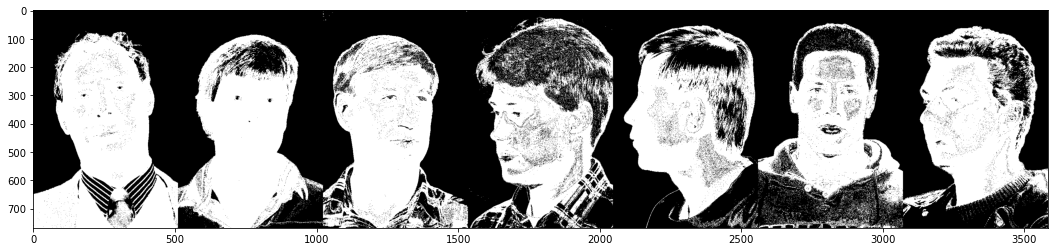

In [65]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YUV),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [66]:
with open('Result BO.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)

# Descente de gradient

In [46]:
def gradient_descent(cost_func, initial_params, learning_rate, num_iterations):
    params = initial_params.copy()  # Make a copy of the initial parameters
    history = []  # Track the cost function value at each iteration

    for _ in range(num_iterations):
        gradient = calculate_gradient(cost_func, params)  # Compute the gradient
        params -= learning_rate * gradient  # Update the parameters
        cost = cost_func(params)  # Compute the cost function
        history.append(cost)  # Store the cost in history

    return params, history

def calculate_gradient(cost_func, params, epsilon=1):
    num_params = len(params)
    gradient = np.zeros(num_params)

    for i in range(num_params):
        # Add a small epsilon to the i-th parameter
        params_plus = params.copy()
        params_plus[i] += epsilon

        # Subtract a small epsilon from the i-th parameter
        params_minus = params.copy()
        params_minus[i] -= epsilon

        # Calculate the partial derivative with respect to the i-th parameter
        gradient[i] = (cost_func(params_plus) - cost_func(params_minus)) / (2 * epsilon)

    return gradient

In [53]:
EvaluationGlobale()

90434 373379 0.24220430179522684 112318288 131235458 0.8558532100371837
89902 676444 0.13290383239410802 105496380 319095166 0.3306110253014613


(0.24220430179522684,
 0.13290383239410802,
 0.8558532100371837,
 0.3306110253014613)

In [54]:
def Evaluation(i):
    return Evaluer(ELLIPSES[i],MasterColors,i) - 1.7*Evaluer(ELLIPSES[i],MasterNonColors,i)

learning_rate = 0.25
num_iterations = 100

for I in range(256):
    def cost_function(params):
        setWeights(I,params)
        return 1-Evaluation(I)
    
    initial_params = getWeights(I)
    if(len(initial_params)==0):
        continue
    print('Iteration '+str(I)+' with '+str(len(initial_params))+' parameters  started at '+str(datetime.datetime.now()))
    optimized_params,hh = gradient_descent(cost_function, initial_params, learning_rate, num_iterations)
    setWeights(I,optimized_params)

Iteration 0 with 1 parameters  started at 2023-05-21 13:59:18.027556
Iteration 1 with 1 parameters  started at 2023-05-21 13:59:18.662296
Iteration 2 with 1 parameters  started at 2023-05-21 13:59:19.301492
Iteration 3 with 1 parameters  started at 2023-05-21 13:59:19.941529
Iteration 4 with 1 parameters  started at 2023-05-21 13:59:20.621672
Iteration 5 with 1 parameters  started at 2023-05-21 13:59:21.521674
Iteration 6 with 1 parameters  started at 2023-05-21 13:59:22.446293
Iteration 7 with 1 parameters  started at 2023-05-21 13:59:23.234162
Iteration 8 with 1 parameters  started at 2023-05-21 13:59:24.340304
Iteration 9 with 1 parameters  started at 2023-05-21 13:59:25.404302
Iteration 10 with 1 parameters  started at 2023-05-21 13:59:26.460771
Iteration 11 with 1 parameters  started at 2023-05-21 13:59:27.182657
Iteration 12 with 1 parameters  started at 2023-05-21 13:59:27.905514
Iteration 13 with 1 parameters  started at 2023-05-21 13:59:28.632607
Iteration 14 with 1 parameters

Iteration 117 with 6 parameters  started at 2023-05-21 14:09:36.095936
Iteration 118 with 4 parameters  started at 2023-05-21 14:09:44.187749
Iteration 119 with 4 parameters  started at 2023-05-21 14:09:48.687959
Iteration 120 with 5 parameters  started at 2023-05-21 14:09:52.655013
Iteration 121 with 4 parameters  started at 2023-05-21 14:09:59.660542
Iteration 122 with 4 parameters  started at 2023-05-21 14:10:03.930514
Iteration 123 with 3 parameters  started at 2023-05-21 14:10:07.960697
Iteration 124 with 4 parameters  started at 2023-05-21 14:10:11.048632
Iteration 125 with 4 parameters  started at 2023-05-21 14:10:15.256936
Iteration 126 with 4 parameters  started at 2023-05-21 14:10:19.541017
Iteration 127 with 5 parameters  started at 2023-05-21 14:10:23.975836
Iteration 128 with 6 parameters  started at 2023-05-21 14:10:29.678066
Iteration 129 with 5 parameters  started at 2023-05-21 14:10:37.195260
Iteration 130 with 4 parameters  started at 2023-05-21 14:10:43.712537
Iterat

Iteration 233 with 2 parameters  started at 2023-05-21 14:15:46.127052
Iteration 234 with 2 parameters  started at 2023-05-21 14:15:47.564727
Iteration 235 with 2 parameters  started at 2023-05-21 14:15:49.032904
Iteration 236 with 2 parameters  started at 2023-05-21 14:15:50.443193
Iteration 237 with 2 parameters  started at 2023-05-21 14:15:51.901717
Iteration 238 with 1 parameters  started at 2023-05-21 14:15:53.285205
Iteration 239 with 1 parameters  started at 2023-05-21 14:15:54.047482
Iteration 240 with 1 parameters  started at 2023-05-21 14:15:54.839120
Iteration 241 with 1 parameters  started at 2023-05-21 14:15:55.637120
Iteration 242 with 1 parameters  started at 2023-05-21 14:15:56.414038
Iteration 243 with 1 parameters  started at 2023-05-21 14:15:57.146109
Iteration 244 with 1 parameters  started at 2023-05-21 14:15:57.882047
Iteration 245 with 1 parameters  started at 2023-05-21 14:15:58.616089
Iteration 246 with 1 parameters  started at 2023-05-21 14:15:59.359056
Iterat

In [55]:
EvaluationGlobale()

42421 373379 0.11361378117141029 99506599 131235458 0.7582295251333675
41970 676444 0.06204504733577355 27255240 319095166 0.08541414256335052


(0.11361378117141029,
 0.06204504733577355,
 0.7582295251333675,
 0.08541414256335052)

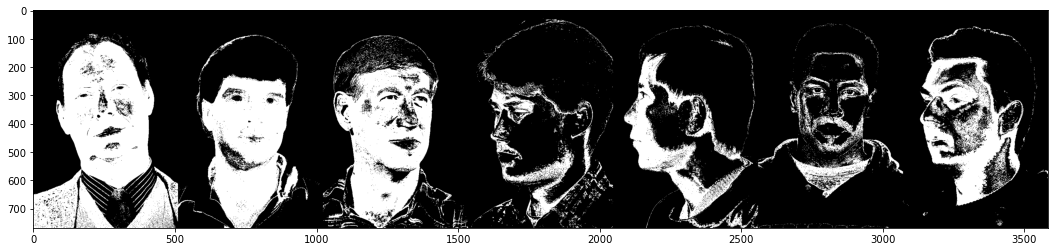

In [56]:
IMAGE = np.hstack([ np.hstack([np.hstack([np.hstack([np.hstack([np.hstack([cv2.imread("../Data/sfa/ORI/img (6).jpg"),
                                                                           cv2.imread("../Data/sfa/ORI/img (25).jpg")]),
                                                                cv2.imread("../Data/sfa/ORI/img (55).jpg")]),
                                                     cv2.imread("../Data/sfa/ORI/img (75).jpg")]),
                                          cv2.imread("../Data/sfa/ORI/img (89).jpg")]),
                             cv2.imread("../Data/sfa/ORI/img (118).jpg")]),
                  cv2.imread("../Data/sfa/ORI/img (110).jpg")])
MASK = getMask(cv2.cvtColor(cv2.cvtColor(IMAGE,cv2.COLOR_BGR2YUV),cv2.COLOR_BGR2RGB))
plt.figure(figsize = (20,4))
plt.imshow(MASK,cmap='gray')

In [57]:
with open('Result GD.pkl', 'wb') as f:
    pickle.dump(ELLIPSES, f)